In [2]:
from google.colab import drive
import pandas as pd
from tqdm import tqdm

drive.mount('/content/drive')
path = '/content/drive/MyDrive/6000_IMDB_Dataset.csv'

Mounted at /content/drive


In [3]:
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import AdamW
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

review_df = pd.read_csv(path)
feature = review_df['review'].tolist()
label = review_df['sentiment'].tolist()

for i in range(len(label)):
    if label[i] == 'positive':
        label[i] = 1
    else :
        label[i] = 0

train_texts,test_texts, train_labels,test_labels = train_test_split(feature, label, train_size=0.7, shuffle=True)

# 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [41]:
print(train_texts[1])
print("텍스트 길이",len(train_texts[1]))
print("=================================================================================================================")
print(train_encodings['input_ids'][1])
print("인코딩 길이",len(train_encodings['input_ids'][1]))
print("=================================================================================================================")


I'm sick of people whining about Ewoks! True, they're not the best thing that ever happened to Star Wars, but they DID happen, so deal with it! Besides, they ARE cute, and I don't care if they're marketable. Yubb Nubb!<br /><br />This movie always leaves me in tears. It's perfect. The end could not be better. I'm excited for The Phantom Menace because it will suddenly throw the focus of the whole story from Luke to Anakin. I love how he is revealed at the end - it would be too unresolved any other way. So those of you who are complaining that Vader's helmet was removed, take a moment to think about it. It's very effective. Vader, the man who hid behind a mask for 20 years, is finally revealed as a sick-looking man. He is not entirely machine - he's vulnerable.<br /><br />I don't know how the casting director happened to pick such good actors in A New Hope. They all do so well. They are believable characters. Hamill does an excellent job with his dramatic character development. Fisher d

< bert tokenizer 특징 >

1. word piece tokenizer를 기반
2. BPE 이용
3. subword 분리

- word piece tokenizer
    
    - BPE의 변형 알고리즘. 하나하나 바이트단위로 쪼갠다음, 병합되었을때 corpus에서 가장 많은 빈도수가 나오도록 구분하기.


- BPE ( byte pair encoding )

    - OOV 완화 효과
    - byte 단위로 쪼개어 새로운 단어를 유추하게 함. 주어진 단어가 low, highest라면 lowest를 유추할 수 있게됨

- subword

    - birthplace = birth + place 처럼 나누어서 생각하기

    

In [51]:
sequence= ["apple people water"]
inputs = tokenizer(sequence, return_tensors="pt")

input_ids = inputs['input_ids']
print(input_ids)

tokenizer.decode(input_ids[0])
# [CLS] apple people water [SEP]


tensor([[ 101, 6207, 2111, 2300,  102]])


'[CLS] apple people water [SEP]'

< bert classification 과정>
1. input으로 위에서 tokenized 된 문장이 들어간다.
2. bert embedding을 거친다.
    
    -  token / segment / position 의 합이 12 layers의 transformer encoder를 거쳐서 표현된다.
    - 이 과정에서 self-attention이 적용되어 문맥을 이해한 단어의 정보가 벡터로 표현된다.
3. embedding을 거쳐 나온 결과의 첫번쨰 [CLS] 토큰을 NN을 거쳐 분류가 된다.

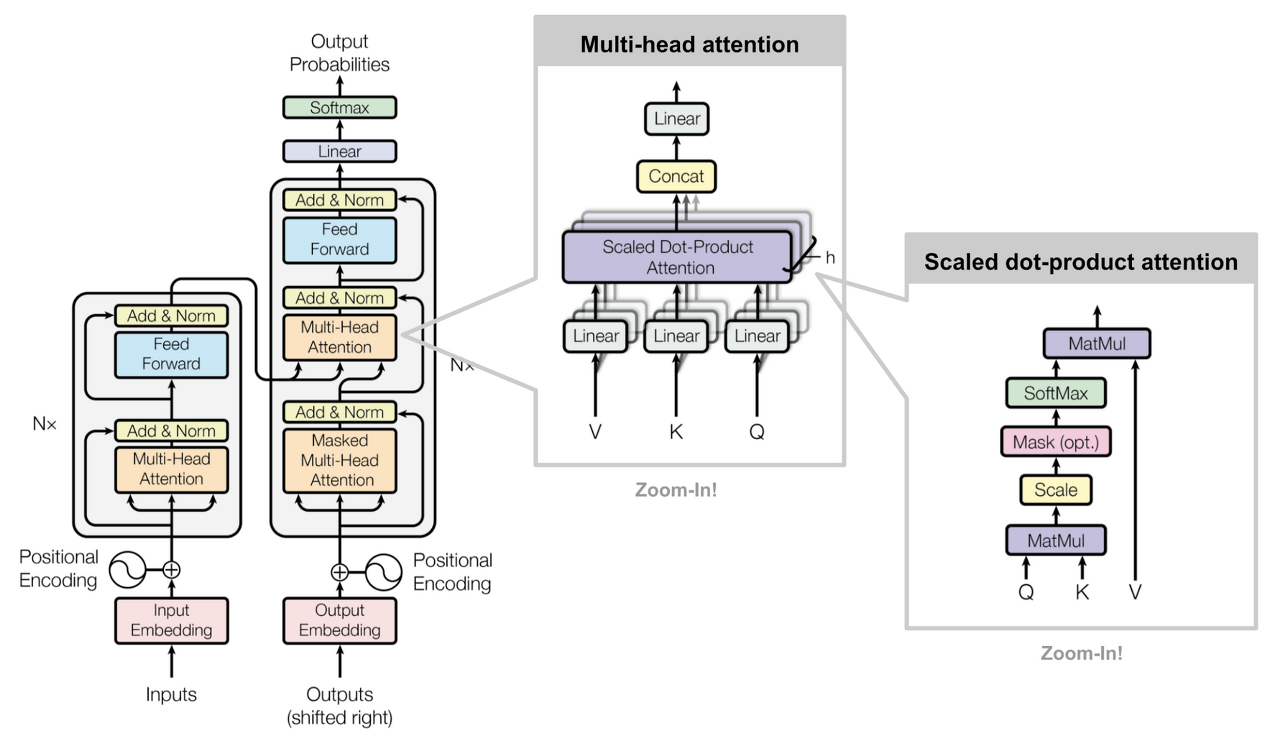
이때 masked된 sequence들은 fine tuning 단계가 아닌 pre-training 단계에서 사용된다.

idea


bert는 tfidf나 word2vec과 다르게 불용어 처리를 따로 진행하지 않음

그래도 전처리를 해주면 좀 더 성능이 좋게 나오지 않겠냐?


In [4]:
## 기존 bertforseqclassification
from transformers import BertPreTrainedModel
from transformers import PreTrainedModel
from transformers import BertConfig
from typing import List, Optional, Tuple, Union
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    get_torch_version,
    replace_return_docstrings,
    ModelOutput,
    logging
)

from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    MaskedLMOutput,
    MultipleChoiceModelOutput,
    NextSentencePredictorOutput,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutput,
    TokenClassifierOutput,
)

from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    """
    @add_start_docstrings_to_model_forward(BERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        checkpoint=_CHECKPOINT_FOR_SEQUENCE_CLASSIFICATION,
        output_type=SequenceClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
        expected_output=_SEQ_CLASS_EXPECTED_OUTPUT,
        expected_loss=_SEQ_CLASS_EXPECTED_LOSS,
    )
    """
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# 사전 훈련된 BERT 모델 이름 설정
config = BertConfig.from_pretrained('bert-base-uncased')
print(config)
config = BertConfig(
    num_labels=2,
    hidden_dropout_prob=0.2,
    classifier_dropout=0.1,
    use_cache=True
)
"""
default
"attention_probs_dropout_prob": 0.1,
"classifier_dropout": null,
"gradient_checkpointing": false,
"hidden_act": "gelu",
"hidden_dropout_prob": 0.1,
"hidden_size": 768,
"initializer_range": 0.02,
"intermediate_size": 3072,
"layer_norm_eps": 1e-12,
"max_position_embeddings": 512,
"model_type": "bert",
"num_attention_heads": 12,
"num_hidden_layers": 12,
"pad_token_id": 0,
"position_embedding_type": "absolute",
"transformers_version": "4.40.2",
"type_vocab_size": 2,
"use_cache": true,
"vocab_size": 30522
"""


# 새로운 설정으로 모델 초기화
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# 훈련 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# 데이터셋 생성
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(test_labels))

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

epoch_num = 2
model.train()
for epoch in range(epoch_num):
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        print(outputs.logits)
        print(labels)
        print(torch.argmax(outputs.logits, dim=1))
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        total += labels.size(0)
        correct += (predicted_labels == labels).sum().item()


accuracy = correct / total
print(f'테스트 정확도: {accuracy}')


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/525 [00:00<?, ?it/s]

tensor([[-0.0382,  0.1124],
        [-0.1959,  0.3644],
        [ 0.0513,  0.4268],
        [-0.2217,  0.2419],
        [-0.0027,  0.1672],
        [-0.2068,  0.4600],
        [-0.3026,  0.1259],
        [-0.1340,  0.3487]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


  0%|          | 1/525 [00:03<34:07,  3.91s/it]

tensor([[ 0.6206,  0.0078],
        [ 0.1668,  0.0905],
        [ 0.3637,  0.0033],
        [ 0.5183,  0.2411],
        [ 0.1556, -0.0288],
        [ 0.4930,  0.1943],
        [ 0.1824, -0.0395],
        [ 0.1238, -0.1001]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  0%|          | 2/525 [00:07<32:17,  3.70s/it]

tensor([[ 0.8113, -0.1114],
        [ 0.5122, -0.0131],
        [ 0.2866,  0.1168],
        [ 0.7525,  0.0488],
        [ 0.1347,  0.0854],
        [ 0.7778, -0.0757],
        [ 0.5639, -0.0736],
        [ 0.3369,  0.2022]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  1%|          | 3/525 [00:10<30:31,  3.51s/it]

tensor([[ 0.5046,  0.0047],
        [ 0.3701,  0.1071],
        [ 0.5900, -0.2218],
        [ 0.7695, -0.0675],
        [ 0.8375, -0.0280],
        [ 0.5631, -0.1268],
        [ 0.6407,  0.0413],
        [ 0.4782,  0.1180]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  1%|          | 4/525 [00:14<30:12,  3.48s/it]

tensor([[ 0.5227,  0.1859],
        [ 0.4006, -0.0228],
        [ 0.5100,  0.1325],
        [ 0.4961,  0.1858],
        [ 0.6532,  0.1350],
        [ 0.8095, -0.1552],
        [ 0.7022, -0.1402],
        [ 0.3763, -0.0350]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  1%|          | 5/525 [00:17<30:11,  3.48s/it]

tensor([[ 0.2631,  0.1068],
        [ 0.4286,  0.2514],
        [ 0.3843,  0.0843],
        [ 0.2172, -0.0095],
        [ 0.3840,  0.1279],
        [ 0.3997,  0.2458],
        [ 0.5436, -0.0203],
        [ 0.4425,  0.1298]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  1%|          | 6/525 [00:20<28:47,  3.33s/it]

tensor([[0.4077, 0.2679],
        [0.4546, 0.2896],
        [0.4321, 0.1411],
        [0.3959, 0.2918],
        [0.2981, 0.2586],
        [0.2075, 0.2864],
        [0.4392, 0.2218],
        [0.3420, 0.1940]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


  1%|▏         | 7/525 [00:23<28:06,  3.26s/it]

tensor([[ 0.2283,  0.3494],
        [ 0.3546,  0.3005],
        [ 0.5475,  0.1754],
        [ 0.4080,  0.2960],
        [-0.0615,  0.1759],
        [ 0.1158,  0.3301],
        [ 0.4243,  0.2982],
        [ 0.2814,  0.2444]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 1, 0])
tensor([1, 0, 0, 0, 1, 1, 0, 0])


  2%|▏         | 8/525 [00:26<27:15,  3.16s/it]

tensor([[ 0.0887,  0.3906],
        [ 0.1343,  0.1786],
        [ 0.2637,  0.2018],
        [ 0.0578,  0.2391],
        [ 0.0338,  0.2628],
        [-0.0131,  0.2271],
        [ 0.1842,  0.2652],
        [ 0.0673,  0.3290]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 1])


  2%|▏         | 9/525 [00:30<27:55,  3.25s/it]

tensor([[ 0.1751,  0.4911],
        [ 0.2734,  0.4939],
        [ 0.0516,  0.3041],
        [ 0.3246,  0.7065],
        [-0.0434,  0.3800],
        [-0.0955,  0.3110],
        [ 0.4622,  0.2940],
        [ 0.1620,  0.3537]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 1])


  2%|▏         | 10/525 [00:33<27:56,  3.26s/it]

tensor([[0.2593, 0.3447],
        [0.2635, 0.3965],
        [0.3047, 0.3443],
        [0.0766, 0.3336],
        [0.2427, 0.3085],
        [0.0663, 0.3300],
        [0.0257, 0.3995],
        [0.1365, 0.5413]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


  2%|▏         | 11/525 [00:36<27:53,  3.26s/it]

tensor([[ 0.4252,  0.4832],
        [ 0.5589,  0.4695],
        [ 0.1615,  0.3526],
        [ 0.2849,  0.2934],
        [ 0.3222,  0.3664],
        [ 0.4837,  0.6779],
        [ 0.2587,  0.4852],
        [-0.0187,  0.2970]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 1, 1, 1, 1, 1, 1])


  2%|▏         | 12/525 [00:40<28:00,  3.28s/it]

tensor([[0.2083, 0.2281],
        [0.0148, 0.2373],
        [0.6545, 0.3377],
        [0.2987, 0.3015],
        [0.2857, 0.2297],
        [0.1232, 0.2393],
        [0.0595, 0.3008],
        [0.2673, 0.0925]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 1])
tensor([1, 1, 0, 1, 0, 1, 1, 0])


  2%|▏         | 13/525 [00:42<27:00,  3.17s/it]

tensor([[0.6028, 0.3064],
        [0.3133, 0.4402],
        [0.0455, 0.1220],
        [0.2796, 0.3596],
        [0.2450, 0.2714],
        [0.3317, 0.0549],
        [0.2726, 0.2707],
        [0.2802, 0.4251]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 1, 1, 0, 0, 1])


  3%|▎         | 14/525 [00:45<26:02,  3.06s/it]

tensor([[0.2602, 0.3738],
        [0.1196, 0.2744],
        [0.3351, 0.1633],
        [0.5011, 0.2980],
        [0.6258, 0.3829],
        [0.1404, 0.3096],
        [0.1282, 0.3552],
        [0.3535, 0.3738]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 0, 0, 1])
tensor([1, 1, 0, 0, 0, 1, 1, 1])


  3%|▎         | 15/525 [00:48<24:21,  2.87s/it]

tensor([[0.4225, 0.3332],
        [0.2494, 0.3003],
        [0.2039, 0.3854],
        [0.5744, 0.1282],
        [0.3106, 0.0937],
        [0.3729, 0.3054],
        [0.4824, 0.2825],
        [0.3289, 0.3012]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 0, 0, 0])


  3%|▎         | 16/525 [00:51<25:11,  2.97s/it]

tensor([[0.5195, 0.4210],
        [0.5620, 0.3901],
        [0.1956, 0.3116],
        [0.4069, 0.2902],
        [0.3392, 0.3826],
        [0.3605, 0.3707],
        [0.3615, 0.2870],
        [0.5143, 0.3859]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 1, 1, 0, 0])


  3%|▎         | 17/525 [00:54<26:13,  3.10s/it]

tensor([[0.2439, 0.3139],
        [0.4773, 0.2004],
        [0.3457, 0.4077],
        [0.2383, 0.1870],
        [0.2030, 0.2867],
        [0.3065, 0.3244],
        [0.4165, 0.2839],
        [0.5771, 0.3074]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 0])
tensor([1, 0, 1, 0, 1, 1, 0, 0])


  3%|▎         | 18/525 [00:58<26:33,  3.14s/it]

tensor([[0.5052, 0.3163],
        [0.3255, 0.2582],
        [0.3261, 0.2843],
        [0.3706, 0.3526],
        [0.3942, 0.1240],
        [0.2602, 0.3357],
        [0.5332, 0.3112],
        [0.6324, 0.5734]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


  4%|▎         | 19/525 [01:01<26:38,  3.16s/it]

tensor([[0.4797, 0.2135],
        [0.3085, 0.2509],
        [0.5397, 0.5762],
        [0.4034, 0.2318],
        [0.4917, 0.3452],
        [0.4889, 0.3769],
        [0.4464, 0.3917],
        [0.5035, 0.2943]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


  4%|▍         | 20/525 [01:04<26:19,  3.13s/it]

tensor([[0.3836, 0.5125],
        [0.4981, 0.3132],
        [0.2983, 0.4258],
        [0.6564, 0.5390],
        [0.1724, 0.3525],
        [0.3833, 0.2330],
        [0.7119, 0.1649],
        [0.3559, 0.5702]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 0, 1])
tensor([1, 0, 1, 0, 1, 0, 0, 1])


  4%|▍         | 21/525 [01:07<25:49,  3.07s/it]

tensor([[0.3860, 0.1957],
        [0.3110, 0.5681],
        [0.3203, 0.3142],
        [0.2161, 0.1143],
        [0.2807, 0.2444],
        [0.4367, 0.2329],
        [0.4970, 0.3037],
        [0.4027, 0.3493]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


  4%|▍         | 22/525 [01:10<24:58,  2.98s/it]

tensor([[0.6474, 0.3750],
        [0.5899, 0.4575],
        [0.4911, 0.2463],
        [0.3658, 0.1498],
        [0.5241, 0.3463],
        [0.2555, 0.3190],
        [0.5680, 0.4175],
        [0.6235, 0.0456]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


  4%|▍         | 23/525 [01:12<24:47,  2.96s/it]

tensor([[0.5987, 0.4171],
        [0.4090, 0.1936],
        [0.5665, 0.2827],
        [0.5804, 0.2597],
        [0.4792, 0.0237],
        [0.2264, 0.1849],
        [0.4723, 0.2663],
        [0.8549, 0.5386]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  5%|▍         | 24/525 [01:16<25:12,  3.02s/it]

tensor([[0.2022, 0.3338],
        [0.2943, 0.2386],
        [0.2208, 0.2239],
        [0.7316, 0.5941],
        [0.4540, 0.3944],
        [0.4443, 0.3546],
        [0.3911, 0.4310],
        [0.4307, 0.1674]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 0, 1])
tensor([1, 0, 1, 0, 0, 0, 1, 0])


  5%|▍         | 25/525 [01:19<24:57,  2.99s/it]

tensor([[0.4187, 0.2630],
        [0.3668, 0.1449],
        [0.6994, 0.4535],
        [0.8984, 0.4276],
        [0.4417, 0.2478],
        [0.4712, 0.2627],
        [0.4457, 0.2324],
        [0.3310, 0.2508]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  5%|▍         | 26/525 [01:21<24:38,  2.96s/it]

tensor([[0.8030, 0.3409],
        [0.4749, 0.2110],
        [0.3273, 0.1921],
        [0.4757, 0.3738],
        [0.3431, 0.2468],
        [0.4336, 0.2971],
        [0.3913, 0.1715],
        [0.5630, 0.2621]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  5%|▌         | 27/525 [01:24<24:45,  2.98s/it]

tensor([[0.4514, 0.1418],
        [0.2811, 0.3216],
        [0.5496, 0.4360],
        [0.2469, 0.1794],
        [0.3229, 0.2319],
        [0.3688, 0.3255],
        [0.5329, 0.3055],
        [0.3360, 0.1723]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


  5%|▌         | 28/525 [01:27<23:17,  2.81s/it]

tensor([[0.4232, 0.2999],
        [0.3376, 0.1596],
        [0.5027, 0.1781],
        [0.5698, 0.1337],
        [0.5097, 0.2076],
        [0.5397, 0.2225],
        [0.5217, 0.2000],
        [0.4831, 0.4448]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  6%|▌         | 29/525 [01:29<22:28,  2.72s/it]

tensor([[0.3927, 0.1695],
        [0.4461, 0.5713],
        [0.3449, 0.1537],
        [0.4160, 0.0829],
        [0.3318, 0.1817],
        [0.6732, 0.3058],
        [0.2784, 0.1709],
        [0.2858, 0.2106]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


  6%|▌         | 30/525 [01:32<21:57,  2.66s/it]

tensor([[0.3856, 0.2247],
        [0.2877, 0.2249],
        [0.3244, 0.2475],
        [0.5700, 0.2373],
        [0.5088, 0.6525],
        [0.6147, 0.5857],
        [0.3209, 0.2897],
        [0.4520, 0.2651]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


  6%|▌         | 31/525 [01:35<21:56,  2.66s/it]

tensor([[0.1188, 0.5464],
        [0.2076, 0.2507],
        [0.3354, 0.1866],
        [0.3819, 0.1316],
        [0.4133, 0.3074],
        [0.5544, 0.1735],
        [0.7992, 0.6036],
        [0.2848, 0.2573]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 1, 0, 0, 0, 0, 0, 0])


  6%|▌         | 32/525 [01:37<21:43,  2.64s/it]

tensor([[0.5475, 0.5717],
        [0.2998, 0.2834],
        [0.5947, 0.3993],
        [0.0985, 0.0740],
        [0.3967, 0.1823],
        [0.4503, 0.1702],
        [0.8141, 0.4259],
        [0.4370, 0.3044]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 0, 1])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


  6%|▋         | 33/525 [01:40<22:06,  2.70s/it]

tensor([[0.3998, 0.4505],
        [0.2496, 0.2974],
        [0.4091, 0.3191],
        [0.4058, 0.3444],
        [0.2590, 0.1357],
        [0.1644, 0.1846],
        [0.3306, 0.1979],
        [0.7235, 0.3526]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 1, 0, 0])


  6%|▋         | 34/525 [01:42<21:34,  2.64s/it]

tensor([[0.3442, 0.3205],
        [0.1911, 0.2346],
        [0.4088, 0.4886],
        [0.6991, 0.4042],
        [0.3149, 0.3941],
        [0.6559, 0.4111],
        [0.3875, 0.6036],
        [0.3186, 0.2400]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 1, 0, 1, 0])


  7%|▋         | 35/525 [01:46<22:32,  2.76s/it]

tensor([[0.6317, 0.5153],
        [0.2566, 0.3846],
        [0.2219, 0.3141],
        [0.4348, 0.2894],
        [0.2531, 0.5479],
        [0.6583, 0.5510],
        [0.4289, 0.1705],
        [0.3047, 0.1908]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 0])
tensor([0, 1, 1, 0, 1, 0, 0, 0])


  7%|▋         | 36/525 [01:49<23:15,  2.85s/it]

tensor([[0.3069, 0.2382],
        [0.5116, 0.2688],
        [0.3039, 0.3810],
        [0.3115, 0.3013],
        [0.6448, 0.3419],
        [0.3922, 0.4298],
        [0.5217, 0.2928],
        [0.3731, 0.3858]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 1, 0, 0, 1, 0, 1])


  7%|▋         | 37/525 [01:52<23:54,  2.94s/it]

tensor([[0.3523, 0.1650],
        [0.3079, 0.2980],
        [0.4679, 0.0990],
        [0.1560, 0.1519],
        [0.4214, 0.3248],
        [0.3607, 0.3645],
        [0.2716, 0.2067],
        [0.5538, 0.4824]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


  7%|▋         | 38/525 [01:54<23:01,  2.84s/it]

tensor([[0.4424, 0.3915],
        [0.3914, 0.1369],
        [0.3416, 0.3154],
        [0.4738, 0.3494],
        [0.2500, 0.3517],
        [0.2811, 0.1074],
        [0.1469, 0.1620],
        [0.5220, 0.4851]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 1, 0])


  7%|▋         | 39/525 [01:57<22:24,  2.77s/it]

tensor([[0.2224, 0.1465],
        [0.3659, 0.2412],
        [0.8587, 0.4526],
        [0.3279, 0.1454],
        [0.2581, 0.3293],
        [0.4900, 0.2554],
        [0.4028, 0.2697],
        [0.2037, 0.2853]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 0, 1])
tensor([0, 0, 0, 0, 1, 0, 0, 1])


  8%|▊         | 40/525 [02:00<23:03,  2.85s/it]

tensor([[0.5156, 0.1942],
        [0.5765, 0.2473],
        [0.4917, 0.3002],
        [0.3745, 0.1643],
        [0.3879, 0.2370],
        [0.4073, 0.2269],
        [0.2539, 0.2938],
        [0.4948, 0.0837]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


  8%|▊         | 41/525 [02:03<24:03,  2.98s/it]

tensor([[0.3382, 0.2751],
        [0.4430, 0.1165],
        [0.2674, 0.1962],
        [0.5173, 0.1148],
        [0.4800, 0.2007],
        [0.6952, 0.3170],
        [0.6770, 0.1945],
        [0.7195, 0.2551]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  8%|▊         | 42/525 [02:07<24:53,  3.09s/it]

tensor([[0.4557, 0.1589],
        [0.4216, 0.2043],
        [0.7701, 0.2330],
        [0.3562, 0.1372],
        [0.5923, 0.1653],
        [0.4901, 0.2826],
        [0.5478, 0.1151],
        [0.7554, 0.1574]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  8%|▊         | 43/525 [02:10<25:35,  3.19s/it]

tensor([[0.5754, 0.1489],
        [0.6847, 0.0955],
        [0.4932, 0.3041],
        [0.6284, 0.2594],
        [0.6116, 0.1985],
        [0.5554, 0.2350],
        [0.6298, 0.0940],
        [0.4789, 0.2911]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  8%|▊         | 44/525 [02:13<25:20,  3.16s/it]

tensor([[0.4382, 0.2190],
        [0.3721, 0.1493],
        [0.3725, 0.1459],
        [0.7864, 0.0665],
        [0.5771, 0.2781],
        [0.4070, 0.2743],
        [0.5349, 0.2214],
        [0.7728, 0.3333]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  9%|▊         | 45/525 [02:16<23:47,  2.97s/it]

tensor([[0.5504, 0.2111],
        [0.6302, 0.1187],
        [0.6473, 0.0508],
        [0.4190, 0.1128],
        [0.3713, 0.3209],
        [0.5690, 0.0621],
        [0.5175, 0.1958],
        [0.5971, 0.2365]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  9%|▉         | 46/525 [02:19<23:33,  2.95s/it]

tensor([[0.7029, 0.3944],
        [0.4436, 0.0850],
        [0.3819, 0.2653],
        [0.3507, 0.2118],
        [0.4122, 0.1419],
        [0.6162, 0.2489],
        [0.4443, 0.1918],
        [0.7207, 0.4016]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  9%|▉         | 47/525 [02:22<23:38,  2.97s/it]

tensor([[0.3516, 0.1841],
        [0.6163, 0.3005],
        [0.4419, 0.2391],
        [0.3912, 0.0877],
        [0.5967, 0.1949],
        [0.6335, 0.1610],
        [0.5466, 0.2030],
        [0.4809, 0.0997]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


  9%|▉         | 48/525 [02:25<23:41,  2.98s/it]

tensor([[0.6174, 0.2343],
        [0.5767, 0.1611],
        [0.7125, 0.3512],
        [0.4767, 0.3281],
        [0.3404, 0.1101],
        [0.2521, 0.1474],
        [0.3350, 0.4700],
        [0.5002, 0.2100]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


  9%|▉         | 49/525 [02:28<24:21,  3.07s/it]

tensor([[0.3594, 0.2825],
        [0.4701, 0.2730],
        [0.6467, 0.4461],
        [0.3890, 0.1779],
        [0.5881, 0.2540],
        [0.4381, 0.1942],
        [0.4999, 0.0837],
        [0.6254, 0.2530]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 10%|▉         | 50/525 [02:31<24:19,  3.07s/it]

tensor([[0.3712, 0.1032],
        [0.4126, 0.2254],
        [0.4887, 0.2512],
        [0.4791, 0.2194],
        [0.3634, 0.1876],
        [0.6913, 0.2908],
        [0.4754, 0.3287],
        [0.3224, 0.2130]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 10%|▉         | 51/525 [02:34<24:27,  3.10s/it]

tensor([[0.5166, 0.0985],
        [0.3100, 0.2145],
        [0.8635, 0.3009],
        [0.2762, 0.2993],
        [0.4317, 0.3302],
        [0.5665, 0.0980],
        [0.2548, 0.2317],
        [0.4644, 0.4322]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 1, 0, 0, 0, 0])


 10%|▉         | 52/525 [02:37<24:25,  3.10s/it]

tensor([[0.1486, 0.1110],
        [0.3590, 0.3138],
        [0.2984, 0.2212],
        [0.3715, 0.5156],
        [0.6450, 0.4419],
        [0.6544, 0.4863],
        [0.5826, 0.3656],
        [0.4966, 0.4238]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0])


 10%|█         | 53/525 [02:40<23:46,  3.02s/it]

tensor([[0.5021, 0.2233],
        [0.3678, 0.2901],
        [0.5813, 0.5567],
        [0.4228, 0.3395],
        [0.3836, 0.2908],
        [0.3708, 0.3163],
        [0.3409, 0.1240],
        [0.1685, 0.3076]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


 10%|█         | 54/525 [02:43<22:30,  2.87s/it]

tensor([[0.1854, 0.2663],
        [0.4258, 0.2832],
        [0.1669, 0.1068],
        [0.4207, 0.2896],
        [0.4555, 0.2972],
        [0.3120, 0.3903],
        [0.3910, 0.3648],
        [0.3242, 0.1618]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 0])


 10%|█         | 55/525 [02:45<21:38,  2.76s/it]

tensor([[0.4357, 0.2086],
        [0.1881, 0.0916],
        [0.2943, 0.2848],
        [0.3876, 0.4343],
        [0.4772, 0.2727],
        [0.3941, 0.3795],
        [0.1913, 0.3088],
        [0.7753, 0.1338]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 1, 0])


 11%|█         | 56/525 [02:48<21:49,  2.79s/it]

tensor([[0.3812, 0.3692],
        [0.2953, 0.1916],
        [0.6348, 0.5205],
        [0.6181, 0.0765],
        [0.5700, 0.3652],
        [0.4458, 0.1335],
        [0.1452, 0.2529],
        [0.2411, 0.2036]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


 11%|█         | 57/525 [02:51<22:43,  2.91s/it]

tensor([[0.6453, 0.2922],
        [0.3310, 0.3381],
        [0.7613, 0.4251],
        [0.4174, 0.3378],
        [0.4121, 0.3207],
        [0.6480, 0.4630],
        [0.4818, 0.3821],
        [0.2431, 0.0167]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


 11%|█         | 58/525 [02:54<23:16,  2.99s/it]

tensor([[0.2854, 0.2254],
        [0.5165, 0.5108],
        [0.2657, 0.3628],
        [0.7126, 0.5293],
        [0.4154, 0.2985],
        [0.3520, 0.2836],
        [0.3097, 0.1692],
        [0.2715, 0.2818]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 1])


 11%|█         | 59/525 [02:58<24:02,  3.09s/it]

tensor([[0.5287, 0.1962],
        [0.4612, 0.2978],
        [0.8623, 0.4654],
        [0.2649, 0.1194],
        [0.3091, 0.3431],
        [0.3485, 0.1583],
        [0.3791, 0.2566],
        [0.2337, 0.1641]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 1])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 11%|█▏        | 60/525 [03:01<24:16,  3.13s/it]

tensor([[0.4220, 0.3332],
        [0.2046, 0.1778],
        [0.0852, 0.2243],
        [0.3338, 0.0996],
        [0.3057, 0.2666],
        [0.3279, 0.1001],
        [0.3645, 0.2367],
        [0.3942, 0.3180]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


 12%|█▏        | 61/525 [03:04<23:09,  2.99s/it]

tensor([[0.3186, 0.2342],
        [0.4965, 0.3028],
        [0.5979, 0.3419],
        [0.3397, 0.2963],
        [0.3901, 0.2524],
        [0.6143, 0.3218],
        [0.4025, 0.2139],
        [0.4395, 0.3170]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 12%|█▏        | 62/525 [03:06<22:52,  2.96s/it]

tensor([[0.2778, 0.3050],
        [0.2598, 0.1725],
        [0.5365, 0.3554],
        [0.2411, 0.3894],
        [0.4883, 0.5213],
        [0.6453, 0.3540],
        [0.5410, 0.1481],
        [0.5220, 0.2704]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 0, 0, 1, 1, 0, 0, 0])


 12%|█▏        | 63/525 [03:09<22:53,  2.97s/it]

tensor([[0.3907, 0.0419],
        [0.5362, 0.2029],
        [0.3463, 0.3053],
        [0.3339, 0.3821],
        [0.6551, 0.5222],
        [0.5799, 0.4108],
        [0.7902, 0.3300],
        [0.2341, 0.1744]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0])


 12%|█▏        | 64/525 [03:12<23:04,  3.00s/it]

tensor([[0.6867, 0.3813],
        [0.3026, 0.3118],
        [0.3191, 0.3426],
        [0.5215, 0.4704],
        [0.5957, 0.3121],
        [0.3749, 0.4010],
        [0.4082, 0.2731],
        [0.5700, 0.3506]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 1, 0, 0])


 12%|█▏        | 65/525 [03:16<23:09,  3.02s/it]

tensor([[0.5102, 0.4232],
        [0.3062, 0.1814],
        [0.3248, 0.4451],
        [0.4299, 0.3361],
        [0.2979, 0.1950],
        [0.3990, 0.2012],
        [0.5209, 0.1218],
        [0.1817, 0.1742]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


 13%|█▎        | 66/525 [03:19<23:01,  3.01s/it]

tensor([[0.3836, 0.1979],
        [0.6941, 0.4232],
        [0.5303, 0.2004],
        [0.4713, 0.3606],
        [0.3852, 0.0942],
        [0.2910, 0.0701],
        [0.3557, 0.1197],
        [0.2724, 0.1928]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 13%|█▎        | 67/525 [03:22<23:21,  3.06s/it]

tensor([[0.6846, 0.2019],
        [0.2691, 0.3193],
        [0.6575, 0.4169],
        [0.4015, 0.1795],
        [0.4549, 0.3405],
        [0.3195, 0.2406],
        [0.8304, 0.4224],
        [0.3759, 0.3516]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


 13%|█▎        | 68/525 [03:25<23:06,  3.03s/it]

tensor([[0.2539, 0.2609],
        [0.4405, 0.2311],
        [0.2477, 0.3397],
        [0.3947, 0.3626],
        [0.4415, 0.1491],
        [0.4156, 0.2057],
        [0.4651, 0.1965],
        [0.5039, 0.3553]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 13%|█▎        | 69/525 [03:27<22:32,  2.97s/it]

tensor([[0.3909, 0.2955],
        [0.4010, 0.2827],
        [0.2632, 0.1213],
        [0.4182, 0.2970],
        [0.5881, 0.2366],
        [0.3880, 0.1297],
        [0.6146, 0.2594],
        [0.3480, 0.3380]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 13%|█▎        | 70/525 [03:30<22:31,  2.97s/it]

tensor([[0.4103, 0.2524],
        [0.3054, 0.1808],
        [0.3604, 0.1386],
        [0.3978, 0.3003],
        [0.3628, 0.4222],
        [0.7470, 0.2815],
        [0.3384, 0.0664],
        [0.2271, 0.2259]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 14%|█▎        | 71/525 [03:33<22:32,  2.98s/it]

tensor([[0.3816, 0.1930],
        [0.4743, 0.2688],
        [0.3461, 0.2822],
        [0.3144, 0.1742],
        [0.5866, 0.4914],
        [0.2658, 0.1764],
        [0.2674, 0.3276],
        [0.6468, 0.4724]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


 14%|█▎        | 72/525 [03:36<22:36,  3.00s/it]

tensor([[0.4189, 0.1521],
        [0.3685, 0.3623],
        [0.3655, 0.1586],
        [0.3874, 0.3199],
        [0.3031, 0.3135],
        [0.4433, 0.4406],
        [0.3205, 0.2676],
        [0.4018, 0.4641]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 1])


 14%|█▍        | 73/525 [03:40<23:02,  3.06s/it]

tensor([[0.0106, 0.3335],
        [0.3471, 0.2331],
        [0.3093, 0.3383],
        [0.1796, 0.2843],
        [0.3977, 0.1323],
        [0.2756, 0.1843],
        [0.3257, 0.2362],
        [0.3983, 0.3534]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 1])
tensor([1, 0, 1, 1, 0, 0, 0, 0])


 14%|█▍        | 74/525 [03:43<23:10,  3.08s/it]

tensor([[0.5565, 0.2471],
        [0.6152, 0.1278],
        [0.3478, 0.2585],
        [0.2123, 0.1440],
        [0.6480, 0.4163],
        [0.3319, 0.1967],
        [0.4687, 0.1585],
        [0.2274, 0.3165]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


 14%|█▍        | 75/525 [03:46<22:38,  3.02s/it]

tensor([[0.2185, 0.1928],
        [0.2484, 0.1154],
        [0.2193, 0.2394],
        [0.1401, 0.2574],
        [0.3229, 0.2247],
        [0.3100, 0.2517],
        [0.0008, 0.3038],
        [0.1378, 0.2580]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 1, 1, 0, 0, 1, 1])


 14%|█▍        | 76/525 [03:48<21:49,  2.92s/it]

tensor([[0.1798, 0.3156],
        [0.4250, 0.3019],
        [0.5209, 0.4816],
        [0.2262, 0.3840],
        [0.2934, 0.2416],
        [0.2649, 0.3526],
        [0.1849, 0.1532],
        [0.1910, 0.3505]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 0, 1])
tensor([1, 0, 0, 1, 0, 1, 0, 1])


 15%|█▍        | 77/525 [03:51<21:50,  2.93s/it]

tensor([[0.2070, 0.3372],
        [0.3094, 0.3499],
        [0.2472, 0.2543],
        [0.4842, 0.2366],
        [0.5509, 0.3560],
        [0.2477, 0.2486],
        [0.0921, 0.2996],
        [0.2463, 0.3329]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 0])
tensor([1, 1, 1, 0, 0, 1, 1, 1])


 15%|█▍        | 78/525 [03:54<21:51,  2.93s/it]

tensor([[0.0781, 0.2259],
        [0.1672, 0.4220],
        [0.1388, 0.2617],
        [0.1345, 0.2815],
        [0.3103, 0.2979],
        [0.1738, 0.3013],
        [0.4468, 0.3369],
        [0.5022, 0.3642]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 1])
tensor([1, 1, 1, 1, 0, 1, 0, 0])


 15%|█▌        | 79/525 [03:57<22:03,  2.97s/it]

tensor([[ 0.1067,  0.2880],
        [ 0.4617,  0.5515],
        [ 0.5591,  0.5047],
        [-0.0586,  0.3988],
        [ 0.1298,  0.3792],
        [ 0.3733,  0.3723],
        [ 0.3523,  0.3963],
        [ 0.0047,  0.2784]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 0])
tensor([1, 1, 0, 1, 1, 0, 1, 1])


 15%|█▌        | 80/525 [04:00<21:48,  2.94s/it]

tensor([[ 0.0610,  0.4818],
        [ 0.1019,  0.1950],
        [ 0.1904,  0.3502],
        [ 0.1843,  0.1452],
        [ 0.1644,  0.1708],
        [-0.0730,  0.2809],
        [ 0.5989,  0.4482],
        [ 0.1474,  0.2900]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 0])
tensor([1, 1, 1, 0, 1, 1, 0, 1])


 15%|█▌        | 81/525 [04:03<22:25,  3.03s/it]

tensor([[0.1940, 0.3529],
        [0.3053, 0.3450],
        [0.2256, 0.2365],
        [0.1866, 0.3768],
        [0.0865, 0.2660],
        [0.1669, 0.1179],
        [0.1486, 0.3260],
        [0.3173, 0.4005]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 0, 1, 1])


 16%|█▌        | 82/525 [04:07<22:35,  3.06s/it]

tensor([[ 0.3292,  0.2641],
        [-0.0034,  0.2927],
        [ 0.1810,  0.3546],
        [ 0.2034,  0.2882],
        [ 0.3225,  0.3171],
        [ 0.1858,  0.4215],
        [ 0.1520,  0.3816],
        [ 0.3304,  0.4110]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([0, 1, 1, 1, 0, 1, 1, 1])


 16%|█▌        | 83/525 [04:10<22:36,  3.07s/it]

tensor([[0.2263, 0.3027],
        [0.4589, 0.2897],
        [0.2553, 0.1466],
        [0.0993, 0.1502],
        [0.2308, 0.3045],
        [0.3445, 0.3717],
        [0.5016, 0.5789],
        [0.0469, 0.2710]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([1, 0, 0, 1, 1, 1, 1, 1])


 16%|█▌        | 84/525 [04:12<21:21,  2.91s/it]

tensor([[0.3158, 0.1843],
        [0.7073, 0.2716],
        [0.4284, 0.2441],
        [0.3899, 0.1587],
        [0.5965, 0.5011],
        [0.3328, 0.2153],
        [0.1737, 0.4911],
        [0.2697, 0.3367]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 1, 1])


 16%|█▌        | 85/525 [04:15<20:26,  2.79s/it]

tensor([[0.2883, 0.1789],
        [0.3753, 0.3664],
        [0.2408, 0.2895],
        [0.2653, 0.1436],
        [0.3532, 0.3465],
        [0.2701, 0.2348],
        [0.2475, 0.2837],
        [0.3883, 0.2164]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 0, 0, 0, 1, 0])


 16%|█▋        | 86/525 [04:17<20:09,  2.76s/it]

tensor([[0.7116, 0.2692],
        [0.6252, 0.4654],
        [0.2771, 0.2539],
        [0.2224, 0.4044],
        [0.2936, 0.1804],
        [0.4068, 0.4164],
        [0.2673, 0.0163],
        [0.3382, 0.3347]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 1, 0, 0])


 17%|█▋        | 87/525 [04:20<19:41,  2.70s/it]

tensor([[0.3907, 0.1518],
        [0.3325, 0.1562],
        [0.3933, 0.2368],
        [0.3869, 0.2976],
        [0.4427, 0.1487],
        [0.5315, 0.2470],
        [0.2149, 0.1648],
        [0.3306, 0.2535]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 17%|█▋        | 88/525 [04:23<21:02,  2.89s/it]

tensor([[0.3559, 0.2165],
        [0.4699, 0.1629],
        [0.5706, 0.0525],
        [0.4711, 0.1556],
        [0.4501, 0.2525],
        [0.3185, 0.0497],
        [0.4058, 0.1428],
        [0.3241, 0.1617]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 17%|█▋        | 89/525 [04:27<22:24,  3.08s/it]

tensor([[0.2472, 0.2947],
        [0.6876, 0.1210],
        [0.5939, 0.0012],
        [0.9720, 0.4086],
        [0.4400, 0.3342],
        [0.5508, 0.1591],
        [0.5284, 0.1673],
        [0.6967, 0.1200]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 0, 1])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 17%|█▋        | 90/525 [04:30<23:16,  3.21s/it]

tensor([[ 0.2701,  0.1945],
        [ 0.6435,  0.2120],
        [ 0.3811, -0.0833],
        [ 0.7063,  0.2970],
        [ 0.2468,  0.2028],
        [ 0.1913,  0.2617],
        [ 0.3831,  0.1757],
        [ 0.4496,  0.1551]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


 17%|█▋        | 91/525 [04:34<23:57,  3.31s/it]

tensor([[ 0.4738,  0.2034],
        [ 0.5116,  0.2700],
        [ 0.6763,  0.1679],
        [ 0.3948,  0.1270],
        [ 0.4165,  0.2744],
        [ 0.5260,  0.0896],
        [ 0.5134, -0.0599],
        [ 0.5630,  0.2888]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 18%|█▊        | 92/525 [04:37<23:40,  3.28s/it]

tensor([[0.5323, 0.3763],
        [0.4879, 0.1822],
        [0.2871, 0.1447],
        [0.3249, 0.1674],
        [0.3442, 0.1873],
        [0.3541, 0.0062],
        [0.6353, 0.1033],
        [0.6275, 0.1698]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 18%|█▊        | 93/525 [04:40<22:12,  3.09s/it]

tensor([[ 0.4022,  0.2603],
        [ 0.4317,  0.1831],
        [ 0.5241, -0.0333],
        [ 0.6531,  0.1238],
        [ 0.5014,  0.1927],
        [ 0.3146,  0.2808],
        [ 0.4238,  0.1959],
        [ 0.2641,  0.0898]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 18%|█▊        | 94/525 [04:42<21:05,  2.94s/it]

tensor([[0.3456, 0.0765],
        [0.3625, 0.3296],
        [0.3110, 0.1366],
        [0.5433, 0.0689],
        [0.4552, 0.2170],
        [0.7207, 0.1333],
        [0.2998, 0.2783],
        [0.6106, 0.3951]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 18%|█▊        | 95/525 [04:45<21:11,  2.96s/it]

tensor([[0.5076, 0.1819],
        [0.3100, 0.1811],
        [0.6290, 0.3354],
        [0.4102, 0.3154],
        [0.3843, 0.0618],
        [0.4653, 0.0496],
        [0.5461, 0.1575],
        [0.4244, 0.2426]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 18%|█▊        | 96/525 [04:48<21:23,  2.99s/it]

tensor([[0.4542, 0.1650],
        [0.3345, 0.2555],
        [0.2978, 0.2295],
        [0.5432, 0.2498],
        [0.4358, 0.1949],
        [0.4498, 0.1987],
        [0.3293, 0.1916],
        [0.1042, 0.1689]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


 18%|█▊        | 97/525 [04:52<21:50,  3.06s/it]

tensor([[0.2636, 0.0417],
        [0.6328, 0.1905],
        [0.4667, 0.2559],
        [0.1696, 0.1861],
        [0.3611, 0.1803],
        [0.4474, 0.0940],
        [0.1158, 0.1494],
        [0.3665, 0.0296]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 1, 0])


 19%|█▊        | 98/525 [04:55<22:05,  3.10s/it]

tensor([[0.1971, 0.2859],
        [0.4471, 0.2780],
        [0.2349, 0.3447],
        [0.4170, 0.1505],
        [0.2421, 0.2167],
        [0.7308, 0.3618],
        [0.5602, 0.3299],
        [0.4683, 0.2498]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 19%|█▉        | 99/525 [04:58<22:05,  3.11s/it]

tensor([[ 0.4812, -0.0028],
        [ 0.3730, -0.0334],
        [ 0.6950,  0.2031],
        [ 0.3016,  0.3432],
        [ 0.4707,  0.1392],
        [ 0.4448,  0.1750],
        [ 0.3285,  0.1011],
        [ 0.4361,  0.1692]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 1])
tensor([0, 0, 0, 1, 0, 0, 0, 0])


 19%|█▉        | 100/525 [05:01<21:41,  3.06s/it]

tensor([[0.4817, 0.3900],
        [0.1420, 0.2870],
        [0.6732, 0.1050],
        [0.5162, 0.1115],
        [0.3700, 0.0896],
        [0.4929, 0.0442],
        [0.3842, 0.1491],
        [0.3472, 0.2215]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


 19%|█▉        | 101/525 [05:04<21:19,  3.02s/it]

tensor([[ 0.2319,  0.6302],
        [ 0.7471,  0.1207],
        [ 0.4196, -0.0325],
        [ 0.6256,  0.0576],
        [ 0.4219,  0.0522],
        [ 0.4503, -0.0812],
        [ 0.2673,  0.0762],
        [ 0.4764,  0.1892]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 19%|█▉        | 102/525 [05:07<21:07,  3.00s/it]

tensor([[ 0.6378,  0.1141],
        [ 0.0680,  0.3235],
        [ 0.6642,  0.1220],
        [ 0.5615,  0.1484],
        [ 0.3178,  0.2137],
        [-0.0938,  0.3228],
        [ 0.3968,  0.0879],
        [ 0.6296, -0.0588]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 0, 0])
tensor([0, 1, 0, 0, 0, 1, 0, 0])


 20%|█▉        | 103/525 [05:10<21:09,  3.01s/it]

tensor([[ 0.0318,  0.4757],
        [-0.2331,  0.4743],
        [-0.2547,  0.5450],
        [ 0.5416, -0.0712],
        [-0.2714,  0.3670],
        [ 0.3481,  0.0933],
        [ 0.4287,  0.5811],
        [ 0.5267,  0.1286]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 0])
tensor([1, 1, 1, 0, 1, 0, 1, 0])


 20%|█▉        | 104/525 [05:13<21:29,  3.06s/it]

tensor([[ 0.5109,  0.2783],
        [-0.5002,  0.5590],
        [-0.3945,  0.5072],
        [ 0.6322,  0.1869],
        [-0.3082,  0.6486],
        [-0.5807,  0.1994],
        [ 0.6117, -0.0265],
        [-0.6633,  0.5644]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 0, 0])
tensor([0, 1, 1, 0, 1, 1, 0, 1])


 20%|██        | 105/525 [05:16<21:50,  3.12s/it]

tensor([[-0.5946,  0.4524],
        [-0.4730,  0.4077],
        [ 0.4796,  0.2974],
        [ 0.8201, -0.0385],
        [ 0.7976,  0.2373],
        [ 0.2047,  0.3431],
        [-0.3263,  0.6789],
        [ 0.9369,  0.0190]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 1, 0])
tensor([1, 1, 0, 0, 0, 1, 1, 0])


 20%|██        | 106/525 [05:19<20:42,  2.97s/it]

tensor([[ 1.0545, -0.2749],
        [ 0.8437, -0.0432],
        [ 0.8883, -0.0663],
        [ 0.5973,  0.0253],
        [-0.4876,  0.4580],
        [ 0.5480, -0.0977],
        [ 0.9381, -0.1093],
        [ 0.7758, -0.0452]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 20%|██        | 107/525 [05:22<21:02,  3.02s/it]

tensor([[ 1.1269, -0.3099],
        [ 1.0267, -0.3897],
        [ 1.1431, -0.2491],
        [ 0.8252, -0.2136],
        [ 1.1364, -0.3265],
        [ 1.0356, -0.1814],
        [ 1.2349, -0.1325],
        [ 1.3234, -0.1052]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 21%|██        | 108/525 [05:25<20:40,  2.98s/it]

tensor([[ 0.7863, -0.3580],
        [ 1.0662, -0.1091],
        [ 0.9539, -0.2419],
        [ 1.1872,  0.0203],
        [ 0.8743,  0.0110],
        [ 0.8824, -0.2439],
        [ 0.4426,  0.1492],
        [ 0.9295, -0.2784]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 21%|██        | 109/525 [05:27<19:54,  2.87s/it]

tensor([[ 0.8078, -0.1875],
        [-0.4718,  0.6410],
        [-1.0845,  0.7506],
        [ 0.4259,  0.0340],
        [ 0.9414, -0.0215],
        [-1.0366,  0.8474],
        [ 0.8960, -0.3216],
        [-1.2350,  0.5234]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 1, 0, 1])
tensor([0, 1, 1, 0, 0, 1, 0, 1])


 21%|██        | 110/525 [05:31<20:29,  2.96s/it]

tensor([[-1.5981,  0.8109],
        [-0.0053,  0.2633],
        [ 1.0084, -0.0316],
        [ 0.0157,  0.3877],
        [-1.6027,  1.0087],
        [-1.6704,  1.0147],
        [ 0.3696,  0.1625],
        [-1.2760,  0.8357]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 1, 0, 1])


 21%|██        | 111/525 [05:34<21:17,  3.09s/it]

tensor([[-1.3361,  0.6689],
        [-1.1843,  0.5933],
        [-1.2194,  0.6761],
        [-1.3116,  0.6674],
        [-1.2597,  0.7473],
        [-1.2374,  0.8973],
        [ 0.6411, -0.0471],
        [ 0.9165, -0.1772]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 0])


 21%|██▏       | 112/525 [05:37<21:58,  3.19s/it]

tensor([[ 0.5539, -0.0632],
        [-1.3201,  0.7540],
        [ 0.6165,  0.0178],
        [-1.1287,  0.8157],
        [-0.8417,  1.2012],
        [ 0.9845, -0.2548],
        [ 0.6522, -0.0252],
        [-1.0911,  0.9683]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 0, 1])
tensor([0, 1, 0, 1, 1, 0, 0, 1])


 22%|██▏       | 113/525 [05:41<22:04,  3.21s/it]

tensor([[-1.3522,  0.6506],
        [ 0.8943, -0.0430],
        [-1.2021,  1.1983],
        [-0.2802,  0.4922],
        [ 0.9428,  0.1037],
        [-0.7164,  0.8696],
        [ 0.7416, -0.2218],
        [ 0.7215,  0.0346]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 0, 1, 1, 0, 1, 0, 0])


 22%|██▏       | 114/525 [05:44<21:07,  3.08s/it]

tensor([[ 0.6909,  0.3665],
        [ 0.8048, -0.0528],
        [ 0.9371,  0.0130],
        [ 0.8380, -0.2980],
        [ 0.4001,  0.2022],
        [-0.5646,  0.6016],
        [ 0.6243, -0.0611],
        [ 0.2439,  0.1789]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


 22%|██▏       | 115/525 [05:46<20:48,  3.04s/it]

tensor([[ 0.9224, -0.0653],
        [ 0.6114, -0.1486],
        [ 1.0029, -0.0082],
        [ 0.7479, -0.1211],
        [-0.9193,  0.7662],
        [-0.7233,  0.6456],
        [ 0.4220,  0.1260],
        [ 0.7321, -0.1284]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 0, 0])


 22%|██▏       | 116/525 [05:49<19:52,  2.91s/it]

tensor([[ 1.3794, -0.1966],
        [ 1.0731, -0.0778],
        [ 1.1317, -0.2681],
        [ 1.0976, -0.0033],
        [ 0.6835, -0.0050],
        [ 0.9245, -0.0609],
        [ 0.8978, -0.0446],
        [ 0.4797, -0.0776]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 22%|██▏       | 117/525 [05:52<19:59,  2.94s/it]

tensor([[ 0.3680,  0.2284],
        [ 0.9207, -0.0774],
        [ 0.9799,  0.0580],
        [ 0.9913, -0.0097],
        [ 0.9729, -0.0271],
        [ 0.8289, -0.2072],
        [ 0.8509, -0.2128],
        [ 0.8341, -0.2091]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 22%|██▏       | 118/525 [05:55<20:46,  3.06s/it]

tensor([[ 0.6869, -0.0800],
        [ 0.7065, -0.0845],
        [ 0.6798,  0.0038],
        [ 1.1792,  0.1607],
        [ 0.8099, -0.3071],
        [ 0.6088, -0.1185],
        [ 0.5811, -0.1565],
        [ 0.9589, -0.1516]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 23%|██▎       | 119/525 [05:59<21:23,  3.16s/it]

tensor([[ 0.5721, -0.0871],
        [ 0.7992, -0.1520],
        [ 0.8857, -0.1265],
        [ 0.9277, -0.1879],
        [ 0.3733,  0.0879],
        [ 0.8964, -0.2138],
        [ 0.8581, -0.0743],
        [ 1.0569, -0.0040]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 23%|██▎       | 120/525 [06:02<21:31,  3.19s/it]

tensor([[ 0.7658, -0.0095],
        [ 0.7441,  0.0011],
        [ 0.7383, -0.0742],
        [ 0.6490, -0.1405],
        [ 0.7382, -0.2598],
        [ 0.6985, -0.1839],
        [ 0.5756, -0.2269],
        [ 0.6876, -0.3187]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 23%|██▎       | 121/525 [06:05<21:07,  3.14s/it]

tensor([[-0.7023,  0.5360],
        [ 0.7646,  0.1420],
        [ 0.4491,  0.1008],
        [-0.1386,  0.2564],
        [ 0.9469, -0.1042],
        [ 0.8160, -0.0092],
        [ 0.7512, -0.1202],
        [ 0.7094,  0.0944]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 0])


 23%|██▎       | 122/525 [06:08<20:47,  3.10s/it]

tensor([[ 0.0958,  0.1579],
        [-1.0405,  0.6710],
        [ 0.9912,  0.0280],
        [ 0.5144,  0.0293],
        [ 0.1956,  0.0315],
        [ 0.1141,  0.1914],
        [-0.0741,  0.2724],
        [ 0.2933,  0.1059]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 1])
tensor([1, 1, 0, 0, 0, 1, 1, 0])


 23%|██▎       | 123/525 [06:11<20:35,  3.07s/it]

tensor([[ 0.4591,  0.0509],
        [ 0.6573,  0.0639],
        [-1.0372,  0.6681],
        [ 0.7666,  0.1079],
        [ 0.7084,  0.0140],
        [-0.3090,  0.4845],
        [-0.0032,  0.3318],
        [ 0.5177,  0.1023]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 0])
tensor([0, 0, 1, 0, 0, 1, 1, 0])


 24%|██▎       | 124/525 [06:14<20:47,  3.11s/it]

tensor([[ 0.7933, -0.1530],
        [-1.2095,  0.9167],
        [-1.1057,  0.7733],
        [-1.4603,  1.1147],
        [ 0.3402,  0.1494],
        [-0.6253,  0.8341],
        [ 0.8118, -0.0515],
        [-1.3950,  0.6454]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 1])


 24%|██▍       | 125/525 [06:17<20:45,  3.11s/it]

tensor([[ 0.7972, -0.1211],
        [ 0.1815,  0.1409],
        [-1.4959,  1.0275],
        [-1.3722,  0.6832],
        [-0.8634,  0.7004],
        [-1.4500,  0.9954],
        [-1.3527,  0.5963],
        [-1.4267,  0.7822]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 1, 1, 1, 1])


 24%|██▍       | 126/525 [06:21<20:59,  3.16s/it]

tensor([[-1.2415,  0.7920],
        [-1.2232,  0.8874],
        [-1.5755,  0.7134],
        [-1.4376,  1.1099],
        [-1.0420,  0.8261],
        [-1.0018,  0.4667],
        [-0.6977,  0.5075],
        [-1.4727,  0.9638]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


 24%|██▍       | 127/525 [06:24<20:49,  3.14s/it]

tensor([[-1.1949,  0.7881],
        [-1.4614,  0.7629],
        [-1.5081,  1.1177],
        [-1.1815,  0.9093],
        [ 0.5704, -0.0032],
        [-1.2803,  0.8113],
        [-0.2295,  0.4846],
        [-0.0194,  0.2485]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 1, 0, 0])
tensor([1, 1, 1, 1, 0, 1, 1, 1])


 24%|██▍       | 128/525 [06:27<20:34,  3.11s/it]

tensor([[ 0.5509, -0.1378],
        [ 0.9203,  0.0984],
        [-0.8072,  0.9168],
        [-0.2959,  0.5620],
        [-0.2416,  0.5974],
        [-0.8316,  0.8554],
        [-1.0320,  0.7883],
        [-0.4647,  0.6889]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 1])
tensor([0, 0, 1, 1, 1, 1, 1, 1])


 25%|██▍       | 129/525 [06:30<20:21,  3.08s/it]

tensor([[-0.1234,  0.1988],
        [ 0.7662,  0.0133],
        [-0.5722,  0.4998],
        [-0.6085,  0.5040],
        [ 0.6595, -0.0295],
        [-1.0509,  0.7729],
        [ 0.8475, -0.1518],
        [ 0.8002,  0.1075]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 0, 1, 1, 0, 1, 0, 0])


 25%|██▍       | 130/525 [06:32<19:07,  2.90s/it]

tensor([[ 0.7450, -0.0673],
        [ 0.2732,  0.1921],
        [ 0.0822,  0.1093],
        [ 0.7732, -0.0761],
        [-0.1796,  0.2174],
        [-0.3198,  0.8634],
        [-0.7167,  0.7703],
        [-0.1566,  0.4762]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 1, 1, 1])
tensor([0, 0, 1, 0, 1, 1, 1, 1])


 25%|██▍       | 131/525 [06:35<18:58,  2.89s/it]

tensor([[ 0.6377,  0.0396],
        [-0.4479,  0.4142],
        [-0.7759,  0.7426],
        [ 0.3517,  0.0241],
        [ 0.4152,  0.1637],
        [ 0.2200,  0.2932],
        [ 1.1421, -0.0239],
        [ 0.6069, -0.0897]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 0, 0, 1, 0, 0])


 25%|██▌       | 132/525 [06:38<19:04,  2.91s/it]

tensor([[ 0.3563,  0.0791],
        [-0.3091,  0.5077],
        [ 0.2577,  0.1714],
        [ 0.8451, -0.1765],
        [ 0.3085,  0.2362],
        [-0.5732,  0.5122],
        [ 0.6695, -0.1283],
        [ 0.7129, -0.2887]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 0])
tensor([0, 1, 0, 0, 0, 1, 0, 0])


 25%|██▌       | 133/525 [06:41<19:31,  2.99s/it]

tensor([[-0.1767,  0.2994],
        [ 0.9018, -0.0854],
        [-0.6079,  0.6819],
        [-0.3527,  0.6114],
        [ 0.8360, -0.0962],
        [ 0.5922, -0.0254],
        [ 0.8691,  0.0056],
        [ 0.6852,  0.0717]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 1])
tensor([1, 0, 1, 1, 0, 0, 0, 0])


 26%|██▌       | 134/525 [06:45<20:00,  3.07s/it]

tensor([[ 0.1033,  0.6562],
        [ 0.4774,  0.3696],
        [-0.4622,  0.4773],
        [ 1.0652, -0.1459],
        [ 0.8082, -0.2413],
        [ 1.0963, -0.1075],
        [ 0.4719, -0.0730],
        [ 1.1654,  0.0681]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 1, 1])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 26%|██▌       | 135/525 [06:48<20:04,  3.09s/it]

tensor([[ 0.3630,  0.1500],
        [ 0.8135,  0.2179],
        [ 1.0162, -0.2957],
        [ 1.0169, -0.1599],
        [-0.4243,  0.5800],
        [ 0.9857, -0.1853],
        [ 0.7909, -0.2355],
        [ 0.7174, -0.0972]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 26%|██▌       | 136/525 [06:51<20:25,  3.15s/it]

tensor([[ 0.8566, -0.1034],
        [ 0.3238,  0.2166],
        [ 0.2816,  0.1451],
        [-0.3467,  0.5882],
        [ 0.7924, -0.1597],
        [ 0.1266,  0.1904],
        [-0.4401,  0.6335],
        [ 0.9854,  0.0038]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 0])
tensor([0, 0, 0, 1, 0, 1, 1, 0])


 26%|██▌       | 137/525 [06:54<20:04,  3.10s/it]

tensor([[ 0.9701, -0.0013],
        [ 0.1437,  0.2701],
        [-0.2855,  0.5347],
        [-0.0203,  0.3232],
        [ 0.9421, -0.1343],
        [ 0.5804, -0.0850],
        [-0.9361,  0.8516],
        [ 0.0836,  0.1937]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 0, 1, 1])


 26%|██▋       | 138/525 [06:57<19:23,  3.01s/it]

tensor([[ 0.4211, -0.0446],
        [ 0.8438, -0.0963],
        [-0.0580,  0.3926],
        [ 0.8100, -0.2264],
        [ 0.8833,  0.0536],
        [ 0.2622,  0.2001],
        [-0.4587,  0.5107],
        [-0.8927,  0.9167]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 1, 1])
tensor([0, 0, 1, 0, 0, 0, 1, 1])


 26%|██▋       | 139/525 [07:00<19:29,  3.03s/it]

tensor([[-1.1688,  0.8836],
        [ 0.8956, -0.1441],
        [-0.6864,  0.8092],
        [-0.7352,  0.3717],
        [-0.6820,  0.7672],
        [-0.3076,  0.4144],
        [-0.6516,  0.7585],
        [-0.6052,  0.9680]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 0])
tensor([1, 0, 1, 1, 1, 1, 1, 1])


 27%|██▋       | 140/525 [07:03<19:27,  3.03s/it]

tensor([[-1.4043,  1.1246],
        [-1.2728,  0.7349],
        [-0.3353,  0.5035],
        [-0.9221,  0.4692],
        [-1.2533,  1.1340],
        [-0.9661,  1.0114],
        [-0.8798,  0.8464],
        [-0.9176,  1.0054]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


 27%|██▋       | 141/525 [07:06<19:15,  3.01s/it]

tensor([[-0.0708,  0.2588],
        [ 0.8921, -0.0907],
        [-0.0686,  0.3912],
        [-0.5122,  0.4140],
        [ 0.1259,  0.1749],
        [-1.6212,  1.2100],
        [ 0.5415,  0.0034],
        [-0.0755,  0.3530]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 0, 0])
tensor([1, 0, 1, 1, 1, 1, 0, 1])


 27%|██▋       | 142/525 [07:09<20:03,  3.14s/it]

tensor([[-0.5217,  0.5143],
        [-0.2718,  0.5506],
        [-1.1575,  1.1016],
        [-0.8651,  0.5801],
        [ 0.5443, -0.0762],
        [-1.4887,  1.0774],
        [-1.1170,  0.7928],
        [ 0.7712, -0.0596]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 1, 1, 0])


 27%|██▋       | 143/525 [07:12<19:47,  3.11s/it]

tensor([[ 0.8933, -0.2462],
        [-0.4683,  0.4095],
        [-0.8141,  0.7293],
        [-1.4635,  1.2478],
        [-1.4324,  0.9980],
        [ 0.8858, -0.3274],
        [-0.4873,  0.5777],
        [ 1.0723, -0.2798]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 1, 0])
tensor([0, 1, 1, 1, 1, 0, 1, 0])


 27%|██▋       | 144/525 [07:16<20:05,  3.16s/it]

tensor([[-1.3271,  0.9424],
        [ 0.8472, -0.1833],
        [-0.3107,  0.5351],
        [-0.9758,  0.6866],
        [ 0.8013, -0.4995],
        [ 1.2407, -0.3645],
        [ 0.6621, -0.1529],
        [-1.6228,  1.1684]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 1])
tensor([1, 0, 1, 1, 0, 0, 0, 1])


 28%|██▊       | 145/525 [07:18<19:23,  3.06s/it]

tensor([[-1.8396,  1.1396],
        [ 0.9478, -0.1436],
        [ 1.2315, -0.3499],
        [-1.7513,  1.2865],
        [ 1.0001, -0.2916],
        [-1.3561,  0.8641],
        [-1.2787,  1.0154],
        [-0.7105,  0.5363]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 1])


 28%|██▊       | 146/525 [07:21<19:09,  3.03s/it]

tensor([[ 0.2758,  0.1491],
        [-0.4920,  0.6228],
        [-1.5301,  1.1024],
        [ 1.2049, -0.3958],
        [-2.1554,  1.1450],
        [ 1.4051, -0.5245],
        [-1.8193,  1.2484],
        [ 1.1640, -0.5285]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 1, 1])
tensor([0, 1, 1, 0, 1, 0, 1, 0])


 28%|██▊       | 147/525 [07:24<18:55,  3.00s/it]

tensor([[-0.3392,  0.4542],
        [-2.1312,  1.1989],
        [ 1.3529, -0.3820],
        [ 1.3726, -0.4496],
        [ 1.0273, -0.2682],
        [ 0.9900, -0.4729],
        [-0.5119,  0.4350],
        [ 1.1980, -0.4606]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 0])
tensor([1, 1, 0, 0, 0, 0, 1, 0])


 28%|██▊       | 148/525 [07:27<18:26,  2.94s/it]

tensor([[-0.6164,  0.6188],
        [ 0.8867, -0.1188],
        [-0.6130,  0.5703],
        [ 1.2999, -0.3908],
        [ 1.0478, -0.2722],
        [ 1.2644, -0.5456],
        [ 0.9612, -0.0755],
        [ 1.2470, -0.6180]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 28%|██▊       | 149/525 [07:31<19:37,  3.13s/it]

tensor([[ 1.0665, -0.6182],
        [ 0.0836,  0.4436],
        [ 1.6039, -0.4039],
        [-1.5304,  1.0473],
        [-0.3206,  0.3741],
        [ 1.1252, -0.2924],
        [ 1.2711, -0.4021],
        [ 0.0399,  0.4530]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 0, 0, 1])


 29%|██▊       | 150/525 [07:34<20:25,  3.27s/it]

tensor([[ 1.2671, -0.5201],
        [-2.0393,  1.0460],
        [-1.7089,  1.1001],
        [ 1.3393, -0.7066],
        [ 1.2899, -0.3340],
        [ 1.3799, -0.3655],
        [ 1.3525, -0.6227],
        [ 1.3405, -0.4717]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 0, 1])
tensor([0, 1, 1, 0, 0, 0, 0, 0])


 29%|██▉       | 151/525 [07:38<20:42,  3.32s/it]

tensor([[ 0.4813,  0.0648],
        [ 0.7996, -0.1473],
        [ 0.3978,  0.1432],
        [ 1.3651, -0.7577],
        [ 1.2738, -0.6900],
        [ 1.2801, -0.7762],
        [-0.2228,  0.2525],
        [-1.7384,  1.1857]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 1, 1])


 29%|██▉       | 152/525 [07:41<19:45,  3.18s/it]

tensor([[-0.8764,  0.8937],
        [ 1.2765, -0.6520],
        [-2.0594,  1.2694],
        [ 1.5211, -0.6762],
        [ 1.4847, -0.5608],
        [ 1.3088, -0.5948],
        [ 0.9284, -0.4409],
        [-1.7952,  1.4465]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 0, 0, 1])


 29%|██▉       | 153/525 [07:43<19:07,  3.09s/it]

tensor([[ 0.3251, -0.0452],
        [-1.6522,  1.0582],
        [-1.0816,  0.4810],
        [ 0.3471,  0.4203],
        [ 0.5205,  0.0238],
        [ 0.9972, -0.3563],
        [ 1.4357, -0.4635],
        [ 0.7098, -0.0594]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 0, 1])
tensor([0, 1, 1, 1, 0, 0, 0, 0])


 29%|██▉       | 154/525 [07:47<19:01,  3.08s/it]

tensor([[ 1.3090, -0.4854],
        [ 1.5074, -0.3483],
        [ 0.7735, -0.3437],
        [-1.8468,  1.3391],
        [-2.0755,  1.3066],
        [ 1.1720, -0.2273],
        [-0.5790,  0.5072],
        [ 0.9595, -0.1680]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 0, 1])
tensor([0, 0, 0, 1, 1, 0, 1, 0])


 30%|██▉       | 155/525 [07:50<19:15,  3.12s/it]

tensor([[-2.2171,  1.0039],
        [-1.7346,  0.8754],
        [ 1.1929, -0.4439],
        [-0.5802,  0.5677],
        [ 1.3858, -0.3024],
        [-2.1551,  1.2976],
        [ 1.0602, -0.4277],
        [ 0.9132, -0.4002]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 0, 1])
tensor([1, 1, 0, 1, 0, 1, 0, 0])


 30%|██▉       | 156/525 [07:53<20:02,  3.26s/it]

tensor([[ 1.3394, -0.5521],
        [ 0.7342, -0.1148],
        [ 0.4331,  0.1326],
        [-0.2922,  0.3874],
        [ 0.2001,  0.1377],
        [ 1.2984, -0.2917],
        [-0.5118,  0.5446],
        [ 0.5637, -0.1473]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 1, 0])


 30%|██▉       | 157/525 [07:57<20:14,  3.30s/it]

tensor([[-0.3072,  0.7276],
        [ 0.6398, -0.1778],
        [ 0.5055,  0.4679],
        [ 1.2575, -0.6310],
        [ 0.7916, -0.1040],
        [-0.3989,  0.3059],
        [-1.2836,  0.8431],
        [ 0.8753, -0.2069]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 1, 0])
tensor([1, 0, 0, 0, 0, 1, 1, 0])


 30%|███       | 158/525 [07:59<19:12,  3.14s/it]

tensor([[ 0.0591,  0.4964],
        [ 0.7948, -0.1417],
        [ 0.9683, -0.3925],
        [-1.6013,  0.9744],
        [ 0.9031,  0.1262],
        [ 0.2237,  0.0623],
        [ 0.3459,  0.0376],
        [ 1.1248, -0.1668]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 0])


 30%|███       | 159/525 [08:02<18:35,  3.05s/it]

tensor([[-0.1336,  0.4437],
        [-0.7722,  0.4852],
        [ 0.4524,  0.4792],
        [-0.5229,  0.5235],
        [ 0.1101,  0.3479],
        [-0.6082,  0.7777],
        [ 0.6102,  0.0158],
        [-0.0023,  0.2257]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 1])


 30%|███       | 160/525 [08:05<17:43,  2.91s/it]

tensor([[ 0.6723,  0.3243],
        [ 0.7079, -0.1531],
        [-1.0406,  0.9665],
        [-0.1587,  0.7152],
        [ 1.0278, -0.0477],
        [ 1.0131, -0.4741],
        [-1.7593,  1.1662],
        [ 0.8969,  0.0077]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 1, 0])
tensor([0, 0, 1, 1, 0, 0, 1, 0])


 31%|███       | 161/525 [08:08<17:46,  2.93s/it]

tensor([[ 0.9578,  0.3233],
        [-0.0273,  0.2479],
        [ 1.0618, -0.1647],
        [ 0.0786,  0.2517],
        [-0.3052,  0.5410],
        [-2.1548,  1.1528],
        [ 0.9682, -0.1983],
        [-2.0287,  1.2558]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 1, 0, 1])


 31%|███       | 162/525 [08:11<17:54,  2.96s/it]

tensor([[-0.2190,  0.3683],
        [ 0.7659, -0.1131],
        [-0.0124,  0.2527],
        [ 0.7454, -0.0581],
        [-0.0208,  0.2203],
        [ 0.2894,  0.1251],
        [ 1.4607, -0.4773],
        [ 0.5726, -0.0077]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 0, 0])
tensor([1, 0, 1, 0, 1, 0, 0, 0])


 31%|███       | 163/525 [08:14<18:08,  3.01s/it]

tensor([[ 0.9375, -0.2633],
        [-0.5159,  0.2469],
        [-0.0184,  0.3357],
        [ 1.3419, -0.4550],
        [-0.0731,  0.3654],
        [ 0.9295, -0.3728],
        [-0.3775,  0.5778],
        [-1.7100,  1.1068]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 1, 1])
tensor([0, 1, 1, 0, 1, 0, 1, 1])


 31%|███       | 164/525 [08:17<18:03,  3.00s/it]

tensor([[ 0.9168, -0.5362],
        [-2.5799,  1.2613],
        [-0.0953,  0.1541],
        [-0.4204,  0.4105],
        [ 0.9903, -0.3632],
        [-2.3833,  1.2828],
        [ 1.0676, -0.1426],
        [-2.4871,  1.4963]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 1, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 1])


 31%|███▏      | 165/525 [08:20<18:28,  3.08s/it]

tensor([[ 1.2561, -0.2897],
        [ 0.7542, -0.1873],
        [-1.8614,  1.0256],
        [-0.4905,  0.7043],
        [ 0.8849, -0.0969],
        [ 1.4178, -0.4103],
        [ 0.5434, -0.0322],
        [-2.3082,  1.4558]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 1, 1])
tensor([0, 0, 1, 1, 0, 0, 0, 1])


 32%|███▏      | 166/525 [08:23<18:20,  3.07s/it]

tensor([[-1.0834,  0.7909],
        [ 0.8267, -0.0825],
        [-0.4919,  0.6887],
        [ 1.4140, -0.4095],
        [-2.1972,  1.5729],
        [ 0.3864,  0.3535],
        [ 1.3799, -0.5006],
        [-2.2688,  1.0944]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 0, 1])
tensor([1, 0, 1, 0, 1, 0, 0, 1])


 32%|███▏      | 167/525 [08:26<17:33,  2.94s/it]

tensor([[ 1.0546, -0.7508],
        [-0.9189,  0.8255],
        [-1.6204,  1.2652],
        [-0.3630,  0.4731],
        [-1.6478,  1.1321],
        [ 0.2071,  0.1832],
        [-2.1830,  1.1881],
        [-0.7311,  0.6573]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 1, 1])
tensor([0, 1, 1, 1, 1, 0, 1, 1])


 32%|███▏      | 168/525 [08:29<16:47,  2.82s/it]

tensor([[-1.9699,  1.5111],
        [-1.1415,  0.8918],
        [-2.4772,  1.5588],
        [ 1.7304, -0.9897],
        [-0.7396,  0.6261],
        [-1.5030,  1.2043],
        [ 1.7893, -1.1020],
        [-2.4099,  1.3470]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 1, 0, 1])


 32%|███▏      | 169/525 [08:32<17:05,  2.88s/it]

tensor([[ 1.4165, -0.3166],
        [ 1.8421, -0.7808],
        [-2.4044,  1.4057],
        [ 0.3032,  0.1233],
        [ 0.9312, -0.2539],
        [ 1.7883, -0.7076],
        [-0.8804,  0.8120],
        [ 1.9260, -1.2333]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 1, 0])
tensor([0, 0, 1, 0, 0, 0, 1, 0])


 32%|███▏      | 170/525 [08:34<17:09,  2.90s/it]

tensor([[ 0.6389, -0.0779],
        [ 1.8738, -0.9183],
        [ 1.7092, -0.8645],
        [ 1.7945, -0.8429],
        [-2.0381,  1.2873],
        [-0.8414,  0.8255],
        [-0.8093,  0.7109],
        [-1.1971,  1.0162]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 1, 1])


 33%|███▎      | 171/525 [08:37<17:05,  2.90s/it]

tensor([[-0.2948,  0.3236],
        [ 1.7946, -1.1194],
        [ 1.6679, -0.9994],
        [ 1.9178, -1.0807],
        [-2.0354,  1.4146],
        [ 1.8248, -0.9378],
        [ 1.1052, -0.4946],
        [ 1.9513, -1.0281]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 0])


 33%|███▎      | 172/525 [08:41<17:56,  3.05s/it]

tensor([[-1.5576,  1.3996],
        [-1.5458,  1.3255],
        [ 2.0801, -0.9817],
        [-2.3546,  1.3870],
        [-2.5716,  1.4995],
        [-0.0900,  0.1700],
        [-1.3537,  1.0254],
        [ 1.6110, -0.6233]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 0])


 33%|███▎      | 173/525 [08:44<18:34,  3.17s/it]

tensor([[-2.4044,  1.3410],
        [ 1.6901, -0.9650],
        [ 1.3372, -0.5646],
        [ 2.1712, -1.3197],
        [-1.1219,  0.8215],
        [-0.9328,  0.6504],
        [-2.1779,  1.3489],
        [-0.7031,  0.4337]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 1, 1, 1, 1])


 33%|███▎      | 174/525 [08:47<18:41,  3.20s/it]

tensor([[ 1.8978, -1.2379],
        [-2.3667,  1.5225],
        [-1.9664,  1.4018],
        [-0.0166,  0.1676],
        [-0.3067,  0.4664],
        [-0.4516,  0.5499],
        [ 1.6519, -0.8161],
        [-0.2118,  0.4312]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 0])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


 33%|███▎      | 175/525 [08:51<18:21,  3.15s/it]

tensor([[ 2.0188, -0.9162],
        [ 1.9463, -1.0526],
        [ 1.8768, -0.7922],
        [-0.6892,  0.5808],
        [ 1.0893,  0.1062],
        [ 0.4167,  0.2344],
        [-0.6822,  0.4440],
        [ 1.6470, -0.8686]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 1, 0])


 34%|███▎      | 176/525 [08:54<18:08,  3.12s/it]

tensor([[ 2.0462, -0.8217],
        [ 1.8217, -1.0805],
        [ 1.9536, -0.9653],
        [-0.4107,  0.3975],
        [-0.9528,  0.9654],
        [-1.1015,  0.5883],
        [ 1.8123, -1.0238],
        [ 1.8543, -1.1061]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 0])
tensor([0, 0, 0, 1, 1, 1, 0, 0])


 34%|███▎      | 177/525 [08:56<17:33,  3.03s/it]

tensor([[ 1.7161, -1.0218],
        [-2.1354,  1.7220],
        [-0.9136,  0.6494],
        [-0.5422,  0.5303],
        [ 1.6875, -0.6777],
        [ 1.8948, -1.0349],
        [ 1.9424, -1.0682],
        [ 1.3312, -0.7296]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 1])
tensor([0, 1, 1, 1, 0, 0, 0, 0])


 34%|███▍      | 178/525 [08:59<17:32,  3.03s/it]

tensor([[-2.5168,  1.3902],
        [ 1.9154, -1.0608],
        [ 1.6900, -0.7911],
        [ 1.8501, -1.2163],
        [ 0.7968, -0.3145],
        [-2.3371,  1.4586],
        [ 1.4988, -0.5593],
        [-2.4101,  1.4637]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 1, 0, 1])


 34%|███▍      | 179/525 [09:03<18:05,  3.14s/it]

tensor([[ 0.8240, -0.1138],
        [ 1.7721, -0.9716],
        [-0.7795,  0.9550],
        [-2.5656,  1.7353],
        [ 0.1474,  0.6838],
        [ 1.1643, -0.4485],
        [-2.3461,  1.4903],
        [ 1.9102, -0.8946]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([0, 0, 1, 1, 1, 0, 1, 0])


 34%|███▍      | 180/525 [09:06<17:26,  3.03s/it]

tensor([[ 0.3175,  0.1238],
        [-0.2353,  0.2774],
        [-0.3834,  0.3196],
        [ 1.4564, -0.8142],
        [ 1.5864, -0.8645],
        [-1.5282,  1.1993],
        [-0.3490,  0.3489],
        [-0.2342,  0.3596]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 1])
tensor([0, 1, 1, 0, 0, 1, 1, 1])


 34%|███▍      | 181/525 [09:09<17:48,  3.11s/it]

tensor([[-1.4790,  1.4390],
        [ 1.5256, -0.8204],
        [ 0.8883,  0.0687],
        [ 1.8183, -0.5706],
        [ 0.5409,  0.0311],
        [ 1.4346, -0.8569],
        [ 1.5946, -0.7648],
        [-0.9859,  0.8909]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 0, 0, 0, 0, 0, 0, 1])


 35%|███▍      | 182/525 [09:12<17:04,  2.99s/it]

tensor([[-0.4228,  0.8917],
        [-1.9425,  1.4870],
        [ 0.1869,  0.1437],
        [-0.3281,  0.4414],
        [ 1.5171, -0.5669],
        [-0.0694,  0.3470],
        [-0.5717,  0.3594],
        [-1.2857,  0.9143]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 1, 1])
tensor([1, 1, 0, 1, 0, 1, 1, 1])


 35%|███▍      | 183/525 [09:14<16:52,  2.96s/it]

tensor([[-1.4739,  1.1022],
        [ 0.4757, -0.0581],
        [-1.4300,  0.9374],
        [-1.5821,  1.3791],
        [ 0.8317, -0.2773],
        [-0.3643,  0.2321],
        [-2.2286,  1.5721],
        [-1.1354,  1.1656]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 1, 1, 1])
tensor([1, 0, 1, 1, 0, 1, 1, 1])


 35%|███▌      | 184/525 [09:18<17:02,  3.00s/it]

tensor([[-0.1097,  0.3305],
        [ 1.5185, -0.4136],
        [ 0.8963, -0.5515],
        [-1.4895,  1.3133],
        [ 1.5526, -0.6421],
        [ 0.0548,  0.2526],
        [-2.4383,  1.4535],
        [ 0.5182,  0.3338]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 0])


 35%|███▌      | 185/525 [09:21<17:17,  3.05s/it]

tensor([[ 1.3901, -0.4543],
        [ 0.2377,  0.1026],
        [-0.4843,  0.4174],
        [-0.2734,  0.7250],
        [ 0.3350,  0.1773],
        [-0.9886,  0.9255],
        [-2.4859,  1.4321],
        [-0.4037,  0.6551]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 0, 1, 1, 1])


 35%|███▌      | 186/525 [09:24<17:39,  3.13s/it]

tensor([[-1.7671,  1.4439],
        [-0.6508,  0.9110],
        [-1.8925,  1.1971],
        [-0.4372,  0.3742],
        [-2.2989,  1.4792],
        [ 0.4273,  0.1367],
        [ 0.1112,  0.1988],
        [-0.4669,  0.5055]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 0, 1, 1])


 36%|███▌      | 187/525 [09:27<17:57,  3.19s/it]

tensor([[ 0.5391, -0.1829],
        [-0.3069,  0.4046],
        [ 1.0486, -0.1823],
        [ 1.1533, -0.3184],
        [ 0.2570,  0.2956],
        [ 0.4001,  0.0727],
        [-2.6554,  1.3620],
        [-1.7479,  1.6561]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 1, 0, 1, 1])


 36%|███▌      | 188/525 [09:31<17:57,  3.20s/it]

tensor([[ 0.0733,  0.4126],
        [ 0.5990,  0.0344],
        [-0.0356,  0.3705],
        [-0.9004,  0.6401],
        [ 0.7139, -0.2597],
        [ 0.8626, -0.0885],
        [-0.1690,  0.2316],
        [-0.3330,  0.4081]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 1])
tensor([1, 0, 1, 1, 0, 0, 1, 1])


 36%|███▌      | 189/525 [09:34<17:37,  3.15s/it]

tensor([[ 0.8507, -0.3182],
        [ 0.2764,  0.2808],
        [ 1.1619, -0.5174],
        [-1.3413,  1.1308],
        [ 0.5360,  0.1081],
        [-2.3083,  1.4908],
        [-0.0280,  0.2708],
        [-1.7109,  1.2861]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 1, 1])
tensor([0, 1, 0, 1, 0, 1, 1, 1])


 36%|███▌      | 190/525 [09:37<17:43,  3.17s/it]

tensor([[ 0.9978, -0.2106],
        [ 0.2423,  0.0128],
        [ 0.0999,  0.1687],
        [ 0.3090,  0.0567],
        [ 0.7499, -0.1964],
        [ 0.8734, -0.3140],
        [ 0.9751,  0.0399],
        [ 0.1785,  0.0342]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 0, 1])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


 36%|███▋      | 191/525 [09:40<16:57,  3.05s/it]

tensor([[-0.6321,  0.9433],
        [ 1.5301, -0.4317],
        [ 0.3275,  0.1550],
        [ 1.3503, -0.6496],
        [ 1.2867, -0.3202],
        [ 1.7575, -0.6381],
        [ 1.6813, -0.5144],
        [-0.1648,  0.2402]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 1])


 37%|███▋      | 192/525 [09:42<16:22,  2.95s/it]

tensor([[-0.1363,  0.7562],
        [ 0.1329,  0.2137],
        [-1.3885,  1.4244],
        [ 0.1847,  0.1844],
        [ 0.6096,  0.0763],
        [ 1.5125, -0.3812],
        [ 0.4669,  0.1716],
        [ 0.4681,  0.4752]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 1, 1])
tensor([1, 1, 1, 0, 0, 0, 0, 1])


 37%|███▋      | 193/525 [09:45<16:29,  2.98s/it]

tensor([[-2.3188,  1.4554],
        [ 0.7473, -0.0426],
        [ 1.1161, -0.4549],
        [ 0.2796,  0.3666],
        [-2.4689,  1.1776],
        [ 0.5407, -0.0171],
        [ 0.0903,  0.1377],
        [-1.4756,  0.8787]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 1, 1, 0, 1, 1])


 37%|███▋      | 194/525 [09:49<17:11,  3.11s/it]

tensor([[ 0.9609, -0.4733],
        [-2.2852,  1.6117],
        [-0.0790,  0.4327],
        [ 0.7551,  0.1983],
        [-0.4896,  0.4822],
        [-0.8345,  0.8882],
        [ 0.7853, -0.1385],
        [-1.1412,  0.9953]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 0, 1])
tensor([0, 1, 1, 0, 1, 1, 0, 1])


 37%|███▋      | 195/525 [09:52<17:36,  3.20s/it]

tensor([[ 0.3328, -0.0426],
        [-0.4160,  0.4315],
        [ 0.8535, -0.4324],
        [ 1.0739, -0.4523],
        [ 0.8318, -0.4676],
        [ 0.2017,  0.3261],
        [ 0.4093, -0.1219],
        [ 1.1515, -0.1413]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 1, 0, 0])


 37%|███▋      | 196/525 [09:55<16:57,  3.09s/it]

tensor([[-1.5716,  1.2023],
        [-2.3563,  1.4865],
        [-0.0986,  0.0585],
        [-2.0401,  1.2102],
        [ 0.1875,  0.2503],
        [ 1.5391, -0.4989],
        [ 1.4122, -0.8183],
        [-1.5627,  0.9732]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 1])
tensor([1, 1, 1, 1, 1, 0, 0, 1])


 38%|███▊      | 197/525 [09:58<16:03,  2.94s/it]

tensor([[-2.7842,  1.5682],
        [-1.4600,  0.9572],
        [ 1.3817, -0.7173],
        [-0.3063,  0.3793],
        [-0.2582,  0.3296],
        [-2.5641,  1.4690],
        [ 1.5742, -0.5976],
        [ 1.6777, -0.5929]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 0, 0])
tensor([1, 1, 0, 1, 1, 1, 0, 0])


 38%|███▊      | 198/525 [10:00<15:53,  2.91s/it]

tensor([[-1.9260,  0.9595],
        [-2.0209,  1.1860],
        [ 1.3598, -0.4176],
        [-0.7866,  0.8562],
        [-2.2952,  1.4579],
        [ 1.6783, -1.0675],
        [ 0.5565, -0.0465],
        [ 0.7732, -0.3451]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 0, 0, 0])


 38%|███▊      | 199/525 [10:03<15:28,  2.85s/it]

tensor([[ 0.7657, -0.0043],
        [ 0.7286, -0.0540],
        [ 1.7284, -0.8601],
        [ 1.3085, -0.5236],
        [ 1.1687, -0.4375],
        [-1.3524,  1.1022],
        [-0.3856,  0.4844],
        [ 1.5732, -0.5314]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 1, 0])


 38%|███▊      | 200/525 [10:06<15:48,  2.92s/it]

tensor([[ 1.0414, -0.4363],
        [ 1.7265, -1.0811],
        [ 0.6507, -0.2104],
        [ 0.7913, -0.1252],
        [ 0.5504, -0.1427],
        [ 1.9176, -0.9380],
        [ 1.3838, -0.8861],
        [-2.3741,  1.5818]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


 38%|███▊      | 201/525 [10:10<16:18,  3.02s/it]

tensor([[ 1.9378, -0.7853],
        [ 1.1741, -0.5523],
        [ 1.2079, -0.3587],
        [ 1.1929, -0.3192],
        [ 1.4731, -0.6729],
        [ 1.4975, -0.5164],
        [ 1.6535, -0.8955],
        [ 0.3005,  0.1256]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 38%|███▊      | 202/525 [10:13<16:32,  3.07s/it]

tensor([[ 0.8230, -0.3100],
        [ 1.6379, -0.6284],
        [ 1.5354, -0.3599],
        [ 1.3671, -0.4427],
        [ 1.2533, -0.4292],
        [ 1.5086, -0.6011],
        [ 1.7970, -1.0835],
        [ 1.3081, -0.6351]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 39%|███▊      | 203/525 [10:16<16:55,  3.15s/it]

tensor([[ 1.2658, -0.4849],
        [ 1.2041, -0.3289],
        [ 1.1580, -0.5581],
        [ 0.0088,  0.1858],
        [ 0.3547,  0.0858],
        [ 1.4580, -0.6773],
        [ 1.1113, -0.6718],
        [ 0.9363, -0.3893]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 1])
tensor([0, 0, 0, 1, 0, 0, 0, 0])


 39%|███▉      | 204/525 [10:19<16:28,  3.08s/it]

tensor([[ 0.7685, -0.2843],
        [ 1.4563, -0.7538],
        [ 1.7101, -0.7714],
        [ 1.0515,  0.3735],
        [ 1.5177, -0.7624],
        [ 0.9778, -0.2193],
        [ 0.8733, -0.4136],
        [-0.3718,  0.5074]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


 39%|███▉      | 205/525 [10:22<16:05,  3.02s/it]

tensor([[ 0.2742,  0.2277],
        [ 0.7394, -0.0647],
        [ 1.7217, -0.7176],
        [ 0.6710, -0.0052],
        [ 0.4902, -0.0368],
        [ 1.2106, -0.3271],
        [ 0.6650, -0.3333],
        [-1.3758,  0.9706]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


 39%|███▉      | 206/525 [10:25<16:09,  3.04s/it]

tensor([[ 0.6020, -0.1630],
        [-0.4938,  0.6560],
        [-0.1518,  0.3124],
        [-0.8268,  0.7780],
        [ 0.1113,  0.2561],
        [ 0.7272,  0.3387],
        [ 0.4451, -0.0227],
        [ 1.1623, -0.3009]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 0])
tensor([0, 1, 1, 1, 1, 0, 0, 0])


 39%|███▉      | 207/525 [10:28<16:09,  3.05s/it]

tensor([[ 1.1004, -0.4078],
        [-0.2590,  0.4588],
        [ 0.3508,  0.1595],
        [ 1.0527, -0.4439],
        [-0.0818,  0.3152],
        [ 0.1639,  0.1076],
        [-0.2871,  0.6745],
        [ 0.2894,  0.4965]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 1, 1])
tensor([0, 1, 0, 0, 1, 0, 1, 1])


 40%|███▉      | 208/525 [10:31<16:05,  3.05s/it]

tensor([[-0.3644,  0.4095],
        [ 0.5690,  0.1682],
        [ 0.2471,  0.6434],
        [ 0.0582,  0.6772],
        [-0.3801,  0.3877],
        [ 0.3926, -0.0557],
        [ 0.2002,  0.1534],
        [-0.3330,  0.3743]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 1, 1, 0, 0, 1])


 40%|███▉      | 209/525 [10:34<16:01,  3.04s/it]

tensor([[-0.7965,  0.5881],
        [ 0.8128,  0.0465],
        [ 0.0371,  0.2496],
        [-0.4349,  0.4602],
        [ 0.7267, -0.0206],
        [-0.3920,  0.4421],
        [-0.1933,  0.3336],
        [-0.3489,  0.6171]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 1, 1])
tensor([1, 0, 1, 1, 0, 1, 1, 1])


 40%|████      | 210/525 [10:37<15:40,  2.99s/it]

tensor([[ 0.0153,  0.2245],
        [-0.4668,  0.4631],
        [ 0.3425,  0.1054],
        [ 1.3255, -0.6082],
        [-1.4159,  1.0752],
        [ 0.1594, -0.0866],
        [-2.5515,  1.7911],
        [ 0.5008,  0.4340]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 0, 1, 0])


 40%|████      | 211/525 [10:39<14:50,  2.84s/it]

tensor([[-0.0069,  0.2979],
        [-0.1282,  0.4563],
        [ 0.1401,  0.1626],
        [-0.2938,  0.4791],
        [-1.5993,  0.8556],
        [-0.7059,  0.5840],
        [ 0.4088,  0.0442],
        [ 1.1964, -0.3030]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 0])


 40%|████      | 212/525 [10:42<14:50,  2.85s/it]

tensor([[ 0.7206, -0.1462],
        [-0.3965,  0.5581],
        [-2.4081,  1.8371],
        [-0.5419,  0.8805],
        [ 0.4600,  0.0641],
        [ 0.7448, -0.0381],
        [-0.9326,  0.6828],
        [-0.4844,  0.3905]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 0, 1, 1])


 41%|████      | 213/525 [10:46<15:36,  3.00s/it]

tensor([[-1.1813,  0.9861],
        [-0.2242,  0.6090],
        [-0.6140,  0.6930],
        [ 0.1301,  0.2285],
        [-0.9581,  0.5524],
        [-1.8096,  1.1403],
        [-2.2664,  1.4539],
        [ 0.7692, -0.1419]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 0])


 41%|████      | 214/525 [10:49<15:44,  3.04s/it]

tensor([[-2.0557,  1.6495],
        [-0.6942,  0.6298],
        [ 0.3060,  0.0981],
        [-1.9104,  1.4505],
        [-2.8074,  1.8483],
        [-2.0134,  1.6254],
        [-2.5188,  1.7408],
        [ 0.4305, -0.0445]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 0])


 41%|████      | 215/525 [10:52<16:15,  3.15s/it]

tensor([[ 0.2476,  0.7833],
        [-0.2487,  0.1593],
        [-1.1183,  0.6908],
        [ 0.4517,  0.5827],
        [ 0.5873,  0.0291],
        [-0.6828,  0.8750],
        [-0.5207,  0.6037],
        [-2.5644,  1.6597]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 0, 1])
tensor([1, 1, 1, 1, 0, 1, 1, 1])


 41%|████      | 216/525 [10:56<16:34,  3.22s/it]

tensor([[-0.6926,  0.4058],
        [-0.6777,  0.6373],
        [-1.1292,  1.1211],
        [ 0.1112,  0.1638],
        [ 0.2177,  0.1920],
        [ 0.3167,  0.2272],
        [ 0.1134,  0.1531],
        [ 0.3549,  0.0133]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 0, 0, 1, 0])


 41%|████▏     | 217/525 [10:59<16:48,  3.28s/it]

tensor([[-2.2187,  1.4944],
        [-1.6036,  1.2674],
        [ 0.0338,  0.2761],
        [ 1.4594, -0.5861],
        [ 0.8401, -0.2906],
        [ 1.5676, -0.5683],
        [ 1.0368, -0.2221],
        [ 0.4590, -0.0125]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 0, 0])
tensor([1, 1, 1, 0, 0, 0, 0, 0])


 42%|████▏     | 218/525 [11:02<16:08,  3.15s/it]

tensor([[ 1.3200, -0.5612],
        [ 0.5707,  0.3447],
        [ 1.3554, -0.4727],
        [-1.5539,  1.0796],
        [ 0.2027,  0.0131],
        [ 0.3097,  0.2523],
        [ 0.1464, -0.0578],
        [-2.9019,  1.6615]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 1, 0, 0, 0, 1])


 42%|████▏     | 219/525 [11:05<15:49,  3.10s/it]

tensor([[-0.1128,  0.4554],
        [ 0.9968, -0.4928],
        [ 0.5097, -0.0575],
        [ 1.5837, -0.8774],
        [ 1.6401, -0.8822],
        [ 1.5114, -0.7021],
        [ 0.6112,  0.2810],
        [ 1.3149, -0.4083]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 42%|████▏     | 220/525 [11:07<15:04,  2.97s/it]

tensor([[ 1.6612, -0.8614],
        [-0.2460,  0.3683],
        [ 0.7121, -0.3357],
        [ 1.0731, -0.2754],
        [ 0.8838, -0.2748],
        [ 0.3932,  0.2930],
        [ 0.3329, -0.0371],
        [ 0.4995, -0.1400]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


 42%|████▏     | 221/525 [11:10<15:02,  2.97s/it]

tensor([[ 1.5796, -0.7451],
        [ 1.2863, -0.5172],
        [ 1.6652, -0.5599],
        [ 1.7420, -0.8918],
        [ 0.9808, -0.4963],
        [-1.8902,  1.1488],
        [ 0.3135,  0.0606],
        [ 0.2170,  0.1155]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


 42%|████▏     | 222/525 [11:14<15:47,  3.13s/it]

tensor([[ 0.1588,  0.2232],
        [ 1.2408, -0.5850],
        [ 1.3605, -0.5698],
        [-0.4638,  0.5744],
        [-0.2369,  0.4539],
        [ 1.4504, -0.7066],
        [-0.6595,  0.6968],
        [ 1.6514, -0.7418]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 1, 0])
tensor([1, 0, 0, 1, 1, 0, 1, 0])


 42%|████▏     | 223/525 [11:17<16:00,  3.18s/it]

tensor([[ 0.8338, -0.2790],
        [ 1.1428, -0.6139],
        [ 1.7717, -0.9372],
        [-0.4004,  0.5253],
        [-2.7208,  2.1215],
        [-0.0521,  0.3479],
        [ 1.3194, -0.6883],
        [-0.2389,  0.5173]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 1])
tensor([0, 0, 0, 1, 1, 1, 0, 1])


 43%|████▎     | 224/525 [11:20<15:58,  3.18s/it]

tensor([[ 0.8570, -0.1318],
        [-1.2240,  1.0726],
        [ 1.1750, -0.2367],
        [ 0.4870,  0.0484],
        [ 0.0083,  0.5854],
        [-1.6201,  1.0988],
        [ 0.4048,  0.0735],
        [ 0.7099, -0.1184]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 1, 0])
tensor([0, 1, 0, 0, 1, 1, 0, 0])


 43%|████▎     | 225/525 [11:24<16:02,  3.21s/it]

tensor([[ 1.6413, -0.5267],
        [ 2.0132, -1.2361],
        [ 2.0342, -1.1639],
        [ 0.8727, -0.4446],
        [ 1.2933, -0.5863],
        [ 1.3419, -0.6657],
        [-1.5497,  1.2264],
        [ 1.4529, -0.7214]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


 43%|████▎     | 226/525 [11:27<15:29,  3.11s/it]

tensor([[-2.5929,  1.8611],
        [ 0.8134, -0.3013],
        [ 2.0958, -1.1354],
        [ 2.1300, -1.0974],
        [-2.2374,  1.9111],
        [ 0.7692, -0.0481],
        [-1.8715,  1.6786],
        [-2.3304,  1.7852]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 1, 0, 1, 1])


 43%|████▎     | 227/525 [11:29<14:56,  3.01s/it]

tensor([[-0.8050,  0.6116],
        [ 1.9586, -0.8822],
        [-0.5343,  0.6430],
        [ 1.3976, -0.4885],
        [ 2.1018, -0.9496],
        [ 0.0787,  0.2195],
        [ 0.8614, -0.1823],
        [-2.2750,  1.5537]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 1, 0, 1])


 43%|████▎     | 228/525 [11:32<14:49,  2.99s/it]

tensor([[-0.3654,  0.4814],
        [-2.7990,  1.6550],
        [-0.6017,  0.5174],
        [-2.5899,  1.9064],
        [-1.4843,  1.0606],
        [ 0.2859,  0.2808],
        [-1.0883,  0.9197],
        [ 1.3779, -0.5654]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 0, 1, 0])


 44%|████▎     | 229/525 [11:36<15:30,  3.14s/it]

tensor([[ 2.0370, -1.3691],
        [-0.9755,  0.9003],
        [-0.8124,  0.5828],
        [-2.7352,  1.6316],
        [-1.6350,  1.0846],
        [-2.7759,  1.6716],
        [ 0.2912,  0.1542],
        [-0.0615,  0.4693]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 1, 0])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


 44%|████▍     | 230/525 [11:39<15:40,  3.19s/it]

tensor([[-0.2671,  0.4210],
        [-0.6465,  0.7308],
        [-0.6543,  0.4954],
        [ 2.1758, -1.4304],
        [ 1.3735, -0.7079],
        [-2.6963,  2.0267],
        [ 1.9948, -0.8743],
        [-0.5015,  0.8291]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 1])
tensor([1, 1, 1, 0, 0, 1, 0, 1])


 44%|████▍     | 231/525 [11:42<15:09,  3.09s/it]

tensor([[-2.2488,  1.6361],
        [ 1.7007, -1.1553],
        [-0.8547,  0.6514],
        [ 2.1285, -1.4814],
        [ 0.6179,  0.0763],
        [-2.7425,  1.8382],
        [ 2.1958, -1.2114],
        [-2.4114,  1.8277]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 0, 1])
tensor([1, 0, 1, 0, 0, 1, 0, 1])


 44%|████▍     | 232/525 [11:45<15:04,  3.09s/it]

tensor([[-2.9507,  1.7270],
        [ 2.1526, -1.3620],
        [ 2.4088, -1.5621],
        [ 0.9762, -0.5110],
        [-2.6579,  1.5301],
        [ 2.1286, -1.0449],
        [ 2.3041, -1.3831],
        [ 1.9148, -0.9911]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 0])


 44%|████▍     | 233/525 [11:48<14:21,  2.95s/it]

tensor([[-0.5860,  0.3922],
        [ 1.9357, -1.5483],
        [ 1.1056, -0.1875],
        [-0.3721,  1.0547],
        [ 1.0642, -0.3512],
        [ 0.9077, -0.0305],
        [-2.7095,  1.8821],
        [ 2.1146, -1.3407]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 0, 1, 0, 0, 1, 0])


 45%|████▍     | 234/525 [11:51<14:14,  2.93s/it]

tensor([[-2.6154,  1.7479],
        [-1.0441,  0.7769],
        [-1.1137,  0.8399],
        [-2.2812,  1.6822],
        [-1.4040,  0.9334],
        [ 1.7947, -0.9430],
        [ 1.6006, -0.8937],
        [ 2.3201, -1.4143]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 0, 0, 0])


 45%|████▍     | 235/525 [11:53<14:07,  2.92s/it]

tensor([[ 2.3787, -1.2817],
        [-3.0016,  2.1055],
        [ 2.2375, -1.1306],
        [ 0.3899,  0.0852],
        [ 1.9790, -1.0141],
        [ 1.6725, -0.6618],
        [-1.1367,  1.0806],
        [-2.9086,  1.8311]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 1, 1])


 45%|████▍     | 236/525 [11:57<14:31,  3.02s/it]

tensor([[ 2.5589, -1.2988],
        [-0.6040,  0.4213],
        [-2.6480,  1.9187],
        [-1.6410,  1.3725],
        [ 1.4824, -0.6151],
        [ 1.8091, -0.7728],
        [-2.7451,  1.8312],
        [ 1.9271, -1.0055]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 0])
tensor([0, 1, 1, 1, 0, 0, 1, 0])


 45%|████▌     | 237/525 [12:00<14:39,  3.05s/it]

tensor([[ 2.2782, -1.5915],
        [-1.3288,  1.0224],
        [ 2.1299, -1.1515],
        [ 2.1731, -1.4182],
        [ 0.2830,  0.4955],
        [ 1.5078, -0.5170],
        [ 2.4171, -1.4188],
        [ 2.5381, -1.3130]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 1, 0, 0, 0])


 45%|████▌     | 238/525 [12:03<14:36,  3.05s/it]

tensor([[ 1.4907, -0.5914],
        [-2.8959,  1.8460],
        [ 0.5674, -0.0198],
        [ 0.0421,  0.3330],
        [-1.9299,  1.4794],
        [-2.4397,  1.5888],
        [ 2.3052, -1.5774],
        [-0.2072,  0.5833]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 1, 0, 1])


 46%|████▌     | 239/525 [12:06<14:34,  3.06s/it]

tensor([[ 2.5419, -1.3935],
        [-0.4302,  0.3482],
        [ 1.6882, -0.6321],
        [-2.9246,  1.7699],
        [ 2.5570, -1.5880],
        [ 2.4905, -1.6814],
        [-2.7796,  1.7580],
        [ 2.0249, -1.4826]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 1, 0])
tensor([0, 1, 0, 1, 0, 0, 1, 0])


 46%|████▌     | 240/525 [12:09<14:23,  3.03s/it]

tensor([[-0.4805,  0.4073],
        [ 1.6592, -0.5983],
        [ 2.2047, -1.0758],
        [ 2.2513, -1.3288],
        [ 2.6421, -1.3916],
        [ 2.5117, -1.3261],
        [-2.1969,  1.8121],
        [ 2.3098, -1.3230]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 1, 0])


 46%|████▌     | 241/525 [12:12<14:10,  3.00s/it]

tensor([[ 0.4437,  0.7331],
        [ 0.1257,  0.2036],
        [ 1.1770, -0.4540],
        [-2.0844,  1.3869],
        [ 2.4035, -1.6523],
        [ 2.1220, -0.8914],
        [ 1.9779, -0.5589],
        [ 2.3848, -1.5548]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 1, 0, 1, 0, 0, 0, 0])


 46%|████▌     | 242/525 [12:15<14:10,  3.01s/it]

tensor([[-2.8247,  1.8428],
        [ 2.3491, -1.3309],
        [-2.9726,  2.0072],
        [-0.8825,  0.8273],
        [-0.4131,  0.5041],
        [-2.7800,  1.9492],
        [ 2.4404, -1.2474],
        [ 1.3358, -0.6483]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 1])
tensor([1, 0, 1, 1, 1, 1, 0, 0])


 46%|████▋     | 243/525 [12:18<14:42,  3.13s/it]

tensor([[ 0.1003,  0.3071],
        [ 2.6319, -1.4638],
        [ 1.5515, -0.6936],
        [ 2.5351, -1.4113],
        [ 2.3842, -1.2597],
        [ 1.8232, -0.8634],
        [ 1.2275, -0.4284],
        [-0.7284,  0.5094]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 1])


 46%|████▋     | 244/525 [12:21<14:13,  3.04s/it]

tensor([[-0.9314,  0.7427],
        [ 2.4309, -1.0782],
        [-2.3812,  1.9068],
        [-2.4086,  1.7236],
        [ 2.2043, -1.6293],
        [-2.0383,  1.2565],
        [ 1.4323, -0.7168],
        [ 2.5966, -1.5865]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 0, 1, 1, 0, 1, 0, 0])


 47%|████▋     | 245/525 [12:24<14:30,  3.11s/it]

tensor([[-0.3427,  0.4808],
        [-2.8433,  1.7893],
        [-2.8206,  1.8420],
        [-0.7530,  0.6171],
        [ 2.1360, -1.4519],
        [ 1.2256, -0.8324],
        [ 0.5603,  0.0396],
        [ 0.4755, -0.0351]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 1])
tensor([1, 1, 1, 1, 0, 0, 0, 0])


 47%|████▋     | 246/525 [12:27<14:27,  3.11s/it]

tensor([[-0.6120,  1.0299],
        [ 2.1656, -1.4269],
        [-2.6530,  2.0120],
        [ 2.3402, -1.3529],
        [-2.9569,  1.8416],
        [-2.1053,  1.0136],
        [-0.9737,  0.9173],
        [ 1.4039, -0.7348]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 0, 0])
tensor([1, 0, 1, 0, 1, 1, 1, 0])


 47%|████▋     | 247/525 [12:30<14:09,  3.05s/it]

tensor([[-1.8697,  1.7592],
        [ 2.2358, -1.4097],
        [ 0.9693, -0.2665],
        [-0.6579,  0.4543],
        [-2.3748,  1.8638],
        [-2.0926,  1.4760],
        [-1.7840,  1.2491],
        [ 1.7801, -0.8234]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 0])
tensor([1, 0, 0, 1, 1, 1, 1, 0])


 47%|████▋     | 248/525 [12:33<13:25,  2.91s/it]

tensor([[ 2.2639, -1.4095],
        [ 0.3403,  0.0117],
        [ 0.4777, -0.0410],
        [ 0.2146,  0.1011],
        [ 1.5200, -0.4715],
        [-2.6568,  1.6195],
        [-0.4480,  0.5040],
        [-2.8009,  2.0322]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 1, 1, 1])


 47%|████▋     | 249/525 [12:36<13:09,  2.86s/it]

tensor([[ 0.1744,  0.1216],
        [ 0.7853, -0.2590],
        [-2.7190,  1.8206],
        [-0.6015,  0.5519],
        [ 2.2680, -1.4042],
        [ 2.2849, -1.3804],
        [ 1.8531, -1.3223],
        [ 2.3964, -1.4367]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 0])


 48%|████▊     | 250/525 [12:39<13:28,  2.94s/it]

tensor([[-0.2697,  0.6992],
        [ 1.5899, -0.8534],
        [-2.3212,  1.8317],
        [-2.7157,  1.8755],
        [ 1.8891, -0.8581],
        [ 1.6306, -0.8228],
        [ 1.5690, -0.3925],
        [ 0.0265,  0.1891]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 0])
tensor([1, 0, 1, 1, 0, 0, 0, 1])


 48%|████▊     | 251/525 [12:42<13:48,  3.02s/it]

tensor([[ 2.2543, -1.5912],
        [ 2.0281, -0.9731],
        [-1.4924,  1.2198],
        [-0.1676,  0.3926],
        [ 2.5122, -1.3965],
        [ 2.4816, -1.3449],
        [ 2.1137, -1.2428],
        [-2.2356,  1.6716]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 0, 1])
tensor([0, 0, 1, 1, 0, 0, 0, 1])


 48%|████▊     | 252/525 [12:46<14:23,  3.16s/it]

tensor([[-2.7047,  1.6855],
        [-0.9235,  0.7137],
        [ 2.3625, -1.2619],
        [ 2.3637, -1.4558],
        [ 0.4041,  0.1054],
        [-0.0375,  0.3797],
        [ 1.7619, -0.8216],
        [-0.3244,  0.3148]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 0, 1])
tensor([1, 1, 0, 0, 0, 1, 0, 1])


 48%|████▊     | 253/525 [12:49<14:32,  3.21s/it]

tensor([[-0.1191,  0.3243],
        [ 1.7978, -0.9891],
        [ 2.3453, -1.2415],
        [-0.9692,  0.6936],
        [ 0.1957,  0.1863],
        [ 1.0088, -0.2158],
        [ 2.2850, -1.3634],
        [ 2.0824, -1.3775]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 0])


 48%|████▊     | 254/525 [12:52<14:29,  3.21s/it]

tensor([[-1.0310,  0.8424],
        [ 2.2969, -1.1893],
        [-2.5670,  1.9644],
        [ 2.2420, -1.3501],
        [-0.4492,  0.7232],
        [ 1.2739, -0.4811],
        [ 2.3042, -1.2426],
        [-0.6057,  0.3823]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 0, 1, 0, 1, 0, 0, 1])


 49%|████▊     | 255/525 [12:55<14:08,  3.14s/it]

tensor([[ 1.5823, -0.6890],
        [ 0.5430,  0.1509],
        [-0.4682,  0.4042],
        [-1.7879,  1.2599],
        [ 2.4377, -1.3447],
        [-2.3817,  1.8373],
        [ 2.3829, -1.4300],
        [-1.7711,  1.1726]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 1])
tensor([0, 0, 1, 1, 0, 1, 0, 1])


 49%|████▉     | 256/525 [12:58<13:25,  2.99s/it]

tensor([[ 1.2033, -0.5978],
        [-0.7863,  0.7185],
        [ 1.9244, -1.0780],
        [ 2.3834, -1.4379],
        [-0.1037,  0.2623],
        [ 2.5351, -1.1768],
        [ 0.5967,  0.3125],
        [-1.3253,  1.0949]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 0, 1, 1])
tensor([0, 1, 0, 0, 1, 0, 0, 1])


 49%|████▉     | 257/525 [13:01<13:24,  3.00s/it]

tensor([[ 2.2134, -1.2997],
        [-2.6518,  1.9821],
        [-1.4027,  1.0592],
        [-2.5762,  1.8225],
        [ 0.2736,  0.4929],
        [ 2.0501, -1.0935],
        [-1.3135,  0.9080],
        [-0.8235,  0.5727]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 1, 1])
tensor([0, 1, 1, 1, 1, 0, 1, 1])


 49%|████▉     | 258/525 [13:04<13:29,  3.03s/it]

tensor([[ 1.3982, -0.2456],
        [ 2.1364, -1.4194],
        [-0.0855,  0.2849],
        [ 0.1585,  0.0101],
        [-1.0146,  0.8739],
        [-0.3141,  0.3418],
        [ 1.3657, -0.6610],
        [ 1.9773, -0.8565]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 0, 0])
tensor([0, 0, 1, 0, 1, 1, 0, 0])


 49%|████▉     | 259/525 [13:07<13:44,  3.10s/it]

tensor([[ 2.4711, -1.5862],
        [ 2.3236, -1.5041],
        [ 1.8931, -1.2966],
        [ 2.2697, -1.2883],
        [-2.6975,  1.9599],
        [ 1.3087, -0.7346],
        [ 2.2853, -1.5351],
        [ 2.5276, -1.3686]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 50%|████▉     | 260/525 [13:10<14:01,  3.17s/it]

tensor([[-1.5847e-01,  3.7390e-01],
        [ 5.4828e-01,  6.1098e-04],
        [ 1.2748e+00, -3.4407e-01],
        [-3.0173e+00,  1.8433e+00],
        [-2.4344e+00,  1.7741e+00],
        [ 1.2601e+00, -6.0345e-01],
        [ 2.1434e+00, -1.2400e+00],
        [-6.9000e-01,  7.2002e-01]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 1])
tensor([1, 0, 0, 1, 1, 0, 0, 1])


 50%|████▉     | 261/525 [13:14<13:56,  3.17s/it]

tensor([[ 2.4610, -1.3020],
        [ 2.2595, -1.2739],
        [ 0.2894,  0.1868],
        [ 2.2935, -1.3341],
        [ 2.1257, -0.9591],
        [ 1.9394, -1.3573],
        [ 2.3056, -1.4317],
        [-1.2185,  0.9528]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


 50%|████▉     | 262/525 [13:16<12:52,  2.94s/it]

tensor([[ 1.6255, -0.9257],
        [ 2.2229, -1.1957],
        [ 1.2903, -0.7063],
        [ 2.2858, -1.3488],
        [-2.2598,  1.6180],
        [ 0.0178,  0.5681],
        [-2.5238,  1.8013],
        [ 2.0314, -1.1831]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 1, 0])


 50%|█████     | 263/525 [13:19<12:25,  2.85s/it]

tensor([[-2.2793,  1.6506],
        [ 2.0487, -1.3100],
        [ 2.0360, -1.0807],
        [ 2.1771, -1.3366],
        [-1.3981,  1.2370],
        [-0.6615,  0.6292],
        [-2.7970,  1.9347],
        [ 0.3688,  0.0343]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 1, 1, 1, 0])


 50%|█████     | 264/525 [13:22<12:35,  2.89s/it]

tensor([[-2.7569,  1.8363],
        [ 2.1324, -1.2961],
        [-2.6450,  1.9488],
        [-0.6255,  0.6240],
        [ 1.2434, -0.3153],
        [-0.0310,  0.1306],
        [-2.7835,  1.8826],
        [ 2.2500, -1.2503]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 1, 0])
tensor([1, 0, 1, 1, 0, 1, 1, 0])


 50%|█████     | 265/525 [13:24<12:28,  2.88s/it]

tensor([[-0.5273,  0.7058],
        [ 2.3293, -1.7810],
        [-2.5150,  2.2352],
        [-1.3828,  1.1222],
        [ 2.1985, -1.1799],
        [-2.5057,  1.6003],
        [-2.7188,  1.5002],
        [-0.3807,  0.3834]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 1, 1])
tensor([1, 0, 1, 1, 0, 1, 1, 1])


 51%|█████     | 266/525 [13:28<13:08,  3.04s/it]

tensor([[ 2.3770, -1.0511],
        [ 2.2881, -1.2098],
        [-2.5784,  1.9401],
        [-0.4478,  0.7215],
        [-0.7030,  0.7684],
        [-1.0733,  0.9102],
        [-2.9068,  1.7964],
        [-0.4819,  0.3234]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 1, 1, 1, 1])


 51%|█████     | 267/525 [13:31<13:14,  3.08s/it]

tensor([[-1.0049,  1.1582],
        [-2.9690,  1.8118],
        [-0.1008,  0.4030],
        [ 2.3063, -1.3085],
        [-2.7192,  2.1368],
        [-2.1134,  1.5702],
        [ 1.5970, -0.6975],
        [-2.5232,  1.5433]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 1, 0, 1])


 51%|█████     | 268/525 [13:34<13:34,  3.17s/it]

tensor([[-2.1742,  1.7822],
        [-2.7333,  2.0104],
        [-2.4887,  1.8821],
        [-2.5795,  1.6645],
        [ 0.7600, -0.1381],
        [-2.9223,  2.0163],
        [-2.7649,  1.7058],
        [-2.5384,  1.6902]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 0, 1, 1, 1])


 51%|█████     | 269/525 [13:37<13:16,  3.11s/it]

tensor([[ 1.9990, -1.1823],
        [-0.3126,  0.5776],
        [ 0.3394,  0.5062],
        [ 2.5286, -1.4201],
        [-1.1424,  1.0179],
        [-0.3305,  0.4212],
        [ 2.2299, -1.3856],
        [ 2.3603, -1.3212]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 1, 1, 0, 1, 1, 0, 0])


 51%|█████▏    | 270/525 [13:41<13:13,  3.11s/it]

tensor([[-1.3274,  0.9023],
        [-2.6382,  1.7643],
        [ 0.4442,  0.5542],
        [ 2.2246, -1.6090],
        [ 2.6382, -1.3027],
        [ 1.9700, -1.0977],
        [ 2.3987, -1.4553],
        [ 2.4143, -1.3051]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 0, 0, 0, 0, 0])


 52%|█████▏    | 271/525 [13:44<13:11,  3.12s/it]

tensor([[ 0.0236,  0.2045],
        [ 0.1171,  0.1643],
        [-2.8938,  1.4916],
        [-2.8240,  1.8810],
        [-2.4708,  1.5188],
        [-2.7320,  2.0109],
        [-2.6208,  1.6867],
        [ 2.2281, -1.3676]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 0])


 52%|█████▏    | 272/525 [13:47<12:59,  3.08s/it]

tensor([[ 2.2135, -1.3078],
        [ 2.1466, -1.0434],
        [ 2.3316, -1.3590],
        [-2.8187,  1.9602],
        [-2.7618,  1.8468],
        [ 2.2140, -1.2175],
        [-2.5204,  1.7296],
        [ 1.8650, -1.0053]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 1, 1, 0, 1, 0])


 52%|█████▏    | 273/525 [13:50<12:47,  3.04s/it]

tensor([[-0.7605,  0.5913],
        [ 2.3459, -1.3584],
        [ 2.8504, -1.7348],
        [ 2.1324, -1.8987],
        [-2.6295,  2.1335],
        [ 2.4832, -1.2606],
        [ 2.3624, -1.2640],
        [ 2.2613, -1.2144]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 0])


 52%|█████▏    | 274/525 [13:53<12:51,  3.07s/it]

tensor([[-0.9156,  0.7873],
        [ 2.4042, -1.4460],
        [ 1.5047, -0.7236],
        [ 1.9791, -1.0726],
        [ 0.8198, -0.1511],
        [ 1.1819, -0.6906],
        [ 2.0942, -1.4038],
        [-1.6160,  1.3394]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 0, 1])
tensor([1, 0, 0, 0, 0, 0, 0, 1])


 52%|█████▏    | 275/525 [13:56<12:50,  3.08s/it]

tensor([[ 2.1573, -1.4955],
        [ 2.0133, -1.2379],
        [ 2.1159, -1.5536],
        [ 2.2930, -1.6609],
        [ 1.4413, -0.4880],
        [-0.5258,  0.5061],
        [ 0.2387,  0.1197],
        [ 2.3615, -1.3894]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


 53%|█████▎    | 276/525 [13:59<12:50,  3.09s/it]

tensor([[-1.1252,  0.7341],
        [ 2.1938, -1.3565],
        [-0.0800,  0.2158],
        [ 2.1240, -1.2894],
        [ 2.1604, -1.0540],
        [ 1.6056, -1.1264],
        [ 2.3226, -1.1227],
        [ 1.7450, -0.6607]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 53%|█████▎    | 277/525 [14:02<12:34,  3.04s/it]

tensor([[ 2.1631, -1.0117],
        [ 1.9533, -1.3867],
        [ 1.3293, -0.5682],
        [ 1.4705, -0.6257],
        [ 1.4377, -0.5728],
        [ 1.7923, -0.8715],
        [ 2.0756, -1.1646],
        [-2.3695,  1.6714]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


 53%|█████▎    | 278/525 [14:05<12:22,  3.01s/it]

tensor([[-1.1749,  1.3206],
        [ 0.6167, -0.1965],
        [ 0.0333,  0.3060],
        [ 0.6953, -0.1472],
        [ 1.6695, -1.0781],
        [-2.3903,  1.7572],
        [-2.6595,  1.8983],
        [ 1.9364, -1.2629]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 1, 0])
tensor([1, 0, 1, 0, 0, 1, 1, 0])


 53%|█████▎    | 279/525 [14:08<12:18,  3.00s/it]

tensor([[-0.4139,  0.4935],
        [-1.4158,  1.4124],
        [ 0.5677, -0.0861],
        [-0.5325,  0.7180],
        [-1.8998,  1.4988],
        [ 2.1881, -0.9286],
        [ 2.0569, -1.2094],
        [-1.9443,  1.3195]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 0, 0, 1])


 53%|█████▎    | 280/525 [14:11<12:10,  2.98s/it]

tensor([[-2.2834,  1.8562],
        [-1.2899,  0.9286],
        [-2.0788,  1.5273],
        [-2.5664,  1.9867],
        [-0.1234,  0.2797],
        [ 1.8407, -0.9008],
        [-0.1813,  0.3881],
        [ 1.6556, -0.8015]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 0, 1, 0])


 54%|█████▎    | 281/525 [14:14<12:04,  2.97s/it]

tensor([[-2.4224,  1.7063],
        [ 1.9956, -0.9824],
        [-2.6078,  1.9688],
        [-2.3541,  1.7241],
        [-0.4462,  0.4112],
        [-1.9435,  1.6908],
        [ 0.5215, -0.1174],
        [-2.1517,  1.8040]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 0, 1])
tensor([1, 0, 1, 1, 1, 1, 0, 1])


 54%|█████▎    | 282/525 [14:17<12:14,  3.02s/it]

tensor([[-0.1527,  0.2184],
        [-1.4671,  1.2348],
        [ 1.3519, -0.6442],
        [-1.4862,  0.9770],
        [-0.6157,  0.5014],
        [-1.3447,  1.3302],
        [ 1.1343, -0.4849],
        [-2.7142,  1.8399]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 0, 1])
tensor([1, 1, 0, 1, 1, 1, 0, 1])


 54%|█████▍    | 283/525 [14:20<12:40,  3.14s/it]

tensor([[ 0.3980,  0.3436],
        [-2.8657,  1.7250],
        [-2.5251,  1.7038],
        [-0.3670,  0.3670],
        [ 1.1780, -0.4152],
        [ 1.3529, -0.3421],
        [-1.5942,  1.3206],
        [-1.0326,  0.8033]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 0, 1, 1])


 54%|█████▍    | 284/525 [14:23<12:29,  3.11s/it]

tensor([[-2.7219,  1.7092],
        [-1.5827,  1.2779],
        [-1.0692,  0.7500],
        [ 1.7376, -0.7380],
        [-0.1307,  0.2724],
        [-0.0735,  0.3749],
        [ 0.0608,  0.5022],
        [-2.0035,  1.6886]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 1, 1, 0, 1, 1, 1, 1])


 54%|█████▍    | 285/525 [14:26<11:49,  2.96s/it]

tensor([[-1.3401,  0.8378],
        [ 0.6552, -0.0394],
        [-2.5588,  1.4690],
        [-1.8922,  1.3037],
        [-2.5847,  1.5831],
        [ 0.4044,  0.1281],
        [-2.7409,  1.8820],
        [-2.6494,  1.8327]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 1, 1])
tensor([1, 0, 1, 1, 1, 0, 1, 1])


 54%|█████▍    | 286/525 [14:29<11:23,  2.86s/it]

tensor([[ 0.1262,  0.2843],
        [-0.0533,  0.3151],
        [ 1.3752, -0.3603],
        [ 0.7131, -0.0384],
        [-1.0106,  0.8835],
        [-0.9197,  0.6511],
        [-2.2487,  1.9806],
        [ 0.6905, -0.0820]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 1])
tensor([1, 1, 0, 0, 1, 1, 1, 0])


 55%|█████▍    | 287/525 [14:31<11:11,  2.82s/it]

tensor([[-0.7523,  0.4820],
        [-2.6845,  1.8473],
        [ 1.0559, -0.8474],
        [ 0.3448,  0.3746],
        [-0.4887,  0.7823],
        [ 1.2852, -0.6373],
        [ 1.0711, -0.1697],
        [-2.3549,  1.6730]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 0, 0, 1])


 55%|█████▍    | 288/525 [14:34<11:10,  2.83s/it]

tensor([[-0.5134,  0.4055],
        [-0.4129,  0.3736],
        [-1.3363,  1.0266],
        [ 1.0903, -0.2902],
        [ 0.1000,  0.2763],
        [-0.5630,  0.7729],
        [ 1.1562, -0.4468],
        [-0.2537,  0.7541]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 1, 0, 1])


 55%|█████▌    | 289/525 [14:37<11:45,  2.99s/it]

tensor([[ 1.3714, -0.4786],
        [ 1.1049, -0.2666],
        [ 1.4565, -0.3464],
        [-1.3447,  0.8864],
        [ 0.4398,  0.1365],
        [-1.8479,  1.4276],
        [ 0.7422,  0.0188],
        [ 0.1284,  0.1061]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 0, 1])
tensor([0, 0, 0, 1, 0, 1, 0, 0])


 55%|█████▌    | 290/525 [14:41<12:05,  3.09s/it]

tensor([[ 0.3913, -0.0327],
        [-0.0323,  0.6524],
        [ 0.2164,  0.2220],
        [ 0.0889,  0.3843],
        [-0.4448,  0.7649],
        [-0.2746,  0.3485],
        [ 1.3179, -0.3422],
        [-0.7425,  0.5662]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


 55%|█████▌    | 291/525 [14:44<12:23,  3.18s/it]

tensor([[ 0.5775, -0.0497],
        [ 0.9908, -0.4671],
        [ 0.1836,  0.4911],
        [-0.4807,  0.5474],
        [ 1.5846, -0.5998],
        [ 1.2010, -0.3203],
        [ 1.4734, -0.8277],
        [ 1.0926, -0.3580]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 0])


 56%|█████▌    | 292/525 [14:47<12:06,  3.12s/it]

tensor([[ 1.4841, -0.3745],
        [ 0.1553,  0.2036],
        [-0.6978,  0.6474],
        [ 0.4452, -0.0045],
        [ 1.0208, -0.1744],
        [ 0.2811,  0.0705],
        [ 0.1546,  0.1107],
        [-0.6446,  0.9298]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 1])
tensor([0, 1, 1, 0, 0, 0, 0, 1])


 56%|█████▌    | 293/525 [14:50<11:34,  2.99s/it]

tensor([[-0.2231,  0.0861],
        [ 1.6036, -0.7006],
        [ 1.7307, -0.8011],
        [-0.5269,  0.4546],
        [ 0.8975, -0.3082],
        [-1.5101,  1.0708],
        [-0.4214,  0.3807],
        [-0.1497,  0.4097]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 1, 1])
tensor([1, 0, 0, 1, 0, 1, 1, 1])


 56%|█████▌    | 294/525 [14:53<11:18,  2.94s/it]

tensor([[ 0.2734,  0.4070],
        [-0.8302,  0.5834],
        [ 0.7790, -0.2836],
        [ 1.5394, -0.8972],
        [ 2.0071, -0.7849],
        [ 1.3729, -0.5502],
        [ 1.5879, -0.5633],
        [ 0.9856, -0.4885]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 0, 0])


 56%|█████▌    | 295/525 [14:56<11:39,  3.04s/it]

tensor([[ 0.5464, -0.1828],
        [-0.0144,  0.3143],
        [-1.0459,  0.7572],
        [ 1.3189, -0.7510],
        [ 0.1087,  0.1461],
        [-1.1767,  0.9435],
        [ 0.0672,  0.1237],
        [ 0.8573, -0.3172]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 1, 0])
tensor([0, 1, 1, 0, 1, 1, 1, 0])


 56%|█████▋    | 296/525 [14:59<12:01,  3.15s/it]

tensor([[ 1.5694, -0.8473],
        [ 1.5139, -0.8940],
        [-0.0920,  0.1877],
        [ 0.0935,  0.1623],
        [-0.9866,  0.8623],
        [-0.3252,  0.3984],
        [ 1.3579, -0.8280],
        [ 1.4893, -0.6257]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 0, 0])
tensor([0, 0, 1, 1, 1, 1, 0, 0])


 57%|█████▋    | 297/525 [15:03<12:09,  3.20s/it]

tensor([[-0.8514,  0.6793],
        [-1.8824,  1.5690],
        [-0.8969,  0.7914],
        [ 1.6528, -0.9436],
        [ 0.4524,  0.0034],
        [ 0.9549, -0.5101],
        [ 1.6065, -0.5218],
        [ 0.3706,  0.6096]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 0, 1])
tensor([1, 1, 1, 0, 0, 0, 0, 1])


 57%|█████▋    | 298/525 [15:06<12:00,  3.17s/it]

tensor([[ 1.0757, -0.3328],
        [ 1.9639, -0.9898],
        [-1.1247,  0.5781],
        [ 0.8039, -0.2017],
        [-0.2701,  0.7609],
        [ 1.7927, -0.8779],
        [ 0.2562,  0.3539],
        [ 1.5076, -0.7380]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 1, 0, 1, 0])


 57%|█████▋    | 299/525 [15:09<11:31,  3.06s/it]

tensor([[ 1.2993, -0.3567],
        [ 0.9842, -0.2506],
        [-1.0025,  0.7489],
        [-0.9018,  0.4160],
        [-1.5116,  1.0045],
        [ 0.5328, -0.1065],
        [-2.4993,  1.7807],
        [-0.5314,  0.4753]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 1, 1])
tensor([0, 0, 1, 1, 1, 0, 1, 1])


 57%|█████▋    | 300/525 [15:11<11:14,  3.00s/it]

tensor([[-0.7767,  0.6047],
        [-0.7493,  0.7441],
        [ 1.9723, -0.9266],
        [-0.4331,  0.3564],
        [ 1.7695, -1.2703],
        [-0.9107,  0.6580],
        [-2.6549,  1.6610],
        [-2.0848,  1.8786]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 1, 1])
tensor([1, 1, 0, 1, 0, 1, 1, 1])


 57%|█████▋    | 301/525 [15:14<11:05,  2.97s/it]

tensor([[ 1.7233, -0.8389],
        [-0.0362,  0.2440],
        [-1.4183,  0.7447],
        [ 0.7072, -0.3455],
        [ 0.9380,  0.1789],
        [ 0.9197, -0.4365],
        [-1.8947,  1.5923],
        [ 0.1902,  0.0462]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 1, 1, 0, 0, 0, 1, 0])


 58%|█████▊    | 302/525 [15:17<10:50,  2.92s/it]

tensor([[ 1.4776, -0.6410],
        [ 1.8542, -0.7966],
        [-1.4995,  0.9608],
        [-0.9816,  0.8087],
        [ 1.7762, -1.0328],
        [-1.7303,  1.4022],
        [-1.4019,  1.1950],
        [ 1.9300, -1.2853]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 1, 0])
tensor([0, 0, 1, 1, 0, 1, 1, 0])


 58%|█████▊    | 303/525 [15:20<10:55,  2.95s/it]

tensor([[-1.1784,  0.7792],
        [-1.8635,  1.7330],
        [ 1.4006, -0.4133],
        [ 1.4770, -0.6204],
        [ 1.0341, -0.2230],
        [ 0.7604, -0.2651],
        [-2.3952,  1.7460],
        [-0.7429,  0.7273]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 1, 0])
tensor([1, 1, 0, 0, 0, 0, 1, 1])


 58%|█████▊    | 304/525 [15:24<11:24,  3.10s/it]

tensor([[ 1.5321, -0.7039],
        [-0.6443,  0.4831],
        [ 1.5776, -0.7192],
        [ 0.6567, -0.1867],
        [-1.3450,  1.1168],
        [-0.9468,  0.7915],
        [ 1.8824, -1.2279],
        [-0.6366,  0.5219]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 1])
tensor([0, 1, 0, 0, 1, 1, 0, 1])


 58%|█████▊    | 305/525 [15:27<11:38,  3.18s/it]

tensor([[ 1.5683, -0.6930],
        [ 2.2888, -1.1457],
        [ 2.2172, -1.0702],
        [ 0.8485, -0.2764],
        [ 2.1695, -1.1518],
        [-0.5393,  0.5554],
        [-1.6216,  1.4025],
        [ 1.9418, -1.1130]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 1, 0])


 58%|█████▊    | 306/525 [15:30<11:50,  3.24s/it]

tensor([[ 0.8721, -0.1616],
        [ 1.9655, -1.0139],
        [-1.9420,  1.6947],
        [ 0.6015,  0.0966],
        [ 1.4491, -0.5776],
        [ 1.5837, -0.8174],
        [ 1.9112, -1.0214],
        [ 2.0642, -1.0822]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


 58%|█████▊    | 307/525 [15:33<11:34,  3.18s/it]

tensor([[ 2.0089, -1.3012],
        [-1.4065,  1.3148],
        [-0.4845,  0.3609],
        [-0.1658,  0.2524],
        [ 1.6777, -1.2151],
        [ 2.0778, -1.3924],
        [-0.1851,  0.2531],
        [ 2.3583, -1.4595]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 0, 0, 1, 0])


 59%|█████▊    | 308/525 [15:37<11:40,  3.23s/it]

tensor([[ 0.6253, -0.0299],
        [-1.8635,  1.5939],
        [-0.7787,  0.6590],
        [ 1.0696, -0.3422],
        [ 2.1851, -1.3881],
        [ 2.3969, -1.1291],
        [ 1.9833, -1.2154],
        [ 2.2985, -1.1319]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 0, 0, 0, 0, 0])


 59%|█████▉    | 309/525 [15:40<11:45,  3.27s/it]

tensor([[ 1.0924, -0.5179],
        [-0.9718,  0.8166],
        [-1.9063,  1.4567],
        [ 2.1812, -1.1950],
        [ 2.2951, -1.6605],
        [ 2.2980, -1.3947],
        [-0.7237,  0.4646],
        [-1.2963,  0.6733]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 1, 1])
tensor([0, 1, 1, 0, 0, 0, 1, 1])


 59%|█████▉    | 310/525 [15:44<11:51,  3.31s/it]

tensor([[-1.0198,  0.8075],
        [ 1.3037, -0.5424],
        [ 2.0015, -1.1299],
        [ 2.3534, -1.4500],
        [-1.6993,  1.2235],
        [ 0.7028, -0.3065],
        [-1.1303,  0.9174],
        [ 1.9010, -1.4212]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 1, 0])
tensor([1, 0, 0, 0, 1, 0, 1, 0])


 59%|█████▉    | 311/525 [15:47<11:50,  3.32s/it]

tensor([[ 0.2152,  0.1986],
        [ 0.3167,  0.4666],
        [ 1.9058, -1.3501],
        [ 1.5321, -0.7416],
        [ 1.2960, -0.7561],
        [-0.1070,  0.5322],
        [ 0.7690, -0.2632],
        [ 2.2170, -1.2914]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 0])
tensor([0, 1, 0, 0, 0, 1, 0, 0])


 59%|█████▉    | 312/525 [15:50<11:38,  3.28s/it]

tensor([[-0.3408,  0.1942],
        [ 2.0327, -1.2709],
        [ 2.0758, -1.2876],
        [-0.8288,  0.8456],
        [ 1.1366, -0.1978],
        [-1.7021,  1.4202],
        [-0.2735,  0.4398],
        [ 1.2573, -0.3459]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 0, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 0])


 60%|█████▉    | 313/525 [15:53<11:06,  3.15s/it]

tensor([[-1.5103,  1.0297],
        [ 1.6490, -0.3620],
        [ 2.3195, -1.2132],
        [ 0.1213,  0.1991],
        [-1.5931,  1.1658],
        [ 2.2376, -1.1550],
        [-1.3187,  1.5393],
        [-0.5617,  0.4554]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 1, 0])
tensor([1, 0, 0, 1, 1, 0, 1, 1])


 60%|█████▉    | 314/525 [15:56<10:52,  3.09s/it]

tensor([[-1.9566,  1.3659],
        [-2.4929,  1.7433],
        [-0.9237,  0.6992],
        [-0.7645,  0.4306],
        [-1.3477,  1.1762],
        [ 2.2591, -1.4578],
        [-1.6701,  1.4323],
        [ 0.0794,  0.1469]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 0, 1, 1])


 60%|██████    | 315/525 [15:59<10:28,  2.99s/it]

tensor([[ 0.1111,  0.0868],
        [ 2.2343, -1.4427],
        [ 1.7719, -1.1293],
        [-1.4791,  0.9471],
        [ 1.0290, -0.3084],
        [ 1.1426, -0.1928],
        [-0.4600,  0.4897],
        [ 2.2167, -1.1897]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 1, 0])


 60%|██████    | 316/525 [16:02<10:27,  3.00s/it]

tensor([[-0.2493,  0.3398],
        [-2.3138,  1.6854],
        [ 0.0496,  0.3490],
        [-2.6898,  1.8490],
        [-2.7081,  2.0826],
        [ 2.2547, -1.5540],
        [-1.0001,  0.7319],
        [-1.4010,  1.1935]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 1])
tensor([1, 1, 1, 1, 1, 0, 1, 1])


 60%|██████    | 317/525 [16:05<10:30,  3.03s/it]

tensor([[-2.3373,  1.4684],
        [-1.6752,  1.2736],
        [ 2.2642, -1.5063],
        [ 1.2251, -0.3767],
        [-2.1211,  1.2843],
        [-2.0560,  1.5393],
        [ 1.7790, -0.8155],
        [ 0.9608, -0.2172]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 0, 0])
tensor([1, 1, 0, 0, 1, 1, 0, 0])


 61%|██████    | 318/525 [16:08<10:32,  3.06s/it]

tensor([[ 0.6721,  0.0350],
        [-1.6030,  1.5992],
        [-2.6628,  1.6029],
        [ 1.0993, -0.1407],
        [ 2.0531, -1.2481],
        [-1.2172,  0.9945],
        [-2.3521,  1.4287],
        [ 0.1192,  0.1583]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 1])
tensor([0, 1, 1, 0, 0, 1, 1, 1])


 61%|██████    | 319/525 [16:11<10:47,  3.14s/it]

tensor([[-2.0122,  1.6113],
        [-0.3234,  0.4067],
        [ 1.5125, -0.5753],
        [-0.2681,  0.4123],
        [-1.8836,  1.6158],
        [-1.7252,  1.2799],
        [-0.8591,  0.6606],
        [-2.0377,  1.7652]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 1, 1, 1, 1])


 61%|██████    | 320/525 [16:15<10:55,  3.20s/it]

tensor([[ 1.0729, -0.0162],
        [ 0.8596, -0.0741],
        [ 0.4502, -0.2635],
        [-1.8909,  1.5358],
        [ 1.8774, -0.9201],
        [-0.4996,  0.3573],
        [-2.0531,  1.2529],
        [ 1.3384, -0.3743]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 1, 1, 0])


 61%|██████    | 321/525 [16:18<10:51,  3.19s/it]

tensor([[-0.6264,  0.4488],
        [ 2.0493, -1.2275],
        [-2.5251,  2.0948],
        [-0.3284,  0.2726],
        [ 1.2218, -0.2622],
        [-0.8034,  0.8827],
        [ 0.3687,  0.4702],
        [ 0.7270, -0.2069]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 0, 1, 1, 0, 1, 1, 0])


 61%|██████▏   | 322/525 [16:21<10:41,  3.16s/it]

tensor([[ 0.6619, -0.0017],
        [ 0.8994, -0.1837],
        [ 1.6489, -0.7976],
        [ 1.1934, -0.2790],
        [-1.5852,  1.1951],
        [ 1.2116, -0.5742],
        [ 1.5006, -0.5963],
        [ 1.4089, -0.2958]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 62%|██████▏   | 323/525 [16:23<09:57,  2.96s/it]

tensor([[ 1.0985, -0.4068],
        [-1.9567,  1.6348],
        [-2.3796,  1.6960],
        [ 1.6686, -1.1428],
        [ 0.0415,  0.6081],
        [-2.7307,  1.9192],
        [-2.4418,  1.8017],
        [ 1.5342, -0.7847]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 1, 1, 1, 0])


 62%|██████▏   | 324/525 [16:26<10:02,  3.00s/it]

tensor([[-1.6708,  1.1574],
        [-2.4747,  1.9402],
        [ 2.0878, -1.2109],
        [ 0.1940,  0.0999],
        [-3.0764,  1.7123],
        [-0.2548,  0.5756],
        [-1.0618,  0.5767],
        [-1.5009,  1.1890]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 0, 1, 1, 1, 1])


 62%|██████▏   | 325/525 [16:30<10:11,  3.06s/it]

tensor([[ 1.7362, -0.8938],
        [-2.7475,  1.5878],
        [-2.0676,  1.7231],
        [-1.6951,  1.5038],
        [ 0.0828,  0.5991],
        [-0.9785,  0.7759],
        [-2.5180,  1.8303],
        [-2.6102,  2.0668]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 1, 1, 1, 1, 1, 1, 1])


 62%|██████▏   | 326/525 [16:33<10:23,  3.13s/it]

tensor([[-0.2751,  0.2314],
        [-2.6799,  2.0405],
        [ 0.4465, -0.0757],
        [-2.6165,  1.7793],
        [-0.4258,  0.6602],
        [ 2.2875, -1.3818],
        [ 1.4050, -0.6736],
        [ 2.4836, -1.2229]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 0, 0, 0])


 62%|██████▏   | 327/525 [16:36<10:09,  3.08s/it]

tensor([[-2.7475,  1.8679],
        [-2.2746,  1.6600],
        [-2.5211,  1.7574],
        [ 2.3470, -1.1596],
        [-2.8060,  2.0947],
        [-1.6428,  1.1074],
        [-2.6893,  1.6819],
        [-1.4498,  1.0485]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 1, 1, 1])


 62%|██████▏   | 328/525 [16:39<10:26,  3.18s/it]

tensor([[ 1.7122, -0.7796],
        [ 1.6440, -0.6989],
        [-0.5401,  0.4921],
        [-0.5914,  0.6091],
        [ 1.9617, -1.1188],
        [ 0.4601,  0.6070],
        [-0.0624,  0.6479],
        [ 0.2639, -0.1427]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([0, 0, 1, 1, 0, 1, 1, 0])


 63%|██████▎   | 329/525 [16:42<10:24,  3.19s/it]

tensor([[ 1.9854, -0.9912],
        [-2.6513,  1.7807],
        [-2.6344,  1.8353],
        [-1.3514,  1.1296],
        [ 1.1175, -0.3488],
        [ 2.0101, -1.2032],
        [-2.6312,  1.9840],
        [ 2.4788, -1.2505]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 0, 1, 0])


 63%|██████▎   | 330/525 [16:45<10:08,  3.12s/it]

tensor([[ 1.3392, -0.6224],
        [-0.1911,  0.3798],
        [-2.4709,  1.7971],
        [-2.8174,  2.0362],
        [-2.9294,  1.9172],
        [-2.7347,  1.8640],
        [-0.7872,  0.4515],
        [ 1.8404, -1.0353]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 1, 0])
tensor([0, 1, 1, 1, 1, 1, 1, 0])


 63%|██████▎   | 331/525 [16:48<09:58,  3.08s/it]

tensor([[-2.8735,  1.7116],
        [-2.3146,  1.6992],
        [-0.8545,  0.5847],
        [ 0.6230,  0.0740],
        [ 1.0570, -0.1891],
        [-3.2020,  2.1466],
        [ 2.2876, -1.6038],
        [ 1.3567, -0.6696]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 0])
tensor([1, 1, 1, 0, 0, 1, 0, 0])


 63%|██████▎   | 332/525 [16:51<09:41,  3.02s/it]

tensor([[-3.1193,  1.9563],
        [ 2.0734, -0.7540],
        [-2.7903,  1.7682],
        [-2.7664,  1.8948],
        [-2.8844,  2.0889],
        [-2.8509,  1.6842],
        [-2.4555,  1.7786],
        [-1.4534,  1.2220]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 0, 1])
tensor([1, 0, 1, 1, 1, 1, 1, 1])


 63%|██████▎   | 333/525 [16:55<10:06,  3.16s/it]

tensor([[-2.8013,  2.1682],
        [-2.8818,  2.0499],
        [ 0.5943, -0.1669],
        [ 2.4525, -1.3018],
        [ 1.8637, -0.8066],
        [-2.4762,  1.7567],
        [-1.8326,  1.8200],
        [-2.5048,  2.0551]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 1, 1])
tensor([1, 1, 0, 0, 0, 1, 1, 1])


 64%|██████▎   | 334/525 [16:58<10:20,  3.25s/it]

tensor([[ 1.3500, -0.6428],
        [-2.8086,  2.1826],
        [ 1.2652, -0.2096],
        [ 2.6313, -1.2164],
        [ 1.1899, -0.4916],
        [ 2.5702, -1.4153],
        [ 1.7539, -0.7516],
        [ 1.0089, -0.3148]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


 64%|██████▍   | 335/525 [17:01<09:57,  3.14s/it]

tensor([[-2.4638,  2.0393],
        [-0.9416,  0.6281],
        [-0.0644,  0.2586],
        [ 2.4059, -1.5911],
        [ 2.4296, -1.5591],
        [ 1.4519, -0.8571],
        [-0.9023,  0.8653],
        [ 1.3343, -0.7520]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 0, 0, 0, 1, 0])


 64%|██████▍   | 336/525 [17:04<09:39,  3.06s/it]

tensor([[ 1.3570, -0.4933],
        [ 0.9827, -0.2971],
        [ 1.7686, -1.0465],
        [-0.1479,  0.1513],
        [-0.1899,  0.1736],
        [-2.3646,  2.2482],
        [ 0.7830, -0.2364],
        [-0.8386,  0.6760]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 1])
tensor([0, 0, 0, 1, 1, 1, 0, 1])


 64%|██████▍   | 337/525 [17:07<09:32,  3.05s/it]

tensor([[-0.3092,  0.5059],
        [ 2.4202, -1.7975],
        [ 2.2780, -1.4949],
        [ 2.4131, -1.4126],
        [ 0.9103, -0.3567],
        [ 1.8511, -0.8531],
        [-2.6526,  2.0657],
        [-0.5547,  0.8334]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 1, 1])


 64%|██████▍   | 338/525 [17:10<09:19,  2.99s/it]

tensor([[ 0.8640, -0.2495],
        [-2.3021,  1.5333],
        [ 2.5350, -1.5287],
        [ 1.6874, -0.7348],
        [-1.7029,  1.3553],
        [-1.5567,  1.1230],
        [-1.1101,  0.8710],
        [ 2.6493, -1.4646]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 1, 0, 0, 1, 1, 1, 0])


 65%|██████▍   | 339/525 [17:13<09:18,  3.00s/it]

tensor([[-0.2478,  0.3263],
        [-2.6391,  1.9110],
        [-0.4332,  0.4617],
        [-2.4335,  1.9337],
        [ 2.2942, -1.1544],
        [ 1.6545, -0.8743],
        [ 1.6693, -0.5739],
        [-0.5587,  0.7671]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 1])
tensor([1, 1, 1, 1, 0, 0, 0, 1])


 65%|██████▍   | 340/525 [17:16<09:37,  3.12s/it]

tensor([[-2.5656,  1.6394],
        [-1.9630,  1.6316],
        [ 2.4065, -1.5349],
        [ 2.3164, -1.1693],
        [ 2.4080, -1.4017],
        [-1.9793,  1.5154],
        [-1.1963,  0.8572],
        [ 2.3711, -1.6148]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 1, 0])
tensor([1, 1, 0, 0, 0, 1, 1, 0])


 65%|██████▍   | 341/525 [17:20<09:40,  3.15s/it]

tensor([[-1.3369,  1.3347],
        [ 0.9221, -0.3534],
        [ 2.3285, -1.6010],
        [ 2.0898, -0.9668],
        [ 2.2287, -1.4430],
        [-1.7105,  1.2798],
        [ 1.6801, -0.8077],
        [-1.3448,  0.9597]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 1])
tensor([1, 0, 0, 0, 0, 1, 0, 1])


 65%|██████▌   | 342/525 [17:23<09:39,  3.17s/it]

tensor([[-1.1788,  1.1614],
        [-2.1335,  1.8362],
        [-1.8351,  1.3326],
        [ 2.2639, -1.0291],
        [-0.3168,  0.3151],
        [-2.1626,  1.8292],
        [ 0.6247, -0.1440],
        [-1.5614,  1.2542]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 0, 0])
tensor([1, 1, 1, 0, 1, 1, 0, 1])


 65%|██████▌   | 343/525 [17:26<09:24,  3.10s/it]

tensor([[-1.7068,  1.1095],
        [ 0.4202,  0.0315],
        [ 1.7954, -0.9529],
        [ 1.0180, -0.2808],
        [-2.1807,  1.6117],
        [ 0.9977, -0.3569],
        [-1.0109,  0.7686],
        [ 2.4039, -1.6062]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 1, 0])
tensor([1, 0, 0, 0, 1, 0, 1, 0])


 66%|██████▌   | 344/525 [17:28<09:00,  2.99s/it]

tensor([[-1.1671,  1.0353],
        [-1.3968,  1.4376],
        [ 0.2594, -0.0086],
        [ 0.0376,  0.1776],
        [ 0.4012, -0.0510],
        [ 2.5017, -1.4952],
        [ 0.7655, -0.0507],
        [ 2.1848, -1.5482]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 1, 0])
tensor([1, 1, 0, 1, 0, 0, 0, 0])


 66%|██████▌   | 345/525 [17:31<08:42,  2.90s/it]

tensor([[ 0.0163,  0.2128],
        [-0.1551,  0.4414],
        [ 1.0082, -0.3430],
        [ 0.1348,  0.2091],
        [-0.1847,  0.3782],
        [-1.2313,  0.7863],
        [ 1.8901, -1.1658],
        [-2.0703,  1.9132]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 0, 1])
tensor([1, 1, 0, 1, 1, 1, 0, 1])


 66%|██████▌   | 346/525 [17:34<08:46,  2.94s/it]

tensor([[ 1.9004, -0.9692],
        [ 1.6944, -0.7341],
        [ 0.7449,  0.2749],
        [-1.0169,  0.5825],
        [-1.9344,  1.5035],
        [-1.0568,  0.7384],
        [-0.5684,  0.3965],
        [-2.0694,  1.7935]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 1])
tensor([0, 0, 0, 1, 1, 1, 1, 1])


 66%|██████▌   | 347/525 [17:37<08:53,  3.00s/it]

tensor([[-1.1029,  1.0388],
        [ 1.7143, -0.9508],
        [ 0.3769,  0.0986],
        [-0.6115,  0.5256],
        [-0.6459,  0.5164],
        [-1.2217,  0.8374],
        [-1.3617,  0.9060],
        [-0.0944,  0.3480]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 1, 0])
tensor([1, 0, 0, 1, 1, 1, 1, 1])


 66%|██████▋   | 348/525 [17:41<09:14,  3.13s/it]

tensor([[ 2.2216, -1.2037],
        [ 0.6550,  0.5859],
        [-0.3800,  0.6844],
        [-1.5407,  1.0722],
        [ 1.6019, -0.7925],
        [-1.7542,  1.2556],
        [ 1.6038, -0.4884],
        [-1.1978,  0.9982]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 0, 1])
tensor([0, 0, 1, 1, 0, 1, 0, 1])


 66%|██████▋   | 349/525 [17:44<09:15,  3.16s/it]

tensor([[-0.2709,  0.8163],
        [-0.3080,  0.4380],
        [-0.2587,  0.5799],
        [ 0.0695,  0.2054],
        [ 1.4065, -0.7397],
        [ 1.5628, -0.6541],
        [-0.0235,  0.2154],
        [ 1.6427, -0.7908]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 0, 0, 1, 0])


 67%|██████▋   | 350/525 [17:47<09:06,  3.12s/it]

tensor([[-0.8406,  1.0405],
        [ 2.0538, -0.9660],
        [-1.9872,  1.7778],
        [ 0.7756, -0.2195],
        [ 1.4201, -0.9116],
        [-1.8012,  1.4911],
        [-1.3396,  0.7634],
        [-0.5193,  0.5815]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 0, 1, 0, 0, 1, 1, 1])


 67%|██████▋   | 351/525 [17:50<08:55,  3.08s/it]

tensor([[-0.7897,  0.7867],
        [-0.3095,  0.2381],
        [-1.1339,  0.8925],
        [-1.9070,  1.3593],
        [ 0.6144, -0.1621],
        [ 0.0851,  0.1165],
        [ 1.1801, -0.1617],
        [-0.2361,  0.5960]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 0, 1, 0, 1])


 67%|██████▋   | 352/525 [17:53<08:51,  3.07s/it]

tensor([[-1.5034,  1.3284],
        [-0.6479,  0.6107],
        [ 0.9082, -0.2015],
        [-0.1525,  0.3030],
        [ 0.6090,  0.5128],
        [ 0.1092,  0.2198],
        [-0.8878,  0.5211],
        [-0.7345,  0.5244]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 1])
tensor([1, 1, 0, 1, 0, 1, 1, 1])


 67%|██████▋   | 353/525 [17:56<08:32,  2.98s/it]

tensor([[ 0.9642, -0.2891],
        [ 0.7461, -0.1460],
        [ 0.6017,  0.2008],
        [ 0.2941,  0.1339],
        [-1.4868,  1.1899],
        [-0.8432,  0.5069],
        [ 0.5670, -0.1046],
        [ 0.9968, -0.4099]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 0, 0])
tensor([0, 0, 0, 0, 1, 1, 0, 0])


 67%|██████▋   | 354/525 [17:59<08:36,  3.02s/it]

tensor([[ 0.9795, -0.2706],
        [ 0.1831,  0.2693],
        [ 1.0045, -0.3167],
        [-0.0311,  0.2291],
        [ 1.2972, -0.7724],
        [ 1.1784, -0.5898],
        [ 2.1949, -1.3539],
        [ 2.3005, -1.2809]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 0, 0])
tensor([0, 1, 0, 1, 0, 0, 0, 0])


 68%|██████▊   | 355/525 [18:02<08:23,  2.96s/it]

tensor([[ 0.3060,  0.2405],
        [ 0.1416,  0.1549],
        [ 0.6840, -0.0948],
        [ 2.3995, -1.2758],
        [-0.1339,  0.2558],
        [ 0.2379,  0.3962],
        [ 0.3436,  0.0580],
        [ 2.4161, -1.2432]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 1, 0])
tensor([0, 1, 0, 0, 1, 1, 0, 0])


 68%|██████▊   | 356/525 [18:05<08:24,  2.99s/it]

tensor([[ 1.8774, -0.6823],
        [-0.3446,  0.3123],
        [-0.2027,  0.1579],
        [ 1.6252, -0.8052],
        [ 2.2159, -1.3156],
        [ 2.4623, -1.6329],
        [-0.4893,  0.6232],
        [ 2.4257, -1.0732]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 1, 0])
tensor([0, 1, 1, 0, 0, 0, 1, 0])


 68%|██████▊   | 357/525 [18:08<08:24,  3.00s/it]

tensor([[ 1.2458e+00, -4.2396e-01],
        [-2.5217e-01,  4.6743e-01],
        [ 2.1246e+00, -1.4719e+00],
        [ 7.6103e-01,  1.4551e-03],
        [ 2.2095e+00, -1.4825e+00],
        [ 2.3117e+00, -1.2838e+00],
        [ 3.8213e-01,  3.8822e-01],
        [ 1.2443e+00, -2.3188e-01]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 1, 0])


 68%|██████▊   | 358/525 [18:11<08:30,  3.06s/it]

tensor([[ 0.9288, -0.4045],
        [ 0.5318, -0.2830],
        [ 2.2294, -1.5957],
        [ 2.3032, -1.5314],
        [ 1.1479, -0.5048],
        [ 2.6102, -1.3077],
        [-0.6517,  0.6626],
        [-0.0775,  0.2668]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 1, 1])


 68%|██████▊   | 359/525 [18:14<08:05,  2.92s/it]

tensor([[ 2.4569, -1.4469],
        [ 0.5164, -0.2150],
        [-0.6124,  0.2828],
        [ 0.6249,  0.0451],
        [-0.9941,  0.8111],
        [-0.8140,  0.5395],
        [ 1.7179, -1.1184],
        [ 2.4447, -1.5358]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 0])
tensor([0, 0, 1, 0, 1, 1, 0, 0])


 69%|██████▊   | 360/525 [18:17<08:08,  2.96s/it]

tensor([[ 1.2799, -0.5405],
        [ 0.8306,  0.1358],
        [ 2.3740, -1.2502],
        [ 1.1138, -0.6764],
        [-1.1660,  1.0580],
        [ 1.9846, -0.9709],
        [ 1.6369, -0.6050],
        [ 2.2339, -1.0837]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 69%|██████▉   | 361/525 [18:19<07:55,  2.90s/it]

tensor([[ 1.3882, -0.4932],
        [ 0.0634,  0.2071],
        [ 2.3861, -1.2987],
        [ 1.1153, -0.6740],
        [ 1.4061, -0.6640],
        [ 2.0904, -1.0876],
        [-1.4367,  1.0582],
        [-2.2797,  1.4261]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 1, 1])


 69%|██████▉   | 362/525 [18:23<08:07,  2.99s/it]

tensor([[ 1.0967, -0.3700],
        [ 1.1472, -0.1545],
        [ 0.2801,  0.1254],
        [-0.4407,  0.3392],
        [ 2.1103, -1.4707],
        [ 2.2708, -1.4794],
        [ 2.2041, -1.1522],
        [ 0.9709, -0.4860]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 1, 0, 0, 0, 0])


 69%|██████▉   | 363/525 [18:26<08:20,  3.09s/it]

tensor([[ 1.0295, -0.3763],
        [ 2.2907, -1.1637],
        [-0.1412,  0.4751],
        [ 1.7666, -0.9510],
        [ 1.4743, -0.5640],
        [-0.8027,  0.4095],
        [ 1.8086, -0.7577],
        [ 0.6459, -0.2684]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 0, 0])
tensor([0, 0, 1, 0, 0, 1, 0, 0])


 69%|██████▉   | 364/525 [18:29<08:26,  3.15s/it]

tensor([[ 2.1034, -1.4834],
        [ 1.8980, -0.9822],
        [ 0.7298, -0.1789],
        [-1.2987,  1.0546],
        [ 0.1723,  0.5296],
        [ 1.6645, -0.9650],
        [-0.3093,  0.3836],
        [-0.2459,  0.2652]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 1, 0, 1, 1])


 70%|██████▉   | 365/525 [18:32<08:23,  3.14s/it]

tensor([[ 2.5109, -1.3629],
        [-0.2680,  0.2403],
        [ 2.2291, -0.9838],
        [ 1.8205, -0.5442],
        [-0.6210,  0.4234],
        [-1.7839,  1.2240],
        [ 2.3338, -1.3125],
        [ 1.4514, -0.3651]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 0])
tensor([0, 1, 0, 0, 1, 1, 0, 0])


 70%|██████▉   | 366/525 [18:36<08:36,  3.25s/it]

tensor([[-0.5497,  0.3353],
        [-2.3892,  1.5377],
        [-0.9080,  0.6701],
        [-0.3829,  0.4079],
        [-2.6890,  1.9295],
        [-2.0878,  1.4022],
        [-2.7185,  1.9650],
        [ 1.5081, -0.8843]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 0])


 70%|██████▉   | 367/525 [18:39<08:35,  3.26s/it]

tensor([[-0.2151,  0.2969],
        [-2.4660,  1.6754],
        [-1.7144,  1.2318],
        [ 1.7841, -1.0396],
        [ 0.8140, -0.1339],
        [-2.7470,  1.9893],
        [-0.9726,  0.6987],
        [-0.0350,  0.0846]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 1, 0])
tensor([1, 1, 1, 0, 0, 1, 1, 1])


 70%|███████   | 368/525 [18:42<08:21,  3.20s/it]

tensor([[ 2.2147, -1.0794],
        [-0.0111,  0.1520],
        [-2.4134,  1.9439],
        [ 1.8809, -0.6939],
        [ 1.6425, -1.1295],
        [-1.1005,  0.8909],
        [-1.9664,  1.5704],
        [ 1.2263, -0.5623]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 1, 1, 0])


 70%|███████   | 369/525 [18:45<08:19,  3.20s/it]

tensor([[ 0.7007, -0.3015],
        [-2.2098,  1.4364],
        [ 2.2849, -1.4722],
        [-2.4262,  1.5219],
        [-2.8357,  1.6222],
        [ 0.7372, -0.2733],
        [ 0.2524,  0.2588],
        [-0.2608,  0.3088]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 0])
tensor([0, 1, 0, 1, 1, 0, 1, 1])


 70%|███████   | 370/525 [18:48<07:57,  3.08s/it]

tensor([[ 2.0172, -0.8151],
        [-1.4478,  1.3162],
        [ 1.9830, -1.0096],
        [ 1.9715, -1.1406],
        [-2.4738,  1.8288],
        [-1.5675,  1.5055],
        [ 0.1953,  0.2085],
        [-0.2214,  0.3142]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 1])
tensor([0, 1, 0, 0, 1, 1, 1, 1])


 71%|███████   | 371/525 [18:52<08:08,  3.17s/it]

tensor([[-1.4254,  0.9123],
        [-2.8358,  1.9023],
        [-2.4187,  1.9287],
        [ 1.2265, -0.4968],
        [-0.0224,  0.3407],
        [ 1.9951, -0.8570],
        [ 2.2276, -1.0083],
        [ 2.3849, -1.3407]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 0, 1, 0, 0, 0])


 71%|███████   | 372/525 [18:55<08:11,  3.21s/it]

tensor([[-2.7738,  1.8309],
        [ 0.6054,  0.4490],
        [ 1.3894, -0.6512],
        [ 1.2141, -0.2579],
        [ 0.6763, -0.2149],
        [-2.9966,  1.7424],
        [ 1.6128, -0.8272],
        [ 0.2700,  0.0898]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 0, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 0])


 71%|███████   | 373/525 [18:58<08:00,  3.16s/it]

tensor([[ 0.3870,  0.0958],
        [ 0.1575,  0.1982],
        [ 0.3375, -0.0746],
        [-1.2665,  0.8107],
        [-2.7806,  1.7934],
        [-1.8661,  1.2967],
        [ 2.1825, -1.2235],
        [-3.0317,  1.6439]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 1, 0, 1])


 71%|███████   | 374/525 [19:00<07:32,  2.99s/it]

tensor([[-2.2649,  1.4223],
        [ 1.9583, -1.1152],
        [-1.1011,  0.5021],
        [-2.8753,  2.0815],
        [-1.3451,  1.1031],
        [-0.1773,  0.2381],
        [ 0.4374,  0.0944],
        [ 2.1472, -0.8664]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 0])
tensor([1, 0, 1, 1, 1, 1, 0, 0])


 71%|███████▏  | 375/525 [19:03<07:14,  2.90s/it]

tensor([[ 2.2846, -1.5530],
        [ 0.9750, -0.3535],
        [-2.4325,  1.7438],
        [ 1.8385, -0.9306],
        [ 2.1483, -1.0908],
        [ 2.4179, -1.3464],
        [-2.8997,  1.7975],
        [ 0.9509, -0.1578]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 1, 0])
tensor([0, 0, 1, 0, 0, 0, 1, 0])


 72%|███████▏  | 376/525 [19:06<07:24,  2.98s/it]

tensor([[-2.9299,  1.7745],
        [-2.8598,  1.8850],
        [ 1.0859, -0.4534],
        [ 2.3419, -1.3349],
        [ 2.5658, -1.4728],
        [ 0.6469, -0.1940],
        [ 1.1048, -0.1004],
        [ 0.9344, -0.0929]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 0, 0])


 72%|███████▏  | 377/525 [19:09<07:26,  3.02s/it]

tensor([[-0.7456,  0.5387],
        [ 0.8347, -0.2683],
        [ 2.7614, -1.6126],
        [-3.2985,  1.7623],
        [ 2.5358, -1.1842],
        [-0.4073,  0.2411],
        [-2.5992,  1.8347],
        [-0.2664,  0.3696]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 1])


 72%|███████▏  | 378/525 [19:12<07:16,  2.97s/it]

tensor([[ 2.2583, -1.4633],
        [ 1.9749, -1.1344],
        [ 2.0985, -1.4528],
        [ 0.6154,  0.0466],
        [-2.9015,  1.9327],
        [ 1.9880, -1.1662],
        [-0.0918,  0.5566],
        [ 1.8360, -1.0134]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 0, 1, 0])


 72%|███████▏  | 379/525 [19:15<07:17,  2.99s/it]

tensor([[-2.9262,  1.8723],
        [ 1.6222, -1.0737],
        [-2.3638,  1.8023],
        [ 2.5778, -1.5782],
        [-0.1853,  0.4307],
        [-0.3879,  0.4016],
        [ 2.4069, -1.4892],
        [-0.8984,  0.5652]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 1, 1])
tensor([1, 0, 1, 0, 1, 1, 0, 1])


 72%|███████▏  | 380/525 [19:19<07:21,  3.05s/it]

tensor([[ 2.1717, -1.2369],
        [ 1.9256, -1.1108],
        [ 1.9610, -1.1537],
        [ 1.9710, -0.6955],
        [-0.4108,  0.6487],
        [-0.5525,  0.5515],
        [ 2.0172, -1.2279],
        [ 1.3920, -0.7083]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 0])
tensor([0, 0, 0, 0, 1, 1, 0, 0])


 73%|███████▎  | 381/525 [19:21<07:14,  3.02s/it]

tensor([[-0.1494,  0.4480],
        [ 2.2490, -1.5931],
        [ 2.4535, -1.2029],
        [-2.8253,  1.5217],
        [-2.5806,  2.0531],
        [-2.9521,  1.9434],
        [ 2.4101, -1.2703],
        [ 1.0099, -0.5312]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 1])
tensor([1, 0, 0, 1, 1, 1, 0, 0])


 73%|███████▎  | 382/525 [19:24<07:10,  3.01s/it]

tensor([[-2.7116,  1.7618],
        [-0.5911,  0.6691],
        [ 2.0778, -1.4589],
        [-2.9177,  1.7732],
        [ 2.1820, -0.6756],
        [ 2.3435, -1.3477],
        [-1.7620,  1.2345],
        [ 2.5084, -1.2650]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 0])
tensor([1, 1, 0, 1, 0, 0, 1, 0])


 73%|███████▎  | 383/525 [19:28<07:16,  3.07s/it]

tensor([[ 1.4853, -0.5327],
        [ 0.0897,  0.1711],
        [-0.6347,  0.6293],
        [-3.0025,  1.8275],
        [-2.9318,  1.6964],
        [-2.9868,  1.7793],
        [ 1.4397, -0.8231],
        [-3.2425,  1.8464]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


 73%|███████▎  | 384/525 [19:31<07:24,  3.15s/it]

tensor([[-2.9776,  2.2892],
        [ 2.1451, -1.2207],
        [-0.8269,  0.7730],
        [-2.6952,  1.8850],
        [ 2.0423, -1.4139],
        [ 1.6081, -0.7281],
        [-2.9590,  1.7892],
        [-2.9395,  1.9119]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 1, 1])
tensor([1, 0, 1, 1, 0, 0, 1, 1])


 73%|███████▎  | 385/525 [19:34<07:30,  3.22s/it]

tensor([[-2.9159,  1.7126],
        [-2.8193,  1.7349],
        [ 0.8235, -0.1405],
        [-2.6856,  1.7682],
        [-1.8418,  1.7592],
        [-0.5992,  0.4968],
        [-2.8803,  1.7615],
        [-2.1031,  1.2800]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 1, 1])
tensor([1, 1, 0, 1, 1, 1, 1, 1])


 74%|███████▎  | 386/525 [19:38<07:23,  3.19s/it]

tensor([[-2.4071,  1.8698],
        [ 1.5473, -0.7246],
        [-2.6046,  2.0001],
        [-2.7843,  1.8172],
        [ 1.2317, -0.4551],
        [-2.7902,  1.8027],
        [ 0.8665, -0.1995],
        [ 1.0190, -0.1933]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 0, 1, 1, 0, 1, 0, 0])


 74%|███████▎  | 387/525 [19:41<07:14,  3.15s/it]

tensor([[-2.8984,  1.9166],
        [-2.7650,  1.4923],
        [-2.8056,  1.6763],
        [ 0.1614,  0.5280],
        [-2.8484,  1.8449],
        [-1.1651,  0.8179],
        [-2.7587,  1.9569],
        [-0.5283,  0.3596]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


 74%|███████▍  | 388/525 [19:44<07:05,  3.11s/it]

tensor([[-2.8286,  1.9224],
        [-2.7345,  1.8330],
        [ 1.4562, -0.7578],
        [-2.0984,  1.6436],
        [-1.0662,  1.1945],
        [-2.8207,  1.7110],
        [-2.8382,  1.5900],
        [ 0.2765,  0.3161]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 1])
tensor([1, 1, 0, 1, 1, 1, 1, 1])


 74%|███████▍  | 389/525 [19:46<06:40,  2.95s/it]

tensor([[ 0.1792,  0.2462],
        [ 1.6912, -0.8740],
        [-1.0183,  1.1861],
        [ 1.6543, -0.8706],
        [ 1.7522, -0.7041],
        [ 1.7135, -1.1417],
        [ 1.5348, -0.8485],
        [ 0.5212,  0.0230]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 74%|███████▍  | 390/525 [19:49<06:42,  2.98s/it]

tensor([[ 0.4946, -0.2560],
        [-1.9582,  1.1471],
        [-2.6454,  1.4813],
        [ 1.7240, -0.9636],
        [ 1.8783, -0.8813],
        [-2.5533,  1.8250],
        [-2.3983,  1.4525],
        [ 2.4371, -1.2439]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 1, 1, 0])


 74%|███████▍  | 391/525 [19:52<06:32,  2.93s/it]

tensor([[ 1.8376, -1.3464],
        [ 1.9299, -0.9125],
        [ 1.1556, -0.4209],
        [-2.2079,  1.2246],
        [ 1.4418, -0.8736],
        [-0.5703,  0.7949],
        [ 1.5733, -1.2041],
        [ 1.9729, -1.4626]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 0])
tensor([0, 0, 0, 1, 0, 1, 0, 0])


 75%|███████▍  | 392/525 [19:55<06:41,  3.02s/it]

tensor([[-2.0404,  1.5152],
        [ 1.5003, -0.6591],
        [ 1.9961, -1.0560],
        [ 1.6398, -1.0725],
        [ 1.1712, -0.5290],
        [-1.8223,  1.3385],
        [ 1.6301, -0.6287],
        [ 1.1960, -0.4621]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 0, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 0])


 75%|███████▍  | 393/525 [19:58<06:29,  2.95s/it]

tensor([[ 1.1835, -0.3738],
        [ 1.6731, -0.7170],
        [ 0.3843,  0.0652],
        [ 1.8679, -1.3361],
        [ 0.0139,  0.1831],
        [ 2.2613, -1.4440],
        [ 1.9234, -1.0797],
        [ 2.1765, -1.2585]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 75%|███████▌  | 394/525 [20:01<06:33,  3.01s/it]

tensor([[ 2.0027, -1.2466],
        [-1.7549,  1.2235],
        [ 1.9584, -0.8502],
        [-1.8336,  0.9793],
        [ 1.9191, -1.1732],
        [ 2.0689, -1.1193],
        [-1.9266,  1.0887],
        [ 1.1357, -0.5441]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 1, 0])
tensor([0, 1, 0, 1, 0, 0, 1, 0])


 75%|███████▌  | 395/525 [20:04<06:33,  3.02s/it]

tensor([[-2.0467e+00,  1.2972e+00],
        [ 2.0836e+00, -1.0447e+00],
        [ 2.1141e+00, -1.2208e+00],
        [ 1.8790e+00, -1.0678e+00],
        [-1.4634e+00,  1.1278e+00],
        [ 6.9689e-01,  4.0432e-02],
        [ 4.5476e-01, -1.5704e-03],
        [-1.3492e+00,  9.6565e-01]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 1, 0, 0, 1])


 75%|███████▌  | 396/525 [20:07<06:19,  2.94s/it]

tensor([[-1.9960,  1.1846],
        [ 0.2286,  0.2282],
        [ 1.9515, -1.0573],
        [ 0.1827,  0.1596],
        [ 1.7698, -1.0368],
        [ 0.0196,  0.2174],
        [ 1.9841, -1.1821],
        [ 2.3260, -1.2269]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 0])


 76%|███████▌  | 397/525 [20:10<06:25,  3.01s/it]

tensor([[ 1.8638, -0.8588],
        [ 0.6503, -0.1860],
        [ 0.0321,  0.1462],
        [ 1.3527, -0.3970],
        [-0.2435,  0.4121],
        [ 0.1794,  0.1128],
        [ 2.0007, -1.0310],
        [ 0.6878, -0.1369]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 1, 0, 1, 0, 0, 0])


 76%|███████▌  | 398/525 [20:13<06:21,  3.01s/it]

tensor([[-1.8793,  1.0319],
        [-1.8948,  0.8660],
        [-1.7803,  0.9977],
        [ 1.9270, -1.1657],
        [ 1.8202, -0.9588],
        [ 1.6540, -0.9208],
        [ 1.7505, -0.9012],
        [ 1.7572, -1.0223]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 0, 0, 0, 0, 0])


 76%|███████▌  | 399/525 [20:16<06:21,  3.03s/it]

tensor([[-1.7635,  1.1713],
        [-1.9218,  1.1712],
        [-2.0084,  1.1651],
        [ 0.3087,  0.1454],
        [-1.7434,  1.1110],
        [ 2.0340, -0.7841],
        [-0.2905,  0.2475],
        [-0.6735,  0.5109]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 0, 1])
tensor([1, 1, 1, 0, 1, 0, 1, 1])


 76%|███████▌  | 400/525 [20:19<06:15,  3.00s/it]

tensor([[ 1.5955, -0.9817],
        [-0.3552,  0.3948],
        [ 1.3228, -0.3775],
        [-1.7518,  0.8178],
        [ 1.6245, -0.9611],
        [ 1.1549, -0.3235],
        [-1.4365,  1.1361],
        [ 1.5437, -0.5484]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 1, 0])
tensor([0, 1, 0, 1, 0, 0, 1, 0])


 76%|███████▋  | 401/525 [20:22<06:10,  2.99s/it]

tensor([[-2.2584,  1.1617],
        [ 1.1866, -0.1083],
        [ 2.3735, -1.1040],
        [-0.4914,  0.5537],
        [ 1.9388, -0.7816],
        [ 1.6813, -1.2662],
        [-1.8299,  0.9471],
        [-1.1234,  0.9702]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 1])
tensor([1, 0, 0, 1, 0, 0, 1, 1])


 77%|███████▋  | 402/525 [20:25<06:17,  3.07s/it]

tensor([[-1.9006,  1.3281],
        [ 2.0451, -1.2912],
        [ 0.5818,  0.0198],
        [-1.7135,  0.8294],
        [ 1.9565, -1.5148],
        [ 1.8676, -1.1355],
        [-0.4322,  0.4460],
        [-2.3154,  1.2089]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 1])
tensor([1, 0, 0, 1, 0, 0, 1, 1])


 77%|███████▋  | 403/525 [20:29<06:22,  3.14s/it]

tensor([[ 1.9402, -1.1432],
        [-2.1131,  0.7708],
        [ 1.3936, -0.5398],
        [-2.0490,  1.2403],
        [ 0.2622,  0.4014],
        [-0.2638,  0.4543],
        [-1.6689,  1.1332],
        [ 0.4066,  0.4941]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 0])
tensor([0, 1, 0, 1, 1, 1, 1, 1])


 77%|███████▋  | 404/525 [20:32<06:08,  3.04s/it]

tensor([[ 0.5895,  0.0060],
        [-2.0634,  1.2775],
        [ 1.4460, -0.6014],
        [ 1.4415, -0.9782],
        [ 2.2791, -1.2802],
        [ 1.5472, -0.6344],
        [-0.9254,  0.5119],
        [-0.7900,  0.6619]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 1, 1])


 77%|███████▋  | 405/525 [20:35<06:12,  3.11s/it]

tensor([[ 1.1466, -0.3926],
        [-0.4431,  0.4393],
        [ 1.1310, -0.2822],
        [ 2.1587, -0.9504],
        [-0.2638,  0.4580],
        [ 2.2170, -1.0641],
        [-1.7289,  1.4119],
        [ 0.6390, -0.1607]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 0, 1, 0])
tensor([0, 1, 0, 0, 1, 0, 1, 0])


 77%|███████▋  | 406/525 [20:38<06:20,  3.19s/it]

tensor([[ 2.2063, -1.0546],
        [-1.9370,  0.9174],
        [-2.1021,  1.0382],
        [ 2.1596, -1.2133],
        [-2.2465,  0.7218],
        [ 1.8467, -0.9679],
        [ 1.9083, -1.0222],
        [ 2.1027, -0.9276]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 0, 0])
tensor([0, 1, 1, 0, 1, 0, 0, 0])


 78%|███████▊  | 407/525 [20:41<06:21,  3.23s/it]

tensor([[ 1.8783, -0.7479],
        [ 2.3115, -1.2153],
        [ 0.5260,  0.0239],
        [ 1.8119, -0.9741],
        [ 2.4673, -1.3994],
        [-1.9404,  0.5341],
        [-2.0071,  0.9421],
        [ 1.2904, -0.5519]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 1, 0])


 78%|███████▊  | 408/525 [20:45<06:17,  3.23s/it]

tensor([[ 2.4281, -1.3909],
        [-1.8926,  1.0920],
        [-1.7815,  1.0673],
        [ 0.0228,  0.2171],
        [-1.0126,  0.5549],
        [ 2.3404, -1.2238],
        [-1.6157,  1.2097],
        [-0.2176,  0.5027]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 1, 1, 1, 1, 0, 1, 1])


 78%|███████▊  | 409/525 [20:48<06:17,  3.25s/it]

tensor([[ 0.4107,  0.1306],
        [-1.6326,  1.0986],
        [ 2.1557, -1.2320],
        [ 2.1949, -1.0445],
        [ 2.0144, -1.1053],
        [ 2.2170, -1.3697],
        [ 0.8468, -0.4607],
        [-1.4280,  1.2386]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 1])


 78%|███████▊  | 410/525 [20:51<06:10,  3.22s/it]

tensor([[ 0.2746,  0.2048],
        [-1.7860,  1.2305],
        [-2.0436,  1.0351],
        [ 2.2937, -0.9716],
        [ 1.9603, -1.2308],
        [-1.4550,  1.1696],
        [-2.0313,  1.0846],
        [ 0.3970, -0.0166]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 0])
tensor([0, 1, 1, 0, 0, 1, 1, 0])


 78%|███████▊  | 411/525 [20:54<05:49,  3.07s/it]

tensor([[ 1.2632, -0.3165],
        [-1.8588,  1.0120],
        [-2.0596,  1.1585],
        [-2.1228,  1.3288],
        [-0.4381,  0.4018],
        [ 0.7822, -0.2591],
        [ 1.2737, -0.5635],
        [ 2.0207, -1.1212]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 0, 0, 0])


 78%|███████▊  | 412/525 [20:57<05:48,  3.09s/it]

tensor([[ 1.7381, -0.9725],
        [ 0.7427, -0.3458],
        [-0.1179,  0.1148],
        [-1.7864,  1.0641],
        [-1.6764,  1.1364],
        [-2.1224,  1.2727],
        [ 0.7748,  0.1326],
        [-1.0335,  0.9012]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 1, 1, 0, 1])


 79%|███████▊  | 413/525 [21:00<05:44,  3.07s/it]

tensor([[ 0.7448, -0.1222],
        [ 2.0852, -1.0994],
        [ 2.3141, -1.3380],
        [ 1.5741, -0.7374],
        [ 1.9203, -0.6616],
        [-1.7586,  1.0958],
        [ 0.8198, -0.2501],
        [ 1.6734, -0.8873]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


 79%|███████▉  | 414/525 [21:04<05:54,  3.19s/it]

tensor([[-1.8036,  1.3465],
        [ 1.9992, -0.8540],
        [-1.9534,  1.2779],
        [ 1.8062, -0.9231],
        [ 1.4259, -0.4975],
        [ 2.1129, -1.3005],
        [-0.5897,  0.7634],
        [ 2.3586, -1.0012]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 1, 0])


 79%|███████▉  | 415/525 [21:07<06:01,  3.28s/it]

tensor([[-0.1842,  0.3050],
        [-1.8665,  0.9853],
        [-1.7823,  1.1003],
        [ 0.5209, -0.0126],
        [ 0.9709, -0.3977],
        [ 0.5073, -0.0743],
        [-1.8255,  1.2713],
        [-1.8536,  0.9683]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 1, 0])
tensor([1, 1, 1, 0, 0, 0, 1, 1])


 79%|███████▉  | 416/525 [21:10<05:59,  3.30s/it]

tensor([[-1.9489,  0.8154],
        [-2.0726,  1.1012],
        [ 1.9995, -1.3319],
        [-2.0204,  0.9415],
        [ 0.5479, -0.0474],
        [-1.5098,  0.8003],
        [ 2.4718, -1.3798],
        [-1.1627,  0.7454]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 0])
tensor([1, 1, 0, 1, 0, 1, 0, 1])


 79%|███████▉  | 417/525 [21:13<05:44,  3.19s/it]

tensor([[-2.0020,  0.9470],
        [ 2.2880, -1.2337],
        [ 2.2918, -1.2655],
        [-1.9316,  1.0284],
        [-1.9905,  1.2304],
        [-1.8060,  1.1385],
        [ 1.9305, -0.8603],
        [-1.6688,  0.9334]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 1])
tensor([1, 0, 0, 1, 1, 1, 0, 1])


 80%|███████▉  | 418/525 [21:16<05:37,  3.16s/it]

tensor([[-1.8477,  1.1341],
        [ 2.3324, -1.4372],
        [ 2.1426, -1.3643],
        [-0.5452,  0.5441],
        [ 2.2734, -1.5373],
        [ 2.4723, -1.1888],
        [ 0.0528,  0.1164],
        [ 0.7643, -0.2721]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 1])
tensor([1, 0, 0, 1, 0, 0, 1, 0])


 80%|███████▉  | 419/525 [21:19<05:18,  3.00s/it]

tensor([[-0.4951,  0.4084],
        [-2.1514,  1.1916],
        [ 2.2344, -1.1306],
        [-1.9701,  0.8757],
        [-1.9992,  1.2597],
        [ 1.2113, -0.5476],
        [-1.0290,  0.9483],
        [ 2.2903, -0.9153]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 0])
tensor([1, 1, 0, 1, 1, 0, 1, 0])


 80%|████████  | 420/525 [21:22<05:21,  3.06s/it]

tensor([[-1.7068,  0.8480],
        [-1.7829,  1.0074],
        [ 1.6325, -0.7634],
        [-1.0404,  0.8876],
        [ 1.0288, -0.1950],
        [-1.3098,  1.2328],
        [ 2.1811, -1.4588],
        [ 2.2805, -1.3166]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 0])
tensor([1, 1, 0, 1, 0, 1, 0, 0])


 80%|████████  | 421/525 [21:25<05:23,  3.11s/it]

tensor([[-2.1150,  1.1670],
        [ 2.2830, -1.2117],
        [-0.6706,  0.7121],
        [ 2.1908, -0.9964],
        [ 0.9788, -0.1788],
        [-0.3672,  0.2855],
        [ 1.0786, -0.5698],
        [-1.6182,  1.1473]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 0, 1])
tensor([1, 0, 1, 0, 0, 1, 0, 1])


 80%|████████  | 422/525 [21:28<05:16,  3.07s/it]

tensor([[ 2.1228, -1.0945],
        [-1.0023,  1.0711],
        [ 2.3333, -1.4703],
        [ 2.3234, -1.1010],
        [ 2.2725, -1.0810],
        [ 2.3263, -1.1684],
        [-1.9822,  0.9183],
        [-2.0441,  1.2399]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 1, 1])


 81%|████████  | 423/525 [21:32<05:23,  3.17s/it]

tensor([[ 2.4550, -1.4452],
        [ 2.2767, -1.3660],
        [ 2.2625, -1.2487],
        [ 2.1851, -1.3997],
        [-0.2522,  0.2672],
        [-2.1127,  1.1742],
        [-1.8744,  0.9026],
        [-1.3053,  1.1522]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 1, 1])


 81%|████████  | 424/525 [21:35<05:17,  3.14s/it]

tensor([[ 2.0236, -1.1070],
        [ 2.0345, -0.8935],
        [ 0.0350,  0.2001],
        [-0.3797,  0.4166],
        [ 0.4706,  0.4890],
        [-1.5184,  1.1658],
        [-1.9441,  1.2905],
        [ 0.1615,  0.2671]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([0, 0, 1, 1, 1, 1, 1, 1])


 81%|████████  | 425/525 [21:38<05:10,  3.10s/it]

tensor([[-1.7332,  1.3065],
        [ 2.2879, -1.3178],
        [-1.9598,  1.0491],
        [ 2.1385, -1.3392],
        [-2.1962,  1.3053],
        [-1.3812,  0.9150],
        [-1.6774,  1.2201],
        [-2.1022,  1.0182]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 1, 1])
tensor([1, 0, 1, 0, 1, 1, 1, 1])


 81%|████████  | 426/525 [21:41<04:59,  3.02s/it]

tensor([[-0.1171,  0.1748],
        [ 1.2239, -0.6217],
        [-1.0049,  0.6554],
        [-1.9405,  1.1587],
        [ 1.1242, -0.3523],
        [-2.3187,  1.3053],
        [ 2.2089, -0.9745],
        [-0.5468,  0.5701]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 0, 1])
tensor([1, 0, 1, 1, 0, 1, 0, 1])


 81%|████████▏ | 427/525 [21:44<04:59,  3.06s/it]

tensor([[-2.1465,  1.2412],
        [ 2.6443, -1.2849],
        [ 2.1803, -1.5574],
        [ 0.8733, -0.2472],
        [ 2.2633, -1.3567],
        [-2.4512,  1.2127],
        [-2.1741,  1.4209],
        [ 2.3624, -1.3720]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 1, 0])
tensor([1, 0, 0, 0, 0, 1, 1, 0])


 82%|████████▏ | 428/525 [21:47<05:02,  3.12s/it]

tensor([[ 2.4440, -1.1694],
        [-2.4023,  1.1314],
        [ 2.4828, -1.6643],
        [ 2.4292, -1.6222],
        [-0.6890,  0.6407],
        [-0.0551,  0.2848],
        [ 2.4429, -1.2592],
        [-0.6084,  0.5508]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 0, 1])
tensor([0, 1, 0, 0, 1, 1, 0, 1])


 82%|████████▏ | 429/525 [21:50<05:04,  3.17s/it]

tensor([[ 2.4725, -1.4772],
        [ 2.5960, -1.6234],
        [ 0.5711,  0.3468],
        [ 0.8171, -0.3945],
        [ 1.8194, -0.8889],
        [ 2.3023, -1.3655],
        [-2.1979,  1.1259],
        [ 2.2735, -1.2491]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


 82%|████████▏ | 430/525 [21:54<05:04,  3.21s/it]

tensor([[-2.3743,  1.3113],
        [ 2.7097, -1.6458],
        [-1.8535,  1.2504],
        [ 1.9330, -1.1406],
        [ 0.2524,  0.1733],
        [ 2.1415, -1.1839],
        [ 2.7282, -1.4300],
        [ 0.8417, -0.3390]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 82%|████████▏ | 431/525 [21:57<04:57,  3.17s/it]

tensor([[-2.0636,  1.1097],
        [-2.0584,  1.4374],
        [ 2.6662, -1.3234],
        [ 2.6102, -1.4992],
        [ 2.6089, -1.2166],
        [-0.6978,  0.4816],
        [-1.8401,  1.2461],
        [-0.8686,  0.8060]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 1])
tensor([1, 1, 0, 0, 0, 1, 1, 1])


 82%|████████▏ | 432/525 [22:00<04:51,  3.13s/it]

tensor([[-1.5295,  1.1894],
        [-1.1584,  1.4236],
        [ 2.5249, -1.5224],
        [ 2.3564, -1.5483],
        [-2.2847,  1.3200],
        [ 1.2661, -0.8201],
        [-1.7346,  1.3198],
        [-2.2867,  1.2164]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 1])
tensor([1, 1, 0, 0, 1, 0, 1, 1])


 82%|████████▏ | 433/525 [22:03<04:42,  3.07s/it]

tensor([[ 2.5031, -1.5998],
        [ 2.5316, -1.7301],
        [-1.3394,  0.9801],
        [ 2.0067, -1.0011],
        [ 2.2655, -1.4211],
        [-1.0244,  1.2845],
        [ 0.0109,  0.1685],
        [ 1.2614, -0.3718]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 0, 0])
tensor([0, 0, 1, 0, 0, 1, 1, 0])


 83%|████████▎ | 434/525 [22:06<04:31,  2.98s/it]

tensor([[-0.0319,  0.2296],
        [ 1.8722, -0.8770],
        [-2.4650,  1.3728],
        [ 2.7218, -1.4263],
        [-2.3216,  1.5649],
        [-0.4766,  0.1159],
        [-0.7329,  0.5141],
        [-0.4371,  0.4174]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 1, 0])
tensor([1, 0, 1, 0, 1, 1, 1, 1])


 83%|████████▎ | 435/525 [22:09<04:34,  3.05s/it]

tensor([[ 0.4385,  0.4805],
        [-0.6051,  0.5934],
        [-2.2597,  1.5038],
        [ 2.4868, -1.5891],
        [ 2.5599, -1.7302],
        [-0.2180,  0.6845],
        [-2.3778,  1.4309],
        [-0.6860,  0.6094]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 0, 1, 1, 1])


 83%|████████▎ | 436/525 [22:12<04:34,  3.09s/it]

tensor([[ 2.1733e+00, -9.8695e-01],
        [ 2.5294e+00, -1.3288e+00],
        [-2.3122e+00,  1.0897e+00],
        [-2.2564e+00,  1.3241e+00],
        [-2.2979e+00,  1.6569e+00],
        [ 5.9670e-01, -2.2695e-03],
        [ 2.6512e+00, -1.3415e+00],
        [ 1.2512e+00, -5.1382e-01]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 0, 0])
tensor([0, 0, 1, 1, 1, 0, 0, 0])


 83%|████████▎ | 437/525 [22:15<04:33,  3.10s/it]

tensor([[-0.3698,  0.4080],
        [ 0.9393, -0.4405],
        [-2.2794,  1.2042],
        [-1.1489,  1.0730],
        [ 0.7114,  0.4463],
        [ 0.2889,  0.3679],
        [-2.2849,  1.3334],
        [ 0.8397, -0.1417]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 0, 1, 1, 0, 1, 1, 0])


 83%|████████▎ | 438/525 [22:18<04:36,  3.17s/it]

tensor([[-2.1882,  1.2854],
        [-2.3214,  1.5045],
        [-1.9209,  1.4649],
        [-2.2342,  1.3064],
        [-1.5677,  1.1479],
        [-2.5576,  1.4282],
        [-2.4791,  1.3353],
        [ 2.1105, -1.0041]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 0])


 84%|████████▎ | 439/525 [22:22<04:33,  3.18s/it]

tensor([[ 1.3855, -1.0228],
        [ 2.2668, -1.5178],
        [-1.0432,  0.9478],
        [-0.2313,  0.2799],
        [ 2.0467, -1.2539],
        [-0.1778,  0.3842],
        [ 2.2272, -1.1570],
        [ 1.1849, -0.5512]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 1, 0, 0])


 84%|████████▍ | 440/525 [22:25<04:24,  3.12s/it]

tensor([[ 2.3646, -1.5063],
        [ 1.9165, -0.9448],
        [ 0.5743, -0.1008],
        [-0.6793,  0.4240],
        [ 2.4133, -1.7284],
        [ 2.7438, -1.3634],
        [-2.1521,  1.1294],
        [ 1.6576, -0.7585]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 1, 0])


 84%|████████▍ | 441/525 [22:28<04:19,  3.09s/it]

tensor([[-2.1440,  1.4547],
        [ 1.7056, -0.5335],
        [ 0.2830,  0.4556],
        [ 0.1775,  0.0587],
        [ 1.0656, -0.4885],
        [ 2.4036, -1.5265],
        [ 2.3473, -1.4036],
        [ 1.2526, -0.4736]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 84%|████████▍ | 442/525 [22:31<04:13,  3.05s/it]

tensor([[ 1.4819, -0.7173],
        [-0.1490,  0.2623],
        [ 2.2700, -1.4336],
        [ 2.7186, -1.3173],
        [-1.4739,  1.1594],
        [ 0.4810,  0.0483],
        [ 2.2790, -1.4978],
        [ 2.0560, -1.3050]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 1, 0, 0, 0])


 84%|████████▍ | 443/525 [22:34<04:17,  3.14s/it]

tensor([[-0.7801,  0.5782],
        [-1.5484,  1.4422],
        [-1.9461,  1.2409],
        [ 2.2636, -1.3310],
        [-0.3329,  0.3881],
        [ 0.8465, -0.3802],
        [ 2.0941, -1.3818],
        [-2.1666,  1.5424]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 0, 0, 1])


 85%|████████▍ | 444/525 [22:37<04:21,  3.22s/it]

tensor([[ 0.9899, -0.3873],
        [ 2.5498, -1.5643],
        [ 1.9249, -1.2942],
        [-2.2061,  1.5703],
        [-1.4257,  1.0933],
        [ 1.0739, -0.3646],
        [ 2.4435, -1.3892],
        [ 2.0214, -0.9072]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 1, 0, 0, 0])


 85%|████████▍ | 445/525 [22:41<04:18,  3.23s/it]

tensor([[-0.9372,  1.0723],
        [-0.8719,  0.4865],
        [ 0.8910, -0.4443],
        [ 1.2732, -0.5376],
        [ 2.3340, -1.4382],
        [ 1.3110, -0.6121],
        [ 2.0593, -1.1688],
        [ 1.1270, -0.7087]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 0, 0])


 85%|████████▍ | 446/525 [22:43<04:03,  3.08s/it]

tensor([[-2.4766,  1.4366],
        [ 2.7588, -1.3442],
        [-2.5150,  1.4493],
        [-0.8741,  0.6249],
        [ 1.8862, -0.7247],
        [ 2.4114, -1.3629],
        [ 1.7149, -1.2100],
        [ 2.4703, -1.3015]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 0])
tensor([1, 0, 1, 1, 0, 0, 0, 0])


 85%|████████▌ | 447/525 [22:46<03:55,  3.02s/it]

tensor([[ 1.4551, -0.6452],
        [ 2.5769, -1.5551],
        [ 1.6910, -0.8070],
        [-2.1173,  1.4156],
        [ 1.9914, -1.2964],
        [ 2.3753, -1.4612],
        [-1.3222,  0.6284],
        [ 0.0289,  0.1902]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 1])
tensor([0, 0, 0, 1, 0, 0, 1, 1])


 85%|████████▌ | 448/525 [22:49<03:51,  3.00s/it]

tensor([[ 2.2077, -1.1571],
        [-0.1305,  0.3790],
        [ 1.3497, -0.5796],
        [ 0.7678, -0.1931],
        [-0.7464,  0.6723],
        [ 1.6913, -0.7844],
        [ 1.0454, -0.2902],
        [ 1.7246, -1.1066]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 0])
tensor([0, 1, 0, 0, 1, 0, 0, 0])


 86%|████████▌ | 449/525 [22:52<03:51,  3.05s/it]

tensor([[ 2.4903, -1.5551],
        [ 1.6281, -1.0224],
        [-0.0415,  0.1840],
        [ 2.5604, -1.1096],
        [-2.4103,  1.5183],
        [ 2.2617, -1.3570],
        [-1.2231,  1.1158],
        [ 0.8674, -0.1809]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 1, 0, 1, 0])


 86%|████████▌ | 450/525 [22:56<03:55,  3.14s/it]

tensor([[ 2.4929, -1.3018],
        [-0.2287,  0.3407],
        [ 1.6314, -0.6816],
        [ 2.4062, -1.2761],
        [-1.2473,  0.8815],
        [-1.6156,  1.3656],
        [ 0.8843, -0.2922],
        [ 0.4523,  0.5547]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 1, 0, 0, 1, 1, 0, 1])


 86%|████████▌ | 451/525 [22:59<03:56,  3.20s/it]

tensor([[-2.7117,  1.5545],
        [-0.9969,  0.7728],
        [ 1.8211, -1.0326],
        [-1.4221,  0.8766],
        [ 1.1575, -0.4088],
        [-1.1130,  0.7580],
        [-0.4245,  0.4318],
        [ 1.8635, -1.0633]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 1, 0])
tensor([1, 1, 0, 1, 0, 1, 1, 0])


 86%|████████▌ | 452/525 [23:02<03:56,  3.25s/it]

tensor([[-0.0151,  0.3022],
        [ 0.9346, -0.3129],
        [ 0.0331,  0.5643],
        [-2.7860,  1.6124],
        [ 2.4662, -1.4476],
        [-2.5567,  1.6845],
        [ 2.1113, -1.0912],
        [ 2.6033, -1.2478]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 0])
tensor([1, 0, 1, 1, 0, 1, 0, 0])


 86%|████████▋ | 453/525 [23:05<03:50,  3.20s/it]

tensor([[ 1.9686, -0.8550],
        [-2.6727,  1.6452],
        [-0.7028,  0.4875],
        [-1.9014,  1.4130],
        [ 2.3279, -1.5992],
        [-1.2036,  0.7612],
        [ 2.5246, -1.5281],
        [-1.0758,  0.7855]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 1])


 86%|████████▋ | 454/525 [23:09<03:45,  3.18s/it]

tensor([[ 1.4823, -0.5668],
        [ 1.2815, -0.4710],
        [-2.6742,  1.6026],
        [ 2.4884, -1.4625],
        [-2.7631,  1.6774],
        [-2.4818,  1.8231],
        [-1.7177,  1.4206],
        [-0.1607,  0.4101]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 1, 0])
tensor([0, 0, 1, 0, 1, 1, 1, 1])


 87%|████████▋ | 455/525 [23:11<03:36,  3.09s/it]

tensor([[ 2.5148, -1.1787],
        [-2.7734,  1.5518],
        [-1.9972,  1.5331],
        [ 2.6799, -1.4227],
        [ 2.4430, -1.5857],
        [-2.2696,  1.6553],
        [ 0.1651,  0.5509],
        [-0.2772,  0.3741]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 0, 1])
tensor([0, 1, 1, 0, 0, 1, 1, 1])


 87%|████████▋ | 456/525 [23:14<03:25,  2.98s/it]

tensor([[ 0.4842,  0.2886],
        [-2.6739,  1.6735],
        [-0.5713,  0.6421],
        [-2.8373,  1.5537],
        [-1.1030,  0.8194],
        [-2.5172,  1.8258],
        [-2.7246,  1.6685],
        [-2.5204,  1.6275]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 1, 1])
tensor([0, 1, 1, 1, 1, 1, 1, 1])


 87%|████████▋ | 457/525 [23:17<03:29,  3.08s/it]

tensor([[ 0.0874,  0.1496],
        [ 1.0710, -0.2398],
        [ 1.8686, -0.8845],
        [-1.9288,  1.3698],
        [-0.7986,  0.6282],
        [ 2.7334, -1.8524],
        [-0.5307,  0.4968],
        [ 2.2858, -1.0684]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 1])
tensor([1, 0, 0, 1, 1, 0, 1, 0])


 87%|████████▋ | 458/525 [23:21<03:31,  3.16s/it]

tensor([[-1.4615,  0.8749],
        [ 2.3650, -1.3105],
        [ 0.9708, -0.3315],
        [-0.1407,  0.3718],
        [ 1.8084, -0.5196],
        [-2.4955,  1.6110],
        [-0.6887,  0.3442],
        [-0.7755,  0.5662]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 1, 1])
tensor([1, 0, 0, 1, 0, 1, 1, 1])


 87%|████████▋ | 459/525 [23:24<03:30,  3.19s/it]

tensor([[-2.3751,  1.5414],
        [-1.4456,  1.4993],
        [ 1.6529, -0.6868],
        [-2.5049,  1.5788],
        [-0.4364,  0.7584],
        [-0.6795,  0.5313],
        [ 0.1717,  0.1488],
        [ 1.0508, -0.1457]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 1, 0, 0])


 88%|████████▊ | 460/525 [23:27<03:26,  3.18s/it]

tensor([[-2.0997,  1.3027],
        [-1.4307,  1.1697],
        [ 1.4147, -0.6979],
        [ 0.1993,  0.1611],
        [-2.5780,  1.6810],
        [-1.9944,  1.2903],
        [ 0.3492,  0.1154],
        [-2.4632,  1.2662]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 0, 1])
tensor([1, 1, 0, 0, 1, 1, 0, 1])


 88%|████████▊ | 461/525 [23:30<03:17,  3.09s/it]

tensor([[-0.9492,  0.8929],
        [-1.6527,  1.1597],
        [-1.7915,  1.4154],
        [-1.8466,  1.4269],
        [-1.3066,  1.2430],
        [-2.0924,  1.7142],
        [ 1.2840, -0.4425],
        [ 0.2808,  0.1068]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 0])


 88%|████████▊ | 462/525 [23:33<03:15,  3.10s/it]

tensor([[-1.2311e-01,  4.2603e-01],
        [ 1.7939e+00, -7.3958e-01],
        [ 2.2471e-01,  8.2780e-02],
        [ 7.4515e-02,  2.5856e-01],
        [-1.1968e+00,  9.9292e-01],
        [-1.6699e+00,  1.3929e+00],
        [ 1.4464e-04,  3.5472e-01],
        [-3.5298e-01,  4.0437e-01]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 0, 1])
tensor([1, 0, 0, 1, 1, 1, 1, 1])


 88%|████████▊ | 463/525 [23:37<03:17,  3.18s/it]

tensor([[-1.8781,  1.3014],
        [-1.2802,  0.9231],
        [-1.8325,  1.1149],
        [ 0.1830,  0.1757],
        [-0.0581,  0.2526],
        [-0.2018,  0.3323],
        [-0.1270,  0.3401],
        [-0.1270,  0.2465]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 1, 1, 1])


 88%|████████▊ | 464/525 [23:40<03:15,  3.20s/it]

tensor([[ 1.7729, -0.9806],
        [-0.9053,  1.0669],
        [ 2.3545, -1.3511],
        [-2.0946,  1.3510],
        [ 1.2321, -0.4038],
        [ 1.7143, -0.6361],
        [-1.8415,  1.3971],
        [ 0.6578, -0.0088]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 1, 1])
tensor([0, 1, 0, 1, 0, 0, 1, 0])


 89%|████████▊ | 465/525 [23:43<03:16,  3.27s/it]

tensor([[-0.8304,  0.7387],
        [ 0.6907,  0.2522],
        [ 2.4930, -1.4109],
        [-2.1957,  1.5839],
        [ 2.4749, -1.2882],
        [-2.2897,  1.4212],
        [-2.2461,  1.5756],
        [ 2.5090, -1.4987]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 0])


 89%|████████▉ | 466/525 [23:47<03:13,  3.29s/it]

tensor([[-0.6792,  0.3311],
        [-2.5787,  1.6118],
        [-1.6463,  1.4116],
        [-1.4716,  1.2655],
        [ 2.5637, -1.2693],
        [ 0.9678, -0.2714],
        [ 0.7899,  0.0526],
        [-0.1273,  0.2653]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 1])
tensor([1, 1, 1, 1, 0, 0, 0, 1])


 89%|████████▉ | 467/525 [23:50<03:11,  3.30s/it]

tensor([[-1.7938,  1.2775],
        [ 1.4933, -0.5376],
        [ 0.3517, -0.0987],
        [ 2.4366, -1.2615],
        [ 2.1554, -1.3025],
        [-1.7787,  1.3542],
        [ 2.2592, -1.5266],
        [ 0.5400,  0.3636]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 0])


 89%|████████▉ | 468/525 [23:53<02:55,  3.09s/it]

tensor([[ 2.2565, -1.1865],
        [ 1.6035, -0.9901],
        [ 1.5253, -0.7810],
        [-2.0471,  1.3408],
        [-0.6186,  0.4554],
        [ 1.1722, -0.3541],
        [ 0.6058, -0.0779],
        [-0.9723,  0.7842]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 1])
tensor([0, 0, 0, 1, 1, 0, 0, 1])


 89%|████████▉ | 469/525 [23:55<02:50,  3.04s/it]

tensor([[ 2.3542, -1.5538],
        [ 1.2723, -0.5420],
        [ 1.7438, -0.9016],
        [-1.5449,  1.4062],
        [ 1.7999, -0.6415],
        [-1.1398,  1.0635],
        [ 0.8739, -0.2864],
        [-1.9181,  1.2525]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 0, 1])
tensor([0, 0, 0, 1, 0, 1, 0, 1])


 90%|████████▉ | 470/525 [23:59<02:47,  3.04s/it]

tensor([[ 0.6249, -0.1115],
        [ 0.7642, -0.0463],
        [ 1.5761, -0.9398],
        [ 2.5091, -1.6292],
        [ 2.5282, -1.4036],
        [ 0.8494, -0.3948],
        [-1.7765,  1.4524],
        [-0.6203,  0.7351]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 1, 1])


 90%|████████▉ | 471/525 [24:02<02:45,  3.07s/it]

tensor([[-2.1195,  1.3339],
        [ 0.5659, -0.1981],
        [ 2.5573, -1.5365],
        [ 0.8413, -0.4249],
        [ 1.9725, -1.1001],
        [ 2.3006, -1.4472],
        [ 2.0224, -0.7971],
        [ 0.6554,  0.1773]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 90%|████████▉ | 472/525 [24:05<02:46,  3.15s/it]

tensor([[ 0.9663, -0.4226],
        [-0.5881,  0.5850],
        [-0.6028,  0.4700],
        [-0.5029,  0.5932],
        [ 2.2839, -1.0140],
        [-0.1086,  0.3675],
        [-0.1024,  0.1901],
        [-0.5217,  0.6371]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 1, 1])
tensor([0, 1, 1, 1, 0, 1, 1, 1])


 90%|█████████ | 473/525 [24:08<02:45,  3.18s/it]

tensor([[ 2.1792, -0.7043],
        [ 2.8962, -1.6716],
        [ 2.6141, -1.4134],
        [ 2.7648, -1.4693],
        [ 2.7536, -1.5393],
        [ 2.5994, -1.5713],
        [ 2.6626, -1.6153],
        [ 2.8663, -1.7633]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 90%|█████████ | 474/525 [24:11<02:38,  3.12s/it]

tensor([[-1.0228,  1.1286],
        [ 2.6788, -1.5289],
        [ 2.8094, -1.9760],
        [-1.4364,  1.3688],
        [-1.2379,  1.0797],
        [-0.3984,  0.5242],
        [ 2.7100, -1.6198],
        [ 2.4177, -1.3270]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 0])
tensor([1, 0, 0, 1, 1, 1, 0, 0])


 90%|█████████ | 475/525 [24:14<02:33,  3.07s/it]

tensor([[ 2.8434, -1.5811],
        [ 0.5799, -0.2115],
        [ 2.9438, -1.7094],
        [ 0.9996, -0.1509],
        [-0.0205,  0.9043],
        [ 2.5019, -1.5635],
        [ 2.3074, -1.4340],
        [ 2.0789, -1.1228]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 91%|█████████ | 476/525 [24:17<02:29,  3.05s/it]

tensor([[ 2.5421, -1.5444],
        [ 2.8415, -1.7720],
        [-0.2092,  0.6851],
        [ 2.2352, -1.4185],
        [ 2.5780, -1.7083],
        [ 2.5429, -1.8080],
        [ 2.6482, -1.8082],
        [-1.5217,  1.2161]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 1])
tensor([0, 0, 1, 0, 0, 0, 0, 1])


 91%|█████████ | 477/525 [24:20<02:25,  3.03s/it]

tensor([[ 2.3373, -1.2586],
        [ 0.9418, -0.2271],
        [-0.0365,  0.3526],
        [-1.2131,  1.2984],
        [ 0.2420,  0.1664],
        [-1.9691,  1.4461],
        [ 2.4398, -1.6032],
        [ 1.6509, -0.9211]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 1])
tensor([0, 0, 1, 1, 0, 1, 0, 0])


 91%|█████████ | 478/525 [24:23<02:22,  3.03s/it]

tensor([[ 2.5482, -1.5821],
        [-1.8819,  1.3058],
        [ 2.0331, -1.1863],
        [-0.1002,  0.4299],
        [-1.7324,  1.0501],
        [ 2.3407, -1.4805],
        [ 1.3302, -0.5213],
        [ 1.4071, -0.2784]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 0])
tensor([0, 1, 0, 1, 1, 0, 0, 0])


 91%|█████████ | 479/525 [24:27<02:25,  3.17s/it]

tensor([[ 2.4077, -1.0130],
        [-1.4028,  1.0827],
        [-2.3806,  1.2798],
        [ 2.6123, -1.4845],
        [ 0.9214, -0.2254],
        [-1.3092,  0.9754],
        [-0.8341,  0.8107],
        [-1.0557,  1.1666]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 1])
tensor([0, 1, 1, 0, 0, 1, 1, 1])


 91%|█████████▏| 480/525 [24:30<02:24,  3.20s/it]

tensor([[-0.8081,  0.4527],
        [-1.8235,  1.7816],
        [ 0.0922,  0.2643],
        [ 0.6541, -0.2016],
        [ 0.7718, -0.1819],
        [ 2.5928, -1.4589],
        [ 1.9329, -0.8210],
        [-2.5750,  1.4184]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 0, 1])
tensor([1, 1, 1, 0, 0, 0, 0, 1])


 92%|█████████▏| 481/525 [24:33<02:24,  3.27s/it]

tensor([[ 1.1268, -0.5916],
        [ 2.3168, -1.5505],
        [-2.3270,  1.6440],
        [-1.6541,  1.6775],
        [ 1.8491, -0.8087],
        [-0.0990,  0.3274],
        [ 1.2504, -0.5066],
        [-1.5567,  1.2955]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 1])
tensor([0, 0, 1, 1, 0, 1, 0, 1])


 92%|█████████▏| 482/525 [24:37<02:18,  3.23s/it]

tensor([[ 0.5939, -0.0170],
        [-2.4503,  1.4655],
        [ 1.1358, -0.4840],
        [-2.3391,  1.1994],
        [-1.3674,  1.4367],
        [-1.4362,  0.9531],
        [ 1.3622, -0.6460],
        [-1.6217,  1.3582]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 1, 0, 1])


 92%|█████████▏| 483/525 [24:39<02:12,  3.15s/it]

tensor([[-2.4791,  1.3778],
        [-2.2074,  1.5046],
        [ 2.2245, -1.2986],
        [-2.0951,  1.4301],
        [-1.3254,  0.8346],
        [ 1.4087, -0.4621],
        [-2.4127,  1.6675],
        [ 0.3932,  0.3724]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 0, 1, 0])


 92%|█████████▏| 484/525 [24:43<02:09,  3.17s/it]

tensor([[ 1.2466, -0.0204],
        [-1.2165,  0.9272],
        [-2.2091,  1.4026],
        [-0.5630,  0.4248],
        [ 1.5793, -0.5919],
        [-0.4698,  0.3863],
        [ 2.5260, -1.6168],
        [-0.2180,  0.3773]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 1])


 92%|█████████▏| 485/525 [24:46<02:07,  3.18s/it]

tensor([[-0.6817,  0.5095],
        [-2.9315,  1.8402],
        [-0.5071,  0.7058],
        [-1.4753,  1.1824],
        [-0.2127,  0.9134],
        [-2.7020,  1.4636],
        [-2.2678,  1.2812],
        [ 0.0337,  0.2799]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


 93%|█████████▎| 486/525 [24:49<02:06,  3.24s/it]

tensor([[-1.6279,  1.2494],
        [-2.2498,  1.5997],
        [-2.7113,  1.6192],
        [-0.3202,  0.4829],
        [ 1.6517, -0.8380],
        [ 1.7865, -0.5996],
        [-2.2669,  1.5491],
        [-2.1891,  1.4829]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 1])
tensor([1, 1, 1, 1, 0, 0, 1, 1])


 93%|█████████▎| 487/525 [24:53<02:03,  3.24s/it]

tensor([[-2.2105,  1.4968],
        [ 1.9228, -0.4243],
        [ 0.3101,  0.5405],
        [-0.7487,  0.8497],
        [-0.0524,  0.3045],
        [-2.6398,  1.6236],
        [-2.4017,  1.5950],
        [-2.3733,  1.8337]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 1, 1])
tensor([1, 0, 1, 1, 1, 1, 1, 1])


 93%|█████████▎| 488/525 [24:56<01:59,  3.24s/it]

tensor([[-0.5705,  0.6475],
        [-2.0252,  1.4553],
        [ 0.4729,  0.4675],
        [ 2.6973, -1.5292],
        [-2.3505,  1.6754],
        [ 1.8412, -1.0654],
        [ 2.4417, -1.3728],
        [ 0.3864,  0.1526]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 0, 1])
tensor([1, 1, 0, 0, 1, 0, 0, 0])


 93%|█████████▎| 489/525 [24:58<01:50,  3.06s/it]

tensor([[ 0.4890, -0.1951],
        [ 1.0159, -0.4874],
        [-2.5847,  1.8043],
        [ 0.1605,  0.0465],
        [-0.9260,  0.8573],
        [-0.8744,  0.9235],
        [-0.4458,  0.4835],
        [ 0.9168, -0.1267]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 1, 1, 1, 0])


 93%|█████████▎| 490/525 [25:01<01:46,  3.05s/it]

tensor([[-2.3233,  1.3696],
        [ 2.0412, -1.2840],
        [ 1.2975, -0.6365],
        [ 2.5311, -1.3191],
        [-0.2277,  0.3100],
        [ 0.6871, -0.2709],
        [-0.4631,  0.7423],
        [ 1.8269, -0.6616]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 1, 0])
tensor([1, 0, 0, 0, 1, 0, 1, 0])


 94%|█████████▎| 491/525 [25:04<01:42,  3.02s/it]

tensor([[-2.2848,  1.8081],
        [-2.5535,  1.5619],
        [ 1.3615, -0.4994],
        [ 0.4229,  0.0902],
        [ 1.3453, -0.3255],
        [ 0.1012,  0.1429],
        [-0.0990,  0.3327],
        [-0.6010,  0.4679]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 1])
tensor([1, 1, 0, 0, 0, 1, 1, 1])


 94%|█████████▎| 492/525 [25:08<01:42,  3.12s/it]

tensor([[-1.5408,  1.3738],
        [-0.6444,  0.5430],
        [ 0.0263,  0.2909],
        [-1.6637,  1.2011],
        [-0.8462,  0.5306],
        [-0.3390,  0.4261],
        [ 0.7788,  0.0683],
        [ 0.7844, -0.2000]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 0])


 94%|█████████▍| 493/525 [25:11<01:42,  3.20s/it]

tensor([[-2.3617,  1.4546],
        [ 1.8237, -1.0086],
        [-1.6377,  1.2756],
        [ 1.7177, -0.5266],
        [-0.0643,  0.2839],
        [ 0.4425,  0.1979],
        [-2.5517,  1.5190],
        [-1.0278,  0.8143]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 1, 1])
tensor([1, 0, 1, 0, 1, 0, 1, 1])


 94%|█████████▍| 494/525 [25:14<01:35,  3.09s/it]

tensor([[ 0.9598, -0.5501],
        [-0.0640,  0.3262],
        [ 0.4068,  0.1415],
        [ 1.5057, -0.6852],
        [ 1.6551, -0.3641],
        [ 0.5826, -0.1091],
        [-0.8240,  0.5596],
        [-1.9369,  1.2207]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 1, 1])


 94%|█████████▍| 495/525 [25:17<01:33,  3.10s/it]

tensor([[-0.4038,  0.4405],
        [ 0.4504, -0.1178],
        [-1.3772,  1.0104],
        [ 2.3683, -1.4562],
        [-2.1222,  1.6353],
        [ 2.2332, -1.3517],
        [ 1.1264, -0.3261],
        [ 1.4273, -0.4767]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 0])
tensor([1, 0, 1, 0, 1, 0, 0, 0])


 94%|█████████▍| 496/525 [25:20<01:28,  3.06s/it]

tensor([[-2.3468,  1.5982],
        [-1.8347,  1.4771],
        [-1.5707,  1.2671],
        [ 1.3214, -0.2571],
        [-1.9539,  1.5011],
        [-0.6013,  0.5026],
        [ 0.1141,  0.3250],
        [-1.0213,  0.6328]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 1, 1, 1])


 95%|█████████▍| 497/525 [25:23<01:25,  3.05s/it]

tensor([[ 0.3409,  0.1649],
        [-0.8641,  0.9741],
        [ 1.7393, -0.5363],
        [ 1.5049, -0.6572],
        [-2.5826,  1.7113],
        [-0.3965,  0.4871],
        [-2.2658,  1.8631],
        [ 0.0027,  0.2059]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 1])
tensor([0, 1, 0, 0, 1, 1, 1, 1])


 95%|█████████▍| 498/525 [25:26<01:20,  2.98s/it]

tensor([[-0.9307,  0.4722],
        [ 0.3966,  0.1470],
        [-0.8385,  0.5483],
        [ 0.4339,  0.0154],
        [-0.9938,  0.7007],
        [-2.7736,  1.5304],
        [ 0.8508, -0.0788],
        [ 1.4002, -0.8348]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 0])
tensor([1, 0, 1, 0, 1, 1, 0, 0])


 95%|█████████▌| 499/525 [25:29<01:20,  3.10s/it]

tensor([[ 1.0952, -0.2965],
        [ 0.1068,  0.2320],
        [-1.9663,  1.4361],
        [-0.6889,  0.4158],
        [ 0.5506,  0.3761],
        [-1.9121,  1.3672],
        [ 1.4983, -0.9761],
        [ 0.3508, -0.0739]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 0])
tensor([0, 1, 1, 1, 0, 1, 0, 0])


 95%|█████████▌| 500/525 [25:33<01:19,  3.19s/it]

tensor([[ 0.0960,  0.2109],
        [-0.5209,  0.5801],
        [-2.0883,  1.4721],
        [-2.5837,  1.3763],
        [-2.5186,  1.5850],
        [-1.9045,  1.5455],
        [ 0.5278, -0.0894],
        [-1.9954,  1.2182]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 0, 1])


 95%|█████████▌| 501/525 [25:36<01:17,  3.25s/it]

tensor([[ 1.3678, -0.3677],
        [-1.3255,  1.0502],
        [-2.4978,  1.8069],
        [ 0.1748,  0.2254],
        [-0.6039,  0.8341],
        [-1.7197,  1.2520],
        [ 2.2421, -1.0415],
        [-2.6970,  1.7526]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


 96%|█████████▌| 502/525 [25:39<01:15,  3.28s/it]

tensor([[-0.7830,  0.6839],
        [-2.3719,  1.3617],
        [ 0.4882,  0.0206],
        [-2.5070,  1.7713],
        [-0.3832,  0.8846],
        [ 0.1344,  0.0784],
        [ 2.1181, -1.3941],
        [ 1.0206, -0.2173]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 0])
tensor([1, 1, 0, 1, 1, 0, 0, 0])


 96%|█████████▌| 503/525 [25:42<01:10,  3.19s/it]

tensor([[-2.1614,  1.5570],
        [ 0.1891, -0.0395],
        [ 2.3677, -1.1453],
        [ 0.2277,  0.3964],
        [-0.0848,  0.6465],
        [-1.2409,  1.2419],
        [-2.5631,  1.8283],
        [-0.0926,  0.2195]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 0])
tensor([1, 0, 0, 1, 1, 1, 1, 1])


 96%|█████████▌| 504/525 [25:45<01:05,  3.14s/it]

tensor([[-2.8619,  1.5582],
        [ 0.3801,  0.0565],
        [ 0.0811,  0.2626],
        [-2.2109,  1.3619],
        [-1.2170,  1.0505],
        [-2.3891,  1.5104],
        [-2.8682,  1.7101],
        [ 1.6911, -0.7360]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 1, 0])
tensor([1, 0, 1, 1, 1, 1, 1, 0])


 96%|█████████▌| 505/525 [25:48<01:00,  3.03s/it]

tensor([[ 1.0597e-01,  2.2105e-01],
        [-2.7511e+00,  1.5439e+00],
        [-2.5143e+00,  1.5555e+00],
        [ 6.4153e-02,  2.5534e-01],
        [ 1.0343e+00, -1.5593e-01],
        [ 1.4765e-03,  4.9963e-01],
        [-6.8508e-01,  7.3726e-01],
        [ 2.3040e+00, -1.0640e+00]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 1, 1, 0])


 96%|█████████▋| 506/525 [25:51<00:58,  3.08s/it]

tensor([[-1.4230,  1.1593],
        [ 1.8155, -0.7330],
        [ 0.6550, -0.1296],
        [-2.0122,  1.3629],
        [ 2.1591, -1.1667],
        [ 0.2459, -0.0795],
        [ 1.7685, -1.3540],
        [ 2.0400, -1.2009]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 0])


 97%|█████████▋| 507/525 [25:55<00:55,  3.10s/it]

tensor([[ 2.3783, -1.3431],
        [ 0.8404, -0.3317],
        [ 0.8062, -0.0917],
        [-2.3775,  1.7831],
        [-2.0050,  1.2456],
        [ 1.9167, -1.0724],
        [ 0.2909,  0.4030],
        [ 0.9746, -0.5441]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 1, 1, 0, 1, 0])


 97%|█████████▋| 508/525 [25:58<00:52,  3.11s/it]

tensor([[ 0.7831,  0.0087],
        [ 0.6344, -0.2900],
        [ 2.4950, -1.2945],
        [ 1.3137, -0.4722],
        [-2.7637,  1.9174],
        [-1.2700,  0.9963],
        [-0.4322,  0.3705],
        [ 1.5028, -0.7513]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 1, 0])


 97%|█████████▋| 509/525 [26:01<00:50,  3.15s/it]

tensor([[ 2.4515, -1.4063],
        [-2.7412,  1.6944],
        [ 0.5529, -0.0775],
        [-1.0727,  0.8860],
        [-2.5736,  1.8948],
        [ 2.3124, -1.5449],
        [-1.7951,  1.1699],
        [ 0.9606, -0.2153]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 0, 1, 0])
tensor([0, 1, 0, 1, 1, 0, 1, 0])


 97%|█████████▋| 510/525 [26:04<00:46,  3.13s/it]

tensor([[-0.0243,  0.2777],
        [-2.8528,  1.7903],
        [ 0.1547,  0.2226],
        [-1.6131,  1.0450],
        [-2.2010,  1.6973],
        [-2.6980,  1.8528],
        [-2.5288,  1.6621],
        [-2.6947,  1.8702]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


 97%|█████████▋| 511/525 [26:07<00:42,  3.00s/it]

tensor([[-0.5878,  0.8161],
        [ 2.3840, -1.6406],
        [-0.3064,  0.4235],
        [ 2.3282, -1.2743],
        [ 1.2465, -0.3846],
        [-2.7377,  1.7152],
        [ 2.5602, -1.7544],
        [ 2.6649, -1.4471]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 0, 0])
tensor([1, 0, 1, 0, 0, 1, 0, 0])


 98%|█████████▊| 512/525 [26:10<00:38,  3.00s/it]

tensor([[-2.9688,  2.0446],
        [ 0.6922, -0.1697],
        [ 2.8415, -1.5923],
        [ 2.1206, -1.1278],
        [-0.6670,  0.5133],
        [-0.3277,  0.5773],
        [-2.6032,  1.9690],
        [ 2.5084, -1.6505]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 0])
tensor([1, 0, 0, 0, 1, 1, 1, 0])


 98%|█████████▊| 513/525 [26:13<00:36,  3.04s/it]

tensor([[ 2.6491, -1.6180],
        [-1.3764,  0.8974],
        [ 3.0582, -1.7001],
        [ 2.7105, -1.9627],
        [ 0.2285,  0.1825],
        [-2.9678,  1.8354],
        [-2.9755,  1.6083],
        [-2.8215,  1.8879]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 1])
tensor([0, 1, 0, 0, 0, 1, 1, 1])


 98%|█████████▊| 514/525 [26:16<00:33,  3.09s/it]

tensor([[ 0.6789,  0.2314],
        [ 2.4613, -1.4087],
        [ 2.7584, -1.5154],
        [-2.7140,  1.7415],
        [ 1.6952, -0.7762],
        [ 1.0320, -0.4904],
        [-0.6410,  0.5507],
        [-2.6131,  1.8735]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 1])
tensor([0, 0, 0, 1, 0, 0, 1, 1])


 98%|█████████▊| 515/525 [26:19<00:31,  3.17s/it]

tensor([[-2.9123,  1.6593],
        [-1.0976,  1.0557],
        [-2.8451,  1.8647],
        [-3.0476,  1.8347],
        [-2.8419,  1.9567],
        [ 2.8933, -1.8978],
        [-1.6116,  1.4373],
        [ 0.2300,  0.1687]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 1, 1])
tensor([1, 1, 1, 1, 1, 0, 1, 0])


 98%|█████████▊| 516/525 [26:23<00:29,  3.25s/it]

tensor([[-0.1157,  0.3590],
        [ 2.8951, -1.7632],
        [-2.8995,  1.8895],
        [-0.8971,  0.6597],
        [ 2.6293, -2.0580],
        [-2.8435,  1.9746],
        [-2.6148,  1.9077],
        [ 2.0787, -0.8528]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 1, 0])
tensor([1, 0, 1, 1, 0, 1, 1, 0])


 98%|█████████▊| 517/525 [26:26<00:25,  3.18s/it]

tensor([[ 2.5191, -1.4491],
        [-1.8021,  1.5916],
        [ 2.6860, -1.9502],
        [-2.9888,  1.5762],
        [-2.9340,  1.8199],
        [ 2.1349, -1.2686],
        [-0.9233,  0.6550],
        [-3.0784,  1.4410]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 1, 0, 1, 1])


 99%|█████████▊| 518/525 [26:29<00:21,  3.09s/it]

tensor([[-2.5711,  1.6412],
        [ 1.1280, -0.5875],
        [-2.5384,  1.6576],
        [ 3.0302, -1.8767],
        [-3.3726,  1.8568],
        [-2.2221,  1.6365],
        [-2.0892,  1.3238],
        [-2.5886,  1.9599]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 1, 0])
tensor([1, 0, 1, 0, 1, 1, 1, 1])


 99%|█████████▉| 519/525 [26:32<00:18,  3.04s/it]

tensor([[ 2.1028, -0.8790],
        [ 1.2771, -0.5662],
        [-2.6589,  1.6440],
        [-2.9950,  1.9103],
        [ 2.7859, -1.9278],
        [-2.9781,  1.9949],
        [ 1.4243, -0.6896],
        [ 2.6040, -1.7760]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 0, 0])
tensor([0, 0, 1, 1, 0, 1, 0, 0])


 99%|█████████▉| 520/525 [26:35<00:15,  3.08s/it]

tensor([[-2.9507,  1.8390],
        [-2.6973,  1.8968],
        [-2.8697,  2.0270],
        [-0.4544,  0.8142],
        [ 2.9305, -1.9749],
        [-2.7802,  1.6199],
        [-2.9853,  1.9339],
        [-1.1796,  0.7547]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 0, 1, 1, 1])


 99%|█████████▉| 521/525 [26:38<00:12,  3.07s/it]

tensor([[-3.1642,  1.9133],
        [-2.6342,  1.6913],
        [ 1.8360, -0.9422],
        [-3.1612,  1.7712],
        [-2.0759,  1.2667],
        [ 0.7604, -0.2492],
        [ 2.9129, -1.3113],
        [ 1.2456, -0.6251]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 0, 0, 0])


 99%|█████████▉| 522/525 [26:41<00:09,  3.19s/it]

tensor([[ 3.1649, -2.1782],
        [ 2.5864, -1.9517],
        [-0.3177,  0.4343],
        [ 2.0714, -1.3508],
        [ 1.4633, -0.4753],
        [-2.6109,  2.1063],
        [-0.4917,  0.3136],
        [ 2.6599, -1.7317]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 1, 0])
tensor([0, 0, 1, 0, 0, 1, 1, 0])


100%|█████████▉| 523/525 [26:45<00:06,  3.22s/it]

tensor([[ 1.0012, -0.4288],
        [-2.6556,  1.8309],
        [ 1.3780, -0.5806],
        [-1.5806,  1.1907],
        [ 1.5362, -0.8078],
        [ 2.7328, -1.8620],
        [-3.0450,  1.8337],
        [-1.2391,  0.7859]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 1, 0])
tensor([0, 1, 0, 1, 0, 0, 1, 1])


100%|█████████▉| 524/525 [26:48<00:03,  3.17s/it]

tensor([[ 2.8191, -1.9417],
        [ 2.8697, -1.7678],
        [ 1.6472, -0.7348],
        [ 0.6677,  0.2835],
        [ 2.2759, -1.5744],
        [ 2.5680, -1.4280],
        [-2.6391,  1.7039],
        [ 0.4260,  0.0029]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


  0%|          | 0/525 [00:00<?, ?it/s]

tensor([[-0.2378,  0.2871],
        [ 1.0346, -0.4985],
        [-1.1603,  0.8381],
        [ 1.1534, -0.5605],
        [ 1.8135, -0.8376],
        [ 2.9326, -1.7041],
        [-0.4588,  0.3776],
        [-1.0127,  0.8291]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 0, 0, 0, 1, 1])


  0%|          | 1/525 [00:02<25:03,  2.87s/it]

tensor([[-1.5304,  1.3564],
        [-2.1872,  1.3723],
        [ 2.2679, -1.1774],
        [ 1.5124, -0.7592],
        [-0.1695,  0.2172],
        [-0.7915,  0.5676],
        [-2.5943,  1.6634],
        [ 0.5237, -0.0471]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 1])
tensor([1, 1, 0, 0, 1, 1, 1, 0])


  0%|          | 2/525 [00:05<26:03,  2.99s/it]

tensor([[-2.1748,  1.6035],
        [ 0.7231, -0.2838],
        [-2.3338,  1.8927],
        [-2.1548,  1.6378],
        [-1.2644,  0.8652],
        [-2.3450,  1.6721],
        [-1.5294,  1.1733],
        [ 2.6880, -1.5977]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 1, 0])
tensor([1, 0, 1, 1, 1, 1, 1, 0])


  1%|          | 3/525 [00:09<26:48,  3.08s/it]

tensor([[ 2.6686, -1.7535],
        [-2.9535,  1.5156],
        [-2.2453,  1.2944],
        [ 1.9081, -0.8054],
        [-0.7690,  0.6120],
        [-0.2670,  0.4428],
        [-1.2229,  1.2129],
        [ 0.5514, -0.0828]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 1, 1, 1, 0])


  1%|          | 4/525 [00:12<27:33,  3.17s/it]

tensor([[ 1.3251, -0.4627],
        [-1.1218,  0.7335],
        [-0.2433,  0.1517],
        [-1.4992,  1.0180],
        [-2.3829,  1.7929],
        [-1.5829,  0.9140],
        [-1.7762,  1.2319],
        [ 1.4631, -0.5602]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 1, 0])
tensor([0, 1, 1, 1, 1, 1, 1, 0])


  1%|          | 5/525 [00:15<27:40,  3.19s/it]

tensor([[ 1.1667, -0.2496],
        [-1.9752,  1.2135],
        [-2.4476,  1.4943],
        [-0.6675,  0.8026],
        [-1.2677,  1.0215],
        [-2.2110,  1.2354],
        [ 1.5317, -0.7238],
        [-2.1903,  1.1861]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


  1%|          | 6/525 [00:18<27:42,  3.20s/it]

tensor([[ 1.0281, -0.3668],
        [ 0.3705, -0.0482],
        [ 1.5736, -0.6160],
        [-2.3615,  1.5095],
        [-1.1544,  0.8257],
        [ 1.5478, -0.7397],
        [-0.8715,  0.7396],
        [ 1.5091, -0.6424]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 1, 1, 0, 1, 0])


  1%|▏         | 7/525 [00:21<26:37,  3.08s/it]

tensor([[-2.7259,  1.6729],
        [-2.2049,  1.4764],
        [-2.0731,  1.2960],
        [-0.5150,  0.3429],
        [ 1.4480, -0.5230],
        [-2.3681,  1.6287],
        [-2.6117,  1.4203],
        [-1.6390,  0.9678]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 0, 1, 1, 1])


  2%|▏         | 8/525 [00:24<26:35,  3.09s/it]

tensor([[ 0.9443, -0.3802],
        [ 0.8898, -0.0870],
        [ 0.4974,  0.2444],
        [ 1.5456, -0.6371],
        [-1.8426,  1.3675],
        [ 0.0969,  0.1257],
        [-1.6935,  0.9490],
        [-2.4887,  1.7282]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 1, 1])


  2%|▏         | 9/525 [00:27<26:24,  3.07s/it]

tensor([[-1.8184,  1.1964],
        [-2.2987,  1.4729],
        [-2.0286,  1.3169],
        [ 0.2934,  0.0312],
        [-1.9753,  1.3270],
        [ 1.8122, -0.8796],
        [ 2.0037, -1.1399],
        [ 0.0617,  0.1392]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 0, 1])
tensor([1, 1, 1, 0, 1, 0, 0, 1])


  2%|▏         | 10/525 [00:30<26:30,  3.09s/it]

tensor([[ 1.7193, -0.3345],
        [ 1.0842, -0.4954],
        [ 1.9333, -0.9465],
        [-1.1079,  0.8160],
        [-1.8996,  1.2339],
        [-1.4341,  1.0529],
        [ 1.0259, -0.2756],
        [ 0.1149,  0.1921]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 0, 0])
tensor([0, 0, 0, 1, 1, 1, 0, 1])


  2%|▏         | 11/525 [00:34<26:39,  3.11s/it]

tensor([[-2.5062,  1.4933],
        [-2.3184,  1.2235],
        [ 1.0041, -0.3453],
        [ 0.5393, -0.1289],
        [ 1.5039, -0.4473],
        [-0.7772,  0.4369],
        [ 2.0013, -0.8372],
        [ 1.0080, -0.4447]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 0, 0])
tensor([1, 1, 0, 0, 0, 1, 0, 0])


  2%|▏         | 12/525 [00:37<27:23,  3.20s/it]

tensor([[-2.1253,  1.1979],
        [-0.6057,  0.4564],
        [ 1.7904, -1.0771],
        [-1.8132,  0.9828],
        [-2.1501,  1.3654],
        [ 1.9249, -0.8753],
        [ 1.1477, -0.3944],
        [-2.0878,  1.4158]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 0, 0, 1])


  2%|▏         | 13/525 [00:40<27:13,  3.19s/it]

tensor([[-1.3781,  0.7415],
        [-1.0831,  0.5556],
        [ 0.9103, -0.3704],
        [ 2.2635, -1.3729],
        [ 1.7651, -0.7233],
        [-0.3314,  0.2490],
        [ 1.9823, -1.0960],
        [ 2.2600, -1.2464]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 0, 0])
tensor([1, 1, 0, 0, 0, 1, 0, 0])


  3%|▎         | 14/525 [00:43<26:17,  3.09s/it]

tensor([[ 1.3304, -0.3895],
        [-0.5641,  0.2203],
        [ 0.6719, -0.3403],
        [-0.6235,  0.5708],
        [ 2.1057, -1.1436],
        [ 1.5302, -0.7462],
        [ 2.5725, -1.4934],
        [ 1.5229, -0.6716]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 0, 0])
tensor([0, 1, 0, 1, 0, 0, 0, 0])


  3%|▎         | 15/525 [00:46<25:29,  3.00s/it]

tensor([[-1.2186,  0.4790],
        [ 2.0131, -1.3459],
        [-0.9571,  0.5929],
        [-1.1010,  0.8060],
        [ 1.7757, -1.0163],
        [ 2.1142, -1.2292],
        [-0.7991,  0.5780],
        [-1.6063,  1.1185]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 1, 1])
tensor([1, 0, 1, 1, 0, 0, 1, 1])


  3%|▎         | 16/525 [00:49<25:47,  3.04s/it]

tensor([[-1.1611,  0.9068],
        [-0.0413,  0.1788],
        [-1.9097,  1.3864],
        [-0.5636,  0.5019],
        [-1.1390,  0.6383],
        [-0.5705,  0.5854],
        [-1.6860,  1.1290],
        [ 1.7704, -0.9477]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 0])


  3%|▎         | 17/525 [00:52<26:27,  3.12s/it]

tensor([[-2.7757,  1.7842],
        [-0.3218,  0.4369],
        [-2.2468,  1.5458],
        [-2.1106,  1.5632],
        [ 1.7708, -0.7932],
        [-2.5562,  1.8140],
        [ 2.1769, -1.1076],
        [-1.0138,  0.4341]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 1, 0, 1])
tensor([1, 1, 1, 1, 0, 1, 0, 1])


  3%|▎         | 18/525 [00:56<26:40,  3.16s/it]

tensor([[-0.9012,  0.5459],
        [-0.2323,  0.3523],
        [ 1.9583, -1.0173],
        [-2.2653,  1.4339],
        [-2.3685,  1.4064],
        [-2.6524,  1.6351],
        [-2.6326,  1.6703],
        [ 2.4031, -1.5207]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 0])


  4%|▎         | 19/525 [00:59<26:30,  3.14s/it]

tensor([[ 2.6034, -1.7225],
        [-1.4337,  0.9596],
        [-1.0607,  0.6051],
        [ 0.4847,  0.0228],
        [-1.2841,  0.7766],
        [ 2.2432, -1.3956],
        [ 2.3083, -1.4636],
        [ 2.4775, -1.5337]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 0, 0])
tensor([0, 1, 1, 0, 1, 0, 0, 0])


  4%|▍         | 20/525 [01:02<26:02,  3.09s/it]

tensor([[-2.1103,  1.3651],
        [ 2.3144, -1.1420],
        [ 1.9739, -1.0373],
        [-1.0404,  0.7188],
        [ 2.2279, -1.2263],
        [ 2.7623, -1.3431],
        [-2.7901,  1.4211],
        [ 2.1515, -0.8351]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 0])
tensor([1, 0, 0, 1, 0, 0, 1, 0])


  4%|▍         | 21/525 [01:05<25:49,  3.07s/it]

tensor([[-1.4366,  0.9758],
        [-3.1443,  1.8288],
        [ 0.4994,  0.4496],
        [-2.9570,  1.7955],
        [ 2.3630, -1.4921],
        [ 2.7144, -1.4369],
        [ 2.6768, -1.4881],
        [ 1.1646, -0.7284]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 0, 0])
tensor([1, 1, 0, 1, 0, 0, 0, 0])


  4%|▍         | 22/525 [01:08<25:41,  3.06s/it]

tensor([[-1.2382,  0.7944],
        [ 2.4939, -1.4910],
        [-2.2312,  1.6211],
        [-2.8230,  1.9006],
        [ 1.9851, -1.2144],
        [-3.0938,  1.4934],
        [ 2.2395, -1.5234],
        [-2.6306,  1.5958]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 1])
tensor([1, 0, 1, 1, 0, 1, 0, 1])


  4%|▍         | 23/525 [01:10<24:45,  2.96s/it]

tensor([[-2.8946,  1.5170],
        [ 2.6365, -1.5216],
        [ 0.4186, -0.0593],
        [-2.8082,  1.6043],
        [-2.7578,  1.3863],
        [ 1.0053, -0.3974],
        [-2.6130,  1.3452],
        [-2.8528,  1.6228]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 1, 1])
tensor([1, 0, 0, 1, 1, 0, 1, 1])


  5%|▍         | 24/525 [01:14<25:23,  3.04s/it]

tensor([[-2.6802,  1.6349],
        [-1.4051,  0.9515],
        [ 2.6118, -1.4863],
        [-2.8108,  1.9534],
        [-1.6687,  1.1842],
        [ 2.9578, -1.8135],
        [-0.8243,  0.5950],
        [-2.8741,  1.6580]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 1, 1])
tensor([1, 1, 0, 1, 1, 0, 1, 1])


  5%|▍         | 25/525 [01:17<26:02,  3.12s/it]

tensor([[-2.9998,  1.7322],
        [ 2.3855, -1.7066],
        [ 2.4200, -1.2600],
        [-2.9559,  1.8150],
        [ 2.8787, -1.8967],
        [ 2.3099, -1.7229],
        [-2.6635,  1.7443],
        [-2.5179,  1.6580]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 1])
tensor([1, 0, 0, 1, 0, 0, 1, 1])


  5%|▍         | 26/525 [01:20<26:08,  3.14s/it]

tensor([[-2.9901,  1.8418],
        [ 1.8859, -1.0107],
        [ 2.8385, -1.8365],
        [ 1.1706, -0.5568],
        [ 1.8950, -1.1336],
        [-2.7056,  1.7901],
        [ 1.0161, -0.2376],
        [ 2.8750, -1.8364]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 0])


  5%|▌         | 27/525 [01:23<26:03,  3.14s/it]

tensor([[-2.8169,  2.0538],
        [ 2.3791, -1.3467],
        [-2.8728,  1.5173],
        [ 2.8233, -1.7180],
        [ 2.6043, -1.4119],
        [-2.4987,  1.6299],
        [-0.2344,  0.5123],
        [-2.8407,  1.5753]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 1, 1])
tensor([1, 0, 1, 0, 0, 1, 1, 1])


  5%|▌         | 28/525 [01:26<25:39,  3.10s/it]

tensor([[-2.9505,  1.7597],
        [-2.9895,  1.7693],
        [ 2.6165, -1.7920],
        [-2.7090,  1.6887],
        [ 2.6713, -1.9251],
        [-2.8299,  1.7691],
        [ 2.8147, -1.7400],
        [ 2.9443, -2.0340]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 0])
tensor([1, 1, 0, 1, 0, 1, 0, 0])


  6%|▌         | 29/525 [01:29<25:44,  3.11s/it]

tensor([[ 2.9444, -1.8913],
        [ 3.0236, -1.8046],
        [-3.1294,  1.9056],
        [ 2.8602, -1.6435],
        [ 2.8222, -1.6286],
        [-2.5269,  2.0628],
        [-3.1762,  1.7692],
        [ 2.7828, -1.9796]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 0])
tensor([0, 0, 1, 0, 0, 1, 1, 0])


  6%|▌         | 30/525 [01:32<24:36,  2.98s/it]

tensor([[ 2.5504, -1.8229],
        [-2.9607,  1.6129],
        [ 2.9283, -1.8803],
        [ 1.7083, -0.6242],
        [ 2.9429, -1.9999],
        [-3.0944,  1.6157],
        [-2.6709,  1.8761],
        [ 2.5978, -1.9450]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 1, 0, 0, 0, 1, 1, 0])


  6%|▌         | 31/525 [01:35<24:52,  3.02s/it]

tensor([[ 2.8019, -1.9905],
        [-3.1867,  1.9325],
        [-2.5860,  1.6857],
        [ 0.2771,  0.4457],
        [-3.0080,  1.8739],
        [ 3.1905, -1.8628],
        [ 2.3274, -1.3016],
        [-3.1739,  2.0744]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 0, 1])
tensor([0, 1, 1, 1, 1, 0, 0, 1])


  6%|▌         | 32/525 [01:39<25:29,  3.10s/it]

tensor([[ 1.6169, -0.8415],
        [-2.3922,  1.5893],
        [ 2.8661, -1.9556],
        [-1.8928,  1.3020],
        [-3.1286,  1.7952],
        [ 1.2954, -0.5901],
        [-3.0133,  1.9481],
        [-2.6599,  1.6205]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 1, 0, 1, 1])


  6%|▋         | 33/525 [01:41<24:38,  3.01s/it]

tensor([[ 2.9073, -1.8591],
        [ 0.3869, -0.1506],
        [ 3.0193, -1.9495],
        [ 2.9970, -2.0532],
        [-2.9317,  1.8455],
        [-1.3952,  1.5059],
        [ 0.5997, -0.1763],
        [ 1.8995, -1.1079]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 0, 0])


  6%|▋         | 34/525 [01:45<25:38,  3.13s/it]

tensor([[ 3.0565, -2.0304],
        [ 2.0004, -1.2939],
        [ 2.7878, -1.7840],
        [ 2.9252, -2.0534],
        [-3.1529,  1.9198],
        [-2.8143,  1.9556],
        [-3.1398,  2.0341],
        [ 2.9496, -1.8358]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 1, 0])


  7%|▋         | 35/525 [01:48<26:06,  3.20s/it]

tensor([[ 3.1096, -2.0380],
        [-2.9341,  1.9307],
        [ 2.8969, -1.8730],
        [ 3.2445, -2.0604],
        [-2.4190,  1.8818],
        [-3.0503,  1.7770],
        [ 3.2268, -1.9673],
        [ 3.0795, -1.7907]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 0, 0])
tensor([0, 1, 0, 0, 1, 1, 0, 0])


  7%|▋         | 36/525 [01:51<25:33,  3.14s/it]

tensor([[-3.1471,  1.7396],
        [ 2.9968, -2.0023],
        [-3.1345,  1.9074],
        [-3.0653,  2.0490],
        [-0.6448,  0.6102],
        [ 2.7224, -1.5609],
        [-2.9943,  1.9048],
        [-2.0989,  1.3375]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 1, 1, 0, 1, 1])


  7%|▋         | 37/525 [01:54<24:34,  3.02s/it]

tensor([[-3.0609,  2.1265],
        [-2.3180,  1.5575],
        [ 3.0760, -1.9648],
        [ 2.9698, -1.9505],
        [ 2.7820, -1.8028],
        [-2.9953,  1.7388],
        [ 3.1018, -1.9021],
        [-3.0786,  2.0903]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 1])
tensor([1, 1, 0, 0, 0, 1, 0, 1])


  7%|▋         | 38/525 [01:57<24:55,  3.07s/it]

tensor([[ 2.9734, -1.9675],
        [ 2.0417, -1.6942],
        [-3.4793,  1.9079],
        [ 3.1912, -2.1247],
        [ 3.0198, -1.5998],
        [ 2.9887, -1.9407],
        [-3.2107,  1.7674],
        [ 2.9795, -1.9329]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 0, 0, 1, 0])


  7%|▋         | 39/525 [02:00<25:40,  3.17s/it]

tensor([[-2.3669,  1.2995],
        [-2.9638,  1.8386],
        [-2.8253,  1.8523],
        [-2.9040,  1.8254],
        [-2.8159,  1.6069],
        [-1.4167,  0.8910],
        [ 3.0543, -1.7127],
        [-0.4637,  0.4223]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 1])


  8%|▊         | 40/525 [02:04<25:52,  3.20s/it]

tensor([[-3.1746,  1.8834],
        [ 2.8509, -2.2462],
        [ 3.2070, -2.2310],
        [ 2.9592, -1.9153],
        [-2.6122,  2.0250],
        [ 3.1924, -1.9168],
        [ 2.8478, -1.7085],
        [-2.7380,  1.9287]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 1])


  8%|▊         | 41/525 [02:07<25:47,  3.20s/it]

tensor([[ 1.9166, -0.5640],
        [-0.7721,  0.6429],
        [-1.8617,  1.1245],
        [ 2.8286, -1.9939],
        [-2.9434,  1.6662],
        [ 2.9556, -1.9634],
        [-2.6534,  1.8450],
        [-2.9630,  1.8019]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 1, 1])
tensor([0, 1, 1, 0, 1, 0, 1, 1])


  8%|▊         | 42/525 [02:10<25:24,  3.16s/it]

tensor([[ 0.1443,  0.2321],
        [-2.9314,  2.0281],
        [ 2.8339, -1.9938],
        [-0.6014,  0.7281],
        [-3.2122,  2.1310],
        [ 2.9326, -1.7340],
        [ 3.2010, -1.9519],
        [ 2.6975, -1.6992]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 0, 0, 0])


  8%|▊         | 43/525 [02:13<24:51,  3.09s/it]

tensor([[ 2.8572, -1.7583],
        [ 0.7123, -0.1309],
        [-1.0550,  0.7720],
        [-1.7793,  1.2687],
        [-2.4941,  1.4449],
        [ 3.0358, -1.9448],
        [-3.0882,  1.6454],
        [-2.1610,  1.1667]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 1])
tensor([0, 0, 1, 1, 1, 0, 1, 1])


  8%|▊         | 44/525 [02:16<24:41,  3.08s/it]

tensor([[-2.5585,  1.7695],
        [-2.0087,  1.1805],
        [-2.2118,  1.4648],
        [ 2.5713, -1.8866],
        [ 2.7026, -1.9323],
        [-2.2665,  1.5181],
        [ 2.1397, -1.3469],
        [-1.0302,  0.7644]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 0, 1])
tensor([1, 1, 1, 0, 0, 1, 0, 1])


  9%|▊         | 45/525 [02:19<25:04,  3.13s/it]

tensor([[-2.6160,  1.6529],
        [-2.4741,  1.4972],
        [-3.0176,  1.6644],
        [ 2.5123, -1.8653],
        [-3.0390,  1.8745],
        [-2.9063,  1.9009],
        [-2.2895,  1.5506],
        [ 2.6069, -1.3933]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 1, 0])
tensor([1, 1, 1, 0, 1, 1, 1, 0])


  9%|▉         | 46/525 [02:23<25:23,  3.18s/it]

tensor([[-2.8923,  1.8015],
        [ 1.8018, -0.6918],
        [ 2.7395, -1.5879],
        [-2.5518,  1.6152],
        [-2.5740,  1.4142],
        [-2.8543,  1.5765],
        [ 2.4642, -1.4858],
        [ 2.6143, -1.6679]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 0, 0])
tensor([1, 0, 0, 1, 1, 1, 0, 0])


  9%|▉         | 47/525 [02:26<25:51,  3.25s/it]

tensor([[-2.8759,  1.4216],
        [ 2.7401, -1.6034],
        [-2.8218,  1.5573],
        [ 2.9267, -1.7386],
        [-2.5065,  1.8589],
        [ 0.6510, -0.2171],
        [ 2.3710, -1.6165],
        [ 1.1727, -0.4589]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 0])
tensor([1, 0, 1, 0, 1, 0, 0, 0])


  9%|▉         | 48/525 [02:29<25:55,  3.26s/it]

tensor([[ 0.8688, -0.3502],
        [-2.6281,  2.0053],
        [ 2.4495, -1.4220],
        [-2.4934,  1.8543],
        [ 1.4400, -0.6097],
        [-1.9815,  1.5095],
        [ 2.0272, -1.0628],
        [-2.7986,  1.4873]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 0, 1])
tensor([0, 1, 0, 1, 0, 1, 0, 1])


  9%|▉         | 49/525 [02:32<25:35,  3.23s/it]

tensor([[-2.2369,  1.4482],
        [-0.3517,  0.4572],
        [-1.9254,  1.0042],
        [-1.6776,  1.2013],
        [ 2.6480, -1.5882],
        [ 1.3128, -0.4754],
        [-2.0677,  1.2057],
        [-0.6707,  0.4679]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 0, 0, 1, 1])


 10%|▉         | 50/525 [02:35<24:46,  3.13s/it]

tensor([[ 2.4872, -1.6186],
        [ 1.0649, -0.3643],
        [-1.9654,  1.2222],
        [ 2.7830, -1.5569],
        [-2.1144,  1.1717],
        [ 2.4440, -1.5595],
        [ 1.9135, -0.9991],
        [-2.9608,  1.7576]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 0, 1])
tensor([0, 0, 1, 0, 1, 0, 0, 1])


 10%|▉         | 51/525 [02:38<23:54,  3.03s/it]

tensor([[ 2.8336, -1.8282],
        [ 2.6002, -1.2759],
        [-1.5044,  1.3526],
        [-2.6634,  1.6006],
        [-0.1661,  0.5813],
        [ 2.6599, -1.6450],
        [-0.9452,  1.2561],
        [-2.7478,  1.9291]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 1])
tensor([0, 0, 1, 1, 1, 0, 1, 1])


 10%|▉         | 52/525 [02:41<23:51,  3.03s/it]

tensor([[-0.2918,  0.3651],
        [ 2.1376, -1.2113],
        [ 2.1025, -1.5331],
        [-1.8763,  1.3589],
        [-0.2273,  0.2721],
        [ 1.7680, -0.9649],
        [-2.4437,  1.6181],
        [ 2.4960, -1.3561]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 1, 0])
tensor([1, 0, 0, 1, 1, 0, 1, 0])


 10%|█         | 53/525 [02:44<24:32,  3.12s/it]

tensor([[ 0.4693, -0.0488],
        [ 2.2929, -1.5455],
        [ 2.4189, -1.2219],
        [ 2.5989, -1.4795],
        [ 2.3070, -1.5839],
        [-2.5779,  1.7420],
        [ 0.8718, -0.3779],
        [ 2.5185, -1.7886]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


 10%|█         | 54/525 [02:48<25:01,  3.19s/it]

tensor([[ 2.4306, -1.5662],
        [ 2.4605, -1.4179],
        [-2.0189,  1.2576],
        [ 2.4924, -1.3137],
        [-0.1101,  0.5084],
        [-2.0631,  1.5997],
        [ 2.4368, -1.4276],
        [-2.1717,  1.4666]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 0, 1])
tensor([0, 0, 1, 0, 1, 1, 0, 1])


 10%|█         | 55/525 [02:51<25:23,  3.24s/it]

tensor([[ 1.5624, -0.7112],
        [-0.1106,  0.2899],
        [ 2.1449, -1.6318],
        [-1.7891,  0.9591],
        [-1.3801,  1.0842],
        [-1.0666,  0.9239],
        [ 2.5979, -1.7068],
        [-1.0110,  0.8195]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 1, 0, 1])


 11%|█         | 56/525 [02:54<24:54,  3.19s/it]

tensor([[ 2.5725, -1.5650],
        [-1.6908,  1.2147],
        [-1.7612,  1.1420],
        [-1.9476,  1.4111],
        [-1.6247,  1.2127],
        [-2.2833,  1.4034],
        [-0.9610,  0.8401],
        [ 2.2894, -1.3690]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 1, 1, 1, 1, 1, 1, 0])


 11%|█         | 57/525 [02:57<24:23,  3.13s/it]

tensor([[-1.6315,  1.1539],
        [ 2.4431, -1.4160],
        [ 2.1428, -1.2070],
        [-1.7385,  1.4516],
        [-2.0157,  1.2982],
        [ 2.2033, -1.3366],
        [-0.5823,  0.3141],
        [-0.6803,  0.6093]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 1, 1])
tensor([1, 0, 0, 1, 1, 0, 1, 1])


 11%|█         | 58/525 [03:00<24:21,  3.13s/it]

tensor([[ 1.5344, -0.7540],
        [ 2.1873, -1.3696],
        [-1.4645,  0.9899],
        [ 1.7965, -0.7598],
        [ 2.2793, -1.6252],
        [-2.3314,  1.3159],
        [-1.3652,  1.3484],
        [ 1.7683, -0.9469]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 0])
tensor([0, 0, 1, 0, 0, 1, 1, 0])


 11%|█         | 59/525 [03:03<24:18,  3.13s/it]

tensor([[-0.9618,  0.9956],
        [ 1.5475, -0.6344],
        [-1.7423,  1.1699],
        [ 2.2501, -1.4509],
        [ 0.8801, -0.5426],
        [ 2.1737, -1.1175],
        [-1.9405,  1.4511],
        [ 2.6230, -1.2867]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 1, 0])


 11%|█▏        | 60/525 [03:07<24:15,  3.13s/it]

tensor([[-1.5635,  0.9978],
        [ 1.8586, -0.8006],
        [ 1.0996, -0.2892],
        [ 2.1775, -1.2784],
        [-1.8631,  1.0823],
        [-0.4775,  0.2890],
        [-2.4859,  1.6285],
        [ 1.6557, -0.8828]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 0])
tensor([1, 0, 0, 0, 1, 1, 1, 0])


 12%|█▏        | 61/525 [03:09<23:22,  3.02s/it]

tensor([[-1.1960,  0.9398],
        [ 1.5096, -0.4121],
        [ 0.5307,  0.0117],
        [ 2.5670, -1.3359],
        [ 2.2242, -1.1906],
        [-2.4139,  1.5396],
        [-1.3873,  0.9767],
        [ 0.0388,  0.3127]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 1, 1, 1])


 12%|█▏        | 62/525 [03:12<23:31,  3.05s/it]

tensor([[-1.7582,  1.0147],
        [ 2.2615, -1.0877],
        [ 2.2751, -1.1147],
        [-0.6882,  0.6182],
        [-2.5766,  1.5492],
        [-1.9356,  1.3595],
        [ 2.5622, -1.1828],
        [-2.2258,  1.5973]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 1])
tensor([1, 0, 0, 1, 1, 1, 0, 1])


 12%|█▏        | 63/525 [03:16<24:09,  3.14s/it]

tensor([[ 1.8416, -1.2203],
        [-1.5127,  1.1345],
        [-2.1008,  1.4838],
        [-1.8781,  1.4783],
        [-1.5374,  1.0557],
        [ 2.2393, -1.2392],
        [-2.5351,  1.3675],
        [-2.2619,  1.3727]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 1, 1])
tensor([0, 1, 1, 1, 1, 0, 1, 1])


 12%|█▏        | 64/525 [03:19<24:04,  3.13s/it]

tensor([[ 1.8586, -1.0090],
        [ 2.2351, -1.6612],
        [-1.5270,  0.9983],
        [ 1.2314, -0.4482],
        [ 2.1569, -1.2171],
        [-0.6882,  0.8567],
        [ 2.0019, -1.1895],
        [-2.4777,  1.8694]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 1])
tensor([0, 0, 1, 0, 0, 1, 0, 1])


 12%|█▏        | 65/525 [03:22<23:17,  3.04s/it]

tensor([[ 2.3049, -1.4694],
        [ 2.0188, -1.2700],
        [-2.0770,  1.4676],
        [ 2.2918, -1.4227],
        [-2.7809,  1.7047],
        [-2.5158,  1.4785],
        [ 2.4093, -1.3447],
        [ 2.5777, -1.4699]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 0, 0])
tensor([0, 0, 1, 0, 1, 1, 0, 0])


 13%|█▎        | 66/525 [03:25<22:45,  2.98s/it]

tensor([[ 2.3321, -1.5245],
        [-2.2264,  1.6715],
        [-0.4585,  0.3817],
        [-1.3587,  1.1149],
        [ 1.8963, -1.2429],
        [-2.2702,  1.7055],
        [ 2.0603, -1.4559],
        [-1.8109,  0.9786]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 1])


 13%|█▎        | 67/525 [03:28<22:53,  3.00s/it]

tensor([[ 2.2030, -1.3685],
        [-1.4105,  0.9839],
        [ 2.3225, -1.3316],
        [-0.0330,  0.4416],
        [ 2.2756, -1.3700],
        [-2.2534,  1.6491],
        [-1.4287,  0.9915],
        [ 2.3906, -1.2956]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 1, 0])
tensor([0, 1, 0, 1, 0, 1, 1, 0])


 13%|█▎        | 68/525 [03:31<23:32,  3.09s/it]

tensor([[ 1.6803, -0.7982],
        [-0.7617,  0.5252],
        [ 2.6021, -1.5363],
        [ 1.4875, -0.8587],
        [ 1.8515, -0.9535],
        [-2.0874,  1.5006],
        [-2.2040,  1.6177],
        [ 2.2682, -1.0739]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 1, 0, 0, 0, 1, 1, 0])


 13%|█▎        | 69/525 [03:34<24:09,  3.18s/it]

tensor([[ 1.5811, -0.5550],
        [ 0.2086,  0.1335],
        [ 2.4632, -1.1269],
        [ 2.4370, -1.5370],
        [ 2.2862, -1.4857],
        [ 1.6297, -0.7613],
        [-2.5748,  1.4889],
        [ 0.6746,  0.0479]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


 13%|█▎        | 70/525 [03:37<23:23,  3.08s/it]

tensor([[ 2.5599, -1.3016],
        [-1.6709,  1.1832],
        [-2.6820,  1.7027],
        [ 1.8042, -0.6738],
        [ 0.1859,  0.2426],
        [ 0.4621, -0.0212],
        [ 2.3283, -1.3904],
        [ 2.3048, -1.2083]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 0])
tensor([0, 1, 1, 0, 1, 0, 0, 0])


 14%|█▎        | 71/525 [03:40<23:17,  3.08s/it]

tensor([[-1.4610,  1.3226],
        [ 1.9531, -1.3706],
        [-0.7555,  0.6017],
        [-3.1570,  1.6954],
        [-2.7527,  1.8948],
        [-2.2385,  1.4838],
        [ 2.1956, -1.6179],
        [-2.7093,  1.8382]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 0, 1])
tensor([1, 0, 1, 1, 1, 1, 0, 1])


 14%|█▎        | 72/525 [03:43<23:33,  3.12s/it]

tensor([[ 2.6798, -1.2468],
        [ 2.3638, -1.4289],
        [-0.2307,  0.5011],
        [-2.8186,  1.4882],
        [ 2.2256, -1.0616],
        [ 2.5388, -1.2906],
        [-3.2072,  1.8027],
        [-2.2145,  1.4262]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 1])
tensor([0, 0, 1, 1, 0, 0, 1, 1])


 14%|█▍        | 73/525 [03:46<22:13,  2.95s/it]

tensor([[ 2.5594, -1.3350],
        [-1.7109,  1.3955],
        [-2.7425,  1.7051],
        [-3.1066,  1.8017],
        [-1.6754,  1.0164],
        [ 1.4998, -0.6011],
        [ 1.4046, -0.6048],
        [-2.6517,  1.6066]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 0, 1])
tensor([0, 1, 1, 1, 1, 0, 0, 1])


 14%|█▍        | 74/525 [03:49<22:03,  2.94s/it]

tensor([[ 1.6169, -0.6674],
        [ 1.3410, -0.4582],
        [-2.8955,  1.8950],
        [ 2.3375, -1.5761],
        [-2.9168,  1.8588],
        [-0.5064,  0.5098],
        [-2.7940,  1.9473],
        [ 2.4728, -1.6099]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 1, 1, 1, 0])


 14%|█▍        | 75/525 [03:52<22:31,  3.00s/it]

tensor([[ 2.5452, -1.7194],
        [ 2.3952, -1.2703],
        [ 2.5678, -1.6076],
        [ 1.1536, -0.3322],
        [ 1.5244, -0.5798],
        [ 2.0083, -1.2516],
        [-2.9905,  1.5906],
        [ 2.3030, -1.2200]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


 14%|█▍        | 76/525 [03:55<22:44,  3.04s/it]

tensor([[ 2.9225, -1.4078],
        [-2.4977,  1.5570],
        [-2.5647,  1.6096],
        [-3.1238,  1.9507],
        [ 2.6712, -1.6087],
        [-3.0220,  1.9374],
        [-2.9346,  1.3955],
        [ 0.4001,  0.0305]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 0])
tensor([0, 1, 1, 1, 0, 1, 1, 0])


 15%|█▍        | 77/525 [03:59<23:31,  3.15s/it]

tensor([[-1.8414,  1.3327],
        [-2.1017,  1.3471],
        [-2.9340,  1.8603],
        [-2.8347,  1.6223],
        [-2.8120,  1.7658],
        [ 2.3592, -1.3089],
        [ 2.6667, -1.3905],
        [-3.1442,  1.9867]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 0, 1])
tensor([1, 1, 1, 1, 1, 0, 0, 1])


 15%|█▍        | 78/525 [04:02<23:40,  3.18s/it]

tensor([[-2.8568,  1.6090],
        [ 2.6164, -1.5629],
        [-3.0847,  1.7535],
        [ 1.9138, -1.0546],
        [ 2.2171, -1.4703],
        [-2.8768,  1.8066],
        [-2.6421,  1.8825],
        [ 2.6369, -1.6504]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 1, 0])
tensor([1, 0, 1, 0, 0, 1, 1, 0])


 15%|█▌        | 79/525 [04:05<23:33,  3.17s/it]

tensor([[-0.9777,  0.7991],
        [ 2.8012, -1.8996],
        [ 2.6157, -1.6004],
        [-1.2963,  0.9561],
        [-3.0908,  1.6715],
        [ 2.4637, -1.6129],
        [ 0.3619,  0.5713],
        [ 2.6945, -1.7559]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 1, 0])
tensor([1, 0, 0, 1, 1, 0, 1, 0])


 15%|█▌        | 80/525 [04:08<23:33,  3.18s/it]

tensor([[ 1.9702, -1.0014],
        [-2.8651,  1.8668],
        [ 2.4593, -1.5797],
        [ 0.6510,  0.0629],
        [-3.1447,  2.0660],
        [ 2.7886, -1.6324],
        [-0.9937,  0.6547],
        [ 0.9519, -0.3397]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 0])
tensor([0, 1, 0, 0, 1, 0, 1, 0])


 15%|█▌        | 81/525 [04:11<23:16,  3.15s/it]

tensor([[-0.9357,  0.7437],
        [ 0.4068,  0.0535],
        [-1.8713,  1.3726],
        [ 3.0713, -1.5744],
        [-3.0919,  2.1064],
        [-0.0486,  0.2758],
        [ 2.9466, -1.8131],
        [ 2.1139, -1.3826]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 1])
tensor([1, 0, 1, 0, 1, 1, 0, 0])


 16%|█▌        | 82/525 [04:14<22:56,  3.11s/it]

tensor([[ 2.5044, -1.6345],
        [ 2.6133, -1.5475],
        [ 2.7038, -1.5867],
        [ 2.7655, -1.9517],
        [-0.7297,  0.8580],
        [-2.8560,  1.5793],
        [-2.9029,  1.8317],
        [-2.8395,  2.0212]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 1, 1])


 16%|█▌        | 83/525 [04:18<23:41,  3.22s/it]

tensor([[-2.9134,  1.7804],
        [ 2.6345, -1.6443],
        [ 0.4386,  0.0605],
        [-1.0586,  0.9417],
        [-2.1396,  1.4757],
        [-2.9828,  1.6199],
        [-2.5973,  1.6288],
        [-0.2675,  0.5391]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 1, 1, 1, 1, 1])


 16%|█▌        | 84/525 [04:21<23:45,  3.23s/it]

tensor([[-1.8542,  1.2875],
        [ 2.6114, -1.8321],
        [ 1.4726, -0.7650],
        [ 2.5728, -1.4305],
        [ 2.4799, -1.2122],
        [ 2.6387, -1.7893],
        [ 2.7760, -1.7693],
        [-3.1574,  1.7301]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 0, 0, 0, 0, 0, 0, 1])


 16%|█▌        | 85/525 [04:24<23:34,  3.22s/it]

tensor([[-3.1415,  1.9418],
        [-1.0084,  0.8665],
        [-3.2180,  1.8298],
        [ 2.6609, -1.7194],
        [ 2.5887, -1.3282],
        [ 2.8113, -1.5357],
        [ 1.5594, -0.5811],
        [-2.6696,  2.1200]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 1])
tensor([1, 1, 1, 0, 0, 0, 0, 1])


 16%|█▋        | 86/525 [04:27<23:12,  3.17s/it]

tensor([[-3.1231,  1.9946],
        [-0.5267,  0.6198],
        [ 2.8193, -2.0714],
        [-2.7945,  1.8578],
        [ 2.7032, -1.5761],
        [ 2.5606, -2.0247],
        [-3.0846,  2.1776],
        [-2.8384,  1.8657]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 1])
tensor([1, 1, 0, 1, 0, 0, 1, 1])


 17%|█▋        | 87/525 [04:30<23:02,  3.16s/it]

tensor([[ 2.7502, -1.6866],
        [-2.8142,  1.7248],
        [ 0.9417, -0.2255],
        [-1.7285,  1.5069],
        [ 2.7303, -1.5721],
        [-2.9401,  1.8478],
        [-1.7258,  1.4512],
        [ 2.7466, -1.7860]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 1, 0, 1, 0, 1, 1, 0])


 17%|█▋        | 88/525 [04:34<23:09,  3.18s/it]

tensor([[-3.1590,  2.2817],
        [-2.8024,  1.9399],
        [-2.6458,  1.6034],
        [ 2.6706, -1.6567],
        [ 0.7838, -0.1544],
        [ 2.6986, -1.6185],
        [-3.1108,  2.2215],
        [-3.1166,  1.9984]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 1])
tensor([1, 1, 1, 0, 0, 0, 1, 1])


 17%|█▋        | 89/525 [04:37<22:55,  3.16s/it]

tensor([[-2.0958,  1.6170],
        [-3.2017,  1.8489],
        [-3.0762,  1.8796],
        [-2.5140,  1.7267],
        [-3.1686,  2.1188],
        [-2.9127,  2.0419],
        [-0.5957,  0.6889],
        [ 1.3773, -0.4883]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 0])


 17%|█▋        | 90/525 [04:40<23:22,  3.22s/it]

tensor([[ 2.8032, -1.6011],
        [ 2.7657, -2.0399],
        [ 0.4941,  0.0739],
        [-2.9160,  1.9351],
        [ 2.9515, -1.7875],
        [ 2.9850, -1.8218],
        [-3.2466,  1.8756],
        [-0.5407,  0.4961]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 1, 1])


 17%|█▋        | 91/525 [04:43<23:08,  3.20s/it]

tensor([[-3.1617,  2.1214],
        [-3.1546,  2.1560],
        [-2.7792,  1.9697],
        [ 2.8768, -1.8374],
        [ 0.7689, -0.0716],
        [-3.1604,  1.6450],
        [-2.3805,  1.6518],
        [-0.7534,  0.7016]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 0, 1, 1, 1])


 18%|█▊        | 92/525 [04:46<23:06,  3.20s/it]

tensor([[-2.6231,  1.8118],
        [ 0.1812,  0.0247],
        [ 2.6566, -1.9622],
        [ 2.5720, -1.6068],
        [ 2.8726, -2.0402],
        [ 2.9060, -1.8684],
        [-3.0565,  2.0877],
        [ 2.6301, -1.6324]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 1, 0])


 18%|█▊        | 93/525 [04:49<22:37,  3.14s/it]

tensor([[-3.0062,  2.1906],
        [ 2.8424, -1.8731],
        [ 3.1470, -1.9960],
        [ 0.3610,  0.2441],
        [ 2.1372, -0.8924],
        [-2.8034,  1.7758],
        [-2.9488,  1.9801],
        [ 3.0142, -2.0332]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 1, 0])
tensor([1, 0, 0, 0, 0, 1, 1, 0])


 18%|█▊        | 94/525 [04:52<22:05,  3.08s/it]

tensor([[-1.1172,  0.9585],
        [ 3.0084, -1.8351],
        [ 2.9150, -1.7098],
        [ 0.2688,  0.1221],
        [ 2.2441, -1.1491],
        [-2.0624,  1.4886],
        [-0.7302,  0.5258],
        [ 0.5044,  0.0168]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 1, 1, 0])


 18%|█▊        | 95/525 [04:56<22:12,  3.10s/it]

tensor([[-1.7219,  1.6340],
        [ 2.9590, -1.8100],
        [-1.5509,  1.1894],
        [ 2.8624, -1.9687],
        [ 2.9145, -1.9834],
        [ 2.2925, -1.5345],
        [-1.2580,  0.7854],
        [-2.9810,  2.1501]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 1])
tensor([1, 0, 1, 0, 0, 0, 1, 1])


 18%|█▊        | 96/525 [04:58<21:09,  2.96s/it]

tensor([[ 2.7940, -1.9637],
        [-2.7207,  2.2534],
        [-0.4166,  0.7747],
        [ 0.5215, -0.0280],
        [-2.8858,  2.0953],
        [-3.1713,  2.3188],
        [ 0.4385,  0.0866],
        [ 3.0585, -1.9263]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 1, 1, 0, 1, 1, 0, 0])


 18%|█▊        | 97/525 [05:02<22:05,  3.10s/it]

tensor([[ 2.9187, -1.7278],
        [-3.1363,  2.1759],
        [ 3.0655, -1.6515],
        [-0.6706,  0.5975],
        [ 3.1026, -1.8054],
        [ 1.2976, -0.4740],
        [-2.4954,  1.6478],
        [-3.0207,  2.0188]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 1, 1])
tensor([0, 1, 0, 1, 0, 0, 1, 1])


 19%|█▊        | 98/525 [05:05<23:02,  3.24s/it]

tensor([[ 1.3314, -0.6297],
        [-3.0385,  2.0922],
        [-3.1652,  1.8425],
        [-3.0922,  1.8202],
        [ 3.1021, -1.8315],
        [-2.0178,  1.5435],
        [ 2.9770, -1.6522],
        [ 2.9119, -1.9759]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 0])
tensor([0, 1, 1, 1, 0, 1, 0, 0])


 19%|█▉        | 99/525 [05:08<22:14,  3.13s/it]

tensor([[ 2.7063, -1.9656],
        [-2.8642,  1.9320],
        [ 2.9593, -1.9112],
        [ 2.7433, -1.3865],
        [ 2.2508, -1.1588],
        [ 2.8536, -1.9288],
        [-3.0579,  2.1841],
        [ 1.8383, -1.1331]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 0])
tensor([0, 1, 0, 0, 0, 0, 1, 0])


 19%|█▉        | 100/525 [05:11<21:46,  3.07s/it]

tensor([[ 2.3999, -1.7584],
        [-1.1516,  0.8494],
        [ 2.8300, -1.6827],
        [-3.0526,  2.1278],
        [-0.7628,  0.5078],
        [ 2.9749, -2.0670],
        [ 2.8684, -1.9186],
        [ 2.9232, -2.1446]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 0, 0])
tensor([0, 1, 0, 1, 1, 0, 0, 0])


 19%|█▉        | 101/525 [05:14<20:47,  2.94s/it]

tensor([[-2.8177,  2.0458],
        [ 2.9615, -1.7560],
        [-2.7203,  2.1053],
        [ 1.5202, -0.8450],
        [ 2.2627, -1.1123],
        [-1.8527,  1.3616],
        [ 2.9323, -1.8735],
        [-2.6461,  2.1585]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 0, 1])
tensor([1, 0, 1, 0, 0, 1, 0, 1])


 19%|█▉        | 102/525 [05:17<21:01,  2.98s/it]

tensor([[-2.7640,  1.9541],
        [-3.1969,  1.7958],
        [-3.0160,  2.0987],
        [-1.5169,  1.1117],
        [ 2.8040, -1.5569],
        [ 0.1162,  0.1797],
        [ 2.6873, -1.7651],
        [ 3.0760, -1.8568]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 1, 0, 0])
tensor([1, 1, 1, 1, 0, 1, 0, 0])


 20%|█▉        | 103/525 [05:20<21:11,  3.01s/it]

tensor([[-0.5442,  0.5360],
        [-0.3325,  0.7254],
        [ 2.9926, -1.7169],
        [-2.8496,  2.1248],
        [ 2.3987, -1.4952],
        [-2.6186,  1.9543],
        [-3.1382,  2.3725],
        [ 2.6024, -1.6075]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 1, 0])
tensor([1, 1, 0, 1, 0, 1, 1, 0])


 20%|█▉        | 104/525 [05:23<21:32,  3.07s/it]

tensor([[ 2.6670, -1.7310],
        [-0.9039,  0.8133],
        [-2.3673,  1.6672],
        [ 1.5504, -0.7209],
        [ 2.4059, -1.6938],
        [-3.2501,  1.8566],
        [-3.3291,  2.1691],
        [ 2.9312, -1.9373]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 1, 1, 0])


 20%|██        | 105/525 [05:26<21:21,  3.05s/it]

tensor([[-0.8621,  0.5155],
        [-3.0870,  2.0058],
        [-2.3936,  1.8931],
        [-3.1895,  2.0694],
        [ 3.0976, -2.0092],
        [-2.7294,  1.9821],
        [-3.0587,  2.2263],
        [ 2.8428, -1.8698]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 1, 1, 0])


 20%|██        | 106/525 [05:29<21:00,  3.01s/it]

tensor([[-2.9347,  2.2486],
        [-3.1231,  1.9779],
        [ 2.6617, -1.7936],
        [-3.1694,  2.1382],
        [-2.1595,  1.7510],
        [ 3.0651, -1.9223],
        [ 2.9907, -2.0936],
        [ 3.0888, -1.7916]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 0, 0, 0])


 20%|██        | 107/525 [05:32<20:51,  3.00s/it]

tensor([[ 2.7580, -1.7202],
        [-2.7061,  2.1675],
        [ 3.1153, -2.1159],
        [-3.1830,  2.1270],
        [ 0.6857, -0.0845],
        [ 0.3926, -0.0789],
        [-2.9976,  2.2204],
        [ 2.9298, -1.7357]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 1, 0])
tensor([0, 1, 0, 1, 0, 0, 1, 0])


 21%|██        | 108/525 [05:35<20:50,  3.00s/it]

tensor([[-3.3556,  1.8755],
        [ 3.0076, -1.8422],
        [-2.9965,  1.9829],
        [ 2.4767, -1.2215],
        [-3.0014,  1.9683],
        [ 0.9068, -0.1612],
        [ 1.0755, -0.4514],
        [ 2.9937, -1.6385]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 1, 0])
tensor([1, 0, 1, 0, 1, 0, 0, 0])


 21%|██        | 109/525 [05:38<20:39,  2.98s/it]

tensor([[ 3.0881, -2.0271],
        [ 0.0673,  0.2690],
        [-1.1299,  0.9104],
        [-0.1925,  0.4415],
        [-1.0809,  0.8516],
        [ 0.6577, -0.0949],
        [-0.3764,  0.4389],
        [-1.7168,  1.2897]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 0, 1, 1])


 21%|██        | 110/525 [05:41<20:32,  2.97s/it]

tensor([[-1.9670,  1.3666],
        [-3.1735,  2.0545],
        [-1.7008,  1.2414],
        [-2.8405,  2.4707],
        [-3.2460,  2.0203],
        [ 0.1909,  0.2351],
        [-3.0797,  2.0805],
        [-2.5542,  1.8219]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


 21%|██        | 111/525 [05:44<20:55,  3.03s/it]

tensor([[-2.6929,  1.8692],
        [ 0.4973,  0.1131],
        [ 3.1439, -1.8191],
        [-2.3512,  1.9952],
        [ 3.0865, -1.7447],
        [-2.0576,  1.4945],
        [ 3.0976, -1.7090],
        [-0.2794,  0.2470]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 0])
tensor([1, 0, 0, 1, 0, 1, 0, 1])


 21%|██▏       | 112/525 [05:47<21:29,  3.12s/it]

tensor([[ 3.1318, -2.0465],
        [-1.4292,  0.9623],
        [-3.2396,  2.2327],
        [-2.8293,  2.2304],
        [ 2.8692, -1.9737],
        [-1.4682,  1.2903],
        [-0.9545,  0.7128],
        [-1.6599,  1.2709]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 1])
tensor([0, 1, 1, 1, 0, 1, 1, 1])


 22%|██▏       | 113/525 [05:50<21:32,  3.14s/it]

tensor([[ 2.9488, -1.8139],
        [-0.8190,  0.6240],
        [-0.6542,  0.4753],
        [ 3.0450, -1.9929],
        [ 2.9019, -1.9407],
        [ 2.5825, -1.4537],
        [-0.4932,  0.4553],
        [-1.3650,  0.8768]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 1])
tensor([0, 1, 1, 0, 0, 0, 1, 1])


 22%|██▏       | 114/525 [05:54<21:40,  3.16s/it]

tensor([[-1.3880,  1.0999],
        [ 0.3910,  0.1223],
        [ 0.1811,  0.1861],
        [-1.7240,  1.4388],
        [-2.7715,  2.0922],
        [-0.8445,  0.7367],
        [ 2.8281, -2.1284],
        [ 2.9126, -1.9737]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 0, 0])
tensor([1, 0, 1, 1, 1, 1, 0, 0])


 22%|██▏       | 115/525 [05:57<21:18,  3.12s/it]

tensor([[ 1.9648, -0.7707],
        [-2.6177,  2.0841],
        [ 3.0074, -1.9384],
        [-0.5346,  0.2985],
        [ 2.8966, -1.4610],
        [-1.4194,  1.1896],
        [-2.3581,  1.8894],
        [ 2.8471, -2.1112]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 1, 0, 1, 0, 1, 1, 0])


 22%|██▏       | 116/525 [06:00<20:50,  3.06s/it]

tensor([[ 2.9538, -1.9355],
        [-2.9616,  1.9559],
        [-2.8478,  2.0844],
        [-0.0412,  0.1987],
        [ 2.7932, -2.0132],
        [ 2.8490, -1.9439],
        [-1.9093,  1.4531],
        [ 3.1385, -1.7062]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 0, 1, 0])


 22%|██▏       | 117/525 [06:03<20:46,  3.06s/it]

tensor([[-2.7481,  1.9826],
        [ 2.9191, -1.8011],
        [-0.5874,  0.8228],
        [ 2.9328, -2.3229],
        [-1.5721,  1.3646],
        [ 0.0659,  0.2844],
        [ 0.0292,  0.1018],
        [ 3.0983, -2.1596]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 1, 0])
tensor([1, 0, 1, 0, 1, 1, 1, 0])


 22%|██▏       | 118/525 [06:06<21:21,  3.15s/it]

tensor([[-0.6722,  0.9562],
        [-0.9687,  0.6465],
        [ 2.1471, -1.1293],
        [-1.1287,  0.6275],
        [ 2.8786, -1.9286],
        [ 3.2099, -2.1166],
        [ 0.0497,  0.0797],
        [-0.4575,  0.5677]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 1, 1])
tensor([1, 1, 0, 1, 0, 0, 1, 1])


 23%|██▎       | 119/525 [06:10<22:12,  3.28s/it]

tensor([[ 2.9741, -1.8649],
        [ 2.7852, -1.9324],
        [-0.4992,  0.4898],
        [ 0.1447,  0.1539],
        [ 2.7733, -1.7457],
        [ 2.5026, -1.5082],
        [-0.9779,  0.7308],
        [ 0.9277, -0.5935]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 1, 0])
tensor([0, 0, 1, 1, 0, 0, 1, 0])


 23%|██▎       | 120/525 [06:13<21:54,  3.25s/it]

tensor([[ 1.6852, -0.6772],
        [-0.2142,  0.6338],
        [-0.8075,  0.7384],
        [-1.4010,  1.1789],
        [-2.3415,  2.1974],
        [ 3.1002, -1.8974],
        [-2.3518,  2.0825],
        [-1.0844,  0.7009]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 1, 1])
tensor([0, 1, 1, 1, 1, 0, 1, 1])


 23%|██▎       | 121/525 [06:16<21:06,  3.14s/it]

tensor([[ 2.9137, -1.7322],
        [-0.4742,  0.7423],
        [ 3.1174, -1.8190],
        [ 2.8987, -1.8801],
        [ 2.9926, -2.0420],
        [-1.0964,  0.9952],
        [ 0.3776, -0.0285],
        [-2.0613,  1.3022]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 1])
tensor([0, 1, 0, 0, 0, 1, 0, 1])


 23%|██▎       | 122/525 [06:18<20:06,  2.99s/it]

tensor([[ 2.9426, -1.8398],
        [-0.0661,  0.0557],
        [-1.3819,  1.1156],
        [ 2.8412, -2.1024],
        [-2.7206,  2.0893],
        [ 2.8136, -1.9580],
        [ 0.4644,  0.5611],
        [ 2.7888, -1.7097]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 1, 0, 1, 0])


 23%|██▎       | 123/525 [06:21<20:23,  3.04s/it]

tensor([[ 2.8186, -1.9615],
        [ 3.1139, -1.4149],
        [ 1.1473, -0.2929],
        [-1.4151,  0.7230],
        [ 2.9352, -1.9440],
        [-2.7930,  2.2077],
        [ 2.8788, -1.8937],
        [ 1.7086, -0.9305]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 0, 0])
tensor([0, 0, 0, 1, 0, 1, 0, 0])


 24%|██▎       | 124/525 [06:24<20:14,  3.03s/it]

tensor([[ 1.9724, -0.7797],
        [ 3.0542, -1.6421],
        [ 0.8672, -0.3243],
        [ 0.3469,  0.0858],
        [ 3.0179, -1.8612],
        [ 0.1962,  0.0166],
        [-2.7706,  1.9055],
        [-1.3857,  0.9818]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 1, 1])


 24%|██▍       | 125/525 [06:28<20:47,  3.12s/it]

tensor([[ 2.7704, -1.6837],
        [ 1.1336, -0.5667],
        [ 3.0181, -1.9589],
        [ 0.3682,  0.1357],
        [-0.8202,  1.1007],
        [ 0.5668, -0.3335],
        [ 2.8650, -1.8159],
        [-1.0322,  0.7311]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 1, 0, 0, 1])


 24%|██▍       | 126/525 [06:31<21:22,  3.21s/it]

tensor([[ 1.4275, -0.6342],
        [ 1.9421, -1.2027],
        [-1.7444,  1.2020],
        [ 2.7377, -1.5232],
        [-1.2226,  0.8473],
        [ 2.4696, -1.7255],
        [-0.4774,  1.0389],
        [ 2.7503, -2.0471]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 1, 0, 1, 0])


 24%|██▍       | 127/525 [06:34<20:39,  3.12s/it]

tensor([[ 1.5050, -0.5087],
        [-3.1201,  2.3451],
        [ 0.9138, -0.2340],
        [ 2.8588, -1.6265],
        [-2.1549,  1.5642],
        [ 2.9518, -1.5976],
        [ 3.1696, -1.8901],
        [ 2.7737, -1.6371]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 1, 0, 0, 0])


 24%|██▍       | 128/525 [06:37<20:29,  3.10s/it]

tensor([[-3.0511,  2.1241],
        [ 3.0378, -2.0044],
        [ 2.7986, -1.7004],
        [-2.8886,  1.8909],
        [ 3.1065, -1.9074],
        [ 1.1575,  0.0968],
        [ 2.8238, -1.7452],
        [ 2.8870, -1.6189]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 0])


 25%|██▍       | 129/525 [06:40<20:07,  3.05s/it]

tensor([[-2.6826,  1.8699],
        [-2.5695,  2.0557],
        [ 2.7482, -1.7085],
        [-3.0773,  1.9034],
        [ 3.1760, -1.9540],
        [-3.1455,  1.8698],
        [-2.1284,  1.6719],
        [ 2.9860, -2.0431]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 1, 0])
tensor([1, 1, 0, 1, 0, 1, 1, 0])


 25%|██▍       | 130/525 [06:43<19:40,  2.99s/it]

tensor([[ 2.6927, -1.8636],
        [-0.3899,  0.4636],
        [ 1.0884, -0.4357],
        [-3.3117,  2.2198],
        [ 3.0399, -2.0208],
        [ 2.2837, -1.1231],
        [-3.2054,  2.2711],
        [-3.1705,  1.9123]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 1, 1])
tensor([0, 1, 0, 1, 0, 0, 1, 1])


 25%|██▍       | 131/525 [06:46<19:52,  3.03s/it]

tensor([[-0.8607,  0.7526],
        [ 2.9867, -2.2620],
        [ 1.6031, -0.7381],
        [-3.1029,  2.1185],
        [ 2.7669, -2.0179],
        [-3.1986,  2.0461],
        [-0.9617,  0.8946],
        [ 2.8496, -1.9951]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 0])


 25%|██▌       | 132/525 [06:49<20:32,  3.14s/it]

tensor([[ 2.3004, -1.4316],
        [ 1.5819, -0.9490],
        [ 2.9597, -1.5613],
        [ 1.7655, -1.1171],
        [-2.4512,  1.8679],
        [-2.7235,  1.8149],
        [-3.1306,  1.8340],
        [ 3.2833, -1.8802]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 1, 0])


 25%|██▌       | 133/525 [06:53<20:51,  3.19s/it]

tensor([[ 2.6853, -1.5916],
        [-0.4323,  0.4076],
        [ 1.3271, -0.5169],
        [ 3.0184, -2.1905],
        [-3.3113,  1.9885],
        [-0.2636,  0.4600],
        [ 1.3087, -0.4737],
        [ 2.9636, -2.2104]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 1, 0, 0, 1, 1, 0, 0])


 26%|██▌       | 134/525 [06:56<21:10,  3.25s/it]

tensor([[-2.9896,  2.0873],
        [ 3.0923, -1.9577],
        [-0.1784,  0.6881],
        [-0.6810,  0.8153],
        [-2.6183,  1.6318],
        [ 1.8798, -0.8511],
        [-2.8822,  2.0159],
        [ 0.3103,  0.2732]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 1, 1, 0, 1, 0])


 26%|██▌       | 135/525 [07:00<21:23,  3.29s/it]

tensor([[-2.7178,  1.7912],
        [ 3.0161, -1.9372],
        [-2.6188,  1.9401],
        [ 0.4918, -0.0078],
        [-3.1288,  2.2928],
        [-2.6561,  1.7197],
        [ 2.9418, -2.1108],
        [ 2.6119, -1.9739]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 0, 0])
tensor([1, 0, 1, 0, 1, 1, 0, 0])


 26%|██▌       | 136/525 [07:03<20:51,  3.22s/it]

tensor([[-3.2926,  1.8499],
        [-3.2169,  2.3348],
        [ 2.8263, -1.7739],
        [-2.6468,  1.6064],
        [ 3.0528, -1.8569],
        [-0.8773,  0.5468],
        [-3.4238,  1.8161],
        [ 1.6474, -0.7931]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 1, 0])
tensor([1, 1, 0, 1, 0, 1, 1, 0])


 26%|██▌       | 137/525 [07:05<20:00,  3.09s/it]

tensor([[ 2.8429, -1.7933],
        [ 2.9718, -2.0907],
        [ 3.1933, -2.4298],
        [ 2.2421, -1.2645],
        [-1.9922,  1.5551],
        [ 1.9456, -1.0475],
        [ 2.0175, -1.0576],
        [-2.9351,  2.1350]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 1, 0, 0, 1])


 26%|██▋       | 138/525 [07:08<19:52,  3.08s/it]

tensor([[-0.9729,  0.6186],
        [ 3.0197, -1.8406],
        [ 3.2366, -1.9827],
        [ 3.1377, -2.0352],
        [ 1.4119, -0.5782],
        [ 3.1353, -1.8170],
        [ 1.0672, -0.5535],
        [ 3.0841, -1.8204]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 26%|██▋       | 139/525 [07:12<19:55,  3.10s/it]

tensor([[ 2.6934, -2.0612],
        [ 0.6176, -0.1109],
        [ 1.1335, -0.3315],
        [ 3.2132, -2.0094],
        [-3.2606,  2.3797],
        [ 1.4398, -0.4805],
        [ 2.5671, -1.7215],
        [ 3.0167, -2.0760]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 27%|██▋       | 140/525 [07:15<20:01,  3.12s/it]

tensor([[ 2.3764, -1.4706],
        [ 3.1343, -2.2414],
        [-3.3319,  2.2785],
        [ 3.1465, -1.8904],
        [ 2.4997, -1.9550],
        [ 0.2002,  0.0143],
        [-3.4781,  1.9231],
        [-3.1237,  2.4703]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 1, 1])
tensor([0, 0, 1, 0, 0, 0, 1, 1])


 27%|██▋       | 141/525 [07:18<20:14,  3.16s/it]

tensor([[ 2.0424, -0.9980],
        [ 0.3011,  0.1044],
        [-0.7889,  0.4531],
        [-3.3560,  2.2776],
        [ 0.0711,  0.6733],
        [-2.9827,  2.1095],
        [-1.0445,  0.7092],
        [ 0.1834,  0.1651]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 1, 0])
tensor([0, 0, 1, 1, 1, 1, 1, 0])


 27%|██▋       | 142/525 [07:21<20:03,  3.14s/it]

tensor([[ 2.9368, -2.1591],
        [-2.9975,  2.1284],
        [ 3.0259, -2.0525],
        [ 2.9650, -1.9780],
        [ 3.2894, -1.9068],
        [-2.9543,  1.9672],
        [ 3.3804, -2.3044],
        [-3.2566,  2.3157]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 0, 1])
tensor([0, 1, 0, 0, 0, 1, 0, 1])


 27%|██▋       | 143/525 [07:24<20:13,  3.18s/it]

tensor([[ 2.4123, -1.3640],
        [-3.1921,  2.1510],
        [-3.4318,  2.2782],
        [-3.4468,  2.4260],
        [ 1.5447, -0.6956],
        [-1.4703,  1.0570],
        [ 2.1168, -1.4889],
        [-3.5037,  2.2835]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 1])


 27%|██▋       | 144/525 [07:27<18:53,  2.98s/it]

tensor([[ 0.6826, -0.1919],
        [-2.9717,  2.1961],
        [ 1.3335, -0.7969],
        [-0.7807,  0.6154],
        [ 1.3741, -0.5713],
        [ 3.1825, -2.0214],
        [-3.1535,  2.1586],
        [-2.9044,  2.2959]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 0, 0, 1, 1])


 28%|██▊       | 145/525 [07:29<18:13,  2.88s/it]

tensor([[-3.4406,  2.0359],
        [-2.4167,  1.7056],
        [ 2.6209, -1.6113],
        [-3.3685,  2.2273],
        [ 1.3708, -0.7929],
        [-2.4437,  1.7034],
        [-0.4314,  0.4475],
        [-0.9782,  0.7931]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 1, 1])
tensor([1, 1, 0, 1, 0, 1, 1, 1])


 28%|██▊       | 146/525 [07:32<17:46,  2.81s/it]

tensor([[ 2.6034, -1.5752],
        [ 3.0828, -1.8841],
        [-3.1387,  1.8009],
        [-2.4559,  1.7425],
        [ 3.1543, -2.0668],
        [-3.1879,  1.9417],
        [-3.1289,  2.6316],
        [-1.1149,  0.8445]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 1, 0])
tensor([0, 0, 1, 1, 0, 1, 1, 1])


 28%|██▊       | 147/525 [07:35<18:08,  2.88s/it]

tensor([[-3.3861,  2.0846],
        [-3.2156,  2.2410],
        [ 0.8978, -0.1605],
        [ 3.3390, -2.1909],
        [-0.7873,  0.5599],
        [-2.9403,  2.1947],
        [ 3.0995, -1.9513],
        [-2.9606,  2.2104]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 0, 1])
tensor([1, 1, 0, 0, 1, 1, 0, 1])


 28%|██▊       | 148/525 [07:38<18:16,  2.91s/it]

tensor([[ 3.2395, -2.0146],
        [ 3.1424, -1.9168],
        [-1.9820,  1.8774],
        [-2.7518,  1.9045],
        [-3.3561,  2.2058],
        [-3.4216,  2.1512],
        [ 0.5080, -0.0708],
        [ 3.4833, -2.1018]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 0, 0])
tensor([0, 0, 1, 1, 1, 1, 0, 0])


 28%|██▊       | 149/525 [07:41<18:18,  2.92s/it]

tensor([[ 0.1086,  0.2084],
        [-3.0001,  2.2838],
        [-3.2111,  2.2837],
        [-3.3631,  2.5318],
        [-3.3073,  2.1235],
        [ 0.0085,  0.2888],
        [ 2.9798, -1.9542],
        [-3.4881,  1.9943]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 0, 1])


 29%|██▊       | 150/525 [07:44<19:03,  3.05s/it]

tensor([[-0.7911,  0.7648],
        [ 2.9415, -1.6350],
        [ 3.1395, -1.9133],
        [ 3.0731, -2.0150],
        [-1.0065,  0.6057],
        [-2.6912,  2.1222],
        [-2.8296,  1.9380],
        [-1.3409,  1.3234]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 1, 1, 1, 1])


 29%|██▉       | 151/525 [07:48<19:02,  3.05s/it]

tensor([[-1.4499,  1.0596],
        [-2.9345,  1.9998],
        [-3.2664,  2.2661],
        [-3.0574,  2.1766],
        [ 1.4471, -0.6435],
        [-0.1554,  0.4677],
        [-2.3904,  1.7764],
        [ 1.3084, -0.5606]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 0, 1, 1, 0])


 29%|██▉       | 152/525 [07:51<19:06,  3.07s/it]

tensor([[ 2.8212, -1.5676],
        [-1.1664,  1.1617],
        [-2.6550,  2.0031],
        [-0.6959,  0.6977],
        [-3.1120,  2.1118],
        [-3.1502,  2.1728],
        [-3.4119,  2.2200],
        [ 3.3873, -1.8527]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 1, 0])
tensor([0, 1, 1, 1, 1, 1, 1, 0])


 29%|██▉       | 153/525 [07:53<18:13,  2.94s/it]

tensor([[-3.2090,  2.4987],
        [-1.9214,  1.0989],
        [-3.0788,  2.1015],
        [-2.7960,  1.7402],
        [ 0.4860,  0.0832],
        [ 3.0696, -2.2021],
        [-3.2536,  2.2208],
        [ 1.6739, -0.7551]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 0, 0, 1, 0])


 29%|██▉       | 154/525 [07:56<18:24,  2.98s/it]

tensor([[ 2.9128, -1.7915],
        [ 3.2140, -1.6210],
        [ 3.0424, -1.9760],
        [-2.0140,  1.4440],
        [-1.2136,  0.8863],
        [ 3.1027, -1.8327],
        [ 3.3979, -1.9204],
        [-2.7466,  2.0492]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 1])
tensor([0, 0, 0, 1, 1, 0, 0, 1])


 30%|██▉       | 155/525 [08:00<19:22,  3.14s/it]

tensor([[-2.9147,  2.2292],
        [ 3.2230, -2.0076],
        [-2.9367,  2.0842],
        [-2.5940,  1.8321],
        [-0.9046,  0.6310],
        [ 3.0220, -1.6883],
        [ 2.9575, -1.6317],
        [-0.9422,  0.7951]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 1])
tensor([1, 0, 1, 1, 1, 0, 0, 1])


 30%|██▉       | 156/525 [08:03<19:22,  3.15s/it]

tensor([[ 2.8728, -1.5701],
        [-2.8890,  2.0510],
        [ 2.0650, -1.1610],
        [ 2.9502, -1.8725],
        [-0.7841,  0.8977],
        [-2.2075,  1.6591],
        [ 2.9693, -1.6789],
        [-0.9993,  0.7060]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 1])
tensor([0, 1, 0, 0, 1, 1, 0, 1])


 30%|██▉       | 157/525 [08:07<20:00,  3.26s/it]

tensor([[-1.6450,  1.2601],
        [ 0.9204, -0.2830],
        [ 3.0384, -1.8868],
        [ 3.3572, -1.9592],
        [-1.1210,  0.8723],
        [-2.4057,  1.9563],
        [ 1.3857, -0.6265],
        [ 3.1449, -2.1984]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 0, 0])
tensor([1, 0, 0, 0, 1, 1, 0, 0])


 30%|███       | 158/525 [08:10<19:43,  3.22s/it]

tensor([[ 3.0789, -2.1205],
        [-1.7309,  1.4135],
        [-2.8089,  1.8941],
        [-1.3039,  0.8733],
        [ 0.9275, -0.2543],
        [-0.6453,  0.6125],
        [ 2.9223, -1.8745],
        [-1.0830,  0.8078]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 1])


 30%|███       | 159/525 [08:12<18:25,  3.02s/it]

tensor([[ 3.1177, -1.9264],
        [ 2.9434, -2.2391],
        [ 3.1198, -2.2922],
        [ 3.3480, -2.2105],
        [-0.2339,  0.3201],
        [-0.6044,  0.5610],
        [-2.5790,  1.9299],
        [ 2.5120, -1.4197]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 1, 0])


 30%|███       | 160/525 [08:15<17:45,  2.92s/it]

tensor([[-2.3472,  1.8467],
        [ 1.8453, -0.9457],
        [-2.2623,  1.5731],
        [ 1.4697, -0.6389],
        [-2.0637,  1.4153],
        [ 3.2138, -2.0064],
        [-0.3790,  0.3309],
        [ 0.7301, -0.2963]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 1, 1])
tensor([1, 0, 1, 0, 1, 0, 1, 0])


 31%|███       | 161/525 [08:18<17:57,  2.96s/it]

tensor([[-1.0834,  0.7149],
        [ 3.0113, -1.7881],
        [-1.1571,  0.9175],
        [ 2.3285, -1.3546],
        [-1.4537,  1.1385],
        [ 2.8955, -2.1072],
        [ 3.3052, -2.2678],
        [ 0.0851,  0.5727]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 0, 1, 0, 1, 0, 0, 1])


 31%|███       | 162/525 [08:21<18:02,  2.98s/it]

tensor([[-2.1510,  1.8904],
        [ 2.8258, -2.0024],
        [-2.1357,  1.5730],
        [ 3.3553, -2.2220],
        [ 2.9140, -1.5200],
        [-1.7233,  1.2725],
        [-0.7059,  0.5468],
        [ 2.3656, -1.3355]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 1, 0])
tensor([1, 0, 1, 0, 0, 1, 1, 0])


 31%|███       | 163/525 [08:24<18:48,  3.12s/it]

tensor([[-1.3837,  1.1625],
        [-1.8880,  1.5421],
        [-1.9656,  1.5144],
        [-1.5886,  1.1246],
        [-2.0179,  1.7836],
        [-1.4742,  1.1932],
        [-1.6752,  1.4691],
        [ 3.0620, -1.6862]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 0])


 31%|███       | 164/525 [08:28<18:46,  3.12s/it]

tensor([[ 1.0761, -0.2869],
        [-0.1170,  0.2915],
        [-1.0663,  0.9405],
        [ 1.2587, -0.3963],
        [ 1.9114, -0.7768],
        [-2.4533,  1.8934],
        [-2.0124,  1.5753],
        [-1.6818,  1.1306]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 1])
tensor([0, 1, 1, 0, 0, 1, 1, 1])


 31%|███▏      | 165/525 [08:31<19:09,  3.19s/it]

tensor([[-1.4018,  0.9952],
        [ 2.9462, -1.7718],
        [-1.5305,  1.1793],
        [ 2.5810, -1.4559],
        [-0.4043,  0.2933],
        [ 0.5933, -0.0648],
        [ 0.5313, -0.0758],
        [ 1.9086, -0.7791]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 0, 0])
tensor([1, 0, 1, 0, 1, 0, 0, 0])


 32%|███▏      | 166/525 [08:34<19:27,  3.25s/it]

tensor([[-2.2677,  1.7291],
        [ 1.0019, -0.2430],
        [ 1.0796, -0.4825],
        [ 2.3523, -1.2362],
        [ 2.1943, -1.1604],
        [-1.8008,  1.2020],
        [-1.1110,  0.5812],
        [-2.6767,  1.9275]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 1, 1, 1])


 32%|███▏      | 167/525 [08:38<19:40,  3.30s/it]

tensor([[ 1.1194e+00, -4.5078e-01],
        [ 6.2974e-01,  4.5837e-04],
        [ 1.2472e+00, -4.4160e-01],
        [-5.3634e-01,  3.6721e-01],
        [-2.0528e+00,  1.6364e+00],
        [-2.3196e+00,  1.7801e+00],
        [ 1.1014e+00, -2.4573e-01],
        [ 3.0179e+00, -1.9832e+00]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 0])
tensor([0, 0, 0, 1, 1, 1, 0, 0])


 32%|███▏      | 168/525 [08:41<19:43,  3.32s/it]

tensor([[-2.4487,  2.0939],
        [ 1.2884, -0.7307],
        [ 0.3615,  0.1740],
        [-2.2636,  1.8915],
        [-2.2203,  1.4798],
        [-0.1056,  0.3060],
        [ 2.6550, -1.2492],
        [ 0.9236, -0.2696]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 0, 0])
tensor([1, 0, 0, 1, 1, 1, 0, 0])


 32%|███▏      | 169/525 [08:44<19:30,  3.29s/it]

tensor([[ 2.1655, -1.0487],
        [-1.1333,  0.7299],
        [ 3.3434, -1.9632],
        [-1.3438,  0.7722],
        [-1.7828,  1.3429],
        [-1.1311,  0.7343],
        [ 0.7869,  0.1602],
        [ 2.5414, -1.7177]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 0])
tensor([0, 1, 0, 1, 1, 1, 0, 0])


 32%|███▏      | 170/525 [08:47<19:06,  3.23s/it]

tensor([[ 3.0552, -2.0034],
        [ 2.0438, -1.0746],
        [ 0.7697, -0.2413],
        [ 0.1938,  0.2876],
        [-2.5124,  2.1003],
        [-1.1277,  0.7957],
        [ 2.9610, -1.8860],
        [ 1.6334, -0.6496]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 0, 0])
tensor([0, 0, 0, 1, 1, 1, 0, 0])


 33%|███▎      | 171/525 [08:51<18:57,  3.21s/it]

tensor([[ 1.4815, -0.5740],
        [-1.3348,  0.9224],
        [ 1.3332, -0.8053],
        [ 1.4414, -0.3374],
        [ 2.8302, -1.6015],
        [ 3.1974, -2.0138],
        [ 2.0959, -1.0332],
        [-1.8629,  1.4074]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 1])


 33%|███▎      | 172/525 [08:53<18:22,  3.12s/it]

tensor([[-1.6183,  1.1828],
        [ 2.4665, -1.7059],
        [-2.2047,  1.5100],
        [ 2.6652, -1.7201],
        [-1.6236,  1.4091],
        [ 2.1779, -0.9919],
        [-0.0427,  0.1826],
        [ 2.1975, -1.1515]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 0])
tensor([1, 0, 1, 0, 1, 0, 1, 0])


 33%|███▎      | 173/525 [08:56<17:35,  3.00s/it]

tensor([[-1.9688,  1.5531],
        [ 3.3403, -2.1665],
        [-0.6080,  0.9143],
        [ 3.0168, -1.8329],
        [ 1.9403, -1.1257],
        [-2.2285,  1.7794],
        [-2.4339,  1.8745],
        [-2.5492,  1.8576]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 1, 1])
tensor([1, 0, 1, 0, 0, 1, 1, 1])


 33%|███▎      | 174/525 [08:59<16:48,  2.87s/it]

tensor([[ 2.0044, -1.1294],
        [ 3.2324, -2.0057],
        [-0.1940,  0.7124],
        [ 2.8881, -1.9124],
        [-1.8473,  1.3117],
        [ 1.7769, -0.7737],
        [ 2.8435, -1.8108],
        [-1.4925,  0.8680]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 0, 1])
tensor([0, 0, 1, 0, 1, 0, 0, 1])


 33%|███▎      | 175/525 [09:02<16:57,  2.91s/it]

tensor([[-1.3850,  0.8702],
        [ 3.1943, -1.9462],
        [ 2.5665, -1.5134],
        [ 1.6193, -0.8094],
        [ 3.1624, -1.9537],
        [ 2.8953, -1.8178],
        [-2.0838,  1.6491],
        [ 3.3983, -1.8051]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 1, 0])


 34%|███▎      | 176/525 [09:05<17:40,  3.04s/it]

tensor([[ 3.2709, -2.2821],
        [ 0.9256, -0.4361],
        [ 3.3678, -2.1880],
        [-2.4012,  1.4489],
        [ 2.3693, -1.2104],
        [-0.1630,  0.6972],
        [-2.6939,  1.8989],
        [ 0.6361, -0.2351]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 1, 1])
tensor([0, 0, 0, 1, 0, 1, 1, 0])


 34%|███▎      | 177/525 [09:08<17:58,  3.10s/it]

tensor([[ 2.4844, -1.5057],
        [-2.4352,  1.9787],
        [-2.7687,  1.9842],
        [ 3.3072, -2.0282],
        [-2.3172,  1.8945],
        [ 2.2977, -1.0307],
        [-1.8912,  1.3778],
        [ 3.1029, -2.1768]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 1, 0, 1, 0])


 34%|███▍      | 178/525 [09:12<18:11,  3.15s/it]

tensor([[-2.4711,  1.7767],
        [-2.1836,  1.5763],
        [-1.3802,  1.1685],
        [-1.5453,  1.2514],
        [ 2.4237, -1.5321],
        [ 2.9363, -1.7594],
        [-1.2311,  0.8473],
        [ 3.2600, -2.1259]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 0, 0, 1, 0])


 34%|███▍      | 179/525 [09:15<17:46,  3.08s/it]

tensor([[-0.5664,  0.5748],
        [ 2.7876, -1.7488],
        [ 3.0331, -2.2833],
        [ 3.4207, -2.1666],
        [-2.8731,  1.9886],
        [ 2.2349, -1.2459],
        [ 3.1633, -2.0236],
        [ 1.4467, -0.8958]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 0])


 34%|███▍      | 180/525 [09:18<17:33,  3.05s/it]

tensor([[ 3.1638, -1.8929],
        [-0.1451,  0.2059],
        [ 3.3118, -2.1853],
        [ 2.8409, -1.7255],
        [ 2.6546, -1.3728],
        [ 3.1116, -2.1192],
        [-2.1727,  1.5670],
        [-2.6229,  1.7380]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 0, 0, 1, 1])


 34%|███▍      | 181/525 [09:21<17:25,  3.04s/it]

tensor([[-2.7140,  1.8497],
        [ 1.6494, -0.7425],
        [ 3.4909, -2.4215],
        [ 3.1435, -2.2940],
        [-2.6673,  1.9570],
        [ 2.2703, -1.4776],
        [-0.4713,  0.4699],
        [-0.9887,  0.7971]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 1, 0, 1, 1])


 35%|███▍      | 182/525 [09:23<17:14,  3.02s/it]

tensor([[-2.2481,  1.6437],
        [ 2.6358, -1.6001],
        [ 3.1446, -2.1689],
        [ 1.5284, -0.8198],
        [-1.0181,  0.7204],
        [-2.4522,  1.6722],
        [ 2.2879, -1.6722],
        [ 3.3048, -2.2087]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 0, 0])
tensor([1, 0, 0, 0, 1, 1, 0, 0])


 35%|███▍      | 183/525 [09:27<17:15,  3.03s/it]

tensor([[-2.0555,  1.6251],
        [-2.4171,  1.8057],
        [ 2.3426, -1.5685],
        [-2.5827,  1.8872],
        [ 0.0986,  0.5337],
        [ 3.2982, -2.2933],
        [ 3.3080, -2.1863],
        [-1.9663,  1.4572]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 0, 0, 1])


 35%|███▌      | 184/525 [09:30<17:46,  3.13s/it]

tensor([[-1.0159,  1.0475],
        [-2.7123,  2.1323],
        [ 3.3011, -2.3036],
        [-0.7245,  0.5751],
        [-1.2863,  1.0922],
        [ 3.4167, -2.4898],
        [ 3.0398, -1.8842],
        [ 3.3470, -2.6019]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 0, 0])
tensor([1, 1, 0, 1, 1, 0, 0, 0])


 35%|███▌      | 185/525 [09:33<18:01,  3.18s/it]

tensor([[ 3.4600, -2.2594],
        [ 3.4999, -2.1630],
        [ 3.2817, -2.4454],
        [ 3.4048, -2.4942],
        [-1.9646,  1.2901],
        [ 3.4556, -2.2159],
        [ 3.2596, -2.4508],
        [ 3.3384, -2.0950]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 35%|███▌      | 186/525 [09:36<17:42,  3.14s/it]

tensor([[ 1.2213e+00, -2.8411e-03],
        [-2.1462e+00,  1.1548e+00],
        [ 2.9719e+00, -1.5049e+00],
        [ 3.3118e+00, -2.3472e+00],
        [-2.5444e+00,  2.0942e+00],
        [ 3.0785e+00, -1.8274e+00],
        [-2.6636e+00,  1.7494e+00],
        [-2.9822e+00,  2.1417e+00]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 1, 1])
tensor([0, 1, 0, 0, 1, 0, 1, 1])


 36%|███▌      | 187/525 [09:39<17:29,  3.11s/it]

tensor([[ 3.1160, -2.4979],
        [ 3.1350, -2.4060],
        [ 3.2779, -2.1028],
        [ 3.3025, -2.7745],
        [-2.2360,  1.8600],
        [ 2.1773, -1.1124],
        [ 0.6177, -0.2899],
        [ 2.9075, -1.7540]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 0])


 36%|███▌      | 188/525 [09:42<17:18,  3.08s/it]

tensor([[ 0.7512, -0.1542],
        [ 2.6295, -1.3285],
        [ 0.5192,  0.1976],
        [-0.9209,  0.9485],
        [-1.5316,  1.1098],
        [ 3.4090, -2.2402],
        [-2.6834,  2.4971],
        [-0.6040,  0.6283]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 1, 1])
tensor([0, 0, 0, 1, 1, 0, 1, 1])


 36%|███▌      | 189/525 [09:45<17:19,  3.09s/it]

tensor([[ 3.3018, -2.3649],
        [ 0.1274,  0.3563],
        [-2.2268,  1.6980],
        [ 2.8966, -1.7429],
        [ 3.3689, -2.3760],
        [-1.1850,  0.7795],
        [-2.7613,  1.9118],
        [-1.8546,  1.4120]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 1])
tensor([0, 1, 1, 0, 0, 1, 1, 1])


 36%|███▌      | 190/525 [09:48<17:12,  3.08s/it]

tensor([[ 3.2414, -2.4723],
        [-2.7990,  1.7864],
        [ 3.3037, -2.1647],
        [-2.7135,  2.2516],
        [-1.7324,  1.2788],
        [-3.2263,  2.2629],
        [ 2.0607, -0.7874],
        [-1.3632,  1.1496]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 1, 0, 1])


 36%|███▋      | 191/525 [09:52<17:31,  3.15s/it]

tensor([[-3.0472,  2.0337],
        [-2.7519,  2.1671],
        [-2.1732,  1.7373],
        [ 2.1030, -1.1457],
        [-2.6899,  1.8464],
        [-2.1378,  1.8333],
        [ 2.4070, -1.5567],
        [ 3.4015, -2.2198]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 0])
tensor([1, 1, 1, 0, 1, 1, 0, 0])


 37%|███▋      | 192/525 [09:55<17:40,  3.19s/it]

tensor([[ 2.4185, -1.1577],
        [-2.6493,  1.9042],
        [-2.3068,  1.7269],
        [-2.0204,  1.6495],
        [ 1.2148, -0.6044],
        [-1.3346,  0.9327],
        [-2.4033,  1.8492],
        [-2.8981,  1.9827]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 1])
tensor([0, 1, 1, 1, 0, 1, 1, 1])


 37%|███▋      | 193/525 [09:58<18:01,  3.26s/it]

tensor([[ 1.6388, -0.8044],
        [ 1.3744, -0.5893],
        [-2.6705,  1.9336],
        [-2.1524,  1.4975],
        [ 3.2968, -2.7243],
        [-2.8055,  2.1698],
        [-2.8099,  1.9426],
        [ 3.5622, -2.3263]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 0])
tensor([0, 0, 1, 1, 0, 1, 1, 0])


 37%|███▋      | 194/525 [10:02<17:43,  3.21s/it]

tensor([[-2.2614,  1.4993],
        [-2.5940,  1.7599],
        [ 2.1436, -1.1660],
        [-2.5534,  1.8648],
        [-2.8436,  2.3320],
        [-2.7340,  2.1812],
        [-2.7055,  1.7764],
        [ 2.8874, -2.1626]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 0])


 37%|███▋      | 195/525 [10:05<17:31,  3.19s/it]

tensor([[-2.6623,  2.0593],
        [ 3.3046, -2.2381],
        [-2.8054,  2.2164],
        [-2.2553,  1.8997],
        [ 3.4249, -2.3753],
        [-1.5126,  1.1502],
        [ 1.0418, -0.6262],
        [ 3.3853, -2.5515]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 0, 1, 1, 0, 1, 0, 0])


 37%|███▋      | 196/525 [10:08<17:24,  3.17s/it]

tensor([[-1.2186,  0.8950],
        [ 3.2459, -2.3019],
        [-2.6972,  1.8399],
        [-2.4403,  1.7421],
        [-0.4991,  0.9471],
        [-2.8513,  2.1317],
        [ 1.0932, -0.3028],
        [-2.7652,  1.9355]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 1])
tensor([1, 0, 1, 1, 1, 1, 0, 1])


 38%|███▊      | 197/525 [10:11<17:17,  3.16s/it]

tensor([[ 3.2655, -2.3394],
        [ 3.5325, -2.3659],
        [-1.9482,  1.6897],
        [-3.1471,  2.1369],
        [ 2.4175, -1.6420],
        [ 3.1461, -2.5014],
        [-2.6335,  2.1738],
        [-0.6780,  0.6383]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 1, 1, 0, 0, 1, 1])


 38%|███▊      | 198/525 [10:14<17:05,  3.13s/it]

tensor([[-1.7685,  1.2504],
        [-2.5335,  1.8610],
        [ 2.6192, -1.5653],
        [ 2.9041, -1.9393],
        [-1.2157,  0.9832],
        [ 1.6134, -0.5011],
        [ 3.2992, -2.0098],
        [-1.6419,  1.3022]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 0, 1])
tensor([1, 1, 0, 0, 1, 0, 0, 1])


 38%|███▊      | 199/525 [10:17<16:18,  3.00s/it]

tensor([[ 3.1851, -2.4370],
        [ 3.4181, -2.4177],
        [ 2.4554, -1.3506],
        [ 3.4668, -2.4135],
        [ 1.3077, -0.2363],
        [ 1.0655, -0.3314],
        [ 3.0775, -2.5484],
        [ 1.6548, -1.0948]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 38%|███▊      | 200/525 [10:20<16:30,  3.05s/it]

tensor([[-1.1133,  0.6803],
        [ 2.7451, -2.4077],
        [-0.8209,  0.7233],
        [-1.3491,  1.1126],
        [ 3.0807, -2.2550],
        [-1.3755,  1.2586],
        [ 3.0991, -2.2857],
        [-0.9542,  0.9805]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 1])
tensor([1, 0, 1, 1, 0, 1, 0, 1])


 38%|███▊      | 201/525 [10:23<16:28,  3.05s/it]

tensor([[ 3.1382, -2.3469],
        [-0.5551,  0.4715],
        [-0.5479,  0.3592],
        [ 1.7044, -0.5949],
        [-0.6121,  0.9466],
        [ 3.0564, -2.6119],
        [-1.5652,  1.3976],
        [ 3.2681, -2.0005]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 1, 0, 1, 0])


 38%|███▊      | 202/525 [10:26<16:04,  2.99s/it]

tensor([[ 3.2636, -2.2411],
        [-1.1523,  0.9917],
        [ 2.6626, -2.3487],
        [ 3.3487, -2.2480],
        [-0.3571,  0.8218],
        [-1.3245,  0.7868],
        [-0.9766,  0.8607],
        [-0.7264,  0.5376]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 1])
tensor([0, 1, 0, 0, 1, 1, 1, 1])


 39%|███▊      | 203/525 [10:29<15:56,  2.97s/it]

tensor([[-0.1657,  0.0939],
        [ 3.2631, -2.1189],
        [ 3.3216, -2.1171],
        [-0.2453,  0.3180],
        [ 0.7610,  0.0766],
        [-1.0202,  0.8750],
        [-1.0714,  0.6516],
        [ 3.3483, -2.2463]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 1, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 0])


 39%|███▉      | 204/525 [10:32<15:46,  2.95s/it]

tensor([[-1.1287,  1.0807],
        [ 3.1753, -2.2654],
        [ 2.9983, -2.5307],
        [-1.6946,  1.1350],
        [ 3.5315, -2.1775],
        [ 3.1164, -2.3956],
        [ 3.1413, -1.8062],
        [-1.4019,  1.2861]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 1])
tensor([1, 0, 0, 1, 0, 0, 0, 1])


 39%|███▉      | 205/525 [10:35<15:50,  2.97s/it]

tensor([[ 2.6221, -1.6159],
        [-0.7538,  0.5438],
        [-1.4348,  1.1750],
        [-1.0123,  0.6869],
        [ 2.6489, -2.0237],
        [-0.3025,  0.5295],
        [-1.0346,  0.9722],
        [-1.1516,  0.9297]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 1])
tensor([0, 1, 1, 1, 0, 1, 1, 1])


 39%|███▉      | 206/525 [10:38<16:25,  3.09s/it]

tensor([[-1.1538,  1.0199],
        [ 2.9012, -1.6866],
        [-1.0077,  0.6712],
        [-0.6732,  0.5847],
        [-0.6376,  0.5785],
        [-0.7400,  0.6712],
        [-1.5394,  1.2216],
        [-0.9807,  1.1264]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 0, 1, 1, 1, 1, 1, 1])


 39%|███▉      | 207/525 [10:41<16:48,  3.17s/it]

tensor([[ 2.6054, -1.5486],
        [-0.9593,  0.8314],
        [-1.9080,  1.2113],
        [ 1.1136, -0.5153],
        [ 3.1424, -2.0874],
        [-0.7308,  0.7235],
        [ 1.2596, -0.4709],
        [ 0.4791, -0.1008]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 0])
tensor([0, 1, 1, 0, 0, 1, 0, 0])


 40%|███▉      | 208/525 [10:44<16:20,  3.09s/it]

tensor([[-0.3410,  0.2317],
        [ 0.1569,  0.2918],
        [-1.5396,  1.1133],
        [ 3.1263, -1.7562],
        [-1.7725,  1.3292],
        [-0.8095,  0.7532],
        [ 2.6955, -1.9462],
        [-1.4114,  1.0434]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 1, 0, 1])


 40%|███▉      | 209/525 [10:47<16:00,  3.04s/it]

tensor([[-1.7511,  1.2520],
        [ 0.5244, -0.2147],
        [-1.3081,  1.2056],
        [ 0.1587,  0.3239],
        [-1.2543,  1.1181],
        [ 3.1082, -1.8394],
        [-0.9262,  1.0068],
        [ 2.1554, -1.2242]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 1, 1, 0, 1, 0])


 40%|████      | 210/525 [10:50<15:56,  3.04s/it]

tensor([[-0.9270,  1.1323],
        [-1.2554,  1.2031],
        [-1.6558,  1.5315],
        [-1.1681,  0.9563],
        [ 0.0045,  0.3585],
        [ 3.2858, -2.0904],
        [ 2.1176, -1.0289],
        [-1.1025,  0.9372]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 1])
tensor([1, 1, 1, 1, 1, 0, 0, 1])


 40%|████      | 211/525 [10:53<16:07,  3.08s/it]

tensor([[-0.6292,  0.6257],
        [ 2.1914, -1.1490],
        [-1.0626,  0.9991],
        [ 1.9072, -0.8503],
        [ 3.0037, -1.8432],
        [-0.5376,  0.5111],
        [-0.2580,  0.7103],
        [-1.5379,  1.3513]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 1])
tensor([1, 0, 1, 0, 0, 1, 1, 1])


 40%|████      | 212/525 [10:57<16:55,  3.25s/it]

tensor([[-1.6606,  1.4599],
        [ 0.0987,  0.2254],
        [ 1.2837, -0.2673],
        [-1.4176,  1.4626],
        [ 1.4821, -0.6421],
        [-1.8641,  1.2947],
        [-0.3165,  0.6717],
        [-1.6668,  1.0794]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 0, 1])
tensor([1, 1, 0, 1, 0, 1, 1, 1])


 41%|████      | 213/525 [11:00<17:07,  3.29s/it]

tensor([[ 1.9606, -0.9786],
        [-1.7948,  1.6409],
        [-0.3426,  0.4258],
        [-0.7947,  1.0248],
        [ 1.5819, -0.6615],
        [-1.6081,  1.0218],
        [-1.3976,  1.5389],
        [-1.4806,  1.3536]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 1])
tensor([0, 1, 1, 1, 0, 1, 1, 1])


 41%|████      | 214/525 [11:04<16:58,  3.28s/it]

tensor([[ 3.0106, -1.8701],
        [-1.5819,  1.0013],
        [ 0.2031,  0.5773],
        [-1.4275,  1.3527],
        [-1.7173,  1.5388],
        [-1.3733,  1.0417],
        [-0.9241,  0.7830],
        [ 1.2231, -0.3629]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 1, 1])
tensor([0, 1, 1, 1, 1, 1, 1, 0])


 41%|████      | 215/525 [11:07<16:45,  3.24s/it]

tensor([[-1.1048,  0.9690],
        [ 1.3266, -0.5279],
        [ 2.7523, -1.6416],
        [-1.5323,  1.4335],
        [-0.6899,  0.6674],
        [-1.4650,  0.9571],
        [ 0.4478, -0.1824],
        [-1.9049,  1.2622]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 1])
tensor([1, 0, 0, 1, 1, 1, 0, 1])


 41%|████      | 216/525 [11:10<16:19,  3.17s/it]

tensor([[ 2.4268, -1.1740],
        [ 2.5036, -1.1218],
        [-0.7978,  0.6246],
        [-1.7644,  1.3966],
        [ 2.7787, -1.5152],
        [-0.1331,  0.3285],
        [ 1.3898, -0.3816],
        [ 2.2397, -0.9220]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 0])
tensor([0, 0, 1, 1, 0, 1, 0, 0])


 41%|████▏     | 217/525 [11:13<16:06,  3.14s/it]

tensor([[-0.6065,  0.4839],
        [ 0.3786, -0.0293],
        [ 2.8859, -1.8909],
        [-0.7427,  0.7918],
        [-0.9207,  1.1032],
        [-1.3836,  1.3417],
        [ 2.2475, -1.0670],
        [ 1.4713, -0.7548]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 0])
tensor([1, 0, 0, 1, 1, 1, 0, 0])


 42%|████▏     | 218/525 [11:16<16:08,  3.15s/it]

tensor([[-0.1331,  0.2970],
        [ 2.5305, -1.4738],
        [ 0.0430,  0.1852],
        [ 1.1325, -0.3906],
        [-0.4833,  0.6259],
        [ 0.7142, -0.2441],
        [-1.5081,  0.9566],
        [ 2.8794, -1.5113]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 0])
tensor([1, 0, 1, 0, 1, 0, 1, 0])


 42%|████▏     | 219/525 [11:19<16:23,  3.21s/it]

tensor([[-0.5971,  0.7766],
        [ 1.7223, -0.8928],
        [ 0.2724,  0.3494],
        [ 3.1647, -2.0579],
        [-1.2845,  1.0751],
        [ 2.8356, -1.7024],
        [ 2.2614, -1.4171],
        [ 1.1826, -0.4834]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([1, 0, 1, 0, 1, 0, 0, 0])


 42%|████▏     | 220/525 [11:23<16:28,  3.24s/it]

tensor([[-0.8548,  0.5937],
        [ 1.5027, -0.9523],
        [ 1.4511, -0.7747],
        [ 0.0185,  0.1945],
        [ 0.4870,  0.0946],
        [ 0.1444,  0.2788],
        [-1.3826,  1.4961],
        [ 2.7885, -2.1441]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 0])


 42%|████▏     | 221/525 [11:26<16:28,  3.25s/it]

tensor([[-0.7466,  0.5043],
        [-1.6531,  1.5917],
        [-1.2337,  0.8552],
        [ 1.3509, -0.3985],
        [-0.7293,  1.0586],
        [ 2.9861, -1.8313],
        [ 2.5644, -1.4319],
        [ 3.1060, -1.9760]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 0, 0])
tensor([1, 1, 1, 0, 1, 0, 0, 0])


 42%|████▏     | 222/525 [11:29<15:56,  3.16s/it]

tensor([[-1.5191,  1.1515],
        [-1.0627,  0.6603],
        [ 3.2171, -1.6684],
        [-0.0579,  0.1482],
        [ 2.8154, -1.4896],
        [-0.1522,  0.0973],
        [ 1.2967, -0.5805],
        [ 2.4886, -1.1899]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 0])
tensor([1, 1, 0, 1, 0, 1, 0, 0])


 42%|████▏     | 223/525 [11:32<15:20,  3.05s/it]

tensor([[ 2.7811, -1.5454],
        [-1.2568,  1.1826],
        [ 2.6345, -1.2636],
        [ 2.7148, -1.4699],
        [-1.0648,  1.0003],
        [ 3.2462, -1.7673],
        [-1.4594,  0.9407],
        [ 2.1222, -1.2227]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 0, 1, 0])
tensor([0, 1, 0, 0, 1, 0, 1, 0])


 43%|████▎     | 224/525 [11:35<15:22,  3.07s/it]

tensor([[-0.1187,  0.5519],
        [-0.8298,  0.5843],
        [-0.3531,  0.4568],
        [ 0.8741, -0.2516],
        [-1.9252,  1.7003],
        [ 2.8172, -1.8719],
        [ 1.2649, -0.3049],
        [-0.9069,  0.5042]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 1, 1])
tensor([1, 1, 1, 0, 1, 0, 0, 1])


 43%|████▎     | 225/525 [11:38<15:26,  3.09s/it]

tensor([[ 2.3311, -1.1980],
        [-2.2746,  1.9926],
        [ 1.0068, -0.5399],
        [ 2.9995, -1.7276],
        [ 2.6859, -1.5570],
        [ 2.9958, -1.9083],
        [-0.3378,  0.5624],
        [ 0.4190, -0.0689]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 0])
tensor([0, 1, 0, 0, 0, 0, 1, 0])


 43%|████▎     | 226/525 [11:41<15:15,  3.06s/it]

tensor([[-0.9839,  0.6542],
        [-0.8270,  0.6293],
        [ 0.1910,  0.4286],
        [-0.8102,  0.5775],
        [-0.7455,  0.6235],
        [-0.1209,  0.2543],
        [ 0.7313, -0.0465],
        [-0.8799,  0.6402]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 0, 1])


 43%|████▎     | 227/525 [11:44<15:11,  3.06s/it]

tensor([[ 2.9786, -1.7309],
        [ 1.6709, -0.6622],
        [ 2.6201, -1.5340],
        [-1.5716,  1.2773],
        [-0.0819,  0.3742],
        [ 3.1281, -1.9416],
        [-1.9246,  1.6627],
        [ 3.0462, -1.6507]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 1, 1, 0, 1, 0])


 43%|████▎     | 228/525 [11:47<15:16,  3.09s/it]

tensor([[-2.5057,  2.0200],
        [-2.1397,  1.6805],
        [-2.1265,  1.7923],
        [ 2.4669, -1.3905],
        [ 3.0160, -1.5097],
        [ 1.3703, -0.7949],
        [-1.8531,  1.5427],
        [-1.4935,  1.0063]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 1])
tensor([1, 1, 1, 0, 0, 0, 1, 1])


 44%|████▎     | 229/525 [11:50<15:07,  3.07s/it]

tensor([[ 2.7322, -1.7286],
        [ 0.0852,  0.2306],
        [ 3.1604, -2.0793],
        [ 3.1665, -2.0712],
        [-2.4727,  2.0129],
        [ 3.1795, -2.0638],
        [-0.1613,  0.2306],
        [-0.2452,  0.3043]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 1, 1])
tensor([0, 1, 0, 0, 1, 0, 1, 1])


 44%|████▍     | 230/525 [11:53<15:05,  3.07s/it]

tensor([[ 3.0575, -1.9262],
        [ 3.0473, -1.7586],
        [-2.2626,  1.7526],
        [ 3.1652, -1.7128],
        [-0.9844,  0.9108],
        [-2.9679,  1.9110],
        [-1.5915,  0.9561],
        [-0.3657,  0.4304]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 1, 1])
tensor([0, 0, 1, 0, 1, 1, 1, 1])


 44%|████▍     | 231/525 [11:56<15:06,  3.08s/it]

tensor([[-7.9596e-01,  6.3551e-01],
        [ 1.8556e-03,  4.7400e-01],
        [ 2.5971e+00, -1.3858e+00],
        [ 1.8865e+00, -8.5295e-01],
        [ 1.5605e+00, -5.8650e-01],
        [ 1.2060e+00, -4.9266e-01],
        [ 3.2705e+00, -1.9654e+00],
        [ 2.9327e+00, -1.6096e+00]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 0, 0])


 44%|████▍     | 232/525 [12:00<15:13,  3.12s/it]

tensor([[-2.1186,  1.4917],
        [-2.1875,  1.5001],
        [-1.1346,  0.7747],
        [-2.3556,  1.8110],
        [-2.0009,  1.3389],
        [ 2.5545, -1.5521],
        [ 3.0969, -1.8502],
        [ 2.5622, -1.4913]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 0, 0, 0])


 44%|████▍     | 233/525 [12:03<15:31,  3.19s/it]

tensor([[ 3.4794, -2.3152],
        [-2.1636,  1.5494],
        [ 2.8902, -2.1203],
        [-2.6373,  1.6517],
        [ 2.5838, -1.6184],
        [ 3.0692, -2.4363],
        [-1.9350,  1.6227],
        [ 2.5276, -1.4999]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 1, 0])
tensor([0, 1, 0, 1, 0, 0, 1, 0])


 45%|████▍     | 234/525 [12:06<15:50,  3.27s/it]

tensor([[-2.7847,  1.9509],
        [-1.6311,  1.1583],
        [-1.7011,  1.3146],
        [-3.1199,  1.9008],
        [ 3.3511, -2.0050],
        [ 1.8117, -0.9785],
        [ 3.2017, -2.0269],
        [ 3.1565, -2.2196]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 0, 0, 0, 0])


 45%|████▍     | 235/525 [12:09<15:18,  3.17s/it]

tensor([[-2.4948,  1.8518],
        [-3.0267,  2.1612],
        [-3.1459,  2.2628],
        [ 2.8368, -1.5461],
        [ 2.7010, -1.9131],
        [ 3.2729, -2.0911],
        [ 2.8787, -2.2066],
        [ 2.6589, -1.6714]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 0, 0, 0, 0, 0])


 45%|████▍     | 236/525 [12:12<15:06,  3.14s/it]

tensor([[-3.0016,  2.2595],
        [ 3.0376, -1.7033],
        [ 3.4003, -2.4838],
        [ 3.2398, -2.4701],
        [-1.8373,  1.5476],
        [ 2.8915, -1.8723],
        [ 3.2893, -2.2921],
        [-2.8216,  2.0373]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 0, 1])
tensor([1, 0, 0, 0, 1, 0, 0, 1])


 45%|████▌     | 237/525 [12:15<14:41,  3.06s/it]

tensor([[-2.1292,  1.6814],
        [-2.8007,  1.8582],
        [ 1.1198, -0.3349],
        [ 2.8659, -1.7356],
        [-3.2949,  2.3776],
        [ 1.9269, -0.8098],
        [-1.2618,  0.8959],
        [-3.0112,  1.9445]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 1, 1])
tensor([1, 1, 0, 0, 1, 0, 1, 1])


 45%|████▌     | 238/525 [12:18<14:23,  3.01s/it]

tensor([[-3.0744,  2.3869],
        [-2.5566,  1.8940],
        [ 3.2987, -2.2920],
        [-3.1464,  1.7893],
        [-2.6783,  1.8562],
        [-3.3836,  2.2915],
        [ 1.6239, -0.4476],
        [ 0.7462, -0.3947]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 0, 0])
tensor([1, 1, 0, 1, 1, 1, 0, 0])


 46%|████▌     | 239/525 [12:22<14:50,  3.11s/it]

tensor([[ 3.0476, -2.0722],
        [-3.1047,  2.0567],
        [-3.5851,  2.0138],
        [-0.9860,  1.0482],
        [ 3.3301, -2.1617],
        [ 2.4057, -0.8881],
        [-3.1257,  2.0389],
        [ 1.9914, -1.2394]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 0, 1, 0])


 46%|████▌     | 240/525 [12:25<14:49,  3.12s/it]

tensor([[-3.5039,  1.9626],
        [ 0.9688, -0.3680],
        [-2.4899,  1.7289],
        [ 3.2626, -2.5753],
        [ 3.0494, -2.0766],
        [-3.0934,  2.0939],
        [ 3.1692, -2.4323],
        [ 3.1293, -2.5446]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 0, 0])
tensor([1, 0, 1, 0, 0, 1, 0, 0])


 46%|████▌     | 241/525 [12:28<15:10,  3.21s/it]

tensor([[-1.0948,  0.8484],
        [ 3.2654, -2.0387],
        [ 1.2682, -0.5866],
        [ 3.1872, -2.1959],
        [-3.1014,  1.8351],
        [-0.6582,  0.6739],
        [-2.8358,  2.0989],
        [-3.3553,  2.1904]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 1, 1, 1, 1])


 46%|████▌     | 242/525 [12:31<15:12,  3.22s/it]

tensor([[-1.4212,  1.5225],
        [ 3.3013, -2.3940],
        [ 3.1453, -1.7125],
        [ 3.4329, -2.5954],
        [-3.3447,  2.2446],
        [-0.2928,  0.3215],
        [-2.9848,  1.8248],
        [-0.5844,  0.6765]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 0])
tensor([1, 0, 0, 0, 1, 1, 1, 1])


 46%|████▋     | 243/525 [12:34<14:49,  3.15s/it]

tensor([[-3.5555,  2.4745],
        [ 3.4118, -2.4510],
        [ 2.9563, -1.8159],
        [ 1.4589, -0.4570],
        [ 3.3665, -2.5089],
        [-1.2348,  1.1921],
        [ 1.6850, -0.8411],
        [-2.5268,  1.9546]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 0, 0, 0, 0, 1, 0, 1])


 46%|████▋     | 244/525 [12:38<14:57,  3.19s/it]

tensor([[ 2.5106, -1.5913],
        [ 3.1461, -2.0867],
        [-3.2339,  2.5152],
        [-3.1945,  1.9631],
        [ 2.3533, -1.4290],
        [-3.1492,  2.0628],
        [-0.6065,  0.6024],
        [-0.7556,  0.6338]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 0, 1, 1, 1])


 47%|████▋     | 245/525 [12:41<14:50,  3.18s/it]

tensor([[-3.1534,  2.2602],
        [ 2.1782, -1.0762],
        [ 3.1063, -2.1620],
        [ 3.2973, -1.9908],
        [ 3.1370, -1.6759],
        [ 3.5468, -2.4128],
        [ 2.1602, -1.1976],
        [-3.2741,  2.1930]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 0, 0, 0, 0, 0, 0, 1])


 47%|████▋     | 246/525 [12:44<15:03,  3.24s/it]

tensor([[ 2.4498, -1.0481],
        [ 3.7022, -2.4407],
        [ 1.7043, -0.8780],
        [ 1.2890, -0.4439],
        [ 2.8063, -1.6235],
        [-0.9441,  0.8305],
        [-3.3149,  2.3203],
        [ 3.3024, -2.2249]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 1, 1, 0])


 47%|████▋     | 247/525 [12:48<15:19,  3.31s/it]

tensor([[ 3.3022, -2.4288],
        [-1.9289,  1.3374],
        [-0.3521,  0.4797],
        [ 3.4012, -1.9791],
        [-3.3929,  2.0492],
        [ 3.3751, -2.2048],
        [-3.3540,  2.1598],
        [ 3.1265, -1.9671]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 1, 0, 1, 0])


 47%|████▋     | 248/525 [12:51<14:58,  3.24s/it]

tensor([[ 3.3723, -2.6679],
        [ 3.3193, -2.4483],
        [-1.0182,  0.9668],
        [ 3.4116, -2.3664],
        [ 3.1233, -1.7960],
        [-0.3479,  0.5403],
        [ 2.0206, -1.2713],
        [ 3.5183, -2.2468]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 0, 0])
tensor([0, 0, 1, 0, 0, 1, 0, 0])


 47%|████▋     | 249/525 [12:54<14:33,  3.17s/it]

tensor([[-0.8802,  0.6489],
        [ 3.2780, -2.4292],
        [-0.6018,  0.6566],
        [ 2.5428, -1.2555],
        [ 1.1708, -0.5142],
        [ 2.8055, -1.7471],
        [ 3.5237, -2.3795],
        [-1.9834,  1.6652]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 0, 0, 1])


 48%|████▊     | 250/525 [12:57<13:57,  3.05s/it]

tensor([[ 3.3219, -2.1940],
        [ 3.0270, -1.9134],
        [-3.3454,  2.2644],
        [ 2.7705, -1.4886],
        [ 3.2190, -2.0265],
        [ 2.9630, -1.7692],
        [ 3.1702, -2.1369],
        [ 3.3727, -2.0799]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


 48%|████▊     | 251/525 [12:59<13:25,  2.94s/it]

tensor([[-3.2739,  2.3633],
        [ 2.6641, -1.7082],
        [ 0.3982,  0.1223],
        [ 3.1593, -1.8685],
        [-3.2293,  2.2143],
        [ 3.0431, -1.9783],
        [ 1.7965, -0.4151],
        [-3.4287,  1.8108]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 0, 1])
tensor([1, 0, 0, 0, 1, 0, 0, 1])


 48%|████▊     | 252/525 [13:02<13:29,  2.97s/it]

tensor([[-1.9282,  1.3172],
        [ 2.9929, -1.7780],
        [-1.8507,  1.7240],
        [ 2.8486, -1.9592],
        [ 2.7149, -1.9804],
        [ 3.3168, -1.7391],
        [ 1.5489, -0.7426],
        [ 3.0835, -2.0388]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 48%|████▊     | 253/525 [13:05<13:45,  3.04s/it]

tensor([[-0.4495,  0.5188],
        [ 3.1712, -1.9896],
        [-3.0136,  2.0195],
        [ 2.9147, -1.9845],
        [ 3.0191, -1.8971],
        [ 2.2813, -1.3560],
        [-3.0445,  2.3003],
        [ 2.8710, -1.8262]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 1, 0])


 48%|████▊     | 254/525 [13:09<14:03,  3.11s/it]

tensor([[ 2.8599, -1.6522],
        [ 1.2090, -0.5810],
        [ 2.6611, -1.5612],
        [-3.2309,  1.9949],
        [-1.7753,  1.2575],
        [ 3.0147, -1.8056],
        [ 0.6218, -0.1242],
        [ 0.3651, -0.0650]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 1, 1])
tensor([0, 0, 0, 1, 1, 0, 0, 0])


 49%|████▊     | 255/525 [13:12<14:18,  3.18s/it]

tensor([[ 2.6435, -1.6982],
        [-3.2981,  2.1198],
        [-2.7716,  2.1753],
        [ 2.0811, -0.8302],
        [-3.2212,  1.8932],
        [ 0.3303,  0.0902],
        [ 2.7757, -1.6461],
        [ 2.4623, -1.2846]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 0])
tensor([0, 1, 1, 0, 1, 0, 0, 0])


 49%|████▉     | 256/525 [13:15<14:22,  3.21s/it]

tensor([[-1.6659,  1.2654],
        [-0.9280,  0.8699],
        [-2.1399,  1.4951],
        [ 2.8003, -1.8724],
        [ 1.5532, -0.5683],
        [ 2.6991, -1.4705],
        [ 1.4119, -0.3910],
        [ 2.2188, -0.8486]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 1, 0])
tensor([1, 1, 1, 0, 0, 0, 0, 0])


 49%|████▉     | 257/525 [13:18<14:00,  3.14s/it]

tensor([[-3.4216,  2.0333],
        [-3.1166,  1.9187],
        [ 0.4915, -0.0659],
        [ 2.2102, -1.3272],
        [-2.8875,  1.9457],
        [ 2.4746, -1.5414],
        [ 1.7129, -1.2195],
        [-3.1432,  2.0413]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 0, 1])
tensor([1, 1, 0, 0, 1, 0, 0, 1])


 49%|████▉     | 258/525 [13:21<13:50,  3.11s/it]

tensor([[-3.3693,  1.8521],
        [-3.0770,  1.9901],
        [-1.3915,  1.1919],
        [-3.1537,  2.2683],
        [-2.9678,  2.3728],
        [-3.0928,  2.3341],
        [-3.3488,  2.2207],
        [-2.6405,  2.1666]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


 49%|████▉     | 259/525 [13:24<13:41,  3.09s/it]

tensor([[-1.4516,  1.1635],
        [ 0.9245,  0.1669],
        [-3.2160,  2.0447],
        [ 2.3756, -1.3093],
        [ 1.4329, -0.6419],
        [ 1.7582, -0.8954],
        [-1.9287,  1.2545],
        [ 0.8216, -0.4066]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 1, 0])


 50%|████▉     | 260/525 [13:28<13:49,  3.13s/it]

tensor([[-3.0847,  2.0321],
        [ 2.7281, -1.1847],
        [-1.1141,  0.9013],
        [-3.1738,  1.9407],
        [-2.5742,  1.7261],
        [ 0.2391,  0.0854],
        [-0.1502,  0.2127],
        [-3.0488,  2.0985]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 0, 1])
tensor([1, 0, 1, 1, 1, 0, 1, 1])


 50%|████▉     | 261/525 [13:31<14:00,  3.18s/it]

tensor([[-3.4535,  2.1144],
        [-3.0593,  2.0235],
        [ 1.9735, -1.0262],
        [-2.8326,  2.0688],
        [ 1.3709, -0.5897],
        [ 1.7578, -0.8531],
        [-1.0457,  0.9111],
        [ 2.5200, -1.5607]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 1, 0])
tensor([1, 1, 0, 1, 0, 0, 1, 0])


 50%|████▉     | 262/525 [13:34<13:52,  3.16s/it]

tensor([[ 0.9576, -0.3628],
        [-1.9286,  1.3438],
        [-0.8979,  0.6867],
        [-2.7331,  1.9260],
        [-3.2569,  2.1813],
        [ 2.2225, -1.0125],
        [ 1.8504, -1.0056],
        [-3.2552,  2.3445]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 0, 1])
tensor([0, 1, 1, 1, 1, 0, 0, 1])


 50%|█████     | 263/525 [13:37<13:46,  3.15s/it]

tensor([[ 1.9217, -0.6125],
        [-1.7664,  1.1612],
        [-3.4251,  1.8185],
        [-0.6733,  0.5775],
        [-3.1203,  1.8914],
        [ 1.1664, -0.2753],
        [ 1.0116, -0.4649],
        [-3.0152,  1.8549]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 0, 1])
tensor([0, 1, 1, 1, 1, 0, 0, 1])


 50%|█████     | 264/525 [13:41<13:58,  3.21s/it]

tensor([[-2.0782,  1.6096],
        [ 1.1694, -0.3104],
        [ 0.7526,  0.2179],
        [-2.7050,  1.8736],
        [-0.4675,  0.4991],
        [-3.2695,  2.2386],
        [ 0.8949, -0.2627],
        [ 1.3558, -0.7709]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 1, 0])
tensor([1, 0, 0, 1, 1, 1, 0, 0])


 50%|█████     | 265/525 [13:43<13:11,  3.04s/it]

tensor([[-1.2334,  0.9934],
        [-0.1789,  0.6668],
        [ 1.5975, -0.6753],
        [ 1.6348, -0.7986],
        [ 2.1368, -0.8041],
        [-3.0754,  2.0317],
        [-0.6194,  0.6572],
        [ 0.7354,  0.0980]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 1, 0])
tensor([1, 1, 0, 0, 0, 1, 1, 0])


 51%|█████     | 266/525 [13:46<13:26,  3.11s/it]

tensor([[ 1.2244, -0.3749],
        [-2.6811,  2.0209],
        [ 1.3105, -0.5170],
        [ 1.9062, -1.1273],
        [ 0.5588, -0.0528],
        [ 1.7805, -1.0178],
        [ 1.1523, -0.3957],
        [-2.9465,  1.8814]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 1])


 51%|█████     | 267/525 [13:50<13:47,  3.21s/it]

tensor([[ 1.2341, -0.5341],
        [-3.3507,  2.1015],
        [ 1.0112, -0.5592],
        [-2.0520,  1.2686],
        [-2.1509,  1.4740],
        [ 0.1360,  0.5184],
        [ 1.7066, -0.9321],
        [ 1.2223, -0.5068]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 0, 0])
tensor([0, 1, 0, 1, 1, 1, 0, 0])


 51%|█████     | 268/525 [13:53<14:02,  3.28s/it]

tensor([[ 1.9349, -0.8672],
        [ 0.6414, -0.1674],
        [ 0.6011, -0.0950],
        [ 1.3760, -0.3356],
        [ 2.4914, -1.3530],
        [ 2.1147, -0.9836],
        [ 2.2509, -1.0762],
        [-3.0047,  2.4110]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 1])


 51%|█████     | 269/525 [13:57<14:07,  3.31s/it]

tensor([[-3.2429,  2.0965],
        [-1.0515,  0.7363],
        [-2.8899,  2.1360],
        [ 2.2765, -1.1068],
        [-3.1923,  2.2154],
        [-0.7218,  0.6981],
        [ 2.2699, -0.9058],
        [-2.9096,  2.0683]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 1, 0, 1])


 51%|█████▏    | 270/525 [14:00<13:50,  3.26s/it]

tensor([[ 1.8648, -0.9728],
        [-3.0736,  1.9886],
        [-1.1024,  1.0330],
        [-1.9700,  1.2977],
        [-3.0002,  2.1409],
        [ 1.2800, -0.8067],
        [-3.2712,  2.1245],
        [ 0.6616, -0.1413]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 1, 0])
tensor([0, 1, 1, 1, 1, 0, 1, 0])


 52%|█████▏    | 271/525 [14:03<13:29,  3.19s/it]

tensor([[ 2.1862, -1.3175],
        [-1.3596,  1.0972],
        [-0.8623,  0.6779],
        [ 1.7222, -0.8479],
        [ 1.9947, -1.5161],
        [-1.8124,  1.3038],
        [-3.1508,  2.2077],
        [-3.5268,  1.9024]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 1, 1, 1])
tensor([0, 1, 1, 0, 0, 1, 1, 1])


 52%|█████▏    | 272/525 [14:06<13:13,  3.13s/it]

tensor([[-2.9714,  2.1135],
        [ 1.0221, -0.4616],
        [ 1.0730, -0.3501],
        [ 1.5663, -0.5821],
        [ 0.0768,  0.2005],
        [ 0.5171, -0.1336],
        [-3.2525,  2.0409],
        [-3.1676,  2.4050]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 1, 0, 1, 1])


 52%|█████▏    | 273/525 [14:09<13:07,  3.13s/it]

tensor([[ 1.7879, -0.9405],
        [ 1.8526, -0.8872],
        [ 1.9648, -1.0347],
        [ 2.7220, -1.3931],
        [-3.0040,  2.4128],
        [-3.0708,  2.2884],
        [ 0.5859, -0.0877],
        [-0.5373,  0.4944]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 0, 1])


 52%|█████▏    | 274/525 [14:12<13:11,  3.15s/it]

tensor([[ 2.3975, -1.3834],
        [-1.5335,  1.1756],
        [ 0.2922,  0.5710],
        [ 2.7096, -1.5560],
        [ 0.2879,  0.2886],
        [-1.9729,  1.5067],
        [ 2.0656, -1.3040],
        [ 0.6389,  0.0445]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 1, 0, 0])
tensor([0, 1, 1, 0, 1, 1, 0, 0])


 52%|█████▏    | 275/525 [14:15<13:14,  3.18s/it]

tensor([[-3.3439,  2.1512],
        [ 2.8310, -1.4664],
        [ 1.6720, -0.9692],
        [-3.1101,  2.2680],
        [-3.4111,  2.3441],
        [ 0.9226, -0.6403],
        [-2.0631,  1.6863],
        [-2.1044,  1.6932]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 1, 1])
tensor([1, 0, 0, 1, 1, 0, 1, 1])


 53%|█████▎    | 276/525 [14:19<13:23,  3.23s/it]

tensor([[-3.4689,  2.4510],
        [ 1.3730, -0.7839],
        [ 1.2181, -0.2757],
        [-2.8396,  2.2534],
        [-3.0794,  2.1978],
        [ 1.7402, -0.6863],
        [ 1.8450, -0.8241],
        [ 2.6259, -1.7173]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 0, 0])
tensor([1, 0, 0, 1, 1, 0, 0, 0])


 53%|█████▎    | 277/525 [14:22<13:22,  3.24s/it]

tensor([[ 2.6786, -1.3582],
        [-0.3709,  0.4854],
        [-2.9854,  2.4486],
        [ 2.4335, -1.9016],
        [-2.1647,  1.7872],
        [ 1.5433, -0.4722],
        [-3.2140,  2.1272],
        [ 0.4669,  0.1077]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 1, 0, 1, 0])


 53%|█████▎    | 278/525 [14:25<12:47,  3.11s/it]

tensor([[ 2.3462, -1.6416],
        [ 2.4177, -1.4207],
        [-2.1419,  1.5111],
        [-3.5798,  2.2885],
        [-1.3462,  0.9469],
        [ 2.3164, -1.4913],
        [ 1.7614, -0.7322],
        [ 2.1681, -1.4530]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 0, 0])
tensor([0, 0, 1, 1, 1, 0, 0, 0])


 53%|█████▎    | 279/525 [14:27<12:11,  2.97s/it]

tensor([[ 1.8774, -1.1314],
        [-3.2047,  2.2103],
        [ 2.0143, -1.0269],
        [-3.3957,  1.6948],
        [ 1.7930, -0.9333],
        [ 2.0500, -1.1751],
        [ 2.0849, -1.0452],
        [-2.5538,  1.9971]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 0, 0, 0])
tensor([0, 1, 0, 1, 0, 0, 0, 1])


 53%|█████▎    | 280/525 [14:30<11:45,  2.88s/it]

tensor([[ 2.0893, -1.2348],
        [ 1.7956, -0.9036],
        [-1.0049,  0.6692],
        [-3.1562,  2.2358],
        [ 1.2736, -0.4969],
        [ 1.3037, -0.1678],
        [-0.5162,  0.5392],
        [ 2.7784, -1.7284]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 1, 0])
tensor([0, 0, 1, 1, 0, 0, 1, 0])


 54%|█████▎    | 281/525 [14:33<12:01,  2.96s/it]

tensor([[ 1.3997, -0.9061],
        [ 2.0214, -1.1228],
        [ 2.3998, -0.7943],
        [ 2.2594, -1.4369],
        [ 2.8474, -1.7967],
        [ 2.3336, -1.4692],
        [-3.3201,  2.3679],
        [ 2.7243, -1.4819]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


 54%|█████▎    | 282/525 [14:37<12:39,  3.12s/it]

tensor([[-3.1577,  2.3746],
        [-3.5822,  2.4447],
        [-3.1291,  2.4441],
        [ 1.6842, -0.8386],
        [ 2.3483, -1.4107],
        [ 1.7599, -0.7530],
        [-2.1250,  1.5772],
        [ 3.0246, -1.8829]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 0])
tensor([1, 1, 1, 0, 0, 0, 1, 0])


 54%|█████▍    | 283/525 [14:40<12:51,  3.19s/it]

tensor([[ 2.3903, -1.4203],
        [ 2.5640, -1.8494],
        [ 2.4455, -1.6786],
        [ 3.2474, -1.9353],
        [ 2.5773, -1.6696],
        [ 2.9234, -1.7084],
        [ 1.7289, -1.0375],
        [ 2.8313, -2.1390]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 54%|█████▍    | 284/525 [14:43<12:48,  3.19s/it]

tensor([[ 2.7696, -1.8468],
        [-2.6651,  1.8981],
        [-3.2041,  2.2915],
        [-3.4108,  2.1652],
        [ 2.4384, -1.6957],
        [ 2.8332, -1.5637],
        [ 1.7430, -0.8993],
        [-3.2096,  2.4502]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 1])
tensor([0, 1, 1, 1, 0, 0, 0, 1])


 54%|█████▍    | 285/525 [14:46<12:32,  3.14s/it]

tensor([[ 2.8616, -1.9556],
        [ 2.8458, -1.8797],
        [-1.0676,  0.7420],
        [ 2.8238, -1.8930],
        [ 1.2053, -0.4204],
        [ 2.5864, -1.3296],
        [ 3.0871, -2.0378],
        [-3.0463,  2.3137]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 1])
tensor([0, 0, 1, 0, 0, 0, 0, 1])


 54%|█████▍    | 286/525 [14:49<12:17,  3.08s/it]

tensor([[ 2.0295, -1.1799],
        [ 1.4428, -0.4294],
        [-0.1262,  0.3410],
        [ 2.7738, -1.7526],
        [ 3.0526, -1.8790],
        [-2.3546,  2.0718],
        [ 1.6873, -0.8967],
        [ 2.8828, -1.8855]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 0, 0])
tensor([0, 0, 1, 0, 0, 1, 0, 0])


 55%|█████▍    | 287/525 [14:52<12:17,  3.10s/it]

tensor([[-0.5575,  0.4108],
        [ 2.6999, -1.6857],
        [ 0.3226,  0.0538],
        [ 2.7369, -1.8315],
        [ 3.0304, -2.2574],
        [ 3.0901, -2.3147],
        [ 2.6860, -1.5485],
        [ 3.2369, -1.9386]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 55%|█████▍    | 288/525 [14:56<12:12,  3.09s/it]

tensor([[ 2.0753, -1.1706],
        [-1.7905,  1.3974],
        [-1.1246,  0.8772],
        [ 2.6424, -1.7554],
        [-1.4842,  1.2458],
        [ 0.7391, -0.3028],
        [ 0.6583,  0.0763],
        [ 3.1352, -2.3480]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 1, 0, 0, 0])


 55%|█████▌    | 289/525 [14:59<12:14,  3.11s/it]

tensor([[ 2.8374, -1.7239],
        [-3.4941,  2.4799],
        [-1.7732,  1.4292],
        [-2.6379,  2.1283],
        [ 3.2531, -1.9002],
        [-1.8561,  1.9738],
        [ 2.5087, -1.6521],
        [ 3.1830, -1.9533]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 0])
tensor([0, 1, 1, 1, 0, 1, 0, 0])


 55%|█████▌    | 290/525 [15:02<12:05,  3.09s/it]

tensor([[-3.4435,  2.4921],
        [-1.8603,  1.5774],
        [ 3.1867, -2.0763],
        [-2.9170,  2.2467],
        [-3.0066,  2.5039],
        [ 2.4280, -1.8474],
        [ 2.0234, -1.0328],
        [-2.5811,  2.0159]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 0, 0, 1])


 55%|█████▌    | 291/525 [15:05<12:15,  3.14s/it]

tensor([[ 3.1878, -2.0657],
        [ 2.8737, -1.5682],
        [-2.6314,  2.0857],
        [ 1.6808, -0.5622],
        [-3.0947,  2.4330],
        [ 0.9247, -0.2422],
        [-1.2038,  0.9445],
        [-2.1119,  1.5816]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 1, 1])
tensor([0, 0, 1, 0, 1, 0, 1, 1])


 56%|█████▌    | 292/525 [15:08<12:01,  3.10s/it]

tensor([[-2.9371,  2.2399],
        [ 0.6567,  0.0759],
        [ 2.8854, -2.3052],
        [ 3.2634, -2.1207],
        [-1.9194,  1.3914],
        [-1.5466,  1.0146],
        [-3.4350,  2.5162],
        [ 3.0779, -2.0308]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 0])
tensor([1, 0, 0, 0, 1, 1, 1, 0])


 56%|█████▌    | 293/525 [15:11<11:47,  3.05s/it]

tensor([[ 3.1937, -2.1990],
        [-2.8317,  2.3887],
        [ 3.1055, -2.4305],
        [ 3.1239, -1.8187],
        [-3.1665,  2.5228],
        [-2.9088,  2.2106],
        [-2.7192,  2.3214],
        [ 3.2286, -2.1355]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 0])
tensor([0, 1, 0, 0, 1, 1, 1, 0])


 56%|█████▌    | 294/525 [15:14<11:40,  3.03s/it]

tensor([[-3.0675,  2.1978],
        [-1.4208,  1.0389],
        [ 2.1282, -1.2075],
        [-1.2201,  1.3367],
        [-3.2162,  2.4528],
        [-0.8283,  0.6307],
        [ 1.2816, -0.3919],
        [-2.3946,  1.8558]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 1, 0, 1])


 56%|█████▌    | 295/525 [15:17<11:44,  3.06s/it]

tensor([[ 2.2926, -1.0191],
        [-3.0648,  2.4397],
        [-3.3777,  2.5045],
        [-3.2827,  2.3291],
        [-3.1343,  2.2434],
        [-1.8028,  1.3032],
        [ 2.9917, -2.1326],
        [ 3.1843, -2.3705]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 0])
tensor([0, 1, 1, 1, 1, 1, 0, 0])


 56%|█████▋    | 296/525 [15:20<11:39,  3.05s/it]

tensor([[ 2.9926, -1.6276],
        [-2.2990,  2.0956],
        [-0.9566,  0.9514],
        [ 3.4171, -2.5433],
        [ 3.0213, -1.9170],
        [ 3.0898, -1.8784],
        [ 2.9474, -1.6121],
        [ 3.0805, -1.8083]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 1, 0, 0, 0, 0, 0])


 57%|█████▋    | 297/525 [15:23<11:36,  3.06s/it]

tensor([[ 1.7431, -1.1605],
        [ 3.0398, -1.6582],
        [-2.6878,  2.1197],
        [ 2.4057, -1.3664],
        [-2.4636,  2.0228],
        [-2.9976,  2.3321],
        [ 2.9729, -2.1530],
        [-2.0584,  1.4098]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 1, 0, 1])
tensor([0, 0, 1, 0, 1, 1, 0, 1])


 57%|█████▋    | 298/525 [15:26<11:49,  3.13s/it]

tensor([[-2.4699,  1.9117],
        [ 0.5904, -0.2200],
        [ 3.2428, -2.1543],
        [-1.3741,  1.2776],
        [ 1.1490, -0.3690],
        [-2.5233,  1.9451],
        [-1.3373,  0.7139],
        [ 3.0872, -2.0544]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 0, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 0])


 57%|█████▋    | 299/525 [15:30<11:51,  3.15s/it]

tensor([[-2.5848,  2.0137],
        [ 3.2777, -2.0961],
        [ 1.7134, -0.8334],
        [-2.6835,  2.1914],
        [-2.0149,  1.6223],
        [-2.6601,  2.4610],
        [ 0.0529,  0.1482],
        [-2.1932,  1.5899]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 1])
tensor([1, 0, 0, 1, 1, 1, 1, 1])


 57%|█████▋    | 300/525 [15:32<11:26,  3.05s/it]

tensor([[ 1.3898, -0.6676],
        [-2.9125,  2.1384],
        [-3.0693,  2.4783],
        [ 3.0820, -2.1585],
        [ 3.1618, -2.2297],
        [ 3.3026, -2.4278],
        [-2.4435,  2.2828],
        [-1.9937,  1.5808]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 1, 1])
tensor([0, 1, 1, 0, 0, 0, 1, 1])


 57%|█████▋    | 301/525 [15:35<11:23,  3.05s/it]

tensor([[ 2.9956, -2.4859],
        [ 1.9763, -0.9558],
        [ 2.5733, -1.4456],
        [ 3.2276, -2.1838],
        [-1.0977,  1.1043],
        [ 3.2837, -2.6380],
        [ 3.3819, -2.5356],
        [-2.6699,  2.0038]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 1, 0, 0, 1])


 58%|█████▊    | 302/525 [15:38<11:09,  3.00s/it]

tensor([[-0.5463,  0.7568],
        [-2.2924,  1.8144],
        [-0.1240,  0.2225],
        [-1.7679,  1.6022],
        [-2.2033,  1.5912],
        [-2.4433,  2.3921],
        [-1.3106,  1.1258],
        [-1.0273,  0.8283]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


 58%|█████▊    | 303/525 [15:42<11:35,  3.13s/it]

tensor([[ 3.2672, -2.2573],
        [ 1.4887, -0.5924],
        [ 3.1969, -2.3363],
        [ 1.3042, -0.4740],
        [-1.3370,  1.0915],
        [-0.1769,  0.5285],
        [-0.1502,  0.2838],
        [ 3.3443, -2.2469]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 1, 0])


 58%|█████▊    | 304/525 [15:45<11:43,  3.18s/it]

tensor([[-0.7114,  0.9096],
        [ 0.2661,  0.2694],
        [ 0.4308,  0.1771],
        [ 0.0827,  0.1276],
        [-2.2709,  1.8499],
        [-0.1825,  0.2808],
        [ 1.3703, -0.6015],
        [-0.7294,  0.5596]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 1, 0, 1])


 58%|█████▊    | 305/525 [15:49<11:53,  3.24s/it]

tensor([[-0.8645,  0.7732],
        [ 0.1138,  0.1322],
        [ 3.0965, -2.2182],
        [-1.6122,  1.6102],
        [ 3.0006, -2.3190],
        [-2.5077,  2.6229],
        [ 3.4781, -2.1493],
        [-2.9247,  2.1494]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 0, 1])
tensor([1, 1, 0, 1, 0, 1, 0, 1])


 58%|█████▊    | 306/525 [15:51<11:13,  3.07s/it]

tensor([[-1.6104,  1.3188],
        [ 3.2490, -2.2626],
        [ 3.3086, -2.1437],
        [-2.0310,  1.6733],
        [-2.0536,  1.7438],
        [-2.7422,  2.5060],
        [ 3.1782, -2.3807],
        [-2.4406,  1.8269]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 1])
tensor([1, 0, 0, 1, 1, 1, 0, 1])


 58%|█████▊    | 307/525 [15:54<10:56,  3.01s/it]

tensor([[-2.4700,  2.4077],
        [ 1.8660, -0.8036],
        [ 2.9285, -1.9525],
        [ 3.3758, -2.3089],
        [ 2.9488, -1.9266],
        [ 3.4096, -2.3929],
        [ 2.6853, -1.5611],
        [ 3.0294, -2.0726]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 59%|█████▊    | 308/525 [15:57<10:38,  2.94s/it]

tensor([[-2.9090,  2.2767],
        [ 3.1901, -2.3124],
        [ 3.1356, -1.8466],
        [-2.8584,  2.3254],
        [ 3.4386, -2.1252],
        [-0.5052,  0.3536],
        [-1.2587,  1.2280],
        [ 2.8680, -1.8889]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 0])


 59%|█████▉    | 309/525 [16:00<10:31,  2.92s/it]

tensor([[ 0.6436, -0.2977],
        [ 3.2430, -2.1119],
        [ 2.9938, -1.8916],
        [ 3.3423, -2.5276],
        [ 2.0203, -0.9529],
        [ 3.0530, -2.0301],
        [-3.0223,  2.4683],
        [ 2.9620, -2.6457]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0])


 59%|█████▉    | 310/525 [16:03<10:31,  2.94s/it]

tensor([[ 2.0071, -1.2023],
        [ 3.2321, -2.6290],
        [-0.8836,  0.9569],
        [ 2.9032, -1.7336],
        [-2.7378,  1.8521],
        [ 1.5234, -0.7208],
        [ 3.1884, -2.3651],
        [-2.9444,  2.3478]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 1, 0, 1, 0, 0, 1])


 59%|█████▉    | 311/525 [16:06<10:49,  3.04s/it]

tensor([[ 0.8247, -0.3357],
        [-1.4085,  1.2659],
        [ 3.0496, -1.9525],
        [-2.0628,  1.5702],
        [ 0.0971,  0.1348],
        [ 3.5045, -2.4091],
        [-2.5427,  1.9436],
        [ 3.2831, -2.6601]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 1, 0])
tensor([0, 1, 0, 1, 1, 0, 1, 0])


 59%|█████▉    | 312/525 [16:09<11:03,  3.12s/it]

tensor([[-1.6007,  1.5201],
        [ 2.9600, -2.3990],
        [-1.6822,  1.3949],
        [ 1.7253, -0.7862],
        [ 3.0374, -2.0137],
        [ 0.1529, -0.0492],
        [ 1.8472, -0.8763],
        [ 3.0629, -2.1063]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


 60%|█████▉    | 313/525 [16:13<11:17,  3.20s/it]

tensor([[ 0.2330,  0.3312],
        [ 3.1919, -1.9155],
        [-1.6377,  1.0431],
        [ 2.0623, -1.0093],
        [ 2.3246, -0.9286],
        [ 3.4132, -2.6038],
        [-1.4491,  1.2664],
        [ 3.2182, -2.1032]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 1, 0])


 60%|█████▉    | 314/525 [16:16<11:25,  3.25s/it]

tensor([[-0.7760,  0.5522],
        [-0.7848,  0.7361],
        [ 3.1947, -2.2375],
        [ 2.2672, -1.4188],
        [-0.5890,  0.4693],
        [ 3.3734, -2.3704],
        [-0.3026,  0.5198],
        [ 3.1735, -2.3040]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 0, 1, 0])


 60%|██████    | 315/525 [16:19<11:02,  3.16s/it]

tensor([[ 3.1735, -2.4141],
        [-1.0174,  0.6814],
        [-1.3632,  1.0688],
        [-0.7415,  0.8561],
        [-1.3303,  0.9453],
        [-2.0118,  1.7641],
        [ 3.1765, -1.9838],
        [-0.5693,  0.4860]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


 60%|██████    | 316/525 [16:22<10:59,  3.16s/it]

tensor([[-0.7909,  1.0034],
        [ 0.3304, -0.0461],
        [-0.2871,  0.6303],
        [-1.6305,  1.3015],
        [-0.7585,  0.7569],
        [ 3.3624, -2.3610],
        [ 3.1043, -2.1221],
        [-2.8645,  2.2862]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 0, 1])
tensor([1, 0, 1, 1, 1, 0, 0, 1])


 60%|██████    | 317/525 [16:25<11:00,  3.17s/it]

tensor([[-1.9268e+00,  1.8758e+00],
        [ 3.5928e+00, -2.4849e+00],
        [-2.5191e+00,  2.1428e+00],
        [-1.7853e+00,  1.8735e+00],
        [ 2.5335e+00, -1.6864e+00],
        [-2.9552e-01,  3.5369e-01],
        [ 3.2201e+00, -2.4508e+00],
        [ 3.6221e-01, -1.8251e-03]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 1])
tensor([1, 0, 1, 1, 0, 1, 0, 0])


 61%|██████    | 318/525 [16:29<11:09,  3.23s/it]

tensor([[-0.4922,  0.8599],
        [ 0.7505, -0.3185],
        [ 2.5503, -1.7112],
        [-1.1551,  1.1032],
        [ 1.7644, -0.9833],
        [-0.6237,  0.5991],
        [-2.1787,  1.6473],
        [ 2.8545, -1.8614]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 0, 1, 0, 1, 1, 0])


 61%|██████    | 319/525 [16:32<11:15,  3.28s/it]

tensor([[-2.4044,  2.0296],
        [ 1.9885, -1.1690],
        [-1.0138,  0.6024],
        [-0.4441,  0.4274],
        [ 3.0335, -1.9940],
        [-0.9335,  0.8882],
        [-1.0748,  0.8060],
        [ 2.9663, -2.1406]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 1, 0])
tensor([1, 0, 1, 1, 0, 1, 1, 0])


 61%|██████    | 320/525 [16:35<11:11,  3.27s/it]

tensor([[-0.6210,  0.3286],
        [-0.9920,  0.9673],
        [ 3.2669, -2.0156],
        [-2.3474,  2.1362],
        [-1.5611,  1.1934],
        [-2.0747,  1.4523],
        [ 3.2853, -2.0772],
        [ 3.1354, -2.1360]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 0, 0])
tensor([1, 1, 0, 1, 1, 1, 0, 0])


 61%|██████    | 321/525 [16:38<10:52,  3.20s/it]

tensor([[ 0.6977, -0.2431],
        [ 3.2306, -2.0650],
        [ 3.2205, -2.0344],
        [ 0.8008, -0.3598],
        [ 0.1117,  0.2828],
        [ 3.1722, -2.3223],
        [-0.9907,  0.9264],
        [-0.8583,  0.9082]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 0, 0, 1, 0, 1, 1])


 61%|██████▏   | 322/525 [16:41<10:27,  3.09s/it]

tensor([[-2.0752,  1.3897],
        [ 3.1354, -1.8537],
        [-0.5916,  0.3060],
        [ 1.0388, -0.2709],
        [-1.8817,  1.3814],
        [-0.5751,  0.6595],
        [-2.7513,  2.4999],
        [ 2.6890, -1.5543]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 1, 0])
tensor([1, 0, 1, 0, 1, 1, 1, 0])


 62%|██████▏   | 323/525 [16:44<10:05,  3.00s/it]

tensor([[-2.7478,  2.2830],
        [-0.1199,  0.5533],
        [ 3.1123, -2.4410],
        [-0.6624,  0.3826],
        [-0.0859,  0.1541],
        [ 3.0405, -1.7133],
        [ 1.2119, -0.4906],
        [-1.8957,  1.6999]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 0, 0, 1])


 62%|██████▏   | 324/525 [16:47<10:32,  3.15s/it]

tensor([[ 1.6180, -0.9428],
        [ 2.5183, -1.5008],
        [ 1.0476, -0.2329],
        [-2.7814,  2.4433],
        [-0.5490,  0.7316],
        [ 3.2121, -2.6165],
        [-3.3597,  2.5152],
        [-0.1890,  0.2724]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 1, 0])
tensor([0, 0, 0, 1, 1, 0, 1, 1])


 62%|██████▏   | 325/525 [16:51<10:35,  3.18s/it]

tensor([[ 2.2181, -1.3784],
        [-0.5349,  0.4085],
        [ 3.2985, -2.3297],
        [ 3.1258, -1.8609],
        [-0.9651,  1.1672],
        [-0.6028,  0.2033],
        [-1.6722,  1.4754],
        [-0.0225,  0.1804]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 1, 1, 1, 1])
tensor([0, 1, 0, 0, 1, 1, 1, 1])


 62%|██████▏   | 326/525 [16:54<10:50,  3.27s/it]

tensor([[ 3.2507, -2.4942],
        [ 0.9961, -0.1934],
        [-2.2933,  1.8754],
        [-1.6524,  1.7483],
        [-2.0279,  1.3418],
        [ 0.6913, -0.1943],
        [-2.5903,  1.9544],
        [ 3.3429, -2.4609]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 1, 0])
tensor([0, 0, 1, 1, 1, 0, 1, 0])


 62%|██████▏   | 327/525 [16:57<10:25,  3.16s/it]

tensor([[ 2.1606, -0.9092],
        [ 1.1723, -0.5137],
        [-0.6415,  0.5769],
        [ 1.7029, -0.7480],
        [ 3.1059, -2.1896],
        [-1.3656,  1.2597],
        [-0.6794,  0.4557],
        [-0.5473,  0.4302]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 1])
tensor([0, 0, 1, 0, 0, 1, 1, 1])


 62%|██████▏   | 328/525 [17:00<10:12,  3.11s/it]

tensor([[ 3.0313, -2.3312],
        [ 2.9289, -1.7809],
        [-2.7897,  2.3892],
        [ 1.6485, -0.6199],
        [ 0.8033, -0.2600],
        [-1.7139,  1.4505],
        [ 3.1050, -2.3055],
        [-2.1110,  1.2724]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 1])
tensor([0, 0, 1, 0, 0, 1, 0, 1])


 63%|██████▎   | 329/525 [17:03<09:52,  3.02s/it]

tensor([[ 0.8706, -0.2728],
        [-2.0797,  1.6536],
        [ 3.5218, -2.3654],
        [ 3.1945, -2.4533],
        [ 2.0000, -1.1291],
        [ 0.9049, -0.2537],
        [-1.6938,  1.3646],
        [ 1.8431, -1.0630]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 0])
tensor([0, 1, 0, 0, 0, 0, 1, 0])


 63%|██████▎   | 330/525 [17:06<10:02,  3.09s/it]

tensor([[-1.1961,  0.8876],
        [ 2.1041, -0.9106],
        [-1.4460,  1.0017],
        [-3.2995,  2.4583],
        [-1.4904,  1.3162],
        [-0.1281,  0.2354],
        [-0.4802,  0.4508],
        [-3.2720,  2.2856]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 1, 1, 1, 1, 1])


 63%|██████▎   | 331/525 [17:09<10:11,  3.15s/it]

tensor([[ 1.9339, -0.9882],
        [-2.1962,  1.6904],
        [-3.0562,  2.2652],
        [ 0.9735, -0.3176],
        [-1.9496,  1.5298],
        [-2.9979,  2.2701],
        [ 0.9435, -0.1140],
        [ 0.8977, -0.2977]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 0])
tensor([0, 1, 1, 0, 1, 1, 0, 0])


 63%|██████▎   | 332/525 [17:12<09:49,  3.05s/it]

tensor([[ 2.3624, -1.0180],
        [ 3.3055, -2.3230],
        [-1.9148,  1.3974],
        [ 2.0838, -1.2052],
        [ 1.8965, -0.8981],
        [ 0.9453, -0.2908],
        [ 2.3647, -1.3217],
        [-1.1868,  1.1856]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 0, 1])
tensor([0, 0, 1, 0, 0, 0, 0, 1])


 63%|██████▎   | 333/525 [17:16<10:06,  3.16s/it]

tensor([[-3.1570,  2.4946],
        [-2.6950,  2.3056],
        [-2.0980,  1.5776],
        [ 3.0938, -2.3553],
        [-3.2701,  2.3896],
        [ 3.1548, -2.2634],
        [-0.8250,  0.8081],
        [ 1.7302, -0.6342]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 1, 0])
tensor([1, 1, 1, 0, 1, 0, 1, 0])


 64%|██████▎   | 334/525 [17:19<10:05,  3.17s/it]

tensor([[ 3.3579, -2.6640],
        [ 0.0767,  0.3642],
        [ 2.4721, -1.1302],
        [-3.1910,  2.2105],
        [ 1.6587, -0.7577],
        [ 3.3692, -2.4155],
        [ 3.5363, -2.2925],
        [ 1.4863, -0.5609]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 0])
tensor([0, 1, 0, 1, 0, 0, 0, 0])


 64%|██████▍   | 335/525 [17:22<09:54,  3.13s/it]

tensor([[ 1.2235, -0.4016],
        [-3.4412,  2.3614],
        [-3.5225,  2.3493],
        [ 3.1776, -2.4241],
        [-3.4323,  2.1239],
        [ 3.3990, -2.5381],
        [-3.6521,  2.2977],
        [-0.4849,  0.5379]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 1, 1, 0, 1, 0, 1, 1])


 64%|██████▍   | 336/525 [17:25<09:49,  3.12s/it]

tensor([[-3.5408,  2.6500],
        [-3.4806,  2.1100],
        [-2.0836,  1.7816],
        [-3.3143,  2.3424],
        [-3.4704,  2.3845],
        [-3.2210,  2.3267],
        [-3.2400,  2.6245],
        [-3.5315,  2.5538]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1])


 64%|██████▍   | 337/525 [17:28<09:36,  3.07s/it]

tensor([[ 3.1917, -2.3874],
        [-3.3121,  2.2019],
        [-0.9202,  0.5763],
        [-3.3725,  2.6171],
        [-3.3945,  2.3067],
        [-2.8865,  2.2294],
        [-3.4342,  1.9516],
        [-3.5713,  2.3968]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 1, 1])
tensor([0, 1, 1, 1, 1, 1, 1, 1])


 64%|██████▍   | 338/525 [17:31<09:45,  3.13s/it]

tensor([[-3.2367,  2.2895],
        [-3.5446,  2.4957],
        [-0.6537,  0.5202],
        [ 0.2706,  0.3141],
        [ 3.5112, -2.4037],
        [-3.2936,  2.3675],
        [-3.2978,  1.9038],
        [ 0.8092, -0.3780]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 0, 1, 1, 0])


 65%|██████▍   | 339/525 [17:35<10:09,  3.28s/it]

tensor([[-1.5997,  1.1205],
        [-0.4753,  0.3436],
        [-3.2326,  2.0442],
        [ 0.8315, -0.2099],
        [ 3.0516, -1.8496],
        [ 0.8445, -0.3694],
        [-3.1233,  2.2816],
        [-3.6003,  1.9886]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 1, 1])
tensor([1, 1, 1, 0, 0, 0, 1, 1])


 65%|██████▍   | 340/525 [17:38<10:17,  3.34s/it]

tensor([[ 0.8783, -0.3093],
        [-3.3726,  2.3266],
        [-3.3612,  2.3593],
        [-3.3360,  2.1467],
        [-2.8449,  1.8278],
        [-3.3963,  2.4770],
        [ 0.1587,  0.1494],
        [-1.2109,  1.0700]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


 65%|██████▍   | 341/525 [17:41<10:01,  3.27s/it]

tensor([[ 2.4951, -1.3503],
        [ 2.2461, -1.2582],
        [-3.4488,  2.2283],
        [-3.2982,  1.9872],
        [-3.4841,  2.5191],
        [ 3.0615, -2.1271],
        [-0.7212,  0.4841],
        [ 2.0792, -1.0946]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 0, 0])
tensor([0, 0, 1, 1, 1, 0, 1, 0])


 65%|██████▌   | 342/525 [17:44<09:47,  3.21s/it]

tensor([[ 0.2233,  0.0799],
        [-1.9593,  1.4542],
        [ 1.4023, -0.4941],
        [-3.4062,  2.2656],
        [-1.7453,  1.4791],
        [ 3.1289, -2.1224],
        [-3.1132,  2.1373],
        [-3.2531,  2.4883]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 1, 0, 1, 1])


 65%|██████▌   | 343/525 [17:47<09:29,  3.13s/it]

tensor([[ 2.7961, -1.4496],
        [ 0.4913, -0.1015],
        [ 1.0292, -0.3519],
        [ 3.5239, -2.1778],
        [-3.0139,  1.8261],
        [ 3.2234, -1.6997],
        [-0.0380,  0.1492],
        [ 2.7607, -1.8369]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 1, 0])
tensor([0, 0, 0, 0, 1, 0, 1, 0])


 66%|██████▌   | 344/525 [17:51<09:25,  3.12s/it]

tensor([[-0.3649,  0.2185],
        [ 3.2076, -1.8501],
        [ 0.6487, -0.2608],
        [-2.6519,  1.9473],
        [ 0.8725, -0.3750],
        [-0.6023,  0.3933],
        [ 0.3340,  0.0447],
        [-0.9245,  0.7367]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 1, 1, 1])
tensor([1, 0, 0, 1, 0, 1, 0, 1])


 66%|██████▌   | 345/525 [17:54<09:28,  3.16s/it]

tensor([[-0.7947,  0.4240],
        [-0.2961,  0.1780],
        [ 0.5863, -0.0282],
        [-0.5563,  0.3878],
        [-0.5334,  0.6949],
        [-1.1415,  0.6973],
        [-3.1619,  2.1141],
        [ 3.2324, -1.9462]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 0])
tensor([1, 1, 0, 1, 1, 1, 1, 0])


 66%|██████▌   | 346/525 [17:57<09:30,  3.19s/it]

tensor([[ 2.9220, -1.8203],
        [-0.4766,  0.3088],
        [-1.7977,  0.9473],
        [-0.4899,  0.4333],
        [ 3.3935, -2.0202],
        [ 2.9382, -1.8572],
        [-0.7170,  0.5231],
        [-1.8007,  1.2528]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 1, 1])
tensor([0, 1, 1, 1, 0, 0, 1, 1])


 66%|██████▌   | 347/525 [18:00<09:40,  3.26s/it]

tensor([[-2.1502,  1.2000],
        [ 1.8453, -0.8942],
        [ 1.3842, -0.6091],
        [ 3.0680, -1.8730],
        [ 3.5154, -2.3599],
        [ 1.1868, -0.5069],
        [ 0.0347,  0.1978],
        [ 0.8169, -0.1547]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 1, 0])


 66%|██████▋   | 348/525 [18:03<09:23,  3.18s/it]

tensor([[-2.1857,  1.6790],
        [ 1.8432, -0.9733],
        [ 3.0083, -1.9475],
        [-0.9037,  0.4396],
        [ 0.0975,  0.1179],
        [ 2.4845, -1.2387],
        [-1.8320,  1.4931],
        [ 3.1462, -1.9121]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 1, 0])
tensor([1, 0, 0, 1, 1, 0, 1, 0])


 66%|██████▋   | 349/525 [18:06<09:03,  3.09s/it]

tensor([[-1.1876,  1.1049],
        [-0.7610,  0.5721],
        [ 3.2749, -2.1181],
        [ 0.2214,  0.0729],
        [ 0.6934,  0.1189],
        [ 1.1604, -0.4188],
        [ 1.7926, -0.8256],
        [ 2.3614, -1.4816]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 0, 0])


 67%|██████▋   | 350/525 [18:09<08:57,  3.07s/it]

tensor([[ 2.4908, -1.5374],
        [-0.6011,  0.6888],
        [-0.1382,  0.1839],
        [ 0.0322,  0.0652],
        [-0.8709,  0.8796],
        [-2.3409,  1.3245],
        [ 2.5913, -1.6838],
        [-0.4109,  0.2955]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


 67%|██████▋   | 351/525 [18:12<08:56,  3.08s/it]

tensor([[-0.0748,  0.6730],
        [-0.1434,  0.2916],
        [ 0.0405,  0.0864],
        [ 2.4682, -1.5762],
        [ 2.8428, -1.6155],
        [ 1.6735, -0.6010],
        [ 2.9253, -1.4895],
        [ 0.1535,  0.1079]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 0, 1])
tensor([1, 1, 1, 0, 0, 0, 0, 0])


 67%|██████▋   | 352/525 [18:16<08:57,  3.11s/it]

tensor([[-0.0800,  0.1240],
        [-0.3292,  0.3664],
        [ 0.9044, -0.3744],
        [ 2.8695, -1.9352],
        [-1.4194,  0.9397],
        [ 0.2039,  0.7062],
        [ 0.8101, -0.2016],
        [-0.0524,  0.3408]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 0, 1])
tensor([1, 1, 0, 0, 1, 1, 0, 1])


 67%|██████▋   | 353/525 [18:19<09:09,  3.19s/it]

tensor([[ 1.4601, -0.5098],
        [-0.7136,  0.4393],
        [-2.7618,  1.6774],
        [-1.3882,  1.0128],
        [-2.6001,  1.6530],
        [ 1.7123, -0.6670],
        [ 2.3085, -0.8775],
        [ 2.7780, -1.3419]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 0, 0, 0])


 67%|██████▋   | 354/525 [18:22<09:18,  3.27s/it]

tensor([[-2.0632,  1.3668],
        [ 0.2975, -0.0369],
        [-1.0784,  0.7181],
        [ 0.0984,  0.1986],
        [-2.9865,  1.9357],
        [ 0.5771, -0.3161],
        [ 1.3046, -0.7377],
        [-3.1671,  1.8260]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 0, 1, 1, 1, 0, 0, 1])


 68%|██████▊   | 355/525 [18:26<09:12,  3.25s/it]

tensor([[-1.7650,  1.1136],
        [ 0.1166,  0.5527],
        [ 1.3955, -0.5178],
        [-3.1892,  2.1284],
        [ 1.6888, -1.0223],
        [ 0.8820, -0.3551],
        [ 2.5856, -1.4314],
        [-3.0796,  1.9596]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 0, 1])
tensor([1, 1, 0, 1, 0, 0, 0, 1])


 68%|██████▊   | 356/525 [18:29<08:50,  3.14s/it]

tensor([[-0.0140,  0.6756],
        [ 0.9991, -0.5292],
        [-1.0823,  0.7801],
        [ 2.8877, -1.6224],
        [-1.6816,  1.3263],
        [-0.0138,  0.2846],
        [ 1.7730, -0.8192],
        [ 0.8988, -0.0823]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 0, 0])
tensor([1, 0, 1, 0, 1, 1, 0, 0])


 68%|██████▊   | 357/525 [18:32<08:45,  3.13s/it]

tensor([[-2.9376,  2.1812],
        [ 0.1153,  0.1950],
        [-3.3637,  2.1655],
        [ 1.0513, -0.3977],
        [-2.0462,  1.5151],
        [ 3.0732, -2.0620],
        [-3.1283,  2.0063],
        [ 1.0406, -0.5666]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 1, 0])
tensor([1, 1, 1, 0, 1, 0, 1, 0])


 68%|██████▊   | 358/525 [18:35<08:40,  3.12s/it]

tensor([[-2.8024,  1.7859],
        [ 2.2136, -1.2210],
        [ 0.2942,  0.1221],
        [-2.6191,  1.7780],
        [ 2.0639, -1.1767],
        [-0.9841,  0.4904],
        [ 1.7200, -1.0503],
        [-2.9676,  1.8216]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 0, 1])
tensor([1, 0, 0, 1, 0, 1, 0, 1])


 68%|██████▊   | 359/525 [18:38<08:50,  3.20s/it]

tensor([[-0.5303,  0.4344],
        [-0.4400,  0.3838],
        [ 1.1167, -0.2442],
        [-0.0226,  0.4776],
        [-2.5112,  1.8846],
        [-1.8730,  1.3361],
        [ 2.8108, -1.6042],
        [-1.3424,  0.7564]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 1])
tensor([1, 1, 0, 1, 1, 1, 0, 1])


 69%|██████▊   | 360/525 [18:42<08:55,  3.25s/it]

tensor([[ 2.9481, -1.6791],
        [-2.3737,  1.8429],
        [ 1.4717, -0.6255],
        [ 2.8187, -1.6357],
        [ 2.0747, -0.9668],
        [-0.1265,  0.2656],
        [-3.2541,  2.1231],
        [-2.8355,  2.4075]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 1])
tensor([0, 1, 0, 0, 0, 1, 1, 1])


 69%|██████▉   | 361/525 [18:45<08:53,  3.26s/it]

tensor([[-1.7194,  1.1034],
        [-2.1351,  1.7320],
        [-2.7108,  1.8430],
        [-1.4777,  1.0024],
        [-3.0400,  2.0710],
        [-3.5784,  1.9122],
        [ 3.3434, -2.0238],
        [ 2.9035, -1.8081]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 0, 0])


 69%|██████▉   | 362/525 [18:48<08:31,  3.14s/it]

tensor([[ 2.9243, -2.1414],
        [ 3.1331, -2.0407],
        [ 2.9635, -1.6980],
        [-0.3106,  0.4042],
        [-0.7096,  0.6026],
        [-2.3172,  1.7672],
        [-1.2474,  0.6294],
        [ 2.3452, -1.4925]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 0, 0])
tensor([0, 0, 0, 1, 1, 1, 1, 0])


 69%|██████▉   | 363/525 [18:51<08:16,  3.07s/it]

tensor([[-2.0072,  1.4104],
        [-0.1750,  0.4312],
        [ 2.5923, -1.7009],
        [ 3.4396, -2.2050],
        [-3.4330,  2.1973],
        [ 3.1330, -1.5956],
        [-3.4619,  2.1635],
        [ 0.5095,  0.6980]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 1, 1])
tensor([1, 1, 0, 0, 1, 0, 1, 1])


 69%|██████▉   | 364/525 [18:53<08:06,  3.02s/it]

tensor([[ 2.9107, -1.5548],
        [ 2.5874, -1.5382],
        [ 2.2983, -1.4192],
        [-3.2462,  2.0446],
        [ 1.6842, -0.9357],
        [-1.4772,  1.1508],
        [-2.4285,  1.5375],
        [ 0.9386, -0.2820]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([0, 0, 0, 1, 0, 1, 1, 0])


 70%|██████▉   | 365/525 [18:57<08:06,  3.04s/it]

tensor([[-3.0479,  1.9760],
        [-3.4044,  2.4596],
        [ 3.2522, -2.2245],
        [-2.5661,  1.9829],
        [ 3.1110, -1.8174],
        [ 3.2287, -1.6085],
        [ 3.3264, -1.8507],
        [-1.0976,  0.6514]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 0, 1])
tensor([1, 1, 0, 1, 0, 0, 0, 1])


 70%|██████▉   | 366/525 [19:00<08:02,  3.03s/it]

tensor([[ 2.3000, -1.3751],
        [ 2.9242, -1.6601],
        [-3.2105,  2.2176],
        [-1.8764,  1.1747],
        [ 3.2144, -2.2296],
        [ 1.4912, -0.5650],
        [ 2.0862, -1.4171],
        [-0.5980,  0.6363]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 1, 1])
tensor([0, 0, 1, 1, 0, 0, 0, 1])


 70%|██████▉   | 367/525 [19:03<08:16,  3.14s/it]

tensor([[-3.3289,  2.2431],
        [ 1.4575, -0.4455],
        [ 3.0989, -2.1990],
        [ 2.8775, -1.8454],
        [-3.3703,  2.3695],
        [-1.2310,  0.7891],
        [ 2.7732, -1.5895],
        [-2.9293,  2.1828]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 0, 1])
tensor([1, 0, 0, 0, 1, 1, 0, 1])


 70%|███████   | 368/525 [19:06<08:14,  3.15s/it]

tensor([[-0.3117,  0.3906],
        [ 2.8274, -2.1336],
        [ 2.6197, -1.5327],
        [-2.2053,  1.6111],
        [ 3.0894, -2.2290],
        [ 2.9995, -1.7969],
        [ 3.0323, -1.8927],
        [-3.1670,  2.3160]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 1])
tensor([1, 0, 0, 1, 0, 0, 0, 1])


 70%|███████   | 369/525 [19:09<08:05,  3.11s/it]

tensor([[ 2.0481, -1.0458],
        [ 3.5480, -2.0765],
        [ 2.5308, -1.2861],
        [-0.7502,  0.4539],
        [ 2.6361, -1.4478],
        [-2.1772,  1.5510],
        [ 2.3510, -1.1689],
        [ 2.9448, -2.0500]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 1, 0, 1, 0, 0])


 70%|███████   | 370/525 [19:12<07:44,  3.00s/it]

tensor([[ 1.9302, -1.1128],
        [-0.2596,  0.2561],
        [-1.0382,  0.8280],
        [ 2.7640, -1.6374],
        [-2.5847,  1.7491],
        [-3.2631,  2.2378],
        [-3.3441,  2.2642],
        [-3.4064,  2.3555]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 1])
tensor([0, 1, 1, 0, 1, 1, 1, 1])


 71%|███████   | 371/525 [19:15<07:36,  2.96s/it]

tensor([[ 2.0560, -1.0293],
        [-1.1181,  0.9033],
        [ 3.0011, -1.7983],
        [-3.3536,  2.2353],
        [-3.0991,  2.0610],
        [ 2.4650, -1.2445],
        [ 2.3939, -1.5054],
        [-3.1978,  2.5324]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 0, 1])
tensor([0, 1, 0, 1, 1, 0, 0, 1])


 71%|███████   | 372/525 [19:18<07:22,  2.89s/it]

tensor([[ 2.3147, -1.3132],
        [ 3.1783, -2.0785],
        [-0.8391,  0.8210],
        [ 1.8109, -1.0635],
        [ 2.7691, -2.0489],
        [ 3.0757, -1.5431],
        [-0.8354,  0.6224],
        [-2.3345,  1.3394]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 1])
tensor([0, 0, 1, 0, 0, 0, 1, 1])


 71%|███████   | 373/525 [19:21<07:31,  2.97s/it]

tensor([[-3.2469,  2.1050],
        [-2.7709,  2.2577],
        [ 2.6280, -1.8332],
        [ 2.6121, -1.3113],
        [ 2.0650, -1.4624],
        [-3.1074,  2.1075],
        [-2.4470,  1.9020],
        [-2.1624,  1.7770]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 1, 1, 1])
tensor([1, 1, 0, 0, 0, 1, 1, 1])


 71%|███████   | 374/525 [19:24<07:41,  3.06s/it]

tensor([[-0.9293,  0.5612],
        [ 2.2753, -1.2647],
        [-1.8117,  1.3026],
        [-3.4745,  2.1497],
        [ 2.1711, -1.2728],
        [ 2.0784, -1.1890],
        [ 1.9886, -1.0492],
        [-3.2042,  2.1813]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 1])
tensor([1, 0, 1, 1, 0, 0, 0, 1])


 71%|███████▏  | 375/525 [19:27<07:51,  3.15s/it]

tensor([[ 0.3957,  0.0288],
        [-2.2375,  1.8980],
        [ 1.3715, -0.2490],
        [ 2.9324, -1.7333],
        [ 2.6668, -1.7849],
        [ 2.8180, -1.5372],
        [-3.0237,  2.0568],
        [ 2.7701, -1.7824]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 0])
tensor([0, 1, 0, 0, 0, 0, 1, 0])


 72%|███████▏  | 376/525 [19:31<07:56,  3.20s/it]

tensor([[ 2.4712, -1.6862],
        [ 1.2816, -0.3955],
        [-0.8347,  0.5279],
        [-3.1397,  2.2144],
        [-2.5594,  1.9675],
        [ 2.8138, -1.3144],
        [-0.2167,  0.3157],
        [-3.1578,  2.0363]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 0, 1])
tensor([0, 0, 1, 1, 1, 0, 1, 1])


 72%|███████▏  | 377/525 [19:34<07:46,  3.15s/it]

tensor([[-3.0824,  2.2430],
        [ 2.9039, -1.8834],
        [ 1.6705, -0.7613],
        [ 2.5522, -1.3329],
        [ 1.8085, -0.6659],
        [-2.7184,  1.9920],
        [-0.1776,  0.2738],
        [-1.9896,  1.2088]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 1, 1, 1])


 72%|███████▏  | 378/525 [19:36<07:21,  3.00s/it]

tensor([[-0.0994,  0.1722],
        [-3.1543,  2.1655],
        [ 1.0548, -0.2712],
        [-0.2745,  0.3972],
        [ 2.6104, -1.6276],
        [ 2.8189, -1.9287],
        [ 2.4073, -1.6086],
        [-0.5162,  0.3763]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 1])
tensor([1, 1, 0, 1, 0, 0, 0, 1])


 72%|███████▏  | 379/525 [19:39<06:57,  2.86s/it]

tensor([[ 1.6125, -0.7650],
        [ 1.3014, -0.6935],
        [-3.1444,  2.4728],
        [-0.3147,  0.3014],
        [-1.1935,  1.1640],
        [-2.1312,  1.5908],
        [ 2.0652, -1.1004],
        [-3.2416,  2.0209]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 0, 1])
tensor([0, 0, 1, 1, 1, 1, 0, 1])


 72%|███████▏  | 380/525 [19:42<07:03,  2.92s/it]

tensor([[ 2.9123, -1.8248],
        [-3.2989,  2.3025],
        [-3.2624,  2.2444],
        [ 0.5340, -0.1256],
        [ 2.8852, -1.7265],
        [ 2.1765, -1.1345],
        [-0.2595,  0.7224],
        [ 1.7508, -0.9133]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 1, 0])
tensor([0, 1, 1, 0, 0, 0, 1, 0])


 73%|███████▎  | 381/525 [19:45<07:08,  2.97s/it]

tensor([[ 2.7458, -1.4791],
        [-2.1954,  1.6967],
        [ 0.4969,  0.0806],
        [ 0.8533, -0.3033],
        [ 3.0681, -1.9870],
        [-0.0906,  0.6241],
        [-3.4767,  2.0717],
        [ 2.9336, -1.8247]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 1, 1, 0])
tensor([0, 1, 0, 0, 0, 1, 1, 0])


 73%|███████▎  | 382/525 [19:48<06:58,  2.93s/it]

tensor([[-3.2188,  2.3216],
        [ 0.3180,  0.0753],
        [-2.1800,  1.6930],
        [-3.0349,  2.2101],
        [ 1.2649, -0.6995],
        [-1.8701,  1.5310],
        [ 1.5371, -0.4977],
        [-2.7522,  2.2568]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 1, 0, 1])
tensor([1, 0, 1, 1, 0, 1, 0, 1])


 73%|███████▎  | 383/525 [19:51<07:01,  2.97s/it]

tensor([[-3.5837,  2.1569],
        [ 2.2203, -1.2652],
        [-3.2714,  2.4248],
        [ 1.2785, -0.4674],
        [-3.1614,  2.0980],
        [-0.7788,  0.5278],
        [ 1.9092, -0.7293],
        [-3.2642,  2.2405]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 1, 1])
tensor([1, 0, 1, 0, 1, 1, 0, 1])


 73%|███████▎  | 384/525 [19:54<07:01,  2.99s/it]

tensor([[ 1.7268, -0.7225],
        [-2.9269,  2.1034],
        [ 1.4820, -0.7315],
        [ 0.9544, -0.4917],
        [ 0.1056,  0.1752],
        [ 1.1564, -0.4445],
        [-1.3769,  0.9357],
        [-1.1353,  0.9202]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 1])
tensor([0, 1, 0, 0, 1, 0, 1, 1])


 73%|███████▎  | 385/525 [19:57<06:52,  2.95s/it]

tensor([[ 1.0889, -0.6397],
        [-0.2251,  0.6677],
        [ 1.2786, -0.4060],
        [-3.3953,  2.2372],
        [-0.7357,  0.6886],
        [-0.3946,  0.2526],
        [-0.0735,  0.2081],
        [-0.0543,  0.1679]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 0])
tensor([0, 1, 0, 1, 1, 1, 1, 1])


 74%|███████▎  | 386/525 [20:00<06:54,  2.98s/it]

tensor([[-3.5189,  2.1284],
        [ 1.4102, -0.8767],
        [ 1.2803, -0.2300],
        [ 1.9534, -1.0686],
        [-3.4726,  2.0714],
        [ 2.5277, -1.4227],
        [-1.0087,  0.8595],
        [-3.0476,  2.1487]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 1, 0, 1, 1])


 74%|███████▎  | 387/525 [20:03<06:41,  2.91s/it]

tensor([[-1.5549,  1.3138],
        [ 1.8984, -0.9666],
        [ 2.8545, -1.5590],
        [ 2.4419, -1.6509],
        [ 2.9867, -1.7284],
        [ 2.6178, -1.6598],
        [ 2.2007, -1.4235],
        [ 2.6728, -1.4741]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 74%|███████▍  | 388/525 [20:05<06:30,  2.85s/it]

tensor([[-2.1585,  1.3238],
        [ 1.4038, -0.6888],
        [ 1.8934, -1.1043],
        [-3.3305,  2.2856],
        [-1.9008,  1.7589],
        [-3.3934,  2.2612],
        [-3.2869,  2.3389],
        [ 2.6937, -1.8185]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 1, 0])
tensor([1, 0, 0, 1, 1, 1, 1, 0])


 74%|███████▍  | 389/525 [20:08<06:20,  2.80s/it]

tensor([[-2.5741,  2.0209],
        [ 3.3392, -2.2348],
        [-0.2864,  0.1540],
        [-3.1109,  2.1842],
        [-3.2931,  2.3257],
        [-3.2334,  2.5297],
        [-3.3685,  2.3399],
        [ 2.3114, -1.2622]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 1, 0])
tensor([1, 0, 1, 1, 1, 1, 1, 0])


 74%|███████▍  | 390/525 [20:11<06:31,  2.90s/it]

tensor([[-3.5699,  1.9950],
        [ 2.6490, -1.5124],
        [-0.3713,  0.2074],
        [-3.5033,  2.3052],
        [ 1.2754, -0.5897],
        [-2.3973,  1.7879],
        [-3.1984,  2.2438],
        [ 3.0620, -1.9305]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 1, 1, 0, 1, 1, 0])


 74%|███████▍  | 391/525 [20:15<06:52,  3.08s/it]

tensor([[ 0.8801, -0.3776],
        [-0.8742,  0.5748],
        [-3.2970,  2.1150],
        [ 0.9214, -0.5236],
        [ 3.0180, -1.6467],
        [-3.3037,  2.3915],
        [-1.9910,  1.5346],
        [ 1.2464, -0.4946]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 1, 1, 0])


 75%|███████▍  | 392/525 [20:18<06:51,  3.09s/it]

tensor([[-2.5246,  1.8265],
        [ 0.8727, -0.3332],
        [-3.1289,  2.5204],
        [ 1.5253, -0.9226],
        [-3.4532,  2.2155],
        [-1.2409,  0.9101],
        [-3.0802,  2.3437],
        [-3.3900,  2.3786]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 1, 1])
tensor([1, 0, 1, 0, 1, 1, 1, 1])


 75%|███████▍  | 393/525 [20:20<06:32,  2.97s/it]

tensor([[-1.2870,  1.1982],
        [ 0.5409, -0.1801],
        [-0.2067,  0.2954],
        [ 1.6453, -0.5680],
        [ 1.4216, -0.5794],
        [-0.7955,  0.4775],
        [-0.9077,  0.6599],
        [ 3.0899, -2.0965]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 0, 0])
tensor([1, 0, 1, 0, 0, 1, 1, 0])


 75%|███████▌  | 394/525 [20:23<06:31,  2.99s/it]

tensor([[-3.2879,  2.2212],
        [ 2.3458, -1.3213],
        [-2.9735,  2.2517],
        [-0.7639,  0.6329],
        [ 2.0044, -1.0741],
        [ 1.1853, -0.3201],
        [-0.0286,  0.1776],
        [-3.1264,  2.2991]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 0, 1, 1, 0, 0, 1, 1])


 75%|███████▌  | 395/525 [20:26<06:22,  2.94s/it]

tensor([[ 2.2183, -1.2091],
        [-0.6389,  0.5385],
        [-0.5184,  0.4628],
        [-0.0482,  0.3067],
        [-3.2765,  2.1397],
        [ 2.4913, -1.3600],
        [ 3.0456, -1.4384],
        [ 2.8884, -1.9779]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 0, 0, 0])


 75%|███████▌  | 396/525 [20:29<06:27,  3.01s/it]

tensor([[ 3.0148, -2.2905],
        [ 1.5921, -0.7001],
        [ 2.9050, -2.0339],
        [-0.6635,  0.5609],
        [-0.2088,  0.1019],
        [ 0.4272,  0.0262],
        [ 1.0663, -0.4795],
        [ 2.6603, -1.6822]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([0, 0, 0, 1, 1, 0, 0, 0])


 76%|███████▌  | 397/525 [20:33<06:35,  3.09s/it]

tensor([[ 3.0908, -1.9880],
        [ 1.5122, -0.7392],
        [ 1.9293, -0.7526],
        [ 2.8810, -1.9172],
        [ 3.0813, -1.7968],
        [-2.3807,  2.0609],
        [ 2.9034, -2.1309],
        [ 2.9509, -1.7706]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0])


 76%|███████▌  | 398/525 [20:36<06:40,  3.15s/it]

tensor([[-3.3921,  2.3190],
        [ 2.7203, -1.8141],
        [-3.3325,  2.4664],
        [ 2.9832, -1.7877],
        [-0.6110,  0.5118],
        [-3.2532,  2.2272],
        [ 2.1124, -1.1946],
        [-3.5055,  2.5749]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 0, 1])
tensor([1, 0, 1, 0, 1, 1, 0, 1])


 76%|███████▌  | 399/525 [20:39<06:41,  3.19s/it]

tensor([[ 2.7469, -1.4863],
        [ 2.9079, -1.8780],
        [-3.4850,  2.4443],
        [ 2.4393, -1.6726],
        [-0.7718,  0.4557],
        [ 3.2206, -1.9757],
        [-3.3979,  2.5480],
        [ 2.9542, -1.6775]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 1, 0, 1, 0])


 76%|███████▌  | 400/525 [20:42<06:36,  3.18s/it]

tensor([[ 2.6742, -1.5792],
        [-0.0971,  0.5068],
        [ 3.4319, -2.4871],
        [ 2.4341, -1.4227],
        [ 3.0863, -2.3274],
        [ 2.9850, -2.2936],
        [ 3.0446, -1.7293],
        [ 2.7434, -1.4603]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0])


 76%|███████▋  | 401/525 [20:45<06:30,  3.15s/it]

tensor([[-2.1708,  1.8456],
        [ 3.3831, -2.0507],
        [-2.5230,  1.8309],
        [ 2.6078, -1.5907],
        [-3.4530,  2.5845],
        [-0.1691,  0.2594],
        [ 0.6091, -0.1608],
        [ 0.9516, -0.2425]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 1, 1])
tensor([1, 0, 1, 0, 1, 1, 0, 0])


 77%|███████▋  | 402/525 [20:48<06:11,  3.02s/it]

tensor([[ 1.5910, -0.8597],
        [ 3.2787, -2.3599],
        [-0.3804,  0.3127],
        [ 3.4011, -1.8581],
        [ 0.2355,  0.0086],
        [ 0.5293, -0.0626],
        [-0.7191,  0.4660],
        [ 3.0865, -2.1637]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 0, 0, 1, 0])


 77%|███████▋  | 403/525 [20:51<06:13,  3.06s/it]

tensor([[-1.8962,  1.4586],
        [ 3.2194, -1.7274],
        [ 2.8558, -1.8306],
        [-3.3289,  2.5513],
        [-3.2509,  2.6160],
        [-2.1016,  1.6381],
        [ 3.4808, -2.3758],
        [-3.2043,  2.1908]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 0, 1])
tensor([1, 0, 0, 1, 1, 1, 0, 1])


 77%|███████▋  | 404/525 [20:54<06:11,  3.07s/it]

tensor([[-0.0140,  0.1574],
        [-3.4891,  1.9788],
        [ 3.2855, -1.9863],
        [-0.5153,  0.5095],
        [ 1.4765, -0.4863],
        [ 3.2628, -2.2912],
        [ 3.4193, -2.0827],
        [-3.6720,  2.1933]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 0, 1])
tensor([1, 1, 0, 1, 0, 0, 0, 1])


 77%|███████▋  | 405/525 [20:58<06:07,  3.06s/it]

tensor([[ 2.3993, -1.1754],
        [-3.2956,  2.2072],
        [ 1.3971, -0.6136],
        [-0.2188,  0.5825],
        [-2.7163,  2.0192],
        [-2.9289,  1.9209],
        [ 2.7051, -1.7178],
        [ 0.9950, -0.4778]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 0])
tensor([0, 1, 0, 1, 1, 1, 0, 0])


 77%|███████▋  | 406/525 [21:00<05:54,  2.98s/it]

tensor([[ 2.9731, -2.0369],
        [-1.1675,  1.1232],
        [ 1.6687, -0.8051],
        [ 3.3351, -2.1138],
        [ 3.1507, -1.9827],
        [ 3.3779, -2.1940],
        [ 0.1385,  0.0333],
        [-2.7312,  1.9592]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 0, 1])
tensor([0, 1, 0, 0, 0, 0, 0, 1])


 78%|███████▊  | 407/525 [21:03<05:40,  2.89s/it]

tensor([[ 1.5052e+00, -5.4320e-01],
        [-3.2150e+00,  2.3817e+00],
        [-3.3804e+00,  2.3084e+00],
        [ 3.1616e+00, -2.0039e+00],
        [ 2.7908e-01, -2.2347e-03],
        [-3.0008e+00,  2.4034e+00],
        [ 1.0082e+00, -4.0248e-01],
        [ 2.6511e+00, -1.7908e+00]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 0])
tensor([0, 1, 1, 0, 0, 1, 0, 0])


 78%|███████▊  | 408/525 [21:06<05:34,  2.86s/it]

tensor([[ 3.2181, -2.1267],
        [-2.6032,  2.0377],
        [ 0.1779,  0.0334],
        [-2.2979,  1.9614],
        [ 3.3411, -1.9807],
        [-3.4016,  2.5827],
        [ 1.9560, -0.8767],
        [ 0.1582,  0.2098]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 0])
tensor([0, 1, 0, 1, 0, 1, 0, 1])


 78%|███████▊  | 409/525 [21:09<05:43,  2.96s/it]

tensor([[-1.0336,  0.8288],
        [ 3.0989, -2.1137],
        [ 0.2855,  0.0462],
        [-0.6336,  0.3753],
        [-3.3587,  2.3519],
        [ 0.7067, -0.3658],
        [ 2.9416, -2.2220],
        [ 3.1389, -2.4798]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 0, 0])
tensor([1, 0, 0, 1, 1, 0, 0, 0])


 78%|███████▊  | 410/525 [21:12<05:42,  2.98s/it]

tensor([[ 1.1519, -0.3853],
        [ 3.3033, -2.4380],
        [-3.3969,  2.5061],
        [ 3.3028, -2.4546],
        [ 3.0258, -1.9594],
        [-0.2653,  0.4570],
        [ 3.3671, -2.1988],
        [-3.6140,  2.2193]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 0, 1])
tensor([0, 0, 1, 0, 0, 1, 0, 1])


 78%|███████▊  | 411/525 [21:15<05:25,  2.85s/it]

tensor([[ 0.2741,  0.4881],
        [ 0.5173, -0.1481],
        [ 3.0668, -2.0684],
        [-3.4665,  2.7249],
        [ 3.2113, -2.6028],
        [ 0.8127, -0.3076],
        [ 3.0761, -1.9349],
        [ 3.1760, -2.6044]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 0])


 78%|███████▊  | 412/525 [21:17<05:24,  2.87s/it]

tensor([[ 2.4101, -1.0688],
        [ 0.9593, -0.4039],
        [-0.3438,  0.2791],
        [-3.4994,  2.4857],
        [-3.6084,  2.6339],
        [-3.3041,  2.6849],
        [ 1.0620, -0.5408],
        [ 1.0695, -0.5720]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 0, 0])
tensor([0, 0, 1, 1, 1, 1, 0, 0])


 79%|███████▊  | 413/525 [21:21<05:40,  3.04s/it]

tensor([[ 0.1652,  0.0081],
        [-3.3396,  2.5954],
        [ 2.6278, -1.5057],
        [-3.5824,  2.4348],
        [ 2.9938, -2.0087],
        [ 3.4575, -2.3695],
        [ 3.6537, -2.6585],
        [ 3.3081, -2.3898]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 0, 0])
tensor([0, 1, 0, 1, 0, 0, 0, 0])


 79%|███████▉  | 414/525 [21:24<05:49,  3.15s/it]

tensor([[-3.5183,  2.3460],
        [ 3.3087, -2.5657],
        [-2.6070,  1.9261],
        [ 1.8079, -1.0897],
        [-2.4039,  2.0512],
        [ 3.4250, -2.4753],
        [-3.5502,  2.2816],
        [-0.5208,  0.9676]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 0, 1, 0, 1, 1])


 79%|███████▉  | 415/525 [21:28<05:54,  3.23s/it]

tensor([[-3.0423,  1.9700],
        [-3.2870,  2.1168],
        [-2.5598,  1.5109],
        [-3.5561,  2.2759],
        [ 3.0088, -2.0621],
        [ 3.3493, -2.1967],
        [-0.6793,  0.8216],
        [ 0.0039,  0.2528]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 0, 0, 1, 1])


 79%|███████▉  | 416/525 [21:31<05:52,  3.24s/it]

tensor([[-3.4381,  2.2432],
        [-3.4566,  2.3365],
        [ 1.4250, -0.4154],
        [-3.3548,  2.3853],
        [-3.3718,  2.5295],
        [-3.3306,  2.1812],
        [-3.3559,  2.3453],
        [ 0.9418, -0.3789]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 1, 1, 1, 0])


 79%|███████▉  | 417/525 [21:34<05:36,  3.11s/it]

tensor([[ 3.3666, -2.2476],
        [-3.1749,  2.0237],
        [-3.5526,  2.6111],
        [-3.4002,  2.0402],
        [-3.1546,  2.1516],
        [-3.4725,  2.1675],
        [-0.8031,  0.5299],
        [-3.1833,  2.2418]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 1, 1, 1, 1, 1, 1, 1])


 80%|███████▉  | 418/525 [21:37<05:29,  3.08s/it]

tensor([[ 2.7729, -1.5715],
        [-3.6338,  2.2943],
        [-0.0653,  0.2071],
        [-3.5974,  2.4641],
        [ 1.2274, -0.5381],
        [-3.5660,  2.3347],
        [-1.5113,  1.0235],
        [-0.0687,  0.2828]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 1, 0])
tensor([0, 1, 1, 1, 0, 1, 1, 1])


 80%|███████▉  | 419/525 [21:40<05:30,  3.12s/it]

tensor([[-3.6074,  2.4086],
        [ 0.3092, -0.0477],
        [-0.2988,  0.2785],
        [-3.3722,  2.0477],
        [ 0.4133,  0.0530],
        [-3.3167,  2.4402],
        [-3.4554,  2.4074],
        [-3.2736,  2.0601]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 1, 1])
tensor([1, 0, 1, 1, 0, 1, 1, 1])


 80%|████████  | 420/525 [21:43<05:33,  3.18s/it]

tensor([[ 0.5939, -0.1720],
        [ 0.0750,  0.2443],
        [-3.4795,  2.5092],
        [-3.3868,  2.4155],
        [ 2.4638, -1.2753],
        [-0.4797,  0.5007],
        [-0.5084,  0.5414],
        [ 1.2695, -0.7187]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 0])
tensor([0, 1, 1, 1, 0, 1, 1, 0])


 80%|████████  | 421/525 [21:47<05:34,  3.22s/it]

tensor([[ 0.6349, -0.1306],
        [ 1.3018, -0.9650],
        [-2.5787,  2.0904],
        [-3.1334,  2.2674],
        [ 1.8894, -1.0382],
        [-3.1383,  2.1829],
        [-3.1372,  2.4282],
        [-1.1628,  0.7457]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 1])
tensor([0, 0, 1, 1, 0, 1, 1, 1])


 80%|████████  | 422/525 [21:50<05:35,  3.26s/it]

tensor([[ 0.0514,  0.1689],
        [ 1.8709, -0.8725],
        [-3.1794,  2.2665],
        [ 1.5559, -0.8314],
        [-2.9756,  2.5252],
        [-1.0506,  0.7903],
        [-0.7285,  0.4470],
        [-3.2247,  2.4880]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 0, 1])
tensor([1, 0, 1, 0, 1, 1, 1, 1])


 81%|████████  | 423/525 [21:53<05:30,  3.24s/it]

tensor([[-3.0587,  2.3880],
        [ 2.2598, -0.9833],
        [ 2.4816, -1.2660],
        [ 0.6496,  0.0149],
        [-3.2869,  2.6952],
        [ 0.0211,  0.1720],
        [ 0.4616,  0.4141],
        [-0.3732,  0.4098]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 1, 1])
tensor([1, 0, 0, 0, 1, 1, 0, 1])


 81%|████████  | 424/525 [21:56<05:20,  3.18s/it]

tensor([[-0.5761,  0.4507],
        [ 1.9128, -0.9617],
        [ 2.2651, -1.3843],
        [ 2.6441, -1.4919],
        [ 0.2835,  0.0470],
        [ 0.6242, -0.3318],
        [-2.3184,  1.6102],
        [ 2.0680, -1.1537]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 1, 0])


 81%|████████  | 425/525 [21:59<05:12,  3.13s/it]

tensor([[ 2.0074, -0.7961],
        [ 1.6543, -0.9641],
        [ 3.1880, -1.8551],
        [-0.8338,  0.8994],
        [ 2.7658, -1.9156],
        [ 2.8571, -1.7302],
        [ 1.5323, -0.6551],
        [ 1.3724, -0.3804]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0])


 81%|████████  | 426/525 [22:02<05:02,  3.06s/it]

tensor([[-0.3294,  0.4957],
        [ 0.1938,  0.4227],
        [-2.7486,  2.0296],
        [ 2.0331, -0.9798],
        [-0.8363,  0.6137],
        [ 2.8212, -1.4457],
        [ 1.5174, -0.8771],
        [ 2.6300, -1.5203]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 0, 0])
tensor([1, 1, 1, 0, 1, 0, 0, 0])


 81%|████████▏ | 427/525 [22:05<05:03,  3.09s/it]

tensor([[-0.4383,  0.4464],
        [ 2.5272, -1.4231],
        [ 1.2047, -0.5736],
        [ 0.3705,  0.0569],
        [ 0.2723,  0.2003],
        [ 0.0380,  0.1716],
        [ 0.4628,  0.0973],
        [ 2.5019, -1.8205]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 1, 1, 0])
tensor([1, 0, 0, 0, 0, 1, 0, 0])


 82%|████████▏ | 428/525 [22:09<05:07,  3.17s/it]

tensor([[ 2.2355, -1.0969],
        [ 1.3408, -0.5403],
        [ 0.8663, -0.1708],
        [ 0.8354, -0.1663],
        [ 0.4239, -0.0652],
        [ 2.5068, -1.4007],
        [ 2.4560, -1.5513],
        [ 2.3856, -1.2828]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 82%|████████▏ | 429/525 [22:12<05:11,  3.24s/it]

tensor([[ 1.8228, -0.6577],
        [ 2.1751, -1.1091],
        [ 0.8143, -0.3184],
        [ 0.9321, -0.6186],
        [ 0.3339,  0.1338],
        [ 1.7469, -0.9089],
        [ 2.1079, -1.1477],
        [ 1.8018, -0.7626]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0])


 82%|████████▏ | 430/525 [22:15<04:52,  3.08s/it]

tensor([[-1.8010,  1.3382],
        [ 0.6873, -0.0882],
        [-0.1150,  0.4246],
        [ 1.4612, -0.7343],
        [ 1.2046, -0.3521],
        [ 1.5227, -0.6067],
        [ 2.2867, -1.0038],
        [-0.8195,  0.6120]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 0, 0, 1])


 82%|████████▏ | 431/525 [22:18<04:45,  3.04s/it]

tensor([[ 1.2872, -0.4934],
        [ 0.1033,  0.1579],
        [-0.1228,  0.3368],
        [ 0.3699,  0.0111],
        [ 1.8077, -0.8146],
        [ 1.2548, -0.7992],
        [ 1.6102, -1.0619],
        [ 0.3210,  0.0243]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 1])
tensor([0, 1, 1, 0, 0, 0, 0, 0])


 82%|████████▏ | 432/525 [22:21<04:43,  3.05s/it]

tensor([[ 0.5643, -0.0946],
        [ 0.1804,  0.1923],
        [ 1.3969, -0.3466],
        [-0.6799,  0.6282],
        [-0.3213,  0.1845],
        [-0.3477,  0.1264],
        [ 2.1875, -0.9807],
        [-0.3112,  0.2825]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 1, 0, 1])


 82%|████████▏ | 433/525 [22:24<04:44,  3.10s/it]

tensor([[-0.2606,  0.3451],
        [ 0.7231, -0.1857],
        [ 1.8589, -0.7886],
        [ 0.3792, -0.1382],
        [ 1.4474, -0.5758],
        [ 0.9526, -0.5121],
        [ 1.8487, -0.7900],
        [-0.5216,  0.2395]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 0, 0, 0, 0, 0, 0, 1])


 83%|████████▎ | 434/525 [22:27<04:44,  3.12s/it]

tensor([[ 0.7108, -0.1661],
        [-0.9834,  0.5573],
        [-0.7935,  0.5816],
        [ 1.3646, -0.3639],
        [ 1.4502, -0.4476],
        [-0.0539,  0.8323],
        [ 1.4445, -0.6982],
        [-0.9025,  0.6933]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 1])
tensor([0, 1, 1, 0, 0, 1, 0, 1])


 83%|████████▎ | 435/525 [22:30<04:33,  3.04s/it]

tensor([[-1.2787,  0.7498],
        [ 0.0866,  0.6178],
        [ 1.6118, -0.6842],
        [-0.7152,  0.4905],
        [ 0.8515, -0.3590],
        [ 1.4241, -0.7216],
        [-1.0133,  0.8354],
        [ 0.3889,  0.0988]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 1, 1])
tensor([1, 1, 0, 1, 0, 0, 1, 0])


 83%|████████▎ | 436/525 [22:33<04:31,  3.05s/it]

tensor([[-0.0231,  0.3360],
        [ 0.4625, -0.0248],
        [ 1.6864, -0.6528],
        [-0.5834,  0.8535],
        [-0.3140,  0.3566],
        [ 0.8138, -0.3287],
        [ 0.1824, -0.0139],
        [-1.4273,  0.9500]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 0, 0, 1])
tensor([1, 0, 0, 1, 1, 0, 0, 1])


 83%|████████▎ | 437/525 [22:36<04:33,  3.11s/it]

tensor([[ 1.7333, -1.0303],
        [ 1.3024, -0.4663],
        [ 1.5728, -0.9290],
        [-0.3854,  0.4650],
        [-0.5513,  0.4587],
        [-0.3879,  0.4143],
        [ 1.7864, -0.5598],
        [-1.0829,  0.7455]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 0, 1])
tensor([0, 0, 0, 1, 1, 1, 0, 1])


 83%|████████▎ | 438/525 [22:40<04:33,  3.15s/it]

tensor([[-1.1814,  1.0272],
        [ 1.0936, -0.2708],
        [-0.9163,  0.4681],
        [ 0.7028, -0.2256],
        [-0.4980,  0.4693],
        [-0.7152,  0.5154],
        [ 2.2908, -1.1263],
        [-0.4406,  0.4236]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 0, 1])
tensor([1, 0, 1, 0, 1, 1, 0, 1])


 84%|████████▎ | 439/525 [22:43<04:25,  3.09s/it]

tensor([[ 1.8388, -0.8000],
        [-1.0760,  0.7162],
        [-1.1757,  1.1143],
        [-1.5423,  1.0905],
        [ 0.3697,  0.4394],
        [ 0.2793,  0.0487],
        [-0.7870,  0.4487],
        [-1.3198,  0.8163]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 0, 1, 1])
tensor([0, 1, 1, 1, 1, 0, 1, 1])


 84%|████████▍ | 440/525 [22:45<04:18,  3.04s/it]

tensor([[ 0.8694, -0.2916],
        [-1.1837,  0.8409],
        [-0.1615,  0.4237],
        [ 1.1442, -0.4603],
        [ 1.2713, -0.3143],
        [-0.9617,  0.6822],
        [-1.4072,  1.1358],
        [ 0.8497, -0.2724]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 1, 1, 0])
tensor([0, 1, 1, 0, 0, 1, 1, 0])


 84%|████████▍ | 441/525 [22:48<04:08,  2.96s/it]

tensor([[-0.8575,  0.6715],
        [-0.9233,  0.6570],
        [ 0.8710, -0.1771],
        [-1.5485,  1.3839],
        [ 1.3149, -0.5797],
        [ 2.0681, -1.1253],
        [-0.1621,  0.3331],
        [-1.6254,  1.2816]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 0, 0, 1, 1])
tensor([1, 1, 0, 1, 0, 0, 1, 1])


 84%|████████▍ | 442/525 [22:51<04:13,  3.05s/it]

tensor([[-0.4587,  0.4884],
        [-1.5093,  1.0229],
        [ 1.2232, -0.5617],
        [-0.5290,  0.5347],
        [ 1.9221, -1.0198],
        [-0.0837,  0.2844],
        [-1.7134,  1.7052],
        [-1.5925,  1.2993]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 0, 1, 1])
tensor([1, 1, 0, 1, 0, 1, 1, 1])


 84%|████████▍ | 443/525 [22:55<04:17,  3.14s/it]

tensor([[-1.6946,  1.6076],
        [-1.7446,  1.0597],
        [-1.8012,  1.0501],
        [ 2.5457, -1.5697],
        [ 0.8200, -0.1899],
        [-1.8388,  1.6550],
        [ 0.5272,  0.0170],
        [ 1.4543, -0.8289]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 1, 0, 0])
tensor([1, 1, 1, 0, 0, 1, 0, 0])


 85%|████████▍ | 444/525 [22:58<04:20,  3.22s/it]

tensor([[ 0.0893,  0.2027],
        [-2.0281,  1.1732],
        [ 0.6144, -0.2969],
        [-0.0214,  0.2049],
        [ 1.9276, -0.8862],
        [ 1.4236, -0.4106],
        [-1.9415,  1.4453],
        [ 2.3419, -1.6971]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 0])
tensor([1, 1, 0, 1, 0, 0, 1, 0])


 85%|████████▍ | 445/525 [23:01<04:15,  3.19s/it]

tensor([[ 0.5527, -0.1285],
        [-2.1265,  1.3304],
        [-1.7557,  1.2902],
        [ 2.5379, -1.2938],
        [ 1.2656, -0.3816],
        [ 2.1440, -1.3122],
        [-1.0631,  1.5686],
        [ 2.8224, -1.5100]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 0, 0, 0, 1, 0])
tensor([0, 1, 1, 0, 0, 0, 1, 0])


 85%|████████▍ | 446/525 [23:04<04:08,  3.14s/it]

tensor([[ 2.4499, -1.4422],
        [-1.0966,  0.8648],
        [-2.0715,  1.2932],
        [-2.0047,  1.2925],
        [-1.9040,  1.3186],
        [-1.1551,  0.9793],
        [ 2.0865, -1.0385],
        [-0.5698,  0.6456]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 1])


 85%|████████▌ | 447/525 [23:07<03:54,  3.01s/it]

tensor([[-0.3918,  0.4997],
        [-2.1553,  1.4684],
        [ 2.9432, -1.9300],
        [ 0.0579,  0.1595],
        [-1.8992,  1.5258],
        [ 2.4064, -1.7973],
        [ 2.9903, -1.9447],
        [-2.2942,  1.3673]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 0, 1])
tensor([1, 1, 0, 1, 1, 0, 0, 1])


 85%|████████▌ | 448/525 [23:10<03:53,  3.03s/it]

tensor([[ 2.7651, -1.8993],
        [ 3.1445, -1.9723],
        [-0.8874,  1.1806],
        [-1.0684,  0.7667],
        [ 2.6298, -1.9027],
        [-0.3501,  0.4767],
        [ 2.8282, -1.5872],
        [-1.6151,  1.1808]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 0, 1])
tensor([0, 0, 1, 1, 0, 1, 0, 1])


 86%|████████▌ | 449/525 [23:13<03:53,  3.07s/it]

tensor([[ 1.8097, -0.8867],
        [ 2.6644, -1.5637],
        [-2.4193,  1.7538],
        [ 3.3390, -2.1836],
        [ 2.6577, -1.1795],
        [ 2.1944, -1.1284],
        [ 3.1088, -2.1533],
        [ 3.0789, -1.9849]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


 86%|████████▌ | 450/525 [23:17<03:58,  3.18s/it]

tensor([[-1.3441,  0.8257],
        [-1.4304,  0.9316],
        [ 1.4733, -0.7154],
        [-1.1881,  0.7267],
        [-1.7332,  1.0926],
        [-1.4369,  0.9708],
        [-2.4120,  2.0219],
        [-2.2211,  1.6717]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 1, 1, 1, 1])


 86%|████████▌ | 451/525 [23:20<04:04,  3.31s/it]

tensor([[-1.6974,  1.2224],
        [ 3.3597, -2.3322],
        [ 3.0118, -2.1265],
        [ 0.0544,  0.2275],
        [ 2.8601, -1.9423],
        [-2.4724,  1.9760],
        [-1.2736,  0.7765],
        [-1.4039,  1.1266]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 1, 1])
tensor([1, 0, 0, 1, 0, 1, 1, 1])


 86%|████████▌ | 452/525 [23:24<04:02,  3.33s/it]

tensor([[-1.1527,  0.9357],
        [-1.2793,  1.1351],
        [ 3.2037, -2.0692],
        [ 2.6505, -1.9239],
        [-1.1738,  1.0445],
        [-2.1880,  1.7997],
        [ 3.2157, -2.3435],
        [-0.2150,  0.3371]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 0, 1])
tensor([1, 1, 0, 0, 1, 1, 0, 1])


 86%|████████▋ | 453/525 [23:27<03:51,  3.22s/it]

tensor([[-1.4575,  0.8213],
        [-2.3078,  1.3867],
        [ 3.1472, -2.0356],
        [-2.0029,  1.6134],
        [ 0.8118,  0.1538],
        [ 3.2341, -2.4104],
        [ 2.9404, -2.3073],
        [-2.3248,  1.7174]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 1, 1, 0, 0, 1])
tensor([1, 1, 0, 1, 0, 0, 0, 1])


 86%|████████▋ | 454/525 [23:30<03:43,  3.15s/it]

tensor([[-1.5690,  1.1730],
        [ 3.3782, -2.4368],
        [-1.3371,  1.0568],
        [ 1.9717, -0.8202],
        [-1.0026,  1.0212],
        [-2.7924,  1.9120],
        [-2.2860,  1.7545],
        [ 3.0345, -2.7123]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 1, 1, 0])
tensor([1, 0, 1, 0, 1, 1, 1, 0])


 87%|████████▋ | 455/525 [23:33<03:35,  3.08s/it]

tensor([[ 3.4297, -2.4089],
        [-1.6708,  1.2215],
        [-1.8178,  1.5697],
        [-1.4427,  1.4038],
        [ 3.3164, -2.3404],
        [-2.1002,  1.4994],
        [ 3.2938, -2.6866],
        [ 2.2493, -1.1320]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 0, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 0])


 87%|████████▋ | 456/525 [23:36<03:38,  3.17s/it]

tensor([[-2.0904,  1.5920],
        [ 2.9316, -2.9067],
        [ 3.4113, -2.9237],
        [ 3.0948, -2.8207],
        [ 3.3078, -2.2272],
        [ 2.4978, -1.7760],
        [ 2.3736, -1.4603],
        [ 3.2239, -2.2036]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 87%|████████▋ | 457/525 [23:39<03:35,  3.17s/it]

tensor([[-1.3752,  1.2073],
        [-1.6486,  1.0240],
        [-1.0030,  0.8387],
        [-2.7892,  1.9772],
        [ 3.3603, -2.1971],
        [ 1.2993, -0.5648],
        [-2.7683,  1.8621],
        [ 3.3746, -2.4879]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 0, 1, 0])


 87%|████████▋ | 458/525 [23:43<03:36,  3.24s/it]

tensor([[ 3.5916, -2.3047],
        [ 2.6350, -1.9464],
        [ 0.1912,  0.2035],
        [-2.6594,  1.7710],
        [-2.7038,  1.8444],
        [-1.9826,  1.5703],
        [-2.4134,  1.7397],
        [-2.4159,  1.7640]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 1, 1, 1, 1])


 87%|████████▋ | 459/525 [23:46<03:36,  3.27s/it]

tensor([[-2.6397,  1.9609],
        [-1.4698,  1.3896],
        [ 1.9928, -0.8769],
        [ 3.4443, -2.1787],
        [-2.5621,  1.6300],
        [-0.7610,  0.9008],
        [-0.7832,  0.7074],
        [-2.2612,  1.6095]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 0, 1])
tensor([1, 1, 0, 0, 1, 1, 1, 1])


 88%|████████▊ | 460/525 [23:49<03:25,  3.15s/it]

tensor([[ 2.0805, -1.0832],
        [ 2.1609, -1.1472],
        [-2.1968,  1.6291],
        [-2.5454,  1.7962],
        [ 2.4781, -1.4201],
        [ 2.5653, -1.5691],
        [ 3.1478, -2.2916],
        [ 1.7989, -1.1361]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 0])


 88%|████████▊ | 461/525 [23:52<03:18,  3.10s/it]

tensor([[ 3.5963, -2.3009],
        [ 2.3042, -1.4624],
        [-2.2861,  1.6794],
        [ 0.7113, -0.2443],
        [ 3.3804, -2.2280],
        [ 3.0304, -1.7255],
        [-2.0972,  1.6237],
        [-2.5672,  1.7528]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 1])
tensor([0, 0, 1, 0, 0, 0, 1, 1])


 88%|████████▊ | 462/525 [23:55<03:16,  3.12s/it]

tensor([[ 2.5785, -1.5004],
        [ 1.6599, -1.0053],
        [ 1.4771, -0.4651],
        [-2.0819,  1.4544],
        [ 1.1888, -0.6747],
        [-1.6648,  1.0292],
        [ 3.5331, -2.3423],
        [-2.8366,  2.2204]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 0, 1])
tensor([0, 0, 0, 1, 0, 1, 0, 1])


 88%|████████▊ | 463/525 [23:58<03:14,  3.13s/it]

tensor([[ 3.2435, -2.9216],
        [-2.0025,  1.2721],
        [-1.2912,  1.0200],
        [ 2.3381, -1.3842],
        [ 0.9686, -0.2505],
        [-2.1817,  1.9079],
        [ 2.2584, -1.3738],
        [ 3.2390, -2.3203]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 1, 1, 0, 0])
tensor([0, 1, 1, 0, 0, 1, 0, 0])


 88%|████████▊ | 464/525 [24:01<03:06,  3.06s/it]

tensor([[ 2.5305, -1.5293],
        [ 2.5477, -1.6747],
        [ 0.4679,  0.0187],
        [-0.9616,  0.7539],
        [-2.0068,  1.7761],
        [-2.5677,  1.6823],
        [-0.0630,  0.2335],
        [ 2.7061, -1.4795]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 1, 0])
tensor([0, 0, 0, 1, 1, 1, 1, 0])


 89%|████████▊ | 465/525 [24:04<03:08,  3.13s/it]

tensor([[-1.6533,  1.4006],
        [ 2.2074, -1.0070],
        [ 3.0198, -2.1283],
        [-2.1814,  1.6589],
        [ 2.2845, -1.2937],
        [-0.9501,  0.7977],
        [-1.4999,  1.1517],
        [-2.1285,  1.2266]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 1, 1])
tensor([1, 0, 0, 1, 0, 1, 1, 1])


 89%|████████▉ | 466/525 [24:08<03:07,  3.18s/it]

tensor([[ 2.1461, -1.1959],
        [ 1.9430, -1.0185],
        [-1.6424,  1.2101],
        [-1.6566,  1.0581],
        [ 0.8735, -0.3470],
        [-2.3910,  1.7235],
        [-2.6465,  2.0376],
        [ 2.3784, -1.1875]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 1, 0])
tensor([0, 0, 1, 1, 0, 1, 1, 0])


 89%|████████▉ | 467/525 [24:11<03:02,  3.14s/it]

tensor([[ 2.1947, -1.2949],
        [-1.0635,  1.0170],
        [ 1.9201, -0.7518],
        [-2.5539,  1.7963],
        [ 2.5527, -1.3710],
        [-2.5328,  1.6005],
        [-1.6829,  1.3776],
        [ 1.4931, -0.6913]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 1, 0])
tensor([0, 1, 0, 1, 0, 1, 1, 0])


 89%|████████▉ | 468/525 [24:14<02:56,  3.10s/it]

tensor([[-1.6011,  1.4543],
        [-2.0179,  1.5624],
        [ 2.5525, -1.5637],
        [ 1.7519, -0.8583],
        [ 2.2783, -1.3409],
        [ 2.2722, -1.4229],
        [-2.1080,  1.3401],
        [-0.1384,  0.2212]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 0, 0, 1, 1])
tensor([1, 1, 0, 0, 0, 0, 1, 1])


 89%|████████▉ | 469/525 [24:17<02:50,  3.05s/it]

tensor([[ 2.5003, -1.4144],
        [-0.4960,  1.1316],
        [-2.1561,  1.2007],
        [-1.7179,  1.3739],
        [ 1.0367, -0.4301],
        [ 1.4860, -0.6533],
        [-2.2272,  1.9204],
        [ 2.2452, -0.9441]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 0, 1, 0])


 90%|████████▉ | 470/525 [24:20<02:51,  3.11s/it]

tensor([[ 2.1484, -1.1560],
        [ 1.3940, -0.6323],
        [-0.7857,  0.6697],
        [ 2.8415, -1.6965],
        [ 1.0226, -0.4452],
        [ 0.8177, -0.2855],
        [ 1.6950, -0.8012],
        [ 1.3401, -0.5576]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0])


 90%|████████▉ | 471/525 [24:23<02:47,  3.11s/it]

tensor([[ 2.8201, -1.9328],
        [ 1.4937, -0.4506],
        [ 1.3520, -0.4696],
        [ 2.0141, -0.9849],
        [-2.1013,  1.5326],
        [ 1.7480, -1.0962],
        [-1.7109,  1.3092],
        [-1.0795,  0.8175]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 1])
tensor([0, 0, 0, 0, 1, 0, 1, 1])


 90%|████████▉ | 472/525 [24:26<02:49,  3.20s/it]

tensor([[-1.2225,  1.1335],
        [ 1.0709, -0.3679],
        [-1.4980,  1.2624],
        [ 2.0689, -1.0714],
        [ 1.8650, -0.7125],
        [-0.6735,  0.8483],
        [ 2.6963, -1.9496],
        [ 2.3650, -1.6187]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 1, 0, 0])
tensor([1, 0, 1, 0, 0, 1, 0, 0])


 90%|█████████ | 473/525 [24:30<02:49,  3.26s/it]

tensor([[-2.1352,  1.7952],
        [-0.4948,  0.5812],
        [ 0.4494,  0.0240],
        [-2.0903,  1.4923],
        [-1.9113,  1.2868],
        [ 1.1614, -0.3108],
        [-1.4404,  0.8692],
        [-0.3802,  0.5504]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 1, 0, 1, 1])


 90%|█████████ | 474/525 [24:33<02:41,  3.17s/it]

tensor([[ 2.3433, -1.4435],
        [ 1.9261, -0.7774],
        [ 2.0958, -1.1107],
        [-2.1360,  1.6861],
        [-1.2011,  0.8400],
        [-2.4786,  1.5867],
        [-0.7713,  1.0691],
        [ 2.6575, -1.8024]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 1, 1, 0])
tensor([0, 0, 0, 1, 1, 1, 1, 0])


 90%|█████████ | 475/525 [24:36<02:36,  3.12s/it]

tensor([[-1.9357,  1.5281],
        [ 2.3376, -1.6536],
        [ 2.0634, -1.3048],
        [-2.0629,  1.3888],
        [ 1.9514, -1.0534],
        [ 0.8084, -0.1976],
        [ 2.1600, -1.3110],
        [-2.3699,  1.9621]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 1, 0, 0, 0, 1])
tensor([1, 0, 0, 1, 0, 0, 0, 1])


 91%|█████████ | 476/525 [24:39<02:30,  3.08s/it]

tensor([[-1.7769,  1.2753],
        [ 0.0494,  0.7685],
        [-1.7585,  1.1693],
        [ 1.7431, -0.5433],
        [-1.3375,  1.2600],
        [ 2.5649, -1.4057],
        [ 1.1542, -0.3121],
        [-2.0183,  1.8059]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 1, 1, 0, 1, 0, 0, 1])


 91%|█████████ | 477/525 [24:42<02:32,  3.18s/it]

tensor([[-2.5234,  1.9270],
        [-1.4327,  1.2137],
        [ 2.0349, -1.3022],
        [ 0.7589, -0.4257],
        [-1.1184,  0.6748],
        [ 2.1822, -1.1481],
        [-2.4977,  1.7753],
        [ 1.4363, -0.5409]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 0, 1, 0])


 91%|█████████ | 478/525 [24:45<02:31,  3.22s/it]

tensor([[ 2.8192, -1.9929],
        [-1.0790,  0.8715],
        [ 1.7680, -1.1771],
        [ 2.7115, -1.5184],
        [ 2.9352, -1.6576],
        [-0.4100,  0.4989],
        [-2.1830,  1.6373],
        [ 2.5880, -1.6834]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 1, 0])
tensor([0, 1, 0, 0, 0, 1, 1, 0])


 91%|█████████ | 479/525 [24:49<02:29,  3.24s/it]

tensor([[-2.2714,  1.5563],
        [ 1.3809, -0.6602],
        [-2.5919,  2.1287],
        [ 2.4803, -1.3676],
        [ 2.6399, -1.4077],
        [ 2.4145, -1.6336],
        [ 2.8057, -1.9335],
        [-0.2468,  0.4967]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 0, 0, 1])


 91%|█████████▏| 480/525 [24:52<02:23,  3.18s/it]

tensor([[ 0.4249,  0.0644],
        [-2.3281,  1.8641],
        [-2.6346,  1.9234],
        [ 2.7142, -1.7089],
        [-2.1111,  1.4499],
        [ 3.1196, -2.1401],
        [-0.2254,  0.4554],
        [ 1.8421, -1.0614]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 0, 0, 1, 0])
tensor([0, 1, 1, 0, 1, 0, 1, 0])


 92%|█████████▏| 481/525 [24:55<02:17,  3.13s/it]

tensor([[-2.4572,  1.7871],
        [ 1.4180, -0.6624],
        [-1.6864,  1.1810],
        [ 0.6756, -0.3193],
        [ 1.8122, -0.9763],
        [ 3.1247, -1.9878],
        [-2.4194,  1.6915],
        [-1.7273,  1.1686]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 1, 1])
tensor([1, 0, 1, 0, 0, 0, 1, 1])


 92%|█████████▏| 482/525 [24:58<02:11,  3.05s/it]

tensor([[-2.5040,  1.3343],
        [-0.5121,  0.8584],
        [-2.7720,  1.8163],
        [-2.2325,  1.8053],
        [-2.2177,  1.5477],
        [ 1.5232, -0.5357],
        [ 3.0231, -2.2239],
        [ 2.2151, -1.1826]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 1, 1, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 0, 0, 0])


 92%|█████████▏| 483/525 [25:01<02:08,  3.05s/it]

tensor([[ 1.1357, -0.4171],
        [ 2.8188, -1.7634],
        [-1.4846,  0.9820],
        [ 2.0575, -0.9441],
        [ 2.9815, -2.4397],
        [-1.8043,  1.4729],
        [ 1.9971, -0.8803],
        [ 1.1739, -0.6499]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 0, 0])
tensor([0, 0, 1, 0, 0, 1, 0, 0])


 92%|█████████▏| 484/525 [25:04<02:08,  3.13s/it]

tensor([[ 2.4618, -1.4899],
        [ 0.5593, -0.1932],
        [-1.4056,  0.9865],
        [ 2.1348, -1.2531],
        [ 0.7754,  0.0257],
        [-1.3210,  0.8412],
        [ 3.1477, -2.3485],
        [ 0.7658, -0.0591]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 0, 1])
tensor([0, 0, 1, 0, 0, 1, 0, 0])


 92%|█████████▏| 485/525 [25:07<02:04,  3.12s/it]

tensor([[ 3.1838, -2.5609],
        [-2.4336,  1.8450],
        [ 3.2275, -2.2628],
        [ 1.5623, -0.6779],
        [ 2.1433, -1.2581],
        [-1.5126,  1.1887],
        [ 2.8782, -1.7976],
        [-0.9295,  0.7012]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 0, 0, 1, 0, 0])
tensor([0, 1, 0, 0, 0, 1, 0, 1])


 93%|█████████▎| 486/525 [25:10<02:04,  3.19s/it]

tensor([[-2.4621,  1.4882],
        [-0.1620,  0.3890],
        [-0.4285,  0.5098],
        [ 2.4900, -1.3207],
        [-2.5038,  1.8737],
        [ 0.2600,  0.0179],
        [-0.5045,  0.6107],
        [-0.6828,  1.0003]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 0, 1, 1])


 93%|█████████▎| 487/525 [25:14<02:01,  3.19s/it]

tensor([[ 1.9630, -1.2773],
        [ 1.5695, -0.4447],
        [ 1.9204, -1.0161],
        [ 0.1574,  0.1368],
        [-2.6305,  1.5763],
        [ 2.8499, -1.7225],
        [-1.3505,  0.8431],
        [ 1.8858, -0.7345]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 1, 0])


 93%|█████████▎| 488/525 [25:17<01:56,  3.14s/it]

tensor([[-2.4619,  1.3477],
        [ 1.1768, -0.3306],
        [-2.1031,  1.5305],
        [-2.1552,  1.8634],
        [-2.7834,  1.6821],
        [ 3.2029, -2.3229],
        [-2.0217,  1.5295],
        [-2.0500,  1.6075]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 1, 1, 0, 1, 1])


 93%|█████████▎| 489/525 [25:20<01:50,  3.07s/it]

tensor([[ 2.6075, -1.7164],
        [-2.2636,  1.4765],
        [ 3.1388, -3.0446],
        [-1.7412,  1.4357],
        [-0.8539,  0.6570],
        [ 1.6879, -0.7859],
        [-2.8145,  2.0993],
        [ 1.0779, -0.4505]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 1, 0, 1, 0])


 93%|█████████▎| 490/525 [25:23<01:49,  3.12s/it]

tensor([[-2.7409,  2.0107],
        [ 1.5502, -0.6103],
        [-2.1131,  2.0509],
        [ 1.2322, -0.5948],
        [ 2.9885, -2.0214],
        [ 3.0059, -2.5215],
        [ 2.5361, -1.6179],
        [-2.4948,  2.1852]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 1])
tensor([1, 0, 1, 0, 0, 0, 0, 1])


 94%|█████████▎| 491/525 [25:26<01:45,  3.09s/it]

tensor([[-2.2257,  1.2743],
        [-2.7176,  1.7553],
        [ 3.1929, -2.6200],
        [ 3.4270, -2.7515],
        [-0.4999,  0.9459],
        [ 1.9246, -0.9875],
        [-1.8082,  1.0918],
        [ 3.2862, -2.1711]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 1, 0])
tensor([1, 1, 0, 0, 1, 0, 1, 0])


 94%|█████████▎| 492/525 [25:29<01:43,  3.14s/it]

tensor([[-2.2366,  1.8607],
        [ 1.7360, -0.8836],
        [-2.2009,  1.5542],
        [ 0.6222, -0.1676],
        [-2.4052,  1.7137],
        [-0.7770,  0.6205],
        [ 1.5453, -0.5578],
        [-1.8067,  1.3291]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 0, 1, 0, 1, 1, 0, 1])


 94%|█████████▍| 493/525 [25:32<01:40,  3.15s/it]

tensor([[-1.3591,  0.9420],
        [ 2.9879, -2.8154],
        [ 1.6332, -1.0124],
        [ 3.0380, -2.2940],
        [ 1.3075, -0.5217],
        [-2.4089,  2.2035],
        [ 2.9343, -1.7822],
        [-2.4284,  1.7307]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 1, 0, 1])
tensor([1, 0, 0, 0, 0, 1, 0, 1])


 94%|█████████▍| 494/525 [25:35<01:35,  3.09s/it]

tensor([[-2.2462,  1.4261],
        [ 2.9136, -2.9070],
        [ 3.1016, -1.8920],
        [ 3.2756, -2.8392],
        [ 2.8379, -2.0647],
        [ 2.0113, -0.7568],
        [ 1.7735, -0.8037],
        [ 3.2346, -2.6505]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


 94%|█████████▍| 495/525 [25:38<01:29,  2.97s/it]

tensor([[ 2.9644, -2.0856],
        [-0.8368,  0.7686],
        [ 0.5443,  0.0139],
        [-2.1104,  1.5100],
        [-1.5225,  1.2154],
        [ 3.3449, -2.6595],
        [ 1.2984, -0.1406],
        [ 3.2605, -2.4840]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 0, 0])
tensor([0, 1, 0, 1, 1, 0, 0, 0])


 94%|█████████▍| 496/525 [25:41<01:27,  3.00s/it]

tensor([[-2.0601,  2.0184],
        [ 3.2182, -2.6401],
        [-2.0374,  1.5529],
        [-2.5176,  1.9544],
        [ 3.4071, -2.5617],
        [ 3.3777, -2.6493],
        [-0.8656,  0.7883],
        [ 2.9077, -2.4505]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 0, 1, 1, 0, 0, 1, 0])


 95%|█████████▍| 497/525 [25:44<01:24,  3.03s/it]

tensor([[-2.4122,  1.5954],
        [-0.7651,  0.8617],
        [ 1.7467, -0.8994],
        [-0.5656,  0.7022],
        [-2.0683,  1.2769],
        [ 2.8314, -2.1977],
        [-2.8835,  1.9112],
        [ 3.3281, -2.4544]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 0, 1, 0])
tensor([1, 1, 0, 1, 1, 0, 1, 0])


 95%|█████████▍| 498/525 [25:47<01:19,  2.93s/it]

tensor([[ 2.1817, -1.3395],
        [ 3.2321, -2.8927],
        [ 3.1062, -2.3086],
        [-2.2668,  1.9608],
        [ 2.6486, -1.9169],
        [ 0.0303,  0.3046],
        [ 2.2050, -1.4853],
        [-2.6711,  1.7722]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 1, 0, 1, 0, 1])


 95%|█████████▌| 499/525 [25:50<01:15,  2.90s/it]

tensor([[ 1.3829, -0.5777],
        [ 2.1861, -2.5112],
        [-2.1292,  1.7045],
        [-2.0398,  1.3091],
        [ 0.9964, -0.5125],
        [-1.2898,  0.9459],
        [-2.1030,  1.5367],
        [ 2.8213, -2.0591]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 1, 1, 0])
tensor([0, 0, 1, 1, 0, 1, 1, 0])


 95%|█████████▌| 500/525 [25:53<01:13,  2.92s/it]

tensor([[ 3.5112, -2.2095],
        [-2.8251,  1.7027],
        [ 2.7597, -2.8411],
        [-0.8220,  0.6596],
        [ 2.5610, -1.4506],
        [ 0.0161,  0.7277],
        [ 2.7455, -1.4644],
        [-0.1826,  0.5315]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 0, 0])
tensor([0, 1, 0, 1, 0, 1, 0, 1])


 95%|█████████▌| 501/525 [25:56<01:13,  3.08s/it]

tensor([[-0.9246,  0.8400],
        [-2.0232,  1.1978],
        [-0.5818,  0.6266],
        [ 0.3495,  0.3726],
        [-1.3220,  0.9975],
        [ 1.8176, -0.7696],
        [ 0.0238,  0.3773],
        [-2.1255,  1.5644]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 1, 0, 1, 0, 0, 1])
tensor([1, 1, 1, 1, 1, 0, 1, 1])


 96%|█████████▌| 502/525 [25:59<01:11,  3.10s/it]

tensor([[ 0.4171,  0.3654],
        [ 2.3781, -2.6343],
        [ 3.3759, -2.7637],
        [ 3.1095, -2.9390],
        [-2.6901,  1.6037],
        [-0.5665,  0.6614],
        [-2.5242,  1.7200],
        [ 3.3160, -2.7404]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 1, 0])


 96%|█████████▌| 503/525 [26:02<01:06,  3.00s/it]

tensor([[ 1.3334, -0.5010],
        [ 2.1506, -1.3771],
        [-2.8842,  1.9396],
        [ 2.8166, -1.5129],
        [-2.2779,  1.5523],
        [ 1.4086, -0.5858],
        [ 3.1809, -2.8748],
        [-2.0429,  1.2640]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 0, 1])
tensor([0, 0, 1, 0, 1, 0, 0, 1])


 96%|█████████▌| 504/525 [26:05<01:02,  2.98s/it]

tensor([[ 1.0704, -0.3419],
        [ 3.0817, -2.1020],
        [ 1.9293, -0.8894],
        [-1.6333,  1.2141],
        [ 2.2643, -2.4840],
        [-0.8191,  0.6629],
        [-1.8801,  1.6031],
        [ 2.2800, -2.7190]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([0, 0, 0, 1, 0, 1, 1, 0])


 96%|█████████▌| 505/525 [26:07<00:56,  2.84s/it]

tensor([[ 1.7027, -0.8602],
        [ 3.0214, -2.8811],
        [-2.2529,  1.5469],
        [-1.7556,  1.0499],
        [-0.9355,  0.7569],
        [ 3.3677, -2.5712],
        [ 2.8111, -1.9822],
        [ 1.8681, -1.1027]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 1, 0, 0, 0])
tensor([0, 0, 1, 1, 1, 0, 0, 0])


 96%|█████████▋| 506/525 [26:10<00:54,  2.87s/it]

tensor([[-2.3589,  1.5301],
        [-0.2345,  0.4537],
        [ 0.0625,  0.4170],
        [ 3.0489, -2.6957],
        [-0.8857,  1.2019],
        [-2.1723,  1.4634],
        [ 1.0164, -0.6163],
        [ 0.6371, -0.1104]], grad_fn=<AddmmBackward0>)
tensor([1, 1, 0, 0, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 1, 0, 0])


 97%|█████████▋| 507/525 [26:14<00:54,  3.02s/it]

tensor([[ 1.8230, -0.8686],
        [ 1.7944, -1.0194],
        [ 2.7920, -2.6883],
        [-2.5362,  1.7382],
        [ 1.6690, -0.7240],
        [ 3.0232, -1.9135],
        [-2.8278,  2.1239],
        [-1.6870,  1.1234]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 0, 1, 1])
tensor([0, 0, 0, 1, 0, 0, 1, 1])


 97%|█████████▋| 508/525 [26:17<00:52,  3.11s/it]

tensor([[ 2.9184, -2.6222],
        [ 2.2068, -1.2622],
        [ 1.9634, -2.5642],
        [ 3.0545, -2.4675],
        [-1.8869,  1.2924],
        [-2.9181,  2.0079],
        [-0.9444,  0.7213],
        [ 3.1664, -2.7844]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 1, 1, 0])


 97%|█████████▋| 509/525 [26:20<00:50,  3.18s/it]

tensor([[ 3.3579, -2.5272],
        [-2.2318,  1.5365],
        [-1.1393,  0.9171],
        [-2.0612,  1.3728],
        [ 0.7424, -0.3135],
        [-1.6228,  1.4798],
        [-0.9851,  1.2328],
        [ 2.6001, -2.8736]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 1, 1, 0])
tensor([0, 1, 1, 1, 0, 1, 1, 0])


 97%|█████████▋| 510/525 [26:23<00:47,  3.14s/it]

tensor([[ 1.8085, -1.1151],
        [-1.0169,  1.3711],
        [-0.9906,  0.5334],
        [-3.0375,  1.9624],
        [ 3.0134, -2.3718],
        [ 2.4459, -1.5379],
        [ 1.1615, -0.3138],
        [ 3.1302, -2.9006]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 1, 1, 0, 0, 0, 0])
tensor([0, 1, 1, 1, 0, 0, 0, 0])


 97%|█████████▋| 511/525 [26:26<00:41,  2.97s/it]

tensor([[ 1.2157, -0.3503],
        [ 0.0586,  0.2350],
        [-2.4165,  1.9845],
        [-2.6431,  2.1411],
        [-2.6997,  1.7359],
        [ 3.4442, -2.7695],
        [ 0.0082,  0.2154],
        [ 2.2801, -1.3557]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 1, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 0, 1, 0])


 98%|█████████▊| 512/525 [26:29<00:38,  2.96s/it]

tensor([[ 1.9557, -0.9956],
        [ 1.4148, -0.8170],
        [ 1.6647, -0.5998],
        [-3.1479,  1.9763],
        [ 3.5335, -2.8667],
        [-1.1661,  1.0037],
        [-1.3743,  1.0098],
        [ 3.4504, -2.5087]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0])
tensor([0, 0, 0, 1, 0, 1, 1, 0])


 98%|█████████▊| 513/525 [26:32<00:35,  2.99s/it]

tensor([[ 2.4615, -2.7515],
        [ 2.9809, -3.0116],
        [ 0.4661,  0.0115],
        [ 1.5802, -0.8135],
        [-2.6177,  1.6605],
        [-2.9435,  2.0479],
        [-0.4118,  0.8244],
        [-2.6118,  1.8698]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 1, 1, 1, 1])


 98%|█████████▊| 514/525 [26:35<00:32,  2.97s/it]

tensor([[-1.7907,  1.1752],
        [ 1.2234, -0.6023],
        [ 3.4424, -2.8588],
        [-1.0647,  0.7184],
        [ 3.7355, -2.6849],
        [ 2.9340, -2.8711],
        [ 3.4090, -2.6868],
        [ 0.8320, -0.3639]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 0, 0, 0])


 98%|█████████▊| 515/525 [26:38<00:29,  2.94s/it]

tensor([[-2.9743,  1.9807],
        [ 2.8841, -2.8213],
        [-1.0032,  0.8771],
        [ 2.9782, -2.6800],
        [-3.1508,  2.4412],
        [ 3.5262, -3.0710],
        [ 3.3079, -2.6291],
        [-2.5313,  1.7886]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 0, 0, 1])
tensor([1, 0, 1, 0, 1, 0, 0, 1])


 98%|█████████▊| 516/525 [26:41<00:27,  3.09s/it]

tensor([[ 3.5911, -2.7660],
        [ 3.4005, -2.9781],
        [ 2.6330, -1.7452],
        [-1.2681,  1.0510],
        [ 0.1031,  0.4634],
        [ 2.9297, -2.2578],
        [ 3.1348, -2.6564],
        [-2.7917,  2.0413]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 1, 0, 0, 0])
tensor([0, 0, 0, 1, 1, 0, 0, 1])


 98%|█████████▊| 517/525 [26:44<00:24,  3.04s/it]

tensor([[ 2.6671, -2.8469],
        [ 2.8434, -1.6997],
        [ 1.0610, -0.3875],
        [-2.6325,  2.1785],
        [-1.4556,  1.2948],
        [ 1.4076, -0.5984],
        [-2.6598,  1.8509],
        [-2.4491,  1.5988]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 1, 1])
tensor([0, 0, 0, 1, 1, 0, 1, 1])


 99%|█████████▊| 518/525 [26:47<00:21,  3.04s/it]

tensor([[ 1.1892, -0.4274],
        [-2.5828,  1.8580],
        [ 0.8199, -0.1862],
        [ 3.3181, -2.8157],
        [-3.2565,  1.9285],
        [ 2.4571, -2.8067],
        [ 1.2824, -0.7586],
        [ 1.8143, -1.0392]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 0, 1, 0, 0, 1])
tensor([0, 1, 0, 0, 1, 0, 0, 0])


 99%|█████████▉| 519/525 [26:50<00:18,  3.09s/it]

tensor([[-2.1770,  1.3886],
        [ 3.4975, -2.8295],
        [ 2.9359, -2.6292],
        [ 3.4577, -2.7552],
        [-2.4628,  1.6310],
        [ 1.1790, -0.0455],
        [ 3.3545, -2.0211],
        [ 1.2862, -0.5755]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 0, 0, 1, 1, 0, 0])
tensor([1, 0, 0, 0, 1, 0, 0, 0])


 99%|█████████▉| 520/525 [26:54<00:15,  3.12s/it]

tensor([[ 3.0759, -2.7689],
        [ 3.1062, -2.9177],
        [-2.4097,  1.9469],
        [-2.6653,  1.3747],
        [ 2.9923, -2.1572],
        [ 2.6622, -2.5789],
        [ 0.9423, -0.3033],
        [ 3.5534, -2.3256]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 1, 0, 0, 1, 0])
tensor([0, 0, 1, 1, 0, 0, 0, 0])


 99%|█████████▉| 521/525 [26:57<00:12,  3.18s/it]

tensor([[ 3.1762, -2.2365],
        [ 1.6762, -0.8607],
        [-1.9869,  1.3101],
        [ 0.9628, -0.5608],
        [ 1.5609, -0.7006],
        [-2.6033,  1.8414],
        [-2.2970,  1.5489],
        [ 1.5336, -0.6375]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 1, 0, 1, 1, 0])
tensor([0, 0, 1, 0, 0, 1, 1, 0])


 99%|█████████▉| 522/525 [27:00<00:09,  3.24s/it]

tensor([[-2.1853,  1.3854],
        [ 2.8445, -2.0133],
        [-1.6921,  1.1783],
        [ 1.2676, -0.5934],
        [ 0.6286, -0.1945],
        [ 3.2785, -2.3086],
        [ 2.2356, -1.3385],
        [ 0.7466,  0.1344]], grad_fn=<AddmmBackward0>)
tensor([1, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 0])


100%|█████████▉| 523/525 [27:03<00:06,  3.22s/it]

tensor([[ 3.2256, -2.1977],
        [-2.1486,  1.4186],
        [ 0.3995, -0.0302],
        [-1.9438,  1.3188],
        [ 3.2682, -2.5345],
        [ 0.2040,  0.2215],
        [-2.1927,  1.2597],
        [ 1.0331, -0.3457]], grad_fn=<AddmmBackward0>)
tensor([0, 1, 0, 1, 0, 1, 1, 0])
tensor([0, 1, 0, 1, 0, 1, 1, 0])


100%|█████████▉| 524/525 [27:06<00:03,  3.12s/it]

tensor([[-0.3454,  0.7982],
        [ 2.3826, -1.6636],
        [-2.1843,  1.5939],
        [ 2.6679, -2.1835],
        [ 0.6602,  0.1083],
        [-2.2614,  1.4016],
        [ 1.0266, -0.2561],
        [-1.0982,  0.6991]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 0, 1, 0, 1])
tensor([1, 0, 1, 0, 0, 1, 0, 1])


100%|██████████| 525/525 [27:09<00:00,  3.10s/it]


테스트 정확도: 0.8822222222222222
